# Atmo Model Training Notebook

Train an Atmo Model using `usl_models` lib.

In [ ]:
%load_ext autoreload
%autoreload 2
import logging
import os
import pathlib
import time

import keras

from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars


logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)

In [ ]:
# Initialize the Atmo Model
params = AtmoModel.Params(
    output_timesteps=ds_config.output_timesteps,
    sto_vars=ds_config.sto_vars,
    lstm_units=64,
    lstm_kernel_size=5,
)
model = AtmoModel(params)
model.summary(expand_nested=True)

In [ ]:
# Train the model
# Create a unique log directory by appending the current timestamp
log_dir = os.path.join("./logs", "run_" + timestamp)
print(log_dir)
tb_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
model.fit(train_ds, val_ds, epochs=300, callbacks=[tb_callback], validation_freq=10)
model.save_model(log_dir + "/model")

In [ ]:
# Plot results

model = AtmoModel.from_checkpoint(log_dir + "/model")
input_batch, label_batch = next(iter(val_ds))
pred_batch = model.call(input_batch)

for fig in visualizer.plot_batch(
    ds_config,
    input_batch=input_batch,
    label_batch=label_batch,
    pred_batch=pred_batch,
    st_var=vars.Spatiotemporal.RH,
    sto_var=vars.SpatiotemporalOutput.RH2,
    max_examples=None,
):
    fig.show()

# Testing Modified Model

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import os
import pathlib
import time
import numpy as np
import matplotlib.pyplot as plt

import keras
import tensorflow as tf

from usl_models.atmo_ml.model import AtmoModel
from usl_models.atmo_ml import dataset, visualizer, vars

logging.getLogger().setLevel(logging.WARNING)
keras.utils.set_random_seed(812)
visualizer.init_plt()

batch_size = 8
filecache_dir = pathlib.Path("/home/shared/climateiq/filecache")
example_keys = [
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-25"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-26"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-27"),
    ("NYC_Heat_Test/NYC_summer_2000_01p", "2000-05-28"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-25"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-26"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-27"),
    ("PHX_Heat_Test/PHX_summer_2008_25p", "2008-05-28"),
]
timestamp = time.strftime("%Y%m%d-%H%M%S")

ds_config = dataset.Config(output_timesteps=2)
train_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
).batch(batch_size=batch_size)
val_ds = dataset.load_dataset_cached(
    filecache_dir,
    example_keys=example_keys,
    config=ds_config,
    shuffle=False,
).batch(batch_size=batch_size)

2025-09-15 20:49:11.405811: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-15 20:49:12.124209: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-15 20:49:12.124322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-15 20:49:12.247728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-15 20:49:12.485943: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
import numpy as np


class SimpleTaskMonitor(keras.callbacks.Callback):
    def __init__(self, log_every=20, tb_log_dir=None):
        super().__init__()
        self.log_every = log_every
        self.task_losses = []
        self.learned_log_vars = []
        self.learned_weights = []
        self.tb_log_dir = tb_log_dir
        self.writer = tf.summary.create_file_writer(tb_log_dir) if tb_log_dir else None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # ---- A) learned log_vars / implied weights ----
        lv = None
        for v in self.model.weights:
            if "log_vars" in v.name:
                lv = v.numpy()
                break

        if lv is not None:
            params = getattr(self.model, "_params", None)
            if params is not None:
                priors = np.ones_like(lv, dtype=np.float32)
                priors[: len(params.task_loss_weights)] = np.array(
                    params.task_loss_weights, dtype=np.float32
                )[: len(priors)]
            else:
                priors = np.ones_like(lv, dtype=np.float32)

            s = lv - np.log(np.clip(priors, 1e-6, 1e6))
            w = np.exp(-s)

            self.learned_log_vars.append(lv.copy())
            self.learned_weights.append(w.copy())

        # ---- B) per-task losses from logs ----
        sto_vars = []
        params = getattr(self.model, "_params", None)
        if params is not None:
            sto_vars = list(params.sto_vars)

        task_losses = []
        for sv in sto_vars:
            name = f"mse_{sv.name}"
            if name in logs:
                task_losses.append(logs[name])

        if task_losses:
            self.task_losses.append(task_losses)

        # ---- C) write to TensorBoard ----
        if self.writer is not None:
            with self.writer.as_default():
                # overall loss/val_loss are already logged by Keras, but safe to add if needed
                if "loss" in logs:
                    tf.summary.scalar("loss/train_total", logs["loss"], step=epoch)
                if "val_loss" in logs:
                    tf.summary.scalar("loss/val_total", logs["val_loss"], step=epoch)

                # per-task MSE scalars
                for i, sv in enumerate(sto_vars):
                    key_tr = f"mse_{sv.name}"
                    if key_tr in logs:
                        tf.summary.scalar(
                            f"tasks/{sv.name}/mse_train", logs[key_tr], step=epoch
                        )
                    key_val = f"val_mse_{sv.name}"
                    if key_val in logs:
                        tf.summary.scalar(
                            f"tasks/{sv.name}/mse_val", logs[key_val], step=epoch
                        )

                # learned weights/log_vars
                if lv is not None:
                    for i, sv in enumerate(sto_vars[: len(lv)]):
                        tf.summary.scalar(
                            f"uncertainty/{sv.name}/log_var", float(lv[i]), step=epoch
                        )
                        tf.summary.scalar(
                            f"uncertainty/{sv.name}/implied_weight",
                            float(w[i]),
                            step=epoch,
                        )

                # task balance metric
                if task_losses:
                    mean_loss = float(np.mean(task_losses))
                    std_loss = float(np.std(task_losses))
                    balance = (std_loss / mean_loss) if mean_loss > 0 else 0.0
                    tf.summary.scalar(
                        "tasks/balance_std_over_mean", balance, step=epoch
                    )

                self.writer.flush()

        # ---- D) occasional console print ----
        if epoch % self.log_every == 0:
            print(f"\nEpoch {epoch+1} Task Analysis:")
            if task_losses and sto_vars:
                mean_loss = np.mean(task_losses)
                std_loss = np.std(task_losses)
                balance = (std_loss / mean_loss) if mean_loss > 0 else 0.0
                for sv, loss in zip(sto_vars, task_losses):
                    print(f"  {sv.name}: {loss:.4f}")
                print(f"  Task Balance (lower=better): {balance:.4f}")
            if lv is not None and sto_vars:
                pretty = ", ".join(
                    f"{sv.name}={w[i]:.3f}" for i, sv in enumerate(sto_vars[: len(w)])
                )
                print(f"  Learned weights: [{pretty}]")

In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
keras.utils.set_random_seed(42)

# Modify params for stability
params = AtmoModel.Params(
    output_timesteps=ds_config.output_timesteps,
    sto_vars=ds_config.sto_vars,
    lstm_units=64,
    lstm_kernel_size=5,
    lstm_dropout=0.05,  # Reduce further
    lstm_recurrent_dropout=0.05,  # Reduce further
    task_loss_weights=(1.0, 1.0, 1.5),  # Reduce wind weight to prevent overfitting
    adaptive_weighting=True,
)
model = AtmoModel(params)
model.summary(expand_nested=True)

Model: "atmo_conv_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, 8)     488       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| embedding (Embedding)      (None, None, None, 8)     488      |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 spatial_cnn (Sequential)    (None, None, None, 128)   252992    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| pad2d (Pad2D)              (None, None, None, 30)    0        |
|                                                               |
| conv2d (Conv2D)            (None, None, None, 64)    48064    |
|                                                               |
| max_pooling2d (MaxPooling  (None, None, None, 64)    0        |
| 2D)                                                           |
|                                                   

In [5]:
import os, datetime, keras

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join("./logs", f"run-{timestamp}")
Monitor = SimpleTaskMonitor(log_every=20, tb_log_dir=log_dir)
tensorboard_cb = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,  # set to 0 if you don’t want weight/bias histograms
    write_graph=True,
    write_images=False,  # True = heavier logs with weight images
    update_freq="epoch",
    profile_batch=0,  # 0 to disable profiler; or (10,20) to profile a range
)

callbacks = [
    tensorboard_cb,
    Monitor,  # your SimpleTaskMonitor
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=12,
        min_delta=1e-5,
        restore_best_weights=True,
        verbose=1,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_mse_WSPD_WDIR10", patience=8, restore_best_weights=True, verbose=1
    ),
]

history = model.fit(
    train_ds, val_ds, epochs=1000, callbacks=callbacks, validation_freq=10
)

print("TensorBoard logs in:", log_dir)


# Save the in-memory weights (these are the restored best thanks to EarlyStopping)
model.save_weights(log_dir + "/model_weights")
model.save_model(log_dir + "/model")

Epoch 1/1000


2025-09-15 20:51:14.362892: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inatmo_conv_lstm/conv_lstm/conv_lstm2d/while/body/_1/atmo_conv_lstm/conv_lstm/conv_lstm2d/while/dropout_7/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-09-15 20:51:22.012654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8900
2025-09-15 20:51:28.355415: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6174ad7a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-15 20:51:28.355453: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-09-15 20:51:28.378846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00

      1/Unknown - 63s 63s/step - loss: 0.2393 - mean_absolute_error: 0.4790 - root_mean_squared_error: 0.4983 - nrmse: 0.5481 - ssim_metric: -0.0348 - psnr_metric: 6.1258 - mse_RH2: 0.2901 - mse_T2: 0.1768 - mse_WSPD_WDIR10: 0.2781
Epoch 1 Task Analysis:
  RH2: 0.2901
  T2: 0.1768
  WSPD_WDIR10: 0.2781
  Task Balance (lower=better): 0.2046
  Learned weights: [RH2=1.001, T2=1.001, WSPD_WDIR10=1.501]


1/1 [==============================] - 64s 64s/step - loss: 0.2393 - mean_absolute_error: 0.4790 - root_mean_squared_error: 0.4983 - nrmse: 0.5481 - ssim_metric: -0.0174 - psnr_metric: 3.0629 - mse_RH2: 0.2901 - mse_T2: 0.1768 - mse_WSPD_WDIR10: 0.2781 - lr: 5.0000e-04
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 0.1629 - mean_absolute_error: 0.4112 - root_mean_squared_error: 0.4513 - nrmse: 0.4964 - ssim_metric: 0.0623 - psnr_metric: 7.0472 - mse_RH2: 0.2564 - mse_T2: 0.1117 - mse_WSPD_WDIR10: 0.2430WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.1629 - mean_absolute_error: 0.4112 - root_mean_squared_error: 0.4513 - nrmse: 0.4964 - ssim_metric: 0.0623 - psnr_metric: 7.0472 - mse_RH2: 0.2564 - mse_T2: 0.1117 - mse_WSPD_WDIR10: 0.2430 - lr: 5.0000e-04
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 0.1047 - mean_absolute_error: 0.3694 - root_mean_squared_error: 0.4137 - nrmse: 0.4551 - ssim_metric: 0.1262 - psnr_metric: 7.7541 - mse_RH2: 0.2594 - mse_T2: 0.0467 - mse_WSPD_WDIR10: 0.2075WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.1047 - mean_absolute_error: 0.3694 - root_mean_squared_error: 0.4137 - nrmse: 0.4551 - ssim_metric: 0.1262 - psnr_metric: 7.7541 - mse_RH2: 0.2594 - mse_T2: 0.0467 - mse_WSPD_WDIR10: 0.2075 - lr: 5.0000e-04
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 0.0503 - mean_absolute_error: 0.3289 - root_mean_squared_error: 0.3785 - nrmse: 0.4163 - ssim_metric: 0.1857 - psnr_metric: 8.6663 - mse_RH2: 0.2395 - mse_T2: 0.0302 - mse_WSPD_WDIR10: 0.1600WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.0503 - mean_absolute_error: 0.3289 - root_mean_squared_error: 0.3785 - nrmse: 0.4163 - ssim_metric: 0.1857 - psnr_metric: 8.6663 - mse_RH2: 0.2395 - mse_T2: 0.0302 - mse_WSPD_WDIR10: 0.1600 - lr: 5.0000e-04
Epoch 5/1000
1/1 [==============================] - ETA: 0s - loss: 0.0183 - mean_absolute_error: 0.3003 - root_mean_squared_error: 0.3579 - nrmse: 0.3937 - ssim_metric: 0.2093 - psnr_metric: 9.2618 - mse_RH2: 0.2416 - mse_T2: 0.0172 - mse_WSPD_WDIR10: 0.1255WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 0.0183 - mean_absolute_error: 0.3003 - root_mean_squared_error: 0.3579 - nrmse: 0.3937 - ssim_metric: 0.2093 - psnr_metric: 9.2618 - mse_RH2: 0.2416 - mse_T2: 0.0172 - mse_WSPD_WDIR10: 0.1255 - lr: 5.0000e-04
Epoch 6/1000
1/1 [==============================] - ETA: 0s - loss: 2.0739e-04 - mean_absolute_error: 0.2778 - root_mean_squared_error: 0.3440 - nrmse: 0.3783 - ssim_metric: 0.2286 - psnr_metric: 9.6987 - mse_RH2: 0.2324 - mse_T2: 0.0076 - mse_WSPD_WDIR10: 0.1149WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: 2.0739e-04 - mean_absolute_error: 0.2778 - root_mean_squared_error: 0.3440 - nrmse: 0.3783 - ssim_metric: 0.2286 - psnr_metric: 9.6987 - mse_RH2: 0.2324 - mse_T2: 0.0076 - mse_WSPD_WDIR10: 0.1149 - lr: 5.0000e-04
Epoch 7/1000
1/1 [==============================] - ETA: 0s - loss: -0.0105 - mean_absolute_error: 0.2695 - root_mean_squared_error: 0.3360 - nrmse: 0.3696 - ssim_metric: 0.2463 - psnr_metric: 9.9009 - mse_RH2: 0.2254 - mse_T2: 0.0059 - mse_WSPD_WDIR10: 0.1074WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0105 - mean_absolute_error: 0.2695 - root_mean_squared_error: 0.3360 - nrmse: 0.3696 - ssim_metric: 0.2463 - psnr_metric: 9.9009 - mse_RH2: 0.2254 - mse_T2: 0.0059 - mse_WSPD_WDIR10: 0.1074 - lr: 5.0000e-04
Epoch 8/1000
1/1 [==============================] - ETA: 0s - loss: -0.0189 - mean_absolute_error: 0.2619 - root_mean_squared_error: 0.3299 - nrmse: 0.3628 - ssim_metric: 0.2534 - psnr_metric: 10.1022 - mse_RH2: 0.2209 - mse_T2: 0.0048 - mse_WSPD_WDIR10: 0.1008WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0189 - mean_absolute_error: 0.2619 - root_mean_squared_error: 0.3299 - nrmse: 0.3628 - ssim_metric: 0.2534 - psnr_metric: 10.1022 - mse_RH2: 0.2209 - mse_T2: 0.0048 - mse_WSPD_WDIR10: 0.1008 - lr: 5.0000e-04
Epoch 9/1000
1/1 [==============================] - ETA: 0s - loss: -0.0244 - mean_absolute_error: 0.2581 - root_mean_squared_error: 0.3257 - nrmse: 0.3582 - ssim_metric: 0.2605 - psnr_metric: 10.2554 - mse_RH2: 0.2152 - mse_T2: 0.0050 - mse_WSPD_WDIR10: 0.0980WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0244 - mean_absolute_error: 0.2581 - root_mean_squared_error: 0.3257 - nrmse: 0.3582 - ssim_metric: 0.2605 - psnr_metric: 10.2554 - mse_RH2: 0.2152 - mse_T2: 0.0050 - mse_WSPD_WDIR10: 0.0980 - lr: 5.0000e-04
Epoch 10/1000
1/1 [==============================] - 5s 5s/step - loss: -0.0305 - mean_absolute_error: 0.2534 - root_mean_squared_error: 0.3210 - nrmse: 0.3530 - ssim_metric: 0.2728 - psnr_metric: 10.4403 - mse_RH2: 0.2094 - mse_T2: 0.0049 - mse_WSPD_WDIR10: 0.0948 - val_loss: 0.0482 - val_mean_absolute_error: 0.3043 - val_root_mean_squared_error: 0.3704 - val_nrmse: 0.4074 - val_ssim_metric: 0.1471 - val_psnr_metric: 4.4509 - val_mse_RH2: 0.2015 - val_mse_T2: 0.0048 - val_mse_WSPD_WDIR10: 0.2054 - lr: 5.0000e-04
Epoch 11/1000
1/1 [==============================] - ETA: 0s - loss: -0.0380 - mean_absolute_error: 0.2488 - root_mean_squared_error: 0.3150 - nrmse: 0.3464 - ssim_metric: 0.2887 - psnr_metric: 10.6339 - mse_RH2:

1/1 [==============================] - 2s 2s/step - loss: -0.0380 - mean_absolute_error: 0.2488 - root_mean_squared_error: 0.3150 - nrmse: 0.3464 - ssim_metric: 0.2887 - psnr_metric: 10.6339 - mse_RH2: 0.2022 - mse_T2: 0.0049 - mse_WSPD_WDIR10: 0.0905 - lr: 5.0000e-04
Epoch 12/1000
1/1 [==============================] - ETA: 0s - loss: -0.0426 - mean_absolute_error: 0.2465 - root_mean_squared_error: 0.3117 - nrmse: 0.3429 - ssim_metric: 0.2935 - psnr_metric: 10.7226 - mse_RH2: 0.1998 - mse_T2: 0.0048 - mse_WSPD_WDIR10: 0.0869WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0426 - mean_absolute_error: 0.2465 - root_mean_squared_error: 0.3117 - nrmse: 0.3429 - ssim_metric: 0.2935 - psnr_metric: 10.7226 - mse_RH2: 0.1998 - mse_T2: 0.0048 - mse_WSPD_WDIR10: 0.0869 - lr: 5.0000e-04
Epoch 13/1000
1/1 [==============================] - ETA: 0s - loss: -0.0471 - mean_absolute_error: 0.2432 - root_mean_squared_error: 0.3082 - nrmse: 0.3390 - ssim_metric: 0.3024 - psnr_metric: 10.8279 - mse_RH2: 0.1955 - mse_T2: 0.0046 - mse_WSPD_WDIR10: 0.0849WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0471 - mean_absolute_error: 0.2432 - root_mean_squared_error: 0.3082 - nrmse: 0.3390 - ssim_metric: 0.3024 - psnr_metric: 10.8279 - mse_RH2: 0.1955 - mse_T2: 0.0046 - mse_WSPD_WDIR10: 0.0849 - lr: 5.0000e-04
Epoch 14/1000
1/1 [==============================] - ETA: 0s - loss: -0.0524 - mean_absolute_error: 0.2381 - root_mean_squared_error: 0.3037 - nrmse: 0.3340 - ssim_metric: 0.3182 - psnr_metric: 10.9656 - mse_RH2: 0.1890 - mse_T2: 0.0042 - mse_WSPD_WDIR10: 0.0834WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0524 - mean_absolute_error: 0.2381 - root_mean_squared_error: 0.3037 - nrmse: 0.3340 - ssim_metric: 0.3182 - psnr_metric: 10.9656 - mse_RH2: 0.1890 - mse_T2: 0.0042 - mse_WSPD_WDIR10: 0.0834 - lr: 5.0000e-04
Epoch 15/1000
1/1 [==============================] - ETA: 0s - loss: -0.0565 - mean_absolute_error: 0.2338 - root_mean_squared_error: 0.3004 - nrmse: 0.3304 - ssim_metric: 0.3284 - psnr_metric: 11.0509 - mse_RH2: 0.1856 - mse_T2: 0.0037 - mse_WSPD_WDIR10: 0.0814WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0565 - mean_absolute_error: 0.2338 - root_mean_squared_error: 0.3004 - nrmse: 0.3304 - ssim_metric: 0.3284 - psnr_metric: 11.0509 - mse_RH2: 0.1856 - mse_T2: 0.0037 - mse_WSPD_WDIR10: 0.0814 - lr: 5.0000e-04
Epoch 16/1000
1/1 [==============================] - ETA: 0s - loss: -0.0603 - mean_absolute_error: 0.2307 - root_mean_squared_error: 0.2977 - nrmse: 0.3274 - ssim_metric: 0.3359 - psnr_metric: 11.1200 - mse_RH2: 0.1834 - mse_T2: 0.0037 - mse_WSPD_WDIR10: 0.0788WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0603 - mean_absolute_error: 0.2307 - root_mean_squared_error: 0.2977 - nrmse: 0.3274 - ssim_metric: 0.3359 - psnr_metric: 11.1200 - mse_RH2: 0.1834 - mse_T2: 0.0037 - mse_WSPD_WDIR10: 0.0788 - lr: 5.0000e-04
Epoch 17/1000
1/1 [==============================] - ETA: 0s - loss: -0.0635 - mean_absolute_error: 0.2283 - root_mean_squared_error: 0.2954 - nrmse: 0.3249 - ssim_metric: 0.3439 - psnr_metric: 11.1903 - mse_RH2: 0.1813 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0770WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0635 - mean_absolute_error: 0.2283 - root_mean_squared_error: 0.2954 - nrmse: 0.3249 - ssim_metric: 0.3439 - psnr_metric: 11.1903 - mse_RH2: 0.1813 - mse_T2: 0.0035 - mse_WSPD_WDIR10: 0.0770 - lr: 5.0000e-04
Epoch 18/1000
1/1 [==============================] - ETA: 0s - loss: -0.0661 - mean_absolute_error: 0.2262 - root_mean_squared_error: 0.2936 - nrmse: 0.3229 - ssim_metric: 0.3524 - psnr_metric: 11.2568 - mse_RH2: 0.1794 - mse_T2: 0.0033 - mse_WSPD_WDIR10: 0.0759WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0661 - mean_absolute_error: 0.2262 - root_mean_squared_error: 0.2936 - nrmse: 0.3229 - ssim_metric: 0.3524 - psnr_metric: 11.2568 - mse_RH2: 0.1794 - mse_T2: 0.0033 - mse_WSPD_WDIR10: 0.0759 - lr: 5.0000e-04
Epoch 19/1000
1/1 [==============================] - ETA: 0s - loss: -0.0684 - mean_absolute_error: 0.2248 - root_mean_squared_error: 0.2922 - nrmse: 0.3214 - ssim_metric: 0.3602 - psnr_metric: 11.3061 - mse_RH2: 0.1785 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0745WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0684 - mean_absolute_error: 0.2248 - root_mean_squared_error: 0.2922 - nrmse: 0.3214 - ssim_metric: 0.3602 - psnr_metric: 11.3061 - mse_RH2: 0.1785 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0745 - lr: 5.0000e-04
Epoch 20/1000
1/1 [==============================] - 3s 3s/step - loss: -0.0710 - mean_absolute_error: 0.2232 - root_mean_squared_error: 0.2906 - nrmse: 0.3196 - ssim_metric: 0.3650 - psnr_metric: 11.3554 - mse_RH2: 0.1780 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0723 - val_loss: 0.0085 - val_mean_absolute_error: 0.2796 - val_root_mean_squared_error: 0.3458 - val_nrmse: 0.3804 - val_ssim_metric: 0.3580 - val_psnr_metric: 9.4890 - val_mse_RH2: 0.1767 - val_mse_T2: 0.0030 - val_mse_WSPD_WDIR10: 0.1791 - lr: 5.0000e-04
Epoch 21/1000
1/1 [==============================] - ETA: 0s - loss: -0.0744 - mean_absolute_error: 0.2210 - root_mean_squared_error: 0.2884 - nrmse: 0.3172 - ssim_metric: 0.3699 - psnr_metric: 11.4235 - mse_RH2:

1/1 [==============================] - 2s 2s/step - loss: -0.0744 - mean_absolute_error: 0.2210 - root_mean_squared_error: 0.2884 - nrmse: 0.3172 - ssim_metric: 0.3699 - psnr_metric: 11.4235 - mse_RH2: 0.1769 - mse_T2: 0.0030 - mse_WSPD_WDIR10: 0.0695 - lr: 5.0000e-04
Epoch 22/1000
1/1 [==============================] - ETA: 0s - loss: -0.0771 - mean_absolute_error: 0.2193 - root_mean_squared_error: 0.2867 - nrmse: 0.3153 - ssim_metric: 0.3735 - psnr_metric: 11.4744 - mse_RH2: 0.1762 - mse_T2: 0.0030 - mse_WSPD_WDIR10: 0.0674WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0771 - mean_absolute_error: 0.2193 - root_mean_squared_error: 0.2867 - nrmse: 0.3153 - ssim_metric: 0.3735 - psnr_metric: 11.4744 - mse_RH2: 0.1762 - mse_T2: 0.0030 - mse_WSPD_WDIR10: 0.0674 - lr: 5.0000e-04
Epoch 23/1000
1/1 [==============================] - ETA: 0s - loss: -0.0794 - mean_absolute_error: 0.2179 - root_mean_squared_error: 0.2853 - nrmse: 0.3138 - ssim_metric: 0.3770 - psnr_metric: 11.5212 - mse_RH2: 0.1754 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0657WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0794 - mean_absolute_error: 0.2179 - root_mean_squared_error: 0.2853 - nrmse: 0.3138 - ssim_metric: 0.3770 - psnr_metric: 11.5212 - mse_RH2: 0.1754 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0657 - lr: 5.0000e-04
Epoch 24/1000
1/1 [==============================] - ETA: 0s - loss: -0.0821 - mean_absolute_error: 0.2163 - root_mean_squared_error: 0.2836 - nrmse: 0.3119 - ssim_metric: 0.3811 - psnr_metric: 11.5866 - mse_RH2: 0.1747 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0635WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0821 - mean_absolute_error: 0.2163 - root_mean_squared_error: 0.2836 - nrmse: 0.3119 - ssim_metric: 0.3811 - psnr_metric: 11.5866 - mse_RH2: 0.1747 - mse_T2: 0.0031 - mse_WSPD_WDIR10: 0.0635 - lr: 5.0000e-04
Epoch 25/1000
1/1 [==============================] - ETA: 0s - loss: -0.0847 - mean_absolute_error: 0.2145 - root_mean_squared_error: 0.2820 - nrmse: 0.3101 - ssim_metric: 0.3830 - psnr_metric: 11.6549 - mse_RH2: 0.1741 - mse_T2: 0.0029 - mse_WSPD_WDIR10: 0.0615WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0847 - mean_absolute_error: 0.2145 - root_mean_squared_error: 0.2820 - nrmse: 0.3101 - ssim_metric: 0.3830 - psnr_metric: 11.6549 - mse_RH2: 0.1741 - mse_T2: 0.0029 - mse_WSPD_WDIR10: 0.0615 - lr: 5.0000e-04
Epoch 26/1000
1/1 [==============================] - ETA: 0s - loss: -0.0870 - mean_absolute_error: 0.2127 - root_mean_squared_error: 0.2806 - nrmse: 0.3086 - ssim_metric: 0.3842 - psnr_metric: 11.7199 - mse_RH2: 0.1735 - mse_T2: 0.0027 - mse_WSPD_WDIR10: 0.0599WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0870 - mean_absolute_error: 0.2127 - root_mean_squared_error: 0.2806 - nrmse: 0.3086 - ssim_metric: 0.3842 - psnr_metric: 11.7199 - mse_RH2: 0.1735 - mse_T2: 0.0027 - mse_WSPD_WDIR10: 0.0599 - lr: 5.0000e-04
Epoch 27/1000
1/1 [==============================] - ETA: 0s - loss: -0.0892 - mean_absolute_error: 0.2111 - root_mean_squared_error: 0.2793 - nrmse: 0.3072 - ssim_metric: 0.3852 - psnr_metric: 11.7812 - mse_RH2: 0.1730 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0585WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0892 - mean_absolute_error: 0.2111 - root_mean_squared_error: 0.2793 - nrmse: 0.3072 - ssim_metric: 0.3852 - psnr_metric: 11.7812 - mse_RH2: 0.1730 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0585 - lr: 5.0000e-04
Epoch 28/1000
1/1 [==============================] - ETA: 0s - loss: -0.0914 - mean_absolute_error: 0.2098 - root_mean_squared_error: 0.2780 - nrmse: 0.3057 - ssim_metric: 0.3865 - psnr_metric: 11.8384 - mse_RH2: 0.1723 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0570WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0914 - mean_absolute_error: 0.2098 - root_mean_squared_error: 0.2780 - nrmse: 0.3057 - ssim_metric: 0.3865 - psnr_metric: 11.8384 - mse_RH2: 0.1723 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0570 - lr: 5.0000e-04
Epoch 29/1000
1/1 [==============================] - ETA: 0s - loss: -0.0936 - mean_absolute_error: 0.2084 - root_mean_squared_error: 0.2766 - nrmse: 0.3043 - ssim_metric: 0.3885 - psnr_metric: 11.8936 - mse_RH2: 0.1716 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0555WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0936 - mean_absolute_error: 0.2084 - root_mean_squared_error: 0.2766 - nrmse: 0.3043 - ssim_metric: 0.3885 - psnr_metric: 11.8936 - mse_RH2: 0.1716 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0555 - lr: 5.0000e-04
Epoch 30/1000
1/1 [==============================] - 3s 3s/step - loss: -0.0957 - mean_absolute_error: 0.2070 - root_mean_squared_error: 0.2754 - nrmse: 0.3029 - ssim_metric: 0.3912 - psnr_metric: 11.9402 - mse_RH2: 0.1708 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0542 - val_loss: -0.0226 - val_mean_absolute_error: 0.2638 - val_root_mean_squared_error: 0.3286 - val_nrmse: 0.3615 - val_ssim_metric: 0.3772 - val_psnr_metric: 9.9747 - val_mse_RH2: 0.1698 - val_mse_T2: 0.0025 - val_mse_WSPD_WDIR10: 0.1517 - lr: 5.0000e-04
Epoch 31/1000
1/1 [==============================] - ETA: 0s - loss: -0.0976 - mean_absolute_error: 0.2059 - root_mean_squared_error: 0.2743 - nrmse: 0.3017 - ssim_metric: 0.3942 - psnr_metric: 11.9783 - mse_RH2

1/1 [==============================] - 2s 2s/step - loss: -0.0976 - mean_absolute_error: 0.2059 - root_mean_squared_error: 0.2743 - nrmse: 0.3017 - ssim_metric: 0.3942 - psnr_metric: 11.9783 - mse_RH2: 0.1701 - mse_T2: 0.0026 - mse_WSPD_WDIR10: 0.0530 - lr: 5.0000e-04
Epoch 32/1000
1/1 [==============================] - ETA: 0s - loss: -0.0994 - mean_absolute_error: 0.2048 - root_mean_squared_error: 0.2733 - nrmse: 0.3006 - ssim_metric: 0.3975 - psnr_metric: 12.0172 - mse_RH2: 0.1698 - mse_T2: 0.0026 - mse_WSPD_WDIR10: 0.0518WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.0994 - mean_absolute_error: 0.2048 - root_mean_squared_error: 0.2733 - nrmse: 0.3006 - ssim_metric: 0.3975 - psnr_metric: 12.0172 - mse_RH2: 0.1698 - mse_T2: 0.0026 - mse_WSPD_WDIR10: 0.0518 - lr: 5.0000e-04
Epoch 33/1000
1/1 [==============================] - ETA: 0s - loss: -0.1015 - mean_absolute_error: 0.2033 - root_mean_squared_error: 0.2721 - nrmse: 0.2993 - ssim_metric: 0.4009 - psnr_metric: 12.0656 - mse_RH2: 0.1691 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0505WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1015 - mean_absolute_error: 0.2033 - root_mean_squared_error: 0.2721 - nrmse: 0.2993 - ssim_metric: 0.4009 - psnr_metric: 12.0656 - mse_RH2: 0.1691 - mse_T2: 0.0025 - mse_WSPD_WDIR10: 0.0505 - lr: 5.0000e-04
Epoch 34/1000
1/1 [==============================] - ETA: 0s - loss: -0.1035 - mean_absolute_error: 0.2017 - root_mean_squared_error: 0.2708 - nrmse: 0.2979 - ssim_metric: 0.4042 - psnr_metric: 12.1132 - mse_RH2: 0.1683 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0493WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1035 - mean_absolute_error: 0.2017 - root_mean_squared_error: 0.2708 - nrmse: 0.2979 - ssim_metric: 0.4042 - psnr_metric: 12.1132 - mse_RH2: 0.1683 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0493 - lr: 5.0000e-04
Epoch 35/1000
1/1 [==============================] - ETA: 0s - loss: -0.1053 - mean_absolute_error: 0.2004 - root_mean_squared_error: 0.2698 - nrmse: 0.2967 - ssim_metric: 0.4075 - psnr_metric: 12.1543 - mse_RH2: 0.1677 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0483WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1053 - mean_absolute_error: 0.2004 - root_mean_squared_error: 0.2698 - nrmse: 0.2967 - ssim_metric: 0.4075 - psnr_metric: 12.1543 - mse_RH2: 0.1677 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0483 - lr: 5.0000e-04
Epoch 36/1000
1/1 [==============================] - ETA: 0s - loss: -0.1072 - mean_absolute_error: 0.1993 - root_mean_squared_error: 0.2687 - nrmse: 0.2956 - ssim_metric: 0.4112 - psnr_metric: 12.1922 - mse_RH2: 0.1671 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0472WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1072 - mean_absolute_error: 0.1993 - root_mean_squared_error: 0.2687 - nrmse: 0.2956 - ssim_metric: 0.4112 - psnr_metric: 12.1922 - mse_RH2: 0.1671 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0472 - lr: 5.0000e-04
Epoch 37/1000
1/1 [==============================] - ETA: 0s - loss: -0.1090 - mean_absolute_error: 0.1980 - root_mean_squared_error: 0.2677 - nrmse: 0.2945 - ssim_metric: 0.4147 - psnr_metric: 12.2271 - mse_RH2: 0.1666 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0460WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1090 - mean_absolute_error: 0.1980 - root_mean_squared_error: 0.2677 - nrmse: 0.2945 - ssim_metric: 0.4147 - psnr_metric: 12.2271 - mse_RH2: 0.1666 - mse_T2: 0.0024 - mse_WSPD_WDIR10: 0.0460 - lr: 5.0000e-04
Epoch 38/1000
1/1 [==============================] - ETA: 0s - loss: -0.1108 - mean_absolute_error: 0.1968 - root_mean_squared_error: 0.2667 - nrmse: 0.2934 - ssim_metric: 0.4178 - psnr_metric: 12.2576 - mse_RH2: 0.1662 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0449WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1108 - mean_absolute_error: 0.1968 - root_mean_squared_error: 0.2667 - nrmse: 0.2934 - ssim_metric: 0.4178 - psnr_metric: 12.2576 - mse_RH2: 0.1662 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0449 - lr: 5.0000e-04
Epoch 39/1000
1/1 [==============================] - ETA: 0s - loss: -0.1125 - mean_absolute_error: 0.1957 - root_mean_squared_error: 0.2658 - nrmse: 0.2924 - ssim_metric: 0.4211 - psnr_metric: 12.2858 - mse_RH2: 0.1657 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0439WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1125 - mean_absolute_error: 0.1957 - root_mean_squared_error: 0.2658 - nrmse: 0.2924 - ssim_metric: 0.4211 - psnr_metric: 12.2858 - mse_RH2: 0.1657 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0439 - lr: 5.0000e-04
Epoch 40/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1142 - mean_absolute_error: 0.1946 - root_mean_squared_error: 0.2649 - nrmse: 0.2913 - ssim_metric: 0.4242 - psnr_metric: 12.3185 - mse_RH2: 0.1652 - mse_T2: 0.0023 - mse_WSPD_WDIR10: 0.0430 - val_loss: -0.0497 - val_mean_absolute_error: 0.2492 - val_root_mean_squared_error: 0.3138 - val_nrmse: 0.3451 - val_ssim_metric: 0.3991 - val_psnr_metric: 10.4279 - val_mse_RH2: 0.1645 - val_mse_T2: 0.0021 - val_mse_WSPD_WDIR10: 0.1287 - lr: 5.0000e-04
Epoch 41/1000
1/1 [==============================] - ETA: 0s - loss: -0.1160 - mean_absolute_error: 0.1934 - root_mean_squared_error: 0.2639 - nrmse: 0.2902 - ssim_metric: 0.4269 - psnr_metric: 12.3575 - mse_RH

1/1 [==============================] - 2s 2s/step - loss: -0.1160 - mean_absolute_error: 0.1934 - root_mean_squared_error: 0.2639 - nrmse: 0.2902 - ssim_metric: 0.4269 - psnr_metric: 12.3575 - mse_RH2: 0.1647 - mse_T2: 0.0022 - mse_WSPD_WDIR10: 0.0419 - lr: 5.0000e-04
Epoch 42/1000
1/1 [==============================] - ETA: 0s - loss: -0.1178 - mean_absolute_error: 0.1922 - root_mean_squared_error: 0.2629 - nrmse: 0.2891 - ssim_metric: 0.4296 - psnr_metric: 12.3988 - mse_RH2: 0.1642 - mse_T2: 0.0022 - mse_WSPD_WDIR10: 0.0409WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1178 - mean_absolute_error: 0.1922 - root_mean_squared_error: 0.2629 - nrmse: 0.2891 - ssim_metric: 0.4296 - psnr_metric: 12.3988 - mse_RH2: 0.1642 - mse_T2: 0.0022 - mse_WSPD_WDIR10: 0.0409 - lr: 5.0000e-04
Epoch 43/1000
1/1 [==============================] - ETA: 0s - loss: -0.1195 - mean_absolute_error: 0.1912 - root_mean_squared_error: 0.2620 - nrmse: 0.2882 - ssim_metric: 0.4319 - psnr_metric: 12.4383 - mse_RH2: 0.1638 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0400WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1195 - mean_absolute_error: 0.1912 - root_mean_squared_error: 0.2620 - nrmse: 0.2882 - ssim_metric: 0.4319 - psnr_metric: 12.4383 - mse_RH2: 0.1638 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0400 - lr: 5.0000e-04
Epoch 44/1000
1/1 [==============================] - ETA: 0s - loss: -0.1211 - mean_absolute_error: 0.1901 - root_mean_squared_error: 0.2611 - nrmse: 0.2872 - ssim_metric: 0.4348 - psnr_metric: 12.4778 - mse_RH2: 0.1633 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0391WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1211 - mean_absolute_error: 0.1901 - root_mean_squared_error: 0.2611 - nrmse: 0.2872 - ssim_metric: 0.4348 - psnr_metric: 12.4778 - mse_RH2: 0.1633 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0391 - lr: 5.0000e-04
Epoch 45/1000
1/1 [==============================] - ETA: 0s - loss: -0.1228 - mean_absolute_error: 0.1889 - root_mean_squared_error: 0.2602 - nrmse: 0.2862 - ssim_metric: 0.4379 - psnr_metric: 12.5168 - mse_RH2: 0.1629 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0382WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1228 - mean_absolute_error: 0.1889 - root_mean_squared_error: 0.2602 - nrmse: 0.2862 - ssim_metric: 0.4379 - psnr_metric: 12.5168 - mse_RH2: 0.1629 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0382 - lr: 5.0000e-04
Epoch 46/1000
1/1 [==============================] - ETA: 0s - loss: -0.1245 - mean_absolute_error: 0.1878 - root_mean_squared_error: 0.2593 - nrmse: 0.2852 - ssim_metric: 0.4409 - psnr_metric: 12.5553 - mse_RH2: 0.1624 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0372WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1245 - mean_absolute_error: 0.1878 - root_mean_squared_error: 0.2593 - nrmse: 0.2852 - ssim_metric: 0.4409 - psnr_metric: 12.5553 - mse_RH2: 0.1624 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0372 - lr: 5.0000e-04
Epoch 47/1000
1/1 [==============================] - ETA: 0s - loss: -0.1261 - mean_absolute_error: 0.1868 - root_mean_squared_error: 0.2584 - nrmse: 0.2842 - ssim_metric: 0.4437 - psnr_metric: 12.5924 - mse_RH2: 0.1619 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0364WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1261 - mean_absolute_error: 0.1868 - root_mean_squared_error: 0.2584 - nrmse: 0.2842 - ssim_metric: 0.4437 - psnr_metric: 12.5924 - mse_RH2: 0.1619 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0364 - lr: 5.0000e-04
Epoch 48/1000
1/1 [==============================] - ETA: 0s - loss: -0.1277 - mean_absolute_error: 0.1859 - root_mean_squared_error: 0.2575 - nrmse: 0.2833 - ssim_metric: 0.4461 - psnr_metric: 12.6284 - mse_RH2: 0.1615 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0355WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1277 - mean_absolute_error: 0.1859 - root_mean_squared_error: 0.2575 - nrmse: 0.2833 - ssim_metric: 0.4461 - psnr_metric: 12.6284 - mse_RH2: 0.1615 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0355 - lr: 5.0000e-04
Epoch 49/1000
1/1 [==============================] - ETA: 0s - loss: -0.1293 - mean_absolute_error: 0.1850 - root_mean_squared_error: 0.2567 - nrmse: 0.2824 - ssim_metric: 0.4482 - psnr_metric: 12.6646 - mse_RH2: 0.1611 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0347WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1293 - mean_absolute_error: 0.1850 - root_mean_squared_error: 0.2567 - nrmse: 0.2824 - ssim_metric: 0.4482 - psnr_metric: 12.6646 - mse_RH2: 0.1611 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0347 - lr: 5.0000e-04
Epoch 50/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1309 - mean_absolute_error: 0.1840 - root_mean_squared_error: 0.2559 - nrmse: 0.2814 - ssim_metric: 0.4508 - psnr_metric: 12.7040 - mse_RH2: 0.1606 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0338 - val_loss: -0.0782 - val_mean_absolute_error: 0.2337 - val_root_mean_squared_error: 0.2975 - val_nrmse: 0.3272 - val_ssim_metric: 0.4173 - val_psnr_metric: 10.9555 - val_mse_RH2: 0.1598 - val_mse_T2: 0.0018 - val_mse_WSPD_WDIR10: 0.1038 - lr: 5.0000e-04
Epoch 51/1000
1/1 [==============================] - ETA: 0s - loss: -0.1325 - mean_absolute_error: 0.1830 - root_mean_squared_error: 0.2550 - nrmse: 0.2804 - ssim_metric: 0.4534 - psnr_metric: 12.7443 - mse_RH

1/1 [==============================] - 2s 2s/step - loss: -0.1325 - mean_absolute_error: 0.1830 - root_mean_squared_error: 0.2550 - nrmse: 0.2804 - ssim_metric: 0.4534 - psnr_metric: 12.7443 - mse_RH2: 0.1601 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0330 - lr: 5.0000e-04
Epoch 52/1000
1/1 [==============================] - ETA: 0s - loss: -0.1341 - mean_absolute_error: 0.1820 - root_mean_squared_error: 0.2541 - nrmse: 0.2795 - ssim_metric: 0.4561 - psnr_metric: 12.7823 - mse_RH2: 0.1596 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0323WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1341 - mean_absolute_error: 0.1820 - root_mean_squared_error: 0.2541 - nrmse: 0.2795 - ssim_metric: 0.4561 - psnr_metric: 12.7823 - mse_RH2: 0.1596 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0323 - lr: 5.0000e-04
Epoch 53/1000
1/1 [==============================] - ETA: 0s - loss: -0.1356 - mean_absolute_error: 0.1810 - root_mean_squared_error: 0.2533 - nrmse: 0.2786 - ssim_metric: 0.4582 - psnr_metric: 12.8181 - mse_RH2: 0.1591 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0315WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1356 - mean_absolute_error: 0.1810 - root_mean_squared_error: 0.2533 - nrmse: 0.2786 - ssim_metric: 0.4582 - psnr_metric: 12.8181 - mse_RH2: 0.1591 - mse_T2: 0.0019 - mse_WSPD_WDIR10: 0.0315 - lr: 5.0000e-04
Epoch 54/1000
1/1 [==============================] - ETA: 0s - loss: -0.1371 - mean_absolute_error: 0.1801 - root_mean_squared_error: 0.2525 - nrmse: 0.2777 - ssim_metric: 0.4602 - psnr_metric: 12.8537 - mse_RH2: 0.1587 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0308WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1371 - mean_absolute_error: 0.1801 - root_mean_squared_error: 0.2525 - nrmse: 0.2777 - ssim_metric: 0.4602 - psnr_metric: 12.8537 - mse_RH2: 0.1587 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0308 - lr: 5.0000e-04
Epoch 55/1000
1/1 [==============================] - ETA: 0s - loss: -0.1387 - mean_absolute_error: 0.1791 - root_mean_squared_error: 0.2517 - nrmse: 0.2768 - ssim_metric: 0.4621 - psnr_metric: 12.8894 - mse_RH2: 0.1582 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0300WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1387 - mean_absolute_error: 0.1791 - root_mean_squared_error: 0.2517 - nrmse: 0.2768 - ssim_metric: 0.4621 - psnr_metric: 12.8894 - mse_RH2: 0.1582 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0300 - lr: 5.0000e-04
Epoch 56/1000
1/1 [==============================] - ETA: 0s - loss: -0.1402 - mean_absolute_error: 0.1782 - root_mean_squared_error: 0.2509 - nrmse: 0.2759 - ssim_metric: 0.4643 - psnr_metric: 12.9242 - mse_RH2: 0.1577 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0293WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1402 - mean_absolute_error: 0.1782 - root_mean_squared_error: 0.2509 - nrmse: 0.2759 - ssim_metric: 0.4643 - psnr_metric: 12.9242 - mse_RH2: 0.1577 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0293 - lr: 5.0000e-04
Epoch 57/1000
1/1 [==============================] - ETA: 0s - loss: -0.1417 - mean_absolute_error: 0.1772 - root_mean_squared_error: 0.2501 - nrmse: 0.2751 - ssim_metric: 0.4662 - psnr_metric: 12.9581 - mse_RH2: 0.1572 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0287WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1417 - mean_absolute_error: 0.1772 - root_mean_squared_error: 0.2501 - nrmse: 0.2751 - ssim_metric: 0.4662 - psnr_metric: 12.9581 - mse_RH2: 0.1572 - mse_T2: 0.0018 - mse_WSPD_WDIR10: 0.0287 - lr: 5.0000e-04
Epoch 58/1000
1/1 [==============================] - ETA: 0s - loss: -0.1432 - mean_absolute_error: 0.1762 - root_mean_squared_error: 0.2493 - nrmse: 0.2742 - ssim_metric: 0.4685 - psnr_metric: 12.9935 - mse_RH2: 0.1567 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0280WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1432 - mean_absolute_error: 0.1762 - root_mean_squared_error: 0.2493 - nrmse: 0.2742 - ssim_metric: 0.4685 - psnr_metric: 12.9935 - mse_RH2: 0.1567 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0280 - lr: 5.0000e-04
Epoch 59/1000
1/1 [==============================] - ETA: 0s - loss: -0.1447 - mean_absolute_error: 0.1752 - root_mean_squared_error: 0.2485 - nrmse: 0.2733 - ssim_metric: 0.4710 - psnr_metric: 13.0313 - mse_RH2: 0.1562 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0273WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1447 - mean_absolute_error: 0.1752 - root_mean_squared_error: 0.2485 - nrmse: 0.2733 - ssim_metric: 0.4710 - psnr_metric: 13.0313 - mse_RH2: 0.1562 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0273 - lr: 5.0000e-04
Epoch 60/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1462 - mean_absolute_error: 0.1743 - root_mean_squared_error: 0.2477 - nrmse: 0.2725 - ssim_metric: 0.4732 - psnr_metric: 13.0703 - mse_RH2: 0.1557 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0267 - val_loss: -0.1011 - val_mean_absolute_error: 0.2210 - val_root_mean_squared_error: 0.2846 - val_nrmse: 0.3131 - val_ssim_metric: 0.4359 - val_psnr_metric: 11.3794 - val_mse_RH2: 0.1549 - val_mse_T2: 0.0016 - val_mse_WSPD_WDIR10: 0.0865 - lr: 5.0000e-04
Epoch 61/1000
1/1 [==============================] - ETA: 0s - loss: -0.1477 - mean_absolute_error: 0.1734 - root_mean_squared_error: 0.2469 - nrmse: 0.2716 - ssim_metric: 0.4757 - psnr_metric: 13.1093 - mse_RH

1/1 [==============================] - 2s 2s/step - loss: -0.1477 - mean_absolute_error: 0.1734 - root_mean_squared_error: 0.2469 - nrmse: 0.2716 - ssim_metric: 0.4757 - psnr_metric: 13.1093 - mse_RH2: 0.1552 - mse_T2: 0.0017 - mse_WSPD_WDIR10: 0.0261 - lr: 5.0000e-04
Epoch 62/1000
1/1 [==============================] - ETA: 0s - loss: -0.1491 - mean_absolute_error: 0.1725 - root_mean_squared_error: 0.2462 - nrmse: 0.2708 - ssim_metric: 0.4780 - psnr_metric: 13.1474 - mse_RH2: 0.1547 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0255WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1491 - mean_absolute_error: 0.1725 - root_mean_squared_error: 0.2462 - nrmse: 0.2708 - ssim_metric: 0.4780 - psnr_metric: 13.1474 - mse_RH2: 0.1547 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0255 - lr: 5.0000e-04
Epoch 63/1000
1/1 [==============================] - ETA: 0s - loss: -0.1506 - mean_absolute_error: 0.1716 - root_mean_squared_error: 0.2454 - nrmse: 0.2699 - ssim_metric: 0.4803 - psnr_metric: 13.1844 - mse_RH2: 0.1542 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0249WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1506 - mean_absolute_error: 0.1716 - root_mean_squared_error: 0.2454 - nrmse: 0.2699 - ssim_metric: 0.4803 - psnr_metric: 13.1844 - mse_RH2: 0.1542 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0249 - lr: 5.0000e-04
Epoch 64/1000
1/1 [==============================] - ETA: 0s - loss: -0.1520 - mean_absolute_error: 0.1707 - root_mean_squared_error: 0.2447 - nrmse: 0.2691 - ssim_metric: 0.4826 - psnr_metric: 13.2207 - mse_RH2: 0.1537 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0243WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1520 - mean_absolute_error: 0.1707 - root_mean_squared_error: 0.2447 - nrmse: 0.2691 - ssim_metric: 0.4826 - psnr_metric: 13.2207 - mse_RH2: 0.1537 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0243 - lr: 5.0000e-04
Epoch 65/1000
1/1 [==============================] - ETA: 0s - loss: -0.1534 - mean_absolute_error: 0.1699 - root_mean_squared_error: 0.2439 - nrmse: 0.2683 - ssim_metric: 0.4851 - psnr_metric: 13.2561 - mse_RH2: 0.1532 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0237WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1534 - mean_absolute_error: 0.1699 - root_mean_squared_error: 0.2439 - nrmse: 0.2683 - ssim_metric: 0.4851 - psnr_metric: 13.2561 - mse_RH2: 0.1532 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0237 - lr: 5.0000e-04
Epoch 66/1000
1/1 [==============================] - ETA: 0s - loss: -0.1549 - mean_absolute_error: 0.1690 - root_mean_squared_error: 0.2432 - nrmse: 0.2675 - ssim_metric: 0.4874 - psnr_metric: 13.2915 - mse_RH2: 0.1527 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0232WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1549 - mean_absolute_error: 0.1690 - root_mean_squared_error: 0.2432 - nrmse: 0.2675 - ssim_metric: 0.4874 - psnr_metric: 13.2915 - mse_RH2: 0.1527 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0232 - lr: 5.0000e-04
Epoch 67/1000
1/1 [==============================] - ETA: 0s - loss: -0.1563 - mean_absolute_error: 0.1682 - root_mean_squared_error: 0.2425 - nrmse: 0.2667 - ssim_metric: 0.4898 - psnr_metric: 13.3274 - mse_RH2: 0.1522 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0226WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1563 - mean_absolute_error: 0.1682 - root_mean_squared_error: 0.2425 - nrmse: 0.2667 - ssim_metric: 0.4898 - psnr_metric: 13.3274 - mse_RH2: 0.1522 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0226 - lr: 5.0000e-04
Epoch 68/1000
1/1 [==============================] - ETA: 0s - loss: -0.1577 - mean_absolute_error: 0.1673 - root_mean_squared_error: 0.2417 - nrmse: 0.2659 - ssim_metric: 0.4922 - psnr_metric: 13.3637 - mse_RH2: 0.1517 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0221WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1577 - mean_absolute_error: 0.1673 - root_mean_squared_error: 0.2417 - nrmse: 0.2659 - ssim_metric: 0.4922 - psnr_metric: 13.3637 - mse_RH2: 0.1517 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0221 - lr: 5.0000e-04
Epoch 69/1000
1/1 [==============================] - ETA: 0s - loss: -0.1591 - mean_absolute_error: 0.1665 - root_mean_squared_error: 0.2410 - nrmse: 0.2651 - ssim_metric: 0.4947 - psnr_metric: 13.3996 - mse_RH2: 0.1512 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0215WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1591 - mean_absolute_error: 0.1665 - root_mean_squared_error: 0.2410 - nrmse: 0.2651 - ssim_metric: 0.4947 - psnr_metric: 13.3996 - mse_RH2: 0.1512 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0215 - lr: 5.0000e-04
Epoch 70/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1605 - mean_absolute_error: 0.1656 - root_mean_squared_error: 0.2403 - nrmse: 0.2643 - ssim_metric: 0.4972 - psnr_metric: 13.4347 - mse_RH2: 0.1507 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0210 - val_loss: -0.1242 - val_mean_absolute_error: 0.2075 - val_root_mean_squared_error: 0.2711 - val_nrmse: 0.2982 - val_ssim_metric: 0.4563 - val_psnr_metric: 11.8681 - val_mse_RH2: 0.1499 - val_mse_T2: 0.0014 - val_mse_WSPD_WDIR10: 0.0691 - lr: 5.0000e-04
Epoch 71/1000
1/1 [==============================] - ETA: 0s - loss: -0.1618 - mean_absolute_error: 0.1648 - root_mean_squared_error: 0.2396 - nrmse: 0.2636 - ssim_metric: 0.4994 - psnr_metric: 13.4690 - mse_RH

1/1 [==============================] - 2s 2s/step - loss: -0.1618 - mean_absolute_error: 0.1648 - root_mean_squared_error: 0.2396 - nrmse: 0.2636 - ssim_metric: 0.4994 - psnr_metric: 13.4690 - mse_RH2: 0.1502 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0205 - lr: 5.0000e-04
Epoch 72/1000
1/1 [==============================] - ETA: 0s - loss: -0.1632 - mean_absolute_error: 0.1640 - root_mean_squared_error: 0.2389 - nrmse: 0.2628 - ssim_metric: 0.5016 - psnr_metric: 13.5030 - mse_RH2: 0.1497 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0200WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1632 - mean_absolute_error: 0.1640 - root_mean_squared_error: 0.2389 - nrmse: 0.2628 - ssim_metric: 0.5016 - psnr_metric: 13.5030 - mse_RH2: 0.1497 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0200 - lr: 5.0000e-04
Epoch 73/1000
1/1 [==============================] - ETA: 0s - loss: -0.1646 - mean_absolute_error: 0.1632 - root_mean_squared_error: 0.2382 - nrmse: 0.2620 - ssim_metric: 0.5038 - psnr_metric: 13.5364 - mse_RH2: 0.1492 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0196WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1646 - mean_absolute_error: 0.1632 - root_mean_squared_error: 0.2382 - nrmse: 0.2620 - ssim_metric: 0.5038 - psnr_metric: 13.5364 - mse_RH2: 0.1492 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0196 - lr: 5.0000e-04
Epoch 74/1000
1/1 [==============================] - ETA: 0s - loss: -0.1659 - mean_absolute_error: 0.1624 - root_mean_squared_error: 0.2375 - nrmse: 0.2613 - ssim_metric: 0.5060 - psnr_metric: 13.5705 - mse_RH2: 0.1487 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0191WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1659 - mean_absolute_error: 0.1624 - root_mean_squared_error: 0.2375 - nrmse: 0.2613 - ssim_metric: 0.5060 - psnr_metric: 13.5705 - mse_RH2: 0.1487 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0191 - lr: 5.0000e-04
Epoch 75/1000
1/1 [==============================] - ETA: 0s - loss: -0.1673 - mean_absolute_error: 0.1617 - root_mean_squared_error: 0.2369 - nrmse: 0.2605 - ssim_metric: 0.5084 - psnr_metric: 13.6044 - mse_RH2: 0.1482 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0186WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1673 - mean_absolute_error: 0.1617 - root_mean_squared_error: 0.2369 - nrmse: 0.2605 - ssim_metric: 0.5084 - psnr_metric: 13.6044 - mse_RH2: 0.1482 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0186 - lr: 5.0000e-04
Epoch 76/1000
1/1 [==============================] - ETA: 0s - loss: -0.1686 - mean_absolute_error: 0.1609 - root_mean_squared_error: 0.2362 - nrmse: 0.2598 - ssim_metric: 0.5105 - psnr_metric: 13.6389 - mse_RH2: 0.1477 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0182WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1686 - mean_absolute_error: 0.1609 - root_mean_squared_error: 0.2362 - nrmse: 0.2598 - ssim_metric: 0.5105 - psnr_metric: 13.6389 - mse_RH2: 0.1477 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0182 - lr: 5.0000e-04
Epoch 77/1000
1/1 [==============================] - ETA: 0s - loss: -0.1699 - mean_absolute_error: 0.1601 - root_mean_squared_error: 0.2355 - nrmse: 0.2591 - ssim_metric: 0.5127 - psnr_metric: 13.6744 - mse_RH2: 0.1472 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0178WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1699 - mean_absolute_error: 0.1601 - root_mean_squared_error: 0.2355 - nrmse: 0.2591 - ssim_metric: 0.5127 - psnr_metric: 13.6744 - mse_RH2: 0.1472 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0178 - lr: 5.0000e-04
Epoch 78/1000
1/1 [==============================] - ETA: 0s - loss: -0.1712 - mean_absolute_error: 0.1593 - root_mean_squared_error: 0.2349 - nrmse: 0.2583 - ssim_metric: 0.5148 - psnr_metric: 13.7101 - mse_RH2: 0.1467 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0174WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1712 - mean_absolute_error: 0.1593 - root_mean_squared_error: 0.2349 - nrmse: 0.2583 - ssim_metric: 0.5148 - psnr_metric: 13.7101 - mse_RH2: 0.1467 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0174 - lr: 5.0000e-04
Epoch 79/1000
1/1 [==============================] - ETA: 0s - loss: -0.1725 - mean_absolute_error: 0.1586 - root_mean_squared_error: 0.2342 - nrmse: 0.2576 - ssim_metric: 0.5169 - psnr_metric: 13.7455 - mse_RH2: 0.1462 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0170WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1725 - mean_absolute_error: 0.1586 - root_mean_squared_error: 0.2342 - nrmse: 0.2576 - ssim_metric: 0.5169 - psnr_metric: 13.7455 - mse_RH2: 0.1462 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0170 - lr: 5.0000e-04
Epoch 80/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1738 - mean_absolute_error: 0.1578 - root_mean_squared_error: 0.2336 - nrmse: 0.2569 - ssim_metric: 0.5191 - psnr_metric: 13.7801 - mse_RH2: 0.1457 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0166 - val_loss: -0.1464 - val_mean_absolute_error: 0.1935 - val_root_mean_squared_error: 0.2578 - val_nrmse: 0.2835 - val_ssim_metric: 0.4780 - val_psnr_metric: 12.3787 - val_mse_RH2: 0.1450 - val_mse_T2: 0.0013 - val_mse_WSPD_WDIR10: 0.0531 - lr: 5.0000e-04
Epoch 81/1000
1/1 [==============================] - ETA: 0s - loss: -0.1751 - mean_absolute_error: 0.1571 - root_mean_squared_error: 0.2329 - nrmse: 0.2562 - ssim_metric: 0.5212 - psnr_metric: 13.8141 - mse_RH

1/1 [==============================] - 2s 2s/step - loss: -0.1751 - mean_absolute_error: 0.1571 - root_mean_squared_error: 0.2329 - nrmse: 0.2562 - ssim_metric: 0.5212 - psnr_metric: 13.8141 - mse_RH2: 0.1453 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0162 - lr: 5.0000e-04
Epoch 82/1000
1/1 [==============================] - ETA: 0s - loss: -0.1764 - mean_absolute_error: 0.1563 - root_mean_squared_error: 0.2323 - nrmse: 0.2555 - ssim_metric: 0.5232 - psnr_metric: 13.8473 - mse_RH2: 0.1448 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0158WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1764 - mean_absolute_error: 0.1563 - root_mean_squared_error: 0.2323 - nrmse: 0.2555 - ssim_metric: 0.5232 - psnr_metric: 13.8473 - mse_RH2: 0.1448 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0158 - lr: 5.0000e-04
Epoch 83/1000
1/1 [==============================] - ETA: 0s - loss: -0.1777 - mean_absolute_error: 0.1556 - root_mean_squared_error: 0.2317 - nrmse: 0.2548 - ssim_metric: 0.5254 - psnr_metric: 13.8815 - mse_RH2: 0.1443 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0154WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1777 - mean_absolute_error: 0.1556 - root_mean_squared_error: 0.2317 - nrmse: 0.2548 - ssim_metric: 0.5254 - psnr_metric: 13.8815 - mse_RH2: 0.1443 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0154 - lr: 5.0000e-04
Epoch 84/1000
1/1 [==============================] - ETA: 0s - loss: -0.1790 - mean_absolute_error: 0.1548 - root_mean_squared_error: 0.2310 - nrmse: 0.2541 - ssim_metric: 0.5274 - psnr_metric: 13.9154 - mse_RH2: 0.1438 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0151WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1790 - mean_absolute_error: 0.1548 - root_mean_squared_error: 0.2310 - nrmse: 0.2541 - ssim_metric: 0.5274 - psnr_metric: 13.9154 - mse_RH2: 0.1438 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0151 - lr: 5.0000e-04
Epoch 85/1000
1/1 [==============================] - ETA: 0s - loss: -0.1802 - mean_absolute_error: 0.1541 - root_mean_squared_error: 0.2304 - nrmse: 0.2534 - ssim_metric: 0.5294 - psnr_metric: 13.9488 - mse_RH2: 0.1433 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0147WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1802 - mean_absolute_error: 0.1541 - root_mean_squared_error: 0.2304 - nrmse: 0.2534 - ssim_metric: 0.5294 - psnr_metric: 13.9488 - mse_RH2: 0.1433 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0147 - lr: 5.0000e-04
Epoch 86/1000
1/1 [==============================] - ETA: 0s - loss: -0.1815 - mean_absolute_error: 0.1533 - root_mean_squared_error: 0.2298 - nrmse: 0.2528 - ssim_metric: 0.5315 - psnr_metric: 13.9827 - mse_RH2: 0.1428 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0144WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1815 - mean_absolute_error: 0.1533 - root_mean_squared_error: 0.2298 - nrmse: 0.2528 - ssim_metric: 0.5315 - psnr_metric: 13.9827 - mse_RH2: 0.1428 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0144 - lr: 5.0000e-04
Epoch 87/1000
1/1 [==============================] - ETA: 0s - loss: -0.1827 - mean_absolute_error: 0.1526 - root_mean_squared_error: 0.2292 - nrmse: 0.2521 - ssim_metric: 0.5335 - psnr_metric: 14.0166 - mse_RH2: 0.1423 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0140WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1827 - mean_absolute_error: 0.1526 - root_mean_squared_error: 0.2292 - nrmse: 0.2521 - ssim_metric: 0.5335 - psnr_metric: 14.0166 - mse_RH2: 0.1423 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0140 - lr: 5.0000e-04
Epoch 88/1000
1/1 [==============================] - ETA: 0s - loss: -0.1840 - mean_absolute_error: 0.1519 - root_mean_squared_error: 0.2286 - nrmse: 0.2514 - ssim_metric: 0.5357 - psnr_metric: 14.0501 - mse_RH2: 0.1418 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0137WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1840 - mean_absolute_error: 0.1519 - root_mean_squared_error: 0.2286 - nrmse: 0.2514 - ssim_metric: 0.5357 - psnr_metric: 14.0501 - mse_RH2: 0.1418 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0137 - lr: 5.0000e-04
Epoch 89/1000
1/1 [==============================] - ETA: 0s - loss: -0.1852 - mean_absolute_error: 0.1512 - root_mean_squared_error: 0.2280 - nrmse: 0.2508 - ssim_metric: 0.5376 - psnr_metric: 14.0842 - mse_RH2: 0.1413 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0134WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1852 - mean_absolute_error: 0.1512 - root_mean_squared_error: 0.2280 - nrmse: 0.2508 - ssim_metric: 0.5376 - psnr_metric: 14.0842 - mse_RH2: 0.1413 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0134 - lr: 5.0000e-04
Epoch 90/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1865 - mean_absolute_error: 0.1504 - root_mean_squared_error: 0.2274 - nrmse: 0.2501 - ssim_metric: 0.5395 - psnr_metric: 14.1185 - mse_RH2: 0.1408 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0131 - val_loss: -0.1655 - val_mean_absolute_error: 0.1809 - val_root_mean_squared_error: 0.2466 - val_nrmse: 0.2712 - val_ssim_metric: 0.4990 - val_psnr_metric: 12.8503 - val_mse_RH2: 0.1401 - val_mse_T2: 0.0011 - val_mse_WSPD_WDIR10: 0.0412 - lr: 5.0000e-04
Epoch 91/1000
1/1 [==============================] - ETA: 0s - loss: -0.1877 - mean_absolute_error: 0.1497 - root_mean_squared_error: 0.2268 - nrmse: 0.2495 - ssim_metric: 0.5415 - psnr_metric: 14.1534 - mse_RH

1/1 [==============================] - 2s 2s/step - loss: -0.1877 - mean_absolute_error: 0.1497 - root_mean_squared_error: 0.2268 - nrmse: 0.2495 - ssim_metric: 0.5415 - psnr_metric: 14.1534 - mse_RH2: 0.1404 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0128 - lr: 5.0000e-04
Epoch 92/1000
1/1 [==============================] - ETA: 0s - loss: -0.1889 - mean_absolute_error: 0.1490 - root_mean_squared_error: 0.2262 - nrmse: 0.2488 - ssim_metric: 0.5435 - psnr_metric: 14.1893 - mse_RH2: 0.1399 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0125WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1889 - mean_absolute_error: 0.1490 - root_mean_squared_error: 0.2262 - nrmse: 0.2488 - ssim_metric: 0.5435 - psnr_metric: 14.1893 - mse_RH2: 0.1399 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0125 - lr: 5.0000e-04
Epoch 93/1000
1/1 [==============================] - ETA: 0s - loss: -0.1901 - mean_absolute_error: 0.1484 - root_mean_squared_error: 0.2256 - nrmse: 0.2482 - ssim_metric: 0.5452 - psnr_metric: 14.2246 - mse_RH2: 0.1394 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0122WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1901 - mean_absolute_error: 0.1484 - root_mean_squared_error: 0.2256 - nrmse: 0.2482 - ssim_metric: 0.5452 - psnr_metric: 14.2246 - mse_RH2: 0.1394 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0122 - lr: 5.0000e-04
Epoch 94/1000
1/1 [==============================] - ETA: 0s - loss: -0.1913 - mean_absolute_error: 0.1476 - root_mean_squared_error: 0.2250 - nrmse: 0.2475 - ssim_metric: 0.5472 - psnr_metric: 14.2605 - mse_RH2: 0.1389 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0119WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1913 - mean_absolute_error: 0.1476 - root_mean_squared_error: 0.2250 - nrmse: 0.2475 - ssim_metric: 0.5472 - psnr_metric: 14.2605 - mse_RH2: 0.1389 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0119 - lr: 5.0000e-04
Epoch 95/1000
1/1 [==============================] - ETA: 0s - loss: -0.1926 - mean_absolute_error: 0.1470 - root_mean_squared_error: 0.2245 - nrmse: 0.2469 - ssim_metric: 0.5492 - psnr_metric: 14.2957 - mse_RH2: 0.1384 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0117WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1926 - mean_absolute_error: 0.1470 - root_mean_squared_error: 0.2245 - nrmse: 0.2469 - ssim_metric: 0.5492 - psnr_metric: 14.2957 - mse_RH2: 0.1384 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0117 - lr: 5.0000e-04
Epoch 96/1000
1/1 [==============================] - ETA: 0s - loss: -0.1938 - mean_absolute_error: 0.1463 - root_mean_squared_error: 0.2239 - nrmse: 0.2463 - ssim_metric: 0.5511 - psnr_metric: 14.3304 - mse_RH2: 0.1379 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0114WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1938 - mean_absolute_error: 0.1463 - root_mean_squared_error: 0.2239 - nrmse: 0.2463 - ssim_metric: 0.5511 - psnr_metric: 14.3304 - mse_RH2: 0.1379 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0114 - lr: 5.0000e-04
Epoch 97/1000
1/1 [==============================] - ETA: 0s - loss: -0.1950 - mean_absolute_error: 0.1456 - root_mean_squared_error: 0.2233 - nrmse: 0.2456 - ssim_metric: 0.5531 - psnr_metric: 14.3653 - mse_RH2: 0.1374 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0111WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1950 - mean_absolute_error: 0.1456 - root_mean_squared_error: 0.2233 - nrmse: 0.2456 - ssim_metric: 0.5531 - psnr_metric: 14.3653 - mse_RH2: 0.1374 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0111 - lr: 5.0000e-04
Epoch 98/1000
1/1 [==============================] - ETA: 0s - loss: -0.1962 - mean_absolute_error: 0.1449 - root_mean_squared_error: 0.2227 - nrmse: 0.2450 - ssim_metric: 0.5549 - psnr_metric: 14.3995 - mse_RH2: 0.1369 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0109WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1962 - mean_absolute_error: 0.1449 - root_mean_squared_error: 0.2227 - nrmse: 0.2450 - ssim_metric: 0.5549 - psnr_metric: 14.3995 - mse_RH2: 0.1369 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0109 - lr: 5.0000e-04
Epoch 99/1000
1/1 [==============================] - ETA: 0s - loss: -0.1974 - mean_absolute_error: 0.1442 - root_mean_squared_error: 0.2222 - nrmse: 0.2444 - ssim_metric: 0.5568 - psnr_metric: 14.4341 - mse_RH2: 0.1364 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0106WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.1974 - mean_absolute_error: 0.1442 - root_mean_squared_error: 0.2222 - nrmse: 0.2444 - ssim_metric: 0.5568 - psnr_metric: 14.4341 - mse_RH2: 0.1364 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0106 - lr: 5.0000e-04
Epoch 100/1000
1/1 [==============================] - 3s 3s/step - loss: -0.1985 - mean_absolute_error: 0.1436 - root_mean_squared_error: 0.2216 - nrmse: 0.2437 - ssim_metric: 0.5587 - psnr_metric: 14.4679 - mse_RH2: 0.1359 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0104 - val_loss: -0.1823 - val_mean_absolute_error: 0.1697 - val_root_mean_squared_error: 0.2370 - val_nrmse: 0.2607 - val_ssim_metric: 0.5200 - val_psnr_metric: 13.3020 - val_mse_RH2: 0.1351 - val_mse_T2: 9.6772e-04 - val_mse_WSPD_WDIR10: 0.0324 - lr: 5.0000e-04
Epoch 101/1000
1/1 [==============================] - ETA: 0s - loss: -0.1997 - mean_absolute_error: 0.1429 - root_mean_squared_error: 0.2210 - nrmse: 0.2431 - ssim_metric: 0.5607 - psnr_metric: 14.5021 - 

1/1 [==============================] - 2s 2s/step - loss: -0.1997 - mean_absolute_error: 0.1429 - root_mean_squared_error: 0.2210 - nrmse: 0.2431 - ssim_metric: 0.5607 - psnr_metric: 14.5021 - mse_RH2: 0.1354 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0102 - lr: 5.0000e-04
Epoch 102/1000
1/1 [==============================] - ETA: 0s - loss: -0.2009 - mean_absolute_error: 0.1423 - root_mean_squared_error: 0.2205 - nrmse: 0.2425 - ssim_metric: 0.5627 - psnr_metric: 14.5366 - mse_RH2: 0.1349 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0099WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2009 - mean_absolute_error: 0.1423 - root_mean_squared_error: 0.2205 - nrmse: 0.2425 - ssim_metric: 0.5627 - psnr_metric: 14.5366 - mse_RH2: 0.1349 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0099 - lr: 5.0000e-04
Epoch 103/1000
1/1 [==============================] - ETA: 0s - loss: -0.2021 - mean_absolute_error: 0.1416 - root_mean_squared_error: 0.2199 - nrmse: 0.2419 - ssim_metric: 0.5644 - psnr_metric: 14.5712 - mse_RH2: 0.1344 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0097WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2021 - mean_absolute_error: 0.1416 - root_mean_squared_error: 0.2199 - nrmse: 0.2419 - ssim_metric: 0.5644 - psnr_metric: 14.5712 - mse_RH2: 0.1344 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0097 - lr: 5.0000e-04
Epoch 104/1000
1/1 [==============================] - ETA: 0s - loss: -0.2033 - mean_absolute_error: 0.1410 - root_mean_squared_error: 0.2194 - nrmse: 0.2413 - ssim_metric: 0.5663 - psnr_metric: 14.6056 - mse_RH2: 0.1339 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0095WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2033 - mean_absolute_error: 0.1410 - root_mean_squared_error: 0.2194 - nrmse: 0.2413 - ssim_metric: 0.5663 - psnr_metric: 14.6056 - mse_RH2: 0.1339 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0095 - lr: 5.0000e-04
Epoch 105/1000
1/1 [==============================] - ETA: 0s - loss: -0.2044 - mean_absolute_error: 0.1403 - root_mean_squared_error: 0.2188 - nrmse: 0.2407 - ssim_metric: 0.5683 - psnr_metric: 14.6400 - mse_RH2: 0.1334 - mse_T2: 9.9483e-04 - mse_WSPD_WDIR10: 0.0093WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2044 - mean_absolute_error: 0.1403 - root_mean_squared_error: 0.2188 - nrmse: 0.2407 - ssim_metric: 0.5683 - psnr_metric: 14.6400 - mse_RH2: 0.1334 - mse_T2: 9.9483e-04 - mse_WSPD_WDIR10: 0.0093 - lr: 5.0000e-04
Epoch 106/1000
1/1 [==============================] - ETA: 0s - loss: -0.2056 - mean_absolute_error: 0.1397 - root_mean_squared_error: 0.2183 - nrmse: 0.2401 - ssim_metric: 0.5701 - psnr_metric: 14.6749 - mse_RH2: 0.1329 - mse_T2: 9.8316e-04 - mse_WSPD_WDIR10: 0.0091WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2056 - mean_absolute_error: 0.1397 - root_mean_squared_error: 0.2183 - nrmse: 0.2401 - ssim_metric: 0.5701 - psnr_metric: 14.6749 - mse_RH2: 0.1329 - mse_T2: 9.8316e-04 - mse_WSPD_WDIR10: 0.0091 - lr: 5.0000e-04
Epoch 107/1000
1/1 [==============================] - ETA: 0s - loss: -0.2068 - mean_absolute_error: 0.1390 - root_mean_squared_error: 0.2177 - nrmse: 0.2395 - ssim_metric: 0.5720 - psnr_metric: 14.7103 - mse_RH2: 0.1323 - mse_T2: 9.7029e-04 - mse_WSPD_WDIR10: 0.0089WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2068 - mean_absolute_error: 0.1390 - root_mean_squared_error: 0.2177 - nrmse: 0.2395 - ssim_metric: 0.5720 - psnr_metric: 14.7103 - mse_RH2: 0.1323 - mse_T2: 9.7029e-04 - mse_WSPD_WDIR10: 0.0089 - lr: 5.0000e-04
Epoch 108/1000
1/1 [==============================] - ETA: 0s - loss: -0.2079 - mean_absolute_error: 0.1384 - root_mean_squared_error: 0.2172 - nrmse: 0.2389 - ssim_metric: 0.5739 - psnr_metric: 14.7456 - mse_RH2: 0.1318 - mse_T2: 9.5790e-04 - mse_WSPD_WDIR10: 0.0087WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2079 - mean_absolute_error: 0.1384 - root_mean_squared_error: 0.2172 - nrmse: 0.2389 - ssim_metric: 0.5739 - psnr_metric: 14.7456 - mse_RH2: 0.1318 - mse_T2: 9.5790e-04 - mse_WSPD_WDIR10: 0.0087 - lr: 5.0000e-04
Epoch 109/1000
1/1 [==============================] - ETA: 0s - loss: -0.2091 - mean_absolute_error: 0.1378 - root_mean_squared_error: 0.2166 - nrmse: 0.2383 - ssim_metric: 0.5756 - psnr_metric: 14.7814 - mse_RH2: 0.1313 - mse_T2: 9.4501e-04 - mse_WSPD_WDIR10: 0.0085WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2091 - mean_absolute_error: 0.1378 - root_mean_squared_error: 0.2166 - nrmse: 0.2383 - ssim_metric: 0.5756 - psnr_metric: 14.7814 - mse_RH2: 0.1313 - mse_T2: 9.4501e-04 - mse_WSPD_WDIR10: 0.0085 - lr: 5.0000e-04
Epoch 110/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2102 - mean_absolute_error: 0.1372 - root_mean_squared_error: 0.2161 - nrmse: 0.2377 - ssim_metric: 0.5774 - psnr_metric: 14.8163 - mse_RH2: 0.1308 - mse_T2: 9.3393e-04 - mse_WSPD_WDIR10: 0.0083 - val_loss: -0.1977 - val_mean_absolute_error: 0.1596 - val_root_mean_squared_error: 0.2283 - val_nrmse: 0.2512 - val_ssim_metric: 0.5403 - val_psnr_metric: 13.7390 - val_mse_RH2: 0.1301 - val_mse_T2: 8.4470e-04 - val_mse_WSPD_WDIR10: 0.0255 - lr: 5.0000e-04
Epoch 111/1000
1/1 [==============================] - ETA: 0s - loss: -0.2114 - mean_absolute_error: 0.1366 - root_mean_squared_error: 0.2155 - nrmse: 0.2371 - ssim_metric: 0.5793 - psnr_metric: 14

1/1 [==============================] - 2s 2s/step - loss: -0.2114 - mean_absolute_error: 0.1366 - root_mean_squared_error: 0.2155 - nrmse: 0.2371 - ssim_metric: 0.5793 - psnr_metric: 14.8520 - mse_RH2: 0.1303 - mse_T2: 9.2075e-04 - mse_WSPD_WDIR10: 0.0081 - lr: 5.0000e-04
Epoch 112/1000
1/1 [==============================] - ETA: 0s - loss: -0.2125 - mean_absolute_error: 0.1359 - root_mean_squared_error: 0.2150 - nrmse: 0.2365 - ssim_metric: 0.5813 - psnr_metric: 14.8877 - mse_RH2: 0.1298 - mse_T2: 9.0692e-04 - mse_WSPD_WDIR10: 0.0080WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2125 - mean_absolute_error: 0.1359 - root_mean_squared_error: 0.2150 - nrmse: 0.2365 - ssim_metric: 0.5813 - psnr_metric: 14.8877 - mse_RH2: 0.1298 - mse_T2: 9.0692e-04 - mse_WSPD_WDIR10: 0.0080 - lr: 5.0000e-04
Epoch 113/1000
1/1 [==============================] - ETA: 0s - loss: -0.2137 - mean_absolute_error: 0.1353 - root_mean_squared_error: 0.2144 - nrmse: 0.2359 - ssim_metric: 0.5831 - psnr_metric: 14.9234 - mse_RH2: 0.1293 - mse_T2: 8.9543e-04 - mse_WSPD_WDIR10: 0.0078WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2137 - mean_absolute_error: 0.1353 - root_mean_squared_error: 0.2144 - nrmse: 0.2359 - ssim_metric: 0.5831 - psnr_metric: 14.9234 - mse_RH2: 0.1293 - mse_T2: 8.9543e-04 - mse_WSPD_WDIR10: 0.0078 - lr: 5.0000e-04
Epoch 114/1000
1/1 [==============================] - ETA: 0s - loss: -0.2148 - mean_absolute_error: 0.1347 - root_mean_squared_error: 0.2139 - nrmse: 0.2353 - ssim_metric: 0.5849 - psnr_metric: 14.9592 - mse_RH2: 0.1287 - mse_T2: 8.8298e-04 - mse_WSPD_WDIR10: 0.0076WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2148 - mean_absolute_error: 0.1347 - root_mean_squared_error: 0.2139 - nrmse: 0.2353 - ssim_metric: 0.5849 - psnr_metric: 14.9592 - mse_RH2: 0.1287 - mse_T2: 8.8298e-04 - mse_WSPD_WDIR10: 0.0076 - lr: 5.0000e-04
Epoch 115/1000
1/1 [==============================] - ETA: 0s - loss: -0.2160 - mean_absolute_error: 0.1341 - root_mean_squared_error: 0.2134 - nrmse: 0.2347 - ssim_metric: 0.5867 - psnr_metric: 14.9948 - mse_RH2: 0.1282 - mse_T2: 8.7037e-04 - mse_WSPD_WDIR10: 0.0075WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2160 - mean_absolute_error: 0.1341 - root_mean_squared_error: 0.2134 - nrmse: 0.2347 - ssim_metric: 0.5867 - psnr_metric: 14.9948 - mse_RH2: 0.1282 - mse_T2: 8.7037e-04 - mse_WSPD_WDIR10: 0.0075 - lr: 5.0000e-04
Epoch 116/1000
1/1 [==============================] - ETA: 0s - loss: -0.2171 - mean_absolute_error: 0.1335 - root_mean_squared_error: 0.2128 - nrmse: 0.2341 - ssim_metric: 0.5886 - psnr_metric: 15.0304 - mse_RH2: 0.1277 - mse_T2: 8.5822e-04 - mse_WSPD_WDIR10: 0.0073WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2171 - mean_absolute_error: 0.1335 - root_mean_squared_error: 0.2128 - nrmse: 0.2341 - ssim_metric: 0.5886 - psnr_metric: 15.0304 - mse_RH2: 0.1277 - mse_T2: 8.5822e-04 - mse_WSPD_WDIR10: 0.0073 - lr: 5.0000e-04
Epoch 117/1000
1/1 [==============================] - ETA: 0s - loss: -0.2182 - mean_absolute_error: 0.1329 - root_mean_squared_error: 0.2123 - nrmse: 0.2335 - ssim_metric: 0.5903 - psnr_metric: 15.0657 - mse_RH2: 0.1272 - mse_T2: 8.4721e-04 - mse_WSPD_WDIR10: 0.0072WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2182 - mean_absolute_error: 0.1329 - root_mean_squared_error: 0.2123 - nrmse: 0.2335 - ssim_metric: 0.5903 - psnr_metric: 15.0657 - mse_RH2: 0.1272 - mse_T2: 8.4721e-04 - mse_WSPD_WDIR10: 0.0072 - lr: 5.0000e-04
Epoch 118/1000
1/1 [==============================] - ETA: 0s - loss: -0.2194 - mean_absolute_error: 0.1323 - root_mean_squared_error: 0.2117 - nrmse: 0.2329 - ssim_metric: 0.5921 - psnr_metric: 15.1012 - mse_RH2: 0.1266 - mse_T2: 8.3470e-04 - mse_WSPD_WDIR10: 0.0070WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2194 - mean_absolute_error: 0.1323 - root_mean_squared_error: 0.2117 - nrmse: 0.2329 - ssim_metric: 0.5921 - psnr_metric: 15.1012 - mse_RH2: 0.1266 - mse_T2: 8.3470e-04 - mse_WSPD_WDIR10: 0.0070 - lr: 5.0000e-04
Epoch 119/1000
1/1 [==============================] - ETA: 0s - loss: -0.2205 - mean_absolute_error: 0.1317 - root_mean_squared_error: 0.2112 - nrmse: 0.2323 - ssim_metric: 0.5939 - psnr_metric: 15.1371 - mse_RH2: 0.1261 - mse_T2: 8.2308e-04 - mse_WSPD_WDIR10: 0.0069WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2205 - mean_absolute_error: 0.1317 - root_mean_squared_error: 0.2112 - nrmse: 0.2323 - ssim_metric: 0.5939 - psnr_metric: 15.1371 - mse_RH2: 0.1261 - mse_T2: 8.2308e-04 - mse_WSPD_WDIR10: 0.0069 - lr: 5.0000e-04
Epoch 120/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2216 - mean_absolute_error: 0.1311 - root_mean_squared_error: 0.2107 - nrmse: 0.2317 - ssim_metric: 0.5956 - psnr_metric: 15.1728 - mse_RH2: 0.1256 - mse_T2: 8.1133e-04 - mse_WSPD_WDIR10: 0.0067 - val_loss: -0.2122 - val_mean_absolute_error: 0.1502 - val_root_mean_squared_error: 0.2203 - val_nrmse: 0.2423 - val_ssim_metric: 0.5607 - val_psnr_metric: 14.1798 - val_mse_RH2: 0.1248 - val_mse_T2: 7.2926e-04 - val_mse_WSPD_WDIR10: 0.0200 - lr: 5.0000e-04
Epoch 121/1000
1/1 [==============================] - ETA: 0s - loss: -0.2228 - mean_absolute_error: 0.1306 - root_mean_squared_error: 0.2101 - nrmse: 0.2311 - ssim_metric: 0.5973 - psnr_metric: 15

1/1 [==============================] - 2s 2s/step - loss: -0.2228 - mean_absolute_error: 0.1306 - root_mean_squared_error: 0.2101 - nrmse: 0.2311 - ssim_metric: 0.5973 - psnr_metric: 15.2087 - mse_RH2: 0.1251 - mse_T2: 8.0146e-04 - mse_WSPD_WDIR10: 0.0066 - lr: 5.0000e-04
Epoch 122/1000
1/1 [==============================] - ETA: 0s - loss: -0.2239 - mean_absolute_error: 0.1300 - root_mean_squared_error: 0.2096 - nrmse: 0.2305 - ssim_metric: 0.5990 - psnr_metric: 15.2449 - mse_RH2: 0.1245 - mse_T2: 7.9009e-04 - mse_WSPD_WDIR10: 0.0065WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2239 - mean_absolute_error: 0.1300 - root_mean_squared_error: 0.2096 - nrmse: 0.2305 - ssim_metric: 0.5990 - psnr_metric: 15.2449 - mse_RH2: 0.1245 - mse_T2: 7.9009e-04 - mse_WSPD_WDIR10: 0.0065 - lr: 5.0000e-04
Epoch 123/1000
1/1 [==============================] - ETA: 0s - loss: -0.2250 - mean_absolute_error: 0.1294 - root_mean_squared_error: 0.2090 - nrmse: 0.2299 - ssim_metric: 0.6007 - psnr_metric: 15.2812 - mse_RH2: 0.1240 - mse_T2: 7.8040e-04 - mse_WSPD_WDIR10: 0.0063WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2250 - mean_absolute_error: 0.1294 - root_mean_squared_error: 0.2090 - nrmse: 0.2299 - ssim_metric: 0.6007 - psnr_metric: 15.2812 - mse_RH2: 0.1240 - mse_T2: 7.8040e-04 - mse_WSPD_WDIR10: 0.0063 - lr: 5.0000e-04
Epoch 124/1000
1/1 [==============================] - ETA: 0s - loss: -0.2262 - mean_absolute_error: 0.1288 - root_mean_squared_error: 0.2085 - nrmse: 0.2293 - ssim_metric: 0.6025 - psnr_metric: 15.3177 - mse_RH2: 0.1234 - mse_T2: 7.6706e-04 - mse_WSPD_WDIR10: 0.0062WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2262 - mean_absolute_error: 0.1288 - root_mean_squared_error: 0.2085 - nrmse: 0.2293 - ssim_metric: 0.6025 - psnr_metric: 15.3177 - mse_RH2: 0.1234 - mse_T2: 7.6706e-04 - mse_WSPD_WDIR10: 0.0062 - lr: 5.0000e-04
Epoch 125/1000
1/1 [==============================] - ETA: 0s - loss: -0.2273 - mean_absolute_error: 0.1283 - root_mean_squared_error: 0.2080 - nrmse: 0.2287 - ssim_metric: 0.6042 - psnr_metric: 15.3541 - mse_RH2: 0.1229 - mse_T2: 7.5855e-04 - mse_WSPD_WDIR10: 0.0061WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2273 - mean_absolute_error: 0.1283 - root_mean_squared_error: 0.2080 - nrmse: 0.2287 - ssim_metric: 0.6042 - psnr_metric: 15.3541 - mse_RH2: 0.1229 - mse_T2: 7.5855e-04 - mse_WSPD_WDIR10: 0.0061 - lr: 5.0000e-04
Epoch 126/1000
1/1 [==============================] - ETA: 0s - loss: -0.2284 - mean_absolute_error: 0.1277 - root_mean_squared_error: 0.2074 - nrmse: 0.2281 - ssim_metric: 0.6059 - psnr_metric: 15.3907 - mse_RH2: 0.1224 - mse_T2: 7.4929e-04 - mse_WSPD_WDIR10: 0.0060WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2284 - mean_absolute_error: 0.1277 - root_mean_squared_error: 0.2074 - nrmse: 0.2281 - ssim_metric: 0.6059 - psnr_metric: 15.3907 - mse_RH2: 0.1224 - mse_T2: 7.4929e-04 - mse_WSPD_WDIR10: 0.0060 - lr: 5.0000e-04
Epoch 127/1000
1/1 [==============================] - ETA: 0s - loss: -0.2296 - mean_absolute_error: 0.1271 - root_mean_squared_error: 0.2069 - nrmse: 0.2275 - ssim_metric: 0.6075 - psnr_metric: 15.4269 - mse_RH2: 0.1218 - mse_T2: 7.3878e-04 - mse_WSPD_WDIR10: 0.0058WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2296 - mean_absolute_error: 0.1271 - root_mean_squared_error: 0.2069 - nrmse: 0.2275 - ssim_metric: 0.6075 - psnr_metric: 15.4269 - mse_RH2: 0.1218 - mse_T2: 7.3878e-04 - mse_WSPD_WDIR10: 0.0058 - lr: 5.0000e-04
Epoch 128/1000
1/1 [==============================] - ETA: 0s - loss: -0.2307 - mean_absolute_error: 0.1266 - root_mean_squared_error: 0.2063 - nrmse: 0.2269 - ssim_metric: 0.6092 - psnr_metric: 15.4635 - mse_RH2: 0.1213 - mse_T2: 7.2937e-04 - mse_WSPD_WDIR10: 0.0057WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2307 - mean_absolute_error: 0.1266 - root_mean_squared_error: 0.2063 - nrmse: 0.2269 - ssim_metric: 0.6092 - psnr_metric: 15.4635 - mse_RH2: 0.1213 - mse_T2: 7.2937e-04 - mse_WSPD_WDIR10: 0.0057 - lr: 5.0000e-04
Epoch 129/1000
1/1 [==============================] - ETA: 0s - loss: -0.2318 - mean_absolute_error: 0.1260 - root_mean_squared_error: 0.2058 - nrmse: 0.2263 - ssim_metric: 0.6108 - psnr_metric: 15.5004 - mse_RH2: 0.1207 - mse_T2: 7.1984e-04 - mse_WSPD_WDIR10: 0.0056WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2318 - mean_absolute_error: 0.1260 - root_mean_squared_error: 0.2058 - nrmse: 0.2263 - ssim_metric: 0.6108 - psnr_metric: 15.5004 - mse_RH2: 0.1207 - mse_T2: 7.1984e-04 - mse_WSPD_WDIR10: 0.0056 - lr: 5.0000e-04
Epoch 130/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2329 - mean_absolute_error: 0.1255 - root_mean_squared_error: 0.2052 - nrmse: 0.2257 - ssim_metric: 0.6126 - psnr_metric: 15.5375 - mse_RH2: 0.1201 - mse_T2: 7.1013e-04 - mse_WSPD_WDIR10: 0.0055 - val_loss: -0.2259 - val_mean_absolute_error: 0.1414 - val_root_mean_squared_error: 0.2127 - val_nrmse: 0.2340 - val_ssim_metric: 0.5809 - val_psnr_metric: 14.6257 - val_mse_RH2: 0.1194 - val_mse_T2: 6.3223e-04 - val_mse_WSPD_WDIR10: 0.0157 - lr: 5.0000e-04
Epoch 131/1000
1/1 [==============================] - ETA: 0s - loss: -0.2341 - mean_absolute_error: 0.1249 - root_mean_squared_error: 0.2047 - nrmse: 0.2251 - ssim_metric: 0.6141 - psnr_metric: 15

1/1 [==============================] - 2s 2s/step - loss: -0.2341 - mean_absolute_error: 0.1249 - root_mean_squared_error: 0.2047 - nrmse: 0.2251 - ssim_metric: 0.6141 - psnr_metric: 15.5746 - mse_RH2: 0.1196 - mse_T2: 7.0322e-04 - mse_WSPD_WDIR10: 0.0054 - lr: 5.0000e-04
Epoch 132/1000
1/1 [==============================] - ETA: 0s - loss: -0.2352 - mean_absolute_error: 0.1244 - root_mean_squared_error: 0.2041 - nrmse: 0.2245 - ssim_metric: 0.6159 - psnr_metric: 15.6115 - mse_RH2: 0.1190 - mse_T2: 6.9405e-04 - mse_WSPD_WDIR10: 0.0053WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2352 - mean_absolute_error: 0.1244 - root_mean_squared_error: 0.2041 - nrmse: 0.2245 - ssim_metric: 0.6159 - psnr_metric: 15.6115 - mse_RH2: 0.1190 - mse_T2: 6.9405e-04 - mse_WSPD_WDIR10: 0.0053 - lr: 5.0000e-04
Epoch 133/1000
1/1 [==============================] - ETA: 0s - loss: -0.2363 - mean_absolute_error: 0.1238 - root_mean_squared_error: 0.2036 - nrmse: 0.2239 - ssim_metric: 0.6174 - psnr_metric: 15.6473 - mse_RH2: 0.1185 - mse_T2: 6.8712e-04 - mse_WSPD_WDIR10: 0.0052WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2363 - mean_absolute_error: 0.1238 - root_mean_squared_error: 0.2036 - nrmse: 0.2239 - ssim_metric: 0.6174 - psnr_metric: 15.6473 - mse_RH2: 0.1185 - mse_T2: 6.8712e-04 - mse_WSPD_WDIR10: 0.0052 - lr: 5.0000e-04
Epoch 134/1000
1/1 [==============================] - ETA: 0s - loss: -0.2374 - mean_absolute_error: 0.1233 - root_mean_squared_error: 0.2030 - nrmse: 0.2233 - ssim_metric: 0.6190 - psnr_metric: 15.6847 - mse_RH2: 0.1179 - mse_T2: 6.7773e-04 - mse_WSPD_WDIR10: 0.0051WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2374 - mean_absolute_error: 0.1233 - root_mean_squared_error: 0.2030 - nrmse: 0.2233 - ssim_metric: 0.6190 - psnr_metric: 15.6847 - mse_RH2: 0.1179 - mse_T2: 6.7773e-04 - mse_WSPD_WDIR10: 0.0051 - lr: 5.0000e-04
Epoch 135/1000
1/1 [==============================] - ETA: 0s - loss: -0.2385 - mean_absolute_error: 0.1227 - root_mean_squared_error: 0.2025 - nrmse: 0.2227 - ssim_metric: 0.6207 - psnr_metric: 15.7215 - mse_RH2: 0.1173 - mse_T2: 6.7053e-04 - mse_WSPD_WDIR10: 0.0050WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2385 - mean_absolute_error: 0.1227 - root_mean_squared_error: 0.2025 - nrmse: 0.2227 - ssim_metric: 0.6207 - psnr_metric: 15.7215 - mse_RH2: 0.1173 - mse_T2: 6.7053e-04 - mse_WSPD_WDIR10: 0.0050 - lr: 5.0000e-04
Epoch 136/1000
1/1 [==============================] - ETA: 0s - loss: -0.2397 - mean_absolute_error: 0.1222 - root_mean_squared_error: 0.2019 - nrmse: 0.2221 - ssim_metric: 0.6224 - psnr_metric: 15.7590 - mse_RH2: 0.1167 - mse_T2: 6.6407e-04 - mse_WSPD_WDIR10: 0.0049WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2397 - mean_absolute_error: 0.1222 - root_mean_squared_error: 0.2019 - nrmse: 0.2221 - ssim_metric: 0.6224 - psnr_metric: 15.7590 - mse_RH2: 0.1167 - mse_T2: 6.6407e-04 - mse_WSPD_WDIR10: 0.0049 - lr: 5.0000e-04
Epoch 137/1000
1/1 [==============================] - ETA: 0s - loss: -0.2408 - mean_absolute_error: 0.1217 - root_mean_squared_error: 0.2014 - nrmse: 0.2215 - ssim_metric: 0.6239 - psnr_metric: 15.7952 - mse_RH2: 0.1162 - mse_T2: 6.5860e-04 - mse_WSPD_WDIR10: 0.0048WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2408 - mean_absolute_error: 0.1217 - root_mean_squared_error: 0.2014 - nrmse: 0.2215 - ssim_metric: 0.6239 - psnr_metric: 15.7952 - mse_RH2: 0.1162 - mse_T2: 6.5860e-04 - mse_WSPD_WDIR10: 0.0048 - lr: 5.0000e-04
Epoch 138/1000
1/1 [==============================] - ETA: 0s - loss: -0.2419 - mean_absolute_error: 0.1212 - root_mean_squared_error: 0.2008 - nrmse: 0.2209 - ssim_metric: 0.6254 - psnr_metric: 15.8317 - mse_RH2: 0.1156 - mse_T2: 6.5218e-04 - mse_WSPD_WDIR10: 0.0047WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2419 - mean_absolute_error: 0.1212 - root_mean_squared_error: 0.2008 - nrmse: 0.2209 - ssim_metric: 0.6254 - psnr_metric: 15.8317 - mse_RH2: 0.1156 - mse_T2: 6.5218e-04 - mse_WSPD_WDIR10: 0.0047 - lr: 5.0000e-04
Epoch 139/1000
1/1 [==============================] - ETA: 0s - loss: -0.2430 - mean_absolute_error: 0.1206 - root_mean_squared_error: 0.2002 - nrmse: 0.2202 - ssim_metric: 0.6270 - psnr_metric: 15.8692 - mse_RH2: 0.1150 - mse_T2: 6.4612e-04 - mse_WSPD_WDIR10: 0.0046WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2430 - mean_absolute_error: 0.1206 - root_mean_squared_error: 0.2002 - nrmse: 0.2202 - ssim_metric: 0.6270 - psnr_metric: 15.8692 - mse_RH2: 0.1150 - mse_T2: 6.4612e-04 - mse_WSPD_WDIR10: 0.0046 - lr: 5.0000e-04
Epoch 140/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2442 - mean_absolute_error: 0.1201 - root_mean_squared_error: 0.1997 - nrmse: 0.2196 - ssim_metric: 0.6286 - psnr_metric: 15.9059 - mse_RH2: 0.1144 - mse_T2: 6.3973e-04 - mse_WSPD_WDIR10: 0.0046 - val_loss: -0.2390 - val_mean_absolute_error: 0.1334 - val_root_mean_squared_error: 0.2054 - val_nrmse: 0.2259 - val_ssim_metric: 0.6005 - val_psnr_metric: 15.0728 - val_mse_RH2: 0.1136 - val_mse_T2: 5.6494e-04 - val_mse_WSPD_WDIR10: 0.0124 - lr: 5.0000e-04
Epoch 141/1000
1/1 [==============================] - ETA: 0s - loss: -0.2453 - mean_absolute_error: 0.1196 - root_mean_squared_error: 0.1991 - nrmse: 0.2190 - ssim_metric: 0.6301 - psnr_metric: 15

1/1 [==============================] - 2s 2s/step - loss: -0.2453 - mean_absolute_error: 0.1196 - root_mean_squared_error: 0.1991 - nrmse: 0.2190 - ssim_metric: 0.6301 - psnr_metric: 15.9431 - mse_RH2: 0.1138 - mse_T2: 6.3387e-04 - mse_WSPD_WDIR10: 0.0045 - lr: 5.0000e-04
Epoch 142/1000
1/1 [==============================] - ETA: 0s - loss: -0.2464 - mean_absolute_error: 0.1191 - root_mean_squared_error: 0.1985 - nrmse: 0.2183 - ssim_metric: 0.6317 - psnr_metric: 15.9794 - mse_RH2: 0.1132 - mse_T2: 6.2735e-04 - mse_WSPD_WDIR10: 0.0044WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2464 - mean_absolute_error: 0.1191 - root_mean_squared_error: 0.1985 - nrmse: 0.2183 - ssim_metric: 0.6317 - psnr_metric: 15.9794 - mse_RH2: 0.1132 - mse_T2: 6.2735e-04 - mse_WSPD_WDIR10: 0.0044 - lr: 5.0000e-04
Epoch 143/1000
1/1 [==============================] - ETA: 0s - loss: -0.2476 - mean_absolute_error: 0.1186 - root_mean_squared_error: 0.1979 - nrmse: 0.2177 - ssim_metric: 0.6332 - psnr_metric: 16.0166 - mse_RH2: 0.1126 - mse_T2: 6.2337e-04 - mse_WSPD_WDIR10: 0.0043WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2476 - mean_absolute_error: 0.1186 - root_mean_squared_error: 0.1979 - nrmse: 0.2177 - ssim_metric: 0.6332 - psnr_metric: 16.0166 - mse_RH2: 0.1126 - mse_T2: 6.2337e-04 - mse_WSPD_WDIR10: 0.0043 - lr: 5.0000e-04
Epoch 144/1000
1/1 [==============================] - ETA: 0s - loss: -0.2487 - mean_absolute_error: 0.1180 - root_mean_squared_error: 0.1973 - nrmse: 0.2171 - ssim_metric: 0.6348 - psnr_metric: 16.0529 - mse_RH2: 0.1120 - mse_T2: 6.1861e-04 - mse_WSPD_WDIR10: 0.0042WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2487 - mean_absolute_error: 0.1180 - root_mean_squared_error: 0.1973 - nrmse: 0.2171 - ssim_metric: 0.6348 - psnr_metric: 16.0529 - mse_RH2: 0.1120 - mse_T2: 6.1861e-04 - mse_WSPD_WDIR10: 0.0042 - lr: 5.0000e-04
Epoch 145/1000
1/1 [==============================] - ETA: 0s - loss: -0.2498 - mean_absolute_error: 0.1175 - root_mean_squared_error: 0.1968 - nrmse: 0.2164 - ssim_metric: 0.6361 - psnr_metric: 16.0899 - mse_RH2: 0.1114 - mse_T2: 6.1384e-04 - mse_WSPD_WDIR10: 0.0042WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2498 - mean_absolute_error: 0.1175 - root_mean_squared_error: 0.1968 - nrmse: 0.2164 - ssim_metric: 0.6361 - psnr_metric: 16.0899 - mse_RH2: 0.1114 - mse_T2: 6.1384e-04 - mse_WSPD_WDIR10: 0.0042 - lr: 5.0000e-04
Epoch 146/1000
1/1 [==============================] - ETA: 0s - loss: -0.2510 - mean_absolute_error: 0.1170 - root_mean_squared_error: 0.1962 - nrmse: 0.2158 - ssim_metric: 0.6376 - psnr_metric: 16.1268 - mse_RH2: 0.1107 - mse_T2: 6.0963e-04 - mse_WSPD_WDIR10: 0.0041WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2510 - mean_absolute_error: 0.1170 - root_mean_squared_error: 0.1962 - nrmse: 0.2158 - ssim_metric: 0.6376 - psnr_metric: 16.1268 - mse_RH2: 0.1107 - mse_T2: 6.0963e-04 - mse_WSPD_WDIR10: 0.0041 - lr: 5.0000e-04
Epoch 147/1000
1/1 [==============================] - ETA: 0s - loss: -0.2521 - mean_absolute_error: 0.1165 - root_mean_squared_error: 0.1956 - nrmse: 0.2151 - ssim_metric: 0.6391 - psnr_metric: 16.1642 - mse_RH2: 0.1101 - mse_T2: 6.0355e-04 - mse_WSPD_WDIR10: 0.0040WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2521 - mean_absolute_error: 0.1165 - root_mean_squared_error: 0.1956 - nrmse: 0.2151 - ssim_metric: 0.6391 - psnr_metric: 16.1642 - mse_RH2: 0.1101 - mse_T2: 6.0355e-04 - mse_WSPD_WDIR10: 0.0040 - lr: 5.0000e-04
Epoch 148/1000
1/1 [==============================] - ETA: 0s - loss: -0.2532 - mean_absolute_error: 0.1160 - root_mean_squared_error: 0.1949 - nrmse: 0.2144 - ssim_metric: 0.6406 - psnr_metric: 16.2008 - mse_RH2: 0.1095 - mse_T2: 6.0023e-04 - mse_WSPD_WDIR10: 0.0039WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2532 - mean_absolute_error: 0.1160 - root_mean_squared_error: 0.1949 - nrmse: 0.2144 - ssim_metric: 0.6406 - psnr_metric: 16.2008 - mse_RH2: 0.1095 - mse_T2: 6.0023e-04 - mse_WSPD_WDIR10: 0.0039 - lr: 5.0000e-04
Epoch 149/1000
1/1 [==============================] - ETA: 0s - loss: -0.2544 - mean_absolute_error: 0.1154 - root_mean_squared_error: 0.1943 - nrmse: 0.2137 - ssim_metric: 0.6420 - psnr_metric: 16.2401 - mse_RH2: 0.1088 - mse_T2: 5.9696e-04 - mse_WSPD_WDIR10: 0.0039WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2544 - mean_absolute_error: 0.1154 - root_mean_squared_error: 0.1943 - nrmse: 0.2137 - ssim_metric: 0.6420 - psnr_metric: 16.2401 - mse_RH2: 0.1088 - mse_T2: 5.9696e-04 - mse_WSPD_WDIR10: 0.0039 - lr: 5.0000e-04
Epoch 150/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2555 - mean_absolute_error: 0.1149 - root_mean_squared_error: 0.1937 - nrmse: 0.2131 - ssim_metric: 0.6437 - psnr_metric: 16.2784 - mse_RH2: 0.1082 - mse_T2: 5.9171e-04 - mse_WSPD_WDIR10: 0.0038 - val_loss: -0.2519 - val_mean_absolute_error: 0.1259 - val_root_mean_squared_error: 0.1981 - val_nrmse: 0.2178 - val_ssim_metric: 0.6199 - val_psnr_metric: 15.5340 - val_mse_RH2: 0.1073 - val_mse_T2: 5.2018e-04 - val_mse_WSPD_WDIR10: 0.0098 - lr: 5.0000e-04
Epoch 151/1000
1/1 [==============================] - ETA: 0s - loss: -0.2567 - mean_absolute_error: 0.1144 - root_mean_squared_error: 0.1931 - nrmse: 0.2124 - ssim_metric: 0.6451 - psnr_metric: 16

1/1 [==============================] - 2s 2s/step - loss: -0.2567 - mean_absolute_error: 0.1144 - root_mean_squared_error: 0.1931 - nrmse: 0.2124 - ssim_metric: 0.6451 - psnr_metric: 16.3160 - mse_RH2: 0.1075 - mse_T2: 5.8887e-04 - mse_WSPD_WDIR10: 0.0037 - lr: 5.0000e-04
Epoch 152/1000
1/1 [==============================] - ETA: 0s - loss: -0.2578 - mean_absolute_error: 0.1139 - root_mean_squared_error: 0.1924 - nrmse: 0.2117 - ssim_metric: 0.6466 - psnr_metric: 16.3535 - mse_RH2: 0.1068 - mse_T2: 5.8490e-04 - mse_WSPD_WDIR10: 0.0037WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2578 - mean_absolute_error: 0.1139 - root_mean_squared_error: 0.1924 - nrmse: 0.2117 - ssim_metric: 0.6466 - psnr_metric: 16.3535 - mse_RH2: 0.1068 - mse_T2: 5.8490e-04 - mse_WSPD_WDIR10: 0.0037 - lr: 5.0000e-04
Epoch 153/1000
1/1 [==============================] - ETA: 0s - loss: -0.2590 - mean_absolute_error: 0.1134 - root_mean_squared_error: 0.1918 - nrmse: 0.2109 - ssim_metric: 0.6478 - psnr_metric: 16.3899 - mse_RH2: 0.1061 - mse_T2: 5.8052e-04 - mse_WSPD_WDIR10: 0.0036WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2590 - mean_absolute_error: 0.1134 - root_mean_squared_error: 0.1918 - nrmse: 0.2109 - ssim_metric: 0.6478 - psnr_metric: 16.3899 - mse_RH2: 0.1061 - mse_T2: 5.8052e-04 - mse_WSPD_WDIR10: 0.0036 - lr: 5.0000e-04
Epoch 154/1000
1/1 [==============================] - ETA: 0s - loss: -0.2602 - mean_absolute_error: 0.1129 - root_mean_squared_error: 0.1911 - nrmse: 0.2102 - ssim_metric: 0.6491 - psnr_metric: 16.4281 - mse_RH2: 0.1055 - mse_T2: 5.7532e-04 - mse_WSPD_WDIR10: 0.0036WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2602 - mean_absolute_error: 0.1129 - root_mean_squared_error: 0.1911 - nrmse: 0.2102 - ssim_metric: 0.6491 - psnr_metric: 16.4281 - mse_RH2: 0.1055 - mse_T2: 5.7532e-04 - mse_WSPD_WDIR10: 0.0036 - lr: 5.0000e-04
Epoch 155/1000
1/1 [==============================] - ETA: 0s - loss: -0.2613 - mean_absolute_error: 0.1123 - root_mean_squared_error: 0.1905 - nrmse: 0.2095 - ssim_metric: 0.6506 - psnr_metric: 16.4666 - mse_RH2: 0.1048 - mse_T2: 5.7070e-04 - mse_WSPD_WDIR10: 0.0035WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2613 - mean_absolute_error: 0.1123 - root_mean_squared_error: 0.1905 - nrmse: 0.2095 - ssim_metric: 0.6506 - psnr_metric: 16.4666 - mse_RH2: 0.1048 - mse_T2: 5.7070e-04 - mse_WSPD_WDIR10: 0.0035 - lr: 5.0000e-04
Epoch 156/1000
1/1 [==============================] - ETA: 0s - loss: -0.2625 - mean_absolute_error: 0.1118 - root_mean_squared_error: 0.1898 - nrmse: 0.2088 - ssim_metric: 0.6519 - psnr_metric: 16.5033 - mse_RH2: 0.1040 - mse_T2: 5.6823e-04 - mse_WSPD_WDIR10: 0.0035WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2625 - mean_absolute_error: 0.1118 - root_mean_squared_error: 0.1898 - nrmse: 0.2088 - ssim_metric: 0.6519 - psnr_metric: 16.5033 - mse_RH2: 0.1040 - mse_T2: 5.6823e-04 - mse_WSPD_WDIR10: 0.0035 - lr: 5.0000e-04
Epoch 157/1000
1/1 [==============================] - ETA: 0s - loss: -0.2637 - mean_absolute_error: 0.1113 - root_mean_squared_error: 0.1891 - nrmse: 0.2080 - ssim_metric: 0.6532 - psnr_metric: 16.5410 - mse_RH2: 0.1033 - mse_T2: 5.6462e-04 - mse_WSPD_WDIR10: 0.0034WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2637 - mean_absolute_error: 0.1113 - root_mean_squared_error: 0.1891 - nrmse: 0.2080 - ssim_metric: 0.6532 - psnr_metric: 16.5410 - mse_RH2: 0.1033 - mse_T2: 5.6462e-04 - mse_WSPD_WDIR10: 0.0034 - lr: 5.0000e-04
Epoch 158/1000
1/1 [==============================] - ETA: 0s - loss: -0.2649 - mean_absolute_error: 0.1108 - root_mean_squared_error: 0.1884 - nrmse: 0.2072 - ssim_metric: 0.6543 - psnr_metric: 16.5772 - mse_RH2: 0.1026 - mse_T2: 5.6108e-04 - mse_WSPD_WDIR10: 0.0033WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2649 - mean_absolute_error: 0.1108 - root_mean_squared_error: 0.1884 - nrmse: 0.2072 - ssim_metric: 0.6543 - psnr_metric: 16.5772 - mse_RH2: 0.1026 - mse_T2: 5.6108e-04 - mse_WSPD_WDIR10: 0.0033 - lr: 5.0000e-04
Epoch 159/1000
1/1 [==============================] - ETA: 0s - loss: -0.2661 - mean_absolute_error: 0.1102 - root_mean_squared_error: 0.1877 - nrmse: 0.2064 - ssim_metric: 0.6554 - psnr_metric: 16.6136 - mse_RH2: 0.1018 - mse_T2: 5.6014e-04 - mse_WSPD_WDIR10: 0.0033WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2661 - mean_absolute_error: 0.1102 - root_mean_squared_error: 0.1877 - nrmse: 0.2064 - ssim_metric: 0.6554 - psnr_metric: 16.6136 - mse_RH2: 0.1018 - mse_T2: 5.6014e-04 - mse_WSPD_WDIR10: 0.0033 - lr: 5.0000e-04
Epoch 160/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2673 - mean_absolute_error: 0.1097 - root_mean_squared_error: 0.1870 - nrmse: 0.2057 - ssim_metric: 0.6564 - psnr_metric: 16.6503 - mse_RH2: 0.1011 - mse_T2: 5.5980e-04 - mse_WSPD_WDIR10: 0.0032 - val_loss: -0.2652 - val_mean_absolute_error: 0.1179 - val_root_mean_squared_error: 0.1898 - val_nrmse: 0.2087 - val_ssim_metric: 0.6402 - val_psnr_metric: 16.0676 - val_mse_RH2: 0.1001 - val_mse_T2: 4.8557e-04 - val_mse_WSPD_WDIR10: 0.0074 - lr: 5.0000e-04
Epoch 161/1000
1/1 [==============================] - ETA: 0s - loss: -0.2685 - mean_absolute_error: 0.1092 - root_mean_squared_error: 0.1862 - nrmse: 0.2048 - ssim_metric: 0.6576 - psnr_metric: 16

1/1 [==============================] - 2s 2s/step - loss: -0.2685 - mean_absolute_error: 0.1092 - root_mean_squared_error: 0.1862 - nrmse: 0.2048 - ssim_metric: 0.6576 - psnr_metric: 16.6869 - mse_RH2: 0.1003 - mse_T2: 5.5591e-04 - mse_WSPD_WDIR10: 0.0032 - lr: 5.0000e-04
Epoch 162/1000
1/1 [==============================] - ETA: 0s - loss: -0.2697 - mean_absolute_error: 0.1087 - root_mean_squared_error: 0.1855 - nrmse: 0.2040 - ssim_metric: 0.6584 - psnr_metric: 16.7219 - mse_RH2: 0.0995 - mse_T2: 5.5735e-04 - mse_WSPD_WDIR10: 0.0032WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2697 - mean_absolute_error: 0.1087 - root_mean_squared_error: 0.1855 - nrmse: 0.2040 - ssim_metric: 0.6584 - psnr_metric: 16.7219 - mse_RH2: 0.0995 - mse_T2: 5.5735e-04 - mse_WSPD_WDIR10: 0.0032 - lr: 5.0000e-04
Epoch 163/1000
1/1 [==============================] - ETA: 0s - loss: -0.2709 - mean_absolute_error: 0.1082 - root_mean_squared_error: 0.1847 - nrmse: 0.2032 - ssim_metric: 0.6593 - psnr_metric: 16.7555 - mse_RH2: 0.0987 - mse_T2: 5.5466e-04 - mse_WSPD_WDIR10: 0.0031WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2709 - mean_absolute_error: 0.1082 - root_mean_squared_error: 0.1847 - nrmse: 0.2032 - ssim_metric: 0.6593 - psnr_metric: 16.7555 - mse_RH2: 0.0987 - mse_T2: 5.5466e-04 - mse_WSPD_WDIR10: 0.0031 - lr: 5.0000e-04
Epoch 164/1000
1/1 [==============================] - ETA: 0s - loss: -0.2721 - mean_absolute_error: 0.1077 - root_mean_squared_error: 0.1839 - nrmse: 0.2023 - ssim_metric: 0.6603 - psnr_metric: 16.7918 - mse_RH2: 0.0978 - mse_T2: 5.5696e-04 - mse_WSPD_WDIR10: 0.0031WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2721 - mean_absolute_error: 0.1077 - root_mean_squared_error: 0.1839 - nrmse: 0.2023 - ssim_metric: 0.6603 - psnr_metric: 16.7918 - mse_RH2: 0.0978 - mse_T2: 5.5696e-04 - mse_WSPD_WDIR10: 0.0031 - lr: 5.0000e-04
Epoch 165/1000
1/1 [==============================] - ETA: 0s - loss: -0.2733 - mean_absolute_error: 0.1071 - root_mean_squared_error: 0.1831 - nrmse: 0.2014 - ssim_metric: 0.6612 - psnr_metric: 16.8255 - mse_RH2: 0.0970 - mse_T2: 5.5052e-04 - mse_WSPD_WDIR10: 0.0031WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2733 - mean_absolute_error: 0.1071 - root_mean_squared_error: 0.1831 - nrmse: 0.2014 - ssim_metric: 0.6612 - psnr_metric: 16.8255 - mse_RH2: 0.0970 - mse_T2: 5.5052e-04 - mse_WSPD_WDIR10: 0.0031 - lr: 5.0000e-04
Epoch 166/1000
1/1 [==============================] - ETA: 0s - loss: -0.2746 - mean_absolute_error: 0.1066 - root_mean_squared_error: 0.1823 - nrmse: 0.2005 - ssim_metric: 0.6619 - psnr_metric: 16.8628 - mse_RH2: 0.0961 - mse_T2: 5.5537e-04 - mse_WSPD_WDIR10: 0.0030WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2746 - mean_absolute_error: 0.1066 - root_mean_squared_error: 0.1823 - nrmse: 0.2005 - ssim_metric: 0.6619 - psnr_metric: 16.8628 - mse_RH2: 0.0961 - mse_T2: 5.5537e-04 - mse_WSPD_WDIR10: 0.0030 - lr: 5.0000e-04
Epoch 167/1000
1/1 [==============================] - ETA: 0s - loss: -0.2758 - mean_absolute_error: 0.1060 - root_mean_squared_error: 0.1815 - nrmse: 0.1996 - ssim_metric: 0.6622 - psnr_metric: 16.8955 - mse_RH2: 0.0952 - mse_T2: 5.5520e-04 - mse_WSPD_WDIR10: 0.0030WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2758 - mean_absolute_error: 0.1060 - root_mean_squared_error: 0.1815 - nrmse: 0.1996 - ssim_metric: 0.6622 - psnr_metric: 16.8955 - mse_RH2: 0.0952 - mse_T2: 5.5520e-04 - mse_WSPD_WDIR10: 0.0030 - lr: 5.0000e-04
Epoch 168/1000
1/1 [==============================] - ETA: 0s - loss: -0.2771 - mean_absolute_error: 0.1056 - root_mean_squared_error: 0.1806 - nrmse: 0.1987 - ssim_metric: 0.6620 - psnr_metric: 16.9297 - mse_RH2: 0.0943 - mse_T2: 5.6376e-04 - mse_WSPD_WDIR10: 0.0030WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2771 - mean_absolute_error: 0.1056 - root_mean_squared_error: 0.1806 - nrmse: 0.1987 - ssim_metric: 0.6620 - psnr_metric: 16.9297 - mse_RH2: 0.0943 - mse_T2: 5.6376e-04 - mse_WSPD_WDIR10: 0.0030 - lr: 5.0000e-04
Epoch 169/1000
1/1 [==============================] - ETA: 0s - loss: -0.2783 - mean_absolute_error: 0.1050 - root_mean_squared_error: 0.1798 - nrmse: 0.1977 - ssim_metric: 0.6623 - psnr_metric: 16.9652 - mse_RH2: 0.0934 - mse_T2: 5.6080e-04 - mse_WSPD_WDIR10: 0.0030WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2783 - mean_absolute_error: 0.1050 - root_mean_squared_error: 0.1798 - nrmse: 0.1977 - ssim_metric: 0.6623 - psnr_metric: 16.9652 - mse_RH2: 0.0934 - mse_T2: 5.6080e-04 - mse_WSPD_WDIR10: 0.0030 - lr: 5.0000e-04
Epoch 170/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2796 - mean_absolute_error: 0.1045 - root_mean_squared_error: 0.1789 - nrmse: 0.1967 - ssim_metric: 0.6627 - psnr_metric: 17.0043 - mse_RH2: 0.0924 - mse_T2: 5.6753e-04 - mse_WSPD_WDIR10: 0.0030 - val_loss: -0.2790 - val_mean_absolute_error: 0.1092 - val_root_mean_squared_error: 0.1799 - val_nrmse: 0.1979 - val_ssim_metric: 0.6615 - val_psnr_metric: 16.6395 - val_mse_RH2: 0.0912 - val_mse_T2: 5.0597e-04 - val_mse_WSPD_WDIR10: 0.0054 - lr: 5.0000e-04
Epoch 171/1000
1/1 [==============================] - ETA: 0s - loss: -0.2810 - mean_absolute_error: 0.1039 - root_mean_squared_error: 0.1778 - nrmse: 0.1956 - ssim_metric: 0.6640 - psnr_metric: 17

1/1 [==============================] - 2s 2s/step - loss: -0.2810 - mean_absolute_error: 0.1039 - root_mean_squared_error: 0.1778 - nrmse: 0.1956 - ssim_metric: 0.6640 - psnr_metric: 17.0500 - mse_RH2: 0.0913 - mse_T2: 5.8601e-04 - mse_WSPD_WDIR10: 0.0029 - lr: 5.0000e-04
Epoch 172/1000
1/1 [==============================] - ETA: 0s - loss: -0.2825 - mean_absolute_error: 0.1031 - root_mean_squared_error: 0.1764 - nrmse: 0.1940 - ssim_metric: 0.6664 - psnr_metric: 17.1126 - mse_RH2: 0.0898 - mse_T2: 6.2074e-04 - mse_WSPD_WDIR10: 0.0029WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2825 - mean_absolute_error: 0.1031 - root_mean_squared_error: 0.1764 - nrmse: 0.1940 - ssim_metric: 0.6664 - psnr_metric: 17.1126 - mse_RH2: 0.0898 - mse_T2: 6.2074e-04 - mse_WSPD_WDIR10: 0.0029 - lr: 5.0000e-04
Epoch 173/1000
1/1 [==============================] - ETA: 0s - loss: -0.2844 - mean_absolute_error: 0.1020 - root_mean_squared_error: 0.1745 - nrmse: 0.1920 - ssim_metric: 0.6663 - psnr_metric: 17.2115 - mse_RH2: 0.0877 - mse_T2: 6.8828e-04 - mse_WSPD_WDIR10: 0.0030WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2844 - mean_absolute_error: 0.1020 - root_mean_squared_error: 0.1745 - nrmse: 0.1920 - ssim_metric: 0.6663 - psnr_metric: 17.2115 - mse_RH2: 0.0877 - mse_T2: 6.8828e-04 - mse_WSPD_WDIR10: 0.0030 - lr: 5.0000e-04
Epoch 174/1000
1/1 [==============================] - ETA: 0s - loss: -0.2857 - mean_absolute_error: 0.1015 - root_mean_squared_error: 0.1735 - nrmse: 0.1908 - ssim_metric: 0.6664 - psnr_metric: 17.2634 - mse_RH2: 0.0866 - mse_T2: 7.5967e-04 - mse_WSPD_WDIR10: 0.0030WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2857 - mean_absolute_error: 0.1015 - root_mean_squared_error: 0.1735 - nrmse: 0.1908 - ssim_metric: 0.6664 - psnr_metric: 17.2634 - mse_RH2: 0.0866 - mse_T2: 7.5967e-04 - mse_WSPD_WDIR10: 0.0030 - lr: 5.0000e-04
Epoch 175/1000
1/1 [==============================] - ETA: 0s - loss: -0.2874 - mean_absolute_error: 0.1003 - root_mean_squared_error: 0.1718 - nrmse: 0.1890 - ssim_metric: 0.6674 - psnr_metric: 17.3665 - mse_RH2: 0.0850 - mse_T2: 7.2566e-04 - mse_WSPD_WDIR10: 0.0029WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2874 - mean_absolute_error: 0.1003 - root_mean_squared_error: 0.1718 - nrmse: 0.1890 - ssim_metric: 0.6674 - psnr_metric: 17.3665 - mse_RH2: 0.0850 - mse_T2: 7.2566e-04 - mse_WSPD_WDIR10: 0.0029 - lr: 5.0000e-04
Epoch 176/1000
1/1 [==============================] - ETA: 0s - loss: -0.2889 - mean_absolute_error: 0.0992 - root_mean_squared_error: 0.1705 - nrmse: 0.1876 - ssim_metric: 0.6690 - psnr_metric: 17.4541 - mse_RH2: 0.0838 - mse_T2: 6.5111e-04 - mse_WSPD_WDIR10: 0.0028WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2889 - mean_absolute_error: 0.0992 - root_mean_squared_error: 0.1705 - nrmse: 0.1876 - ssim_metric: 0.6690 - psnr_metric: 17.4541 - mse_RH2: 0.0838 - mse_T2: 6.5111e-04 - mse_WSPD_WDIR10: 0.0028 - lr: 5.0000e-04
Epoch 177/1000
1/1 [==============================] - ETA: 0s - loss: -0.2904 - mean_absolute_error: 0.0982 - root_mean_squared_error: 0.1692 - nrmse: 0.1861 - ssim_metric: 0.6722 - psnr_metric: 17.5646 - mse_RH2: 0.0825 - mse_T2: 6.4963e-04 - mse_WSPD_WDIR10: 0.0028WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2904 - mean_absolute_error: 0.0982 - root_mean_squared_error: 0.1692 - nrmse: 0.1861 - ssim_metric: 0.6722 - psnr_metric: 17.5646 - mse_RH2: 0.0825 - mse_T2: 6.4963e-04 - mse_WSPD_WDIR10: 0.0028 - lr: 5.0000e-04
Epoch 178/1000
1/1 [==============================] - ETA: 0s - loss: -0.2918 - mean_absolute_error: 0.0977 - root_mean_squared_error: 0.1681 - nrmse: 0.1849 - ssim_metric: 0.6739 - psnr_metric: 17.6446 - mse_RH2: 0.0813 - mse_T2: 7.6648e-04 - mse_WSPD_WDIR10: 0.0027WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2918 - mean_absolute_error: 0.0977 - root_mean_squared_error: 0.1681 - nrmse: 0.1849 - ssim_metric: 0.6739 - psnr_metric: 17.6446 - mse_RH2: 0.0813 - mse_T2: 7.6648e-04 - mse_WSPD_WDIR10: 0.0027 - lr: 5.0000e-04
Epoch 179/1000
1/1 [==============================] - ETA: 0s - loss: -0.2930 - mean_absolute_error: 0.0971 - root_mean_squared_error: 0.1672 - nrmse: 0.1839 - ssim_metric: 0.6748 - psnr_metric: 17.6911 - mse_RH2: 0.0803 - mse_T2: 8.1069e-04 - mse_WSPD_WDIR10: 0.0027WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2930 - mean_absolute_error: 0.0971 - root_mean_squared_error: 0.1672 - nrmse: 0.1839 - ssim_metric: 0.6748 - psnr_metric: 17.6911 - mse_RH2: 0.0803 - mse_T2: 8.1069e-04 - mse_WSPD_WDIR10: 0.0027 - lr: 5.0000e-04
Epoch 180/1000
1/1 [==============================] - 3s 3s/step - loss: -0.2943 - mean_absolute_error: 0.0962 - root_mean_squared_error: 0.1663 - nrmse: 0.1829 - ssim_metric: 0.6757 - psnr_metric: 17.7565 - mse_RH2: 0.0795 - mse_T2: 7.8432e-04 - mse_WSPD_WDIR10: 0.0027 - val_loss: -0.2951 - val_mean_absolute_error: 0.0961 - val_root_mean_squared_error: 0.1657 - val_nrmse: 0.1823 - val_ssim_metric: 0.6902 - val_psnr_metric: 17.6841 - val_mse_RH2: 0.0783 - val_mse_T2: 7.0940e-04 - val_mse_WSPD_WDIR10: 0.0034 - lr: 5.0000e-04
Epoch 181/1000
1/1 [==============================] - ETA: 0s - loss: -0.2957 - mean_absolute_error: 0.0951 - root_mean_squared_error: 0.1651 - nrmse: 0.1816 - ssim_metric: 0.6768 - psnr_metric: 17

1/1 [==============================] - 2s 2s/step - loss: -0.2957 - mean_absolute_error: 0.0951 - root_mean_squared_error: 0.1651 - nrmse: 0.1816 - ssim_metric: 0.6768 - psnr_metric: 17.8600 - mse_RH2: 0.0784 - mse_T2: 7.6952e-04 - mse_WSPD_WDIR10: 0.0026 - lr: 5.0000e-04
Epoch 182/1000
1/1 [==============================] - ETA: 0s - loss: -0.2969 - mean_absolute_error: 0.0944 - root_mean_squared_error: 0.1642 - nrmse: 0.1806 - ssim_metric: 0.6792 - psnr_metric: 17.9524 - mse_RH2: 0.0775 - mse_T2: 8.0436e-04 - mse_WSPD_WDIR10: 0.0026WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2969 - mean_absolute_error: 0.0944 - root_mean_squared_error: 0.1642 - nrmse: 0.1806 - ssim_metric: 0.6792 - psnr_metric: 17.9524 - mse_RH2: 0.0775 - mse_T2: 8.0436e-04 - mse_WSPD_WDIR10: 0.0026 - lr: 5.0000e-04
Epoch 183/1000
1/1 [==============================] - ETA: 0s - loss: -0.2982 - mean_absolute_error: 0.0933 - root_mean_squared_error: 0.1633 - nrmse: 0.1796 - ssim_metric: 0.6812 - psnr_metric: 18.0676 - mse_RH2: 0.0767 - mse_T2: 7.0289e-04 - mse_WSPD_WDIR10: 0.0026WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2982 - mean_absolute_error: 0.0933 - root_mean_squared_error: 0.1633 - nrmse: 0.1796 - ssim_metric: 0.6812 - psnr_metric: 18.0676 - mse_RH2: 0.0767 - mse_T2: 7.0289e-04 - mse_WSPD_WDIR10: 0.0026 - lr: 5.0000e-04
Epoch 184/1000
1/1 [==============================] - ETA: 0s - loss: -0.2994 - mean_absolute_error: 0.0925 - root_mean_squared_error: 0.1624 - nrmse: 0.1786 - ssim_metric: 0.6824 - psnr_metric: 18.1672 - mse_RH2: 0.0759 - mse_T2: 6.4495e-04 - mse_WSPD_WDIR10: 0.0026WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.2994 - mean_absolute_error: 0.0925 - root_mean_squared_error: 0.1624 - nrmse: 0.1786 - ssim_metric: 0.6824 - psnr_metric: 18.1672 - mse_RH2: 0.0759 - mse_T2: 6.4495e-04 - mse_WSPD_WDIR10: 0.0026 - lr: 5.0000e-04
Epoch 185/1000
1/1 [==============================] - ETA: 0s - loss: -0.3007 - mean_absolute_error: 0.0920 - root_mean_squared_error: 0.1615 - nrmse: 0.1776 - ssim_metric: 0.6849 - psnr_metric: 18.2581 - mse_RH2: 0.0750 - mse_T2: 6.8478e-04 - mse_WSPD_WDIR10: 0.0025WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3007 - mean_absolute_error: 0.0920 - root_mean_squared_error: 0.1615 - nrmse: 0.1776 - ssim_metric: 0.6849 - psnr_metric: 18.2581 - mse_RH2: 0.0750 - mse_T2: 6.8478e-04 - mse_WSPD_WDIR10: 0.0025 - lr: 5.0000e-04
Epoch 186/1000
1/1 [==============================] - ETA: 0s - loss: -0.3019 - mean_absolute_error: 0.0913 - root_mean_squared_error: 0.1606 - nrmse: 0.1766 - ssim_metric: 0.6868 - psnr_metric: 18.3575 - mse_RH2: 0.0742 - mse_T2: 6.7929e-04 - mse_WSPD_WDIR10: 0.0025WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3019 - mean_absolute_error: 0.0913 - root_mean_squared_error: 0.1606 - nrmse: 0.1766 - ssim_metric: 0.6868 - psnr_metric: 18.3575 - mse_RH2: 0.0742 - mse_T2: 6.7929e-04 - mse_WSPD_WDIR10: 0.0025 - lr: 5.0000e-04
Epoch 187/1000
1/1 [==============================] - ETA: 0s - loss: -0.3031 - mean_absolute_error: 0.0905 - root_mean_squared_error: 0.1598 - nrmse: 0.1758 - ssim_metric: 0.6882 - psnr_metric: 18.4555 - mse_RH2: 0.0735 - mse_T2: 6.5644e-04 - mse_WSPD_WDIR10: 0.0024WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3031 - mean_absolute_error: 0.0905 - root_mean_squared_error: 0.1598 - nrmse: 0.1758 - ssim_metric: 0.6882 - psnr_metric: 18.4555 - mse_RH2: 0.0735 - mse_T2: 6.5644e-04 - mse_WSPD_WDIR10: 0.0024 - lr: 5.0000e-04
Epoch 188/1000
1/1 [==============================] - ETA: 0s - loss: -0.3043 - mean_absolute_error: 0.0898 - root_mean_squared_error: 0.1590 - nrmse: 0.1749 - ssim_metric: 0.6902 - psnr_metric: 18.5502 - mse_RH2: 0.0728 - mse_T2: 6.7415e-04 - mse_WSPD_WDIR10: 0.0024WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3043 - mean_absolute_error: 0.0898 - root_mean_squared_error: 0.1590 - nrmse: 0.1749 - ssim_metric: 0.6902 - psnr_metric: 18.5502 - mse_RH2: 0.0728 - mse_T2: 6.7415e-04 - mse_WSPD_WDIR10: 0.0024 - lr: 5.0000e-04
Epoch 189/1000
1/1 [==============================] - ETA: 0s - loss: -0.3054 - mean_absolute_error: 0.0890 - root_mean_squared_error: 0.1582 - nrmse: 0.1741 - ssim_metric: 0.6923 - psnr_metric: 18.6525 - mse_RH2: 0.0721 - mse_T2: 6.5528e-04 - mse_WSPD_WDIR10: 0.0024WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3054 - mean_absolute_error: 0.0890 - root_mean_squared_error: 0.1582 - nrmse: 0.1741 - ssim_metric: 0.6923 - psnr_metric: 18.6525 - mse_RH2: 0.0721 - mse_T2: 6.5528e-04 - mse_WSPD_WDIR10: 0.0024 - lr: 5.0000e-04
Epoch 190/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3065 - mean_absolute_error: 0.0884 - root_mean_squared_error: 0.1576 - nrmse: 0.1733 - ssim_metric: 0.6937 - psnr_metric: 18.7416 - mse_RH2: 0.0715 - mse_T2: 6.2852e-04 - mse_WSPD_WDIR10: 0.0024 - val_loss: -0.3070 - val_mean_absolute_error: 0.0890 - val_root_mean_squared_error: 0.1576 - val_nrmse: 0.1734 - val_ssim_metric: 0.7042 - val_psnr_metric: 18.6132 - val_mse_RH2: 0.0708 - val_mse_T2: 5.9620e-04 - val_mse_WSPD_WDIR10: 0.0031 - lr: 5.0000e-04
Epoch 191/1000
1/1 [==============================] - ETA: 0s - loss: -0.3076 - mean_absolute_error: 0.0879 - root_mean_squared_error: 0.1570 - nrmse: 0.1726 - ssim_metric: 0.6946 - psnr_metric: 18

1/1 [==============================] - 2s 2s/step - loss: -0.3076 - mean_absolute_error: 0.0879 - root_mean_squared_error: 0.1570 - nrmse: 0.1726 - ssim_metric: 0.6946 - psnr_metric: 18.8202 - mse_RH2: 0.0709 - mse_T2: 6.3745e-04 - mse_WSPD_WDIR10: 0.0024 - lr: 5.0000e-04
Epoch 192/1000
1/1 [==============================] - ETA: 0s - loss: -0.3087 - mean_absolute_error: 0.0873 - root_mean_squared_error: 0.1563 - nrmse: 0.1719 - ssim_metric: 0.6965 - psnr_metric: 18.9043 - mse_RH2: 0.0703 - mse_T2: 6.4669e-04 - mse_WSPD_WDIR10: 0.0023WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3087 - mean_absolute_error: 0.0873 - root_mean_squared_error: 0.1563 - nrmse: 0.1719 - ssim_metric: 0.6965 - psnr_metric: 18.9043 - mse_RH2: 0.0703 - mse_T2: 6.4669e-04 - mse_WSPD_WDIR10: 0.0023 - lr: 5.0000e-04
Epoch 193/1000
1/1 [==============================] - ETA: 0s - loss: -0.3097 - mean_absolute_error: 0.0868 - root_mean_squared_error: 0.1558 - nrmse: 0.1713 - ssim_metric: 0.6976 - psnr_metric: 18.9769 - mse_RH2: 0.0699 - mse_T2: 6.2859e-04 - mse_WSPD_WDIR10: 0.0023WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3097 - mean_absolute_error: 0.0868 - root_mean_squared_error: 0.1558 - nrmse: 0.1713 - ssim_metric: 0.6976 - psnr_metric: 18.9769 - mse_RH2: 0.0699 - mse_T2: 6.2859e-04 - mse_WSPD_WDIR10: 0.0023 - lr: 5.0000e-04
Epoch 194/1000
1/1 [==============================] - ETA: 0s - loss: -0.3108 - mean_absolute_error: 0.0863 - root_mean_squared_error: 0.1553 - nrmse: 0.1708 - ssim_metric: 0.6986 - psnr_metric: 19.0475 - mse_RH2: 0.0694 - mse_T2: 6.0780e-04 - mse_WSPD_WDIR10: 0.0023WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3108 - mean_absolute_error: 0.0863 - root_mean_squared_error: 0.1553 - nrmse: 0.1708 - ssim_metric: 0.6986 - psnr_metric: 19.0475 - mse_RH2: 0.0694 - mse_T2: 6.0780e-04 - mse_WSPD_WDIR10: 0.0023 - lr: 5.0000e-04
Epoch 195/1000
1/1 [==============================] - ETA: 0s - loss: -0.3118 - mean_absolute_error: 0.0857 - root_mean_squared_error: 0.1547 - nrmse: 0.1702 - ssim_metric: 0.6998 - psnr_metric: 19.1312 - mse_RH2: 0.0690 - mse_T2: 6.0681e-04 - mse_WSPD_WDIR10: 0.0022WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3118 - mean_absolute_error: 0.0857 - root_mean_squared_error: 0.1547 - nrmse: 0.1702 - ssim_metric: 0.6998 - psnr_metric: 19.1312 - mse_RH2: 0.0690 - mse_T2: 6.0681e-04 - mse_WSPD_WDIR10: 0.0022 - lr: 5.0000e-04
Epoch 196/1000
1/1 [==============================] - ETA: 0s - loss: -0.3128 - mean_absolute_error: 0.0852 - root_mean_squared_error: 0.1542 - nrmse: 0.1696 - ssim_metric: 0.7012 - psnr_metric: 19.2175 - mse_RH2: 0.0685 - mse_T2: 6.2255e-04 - mse_WSPD_WDIR10: 0.0022WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3128 - mean_absolute_error: 0.0852 - root_mean_squared_error: 0.1542 - nrmse: 0.1696 - ssim_metric: 0.7012 - psnr_metric: 19.2175 - mse_RH2: 0.0685 - mse_T2: 6.2255e-04 - mse_WSPD_WDIR10: 0.0022 - lr: 5.0000e-04
Epoch 197/1000
1/1 [==============================] - ETA: 0s - loss: -0.3138 - mean_absolute_error: 0.0847 - root_mean_squared_error: 0.1537 - nrmse: 0.1691 - ssim_metric: 0.7015 - psnr_metric: 19.2988 - mse_RH2: 0.0681 - mse_T2: 6.2316e-04 - mse_WSPD_WDIR10: 0.0022WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3138 - mean_absolute_error: 0.0847 - root_mean_squared_error: 0.1537 - nrmse: 0.1691 - ssim_metric: 0.7015 - psnr_metric: 19.2988 - mse_RH2: 0.0681 - mse_T2: 6.2316e-04 - mse_WSPD_WDIR10: 0.0022 - lr: 5.0000e-04
Epoch 198/1000
1/1 [==============================] - ETA: 0s - loss: -0.3148 - mean_absolute_error: 0.0842 - root_mean_squared_error: 0.1533 - nrmse: 0.1686 - ssim_metric: 0.7019 - psnr_metric: 19.3788 - mse_RH2: 0.0677 - mse_T2: 5.9610e-04 - mse_WSPD_WDIR10: 0.0021WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3148 - mean_absolute_error: 0.0842 - root_mean_squared_error: 0.1533 - nrmse: 0.1686 - ssim_metric: 0.7019 - psnr_metric: 19.3788 - mse_RH2: 0.0677 - mse_T2: 5.9610e-04 - mse_WSPD_WDIR10: 0.0021 - lr: 5.0000e-04
Epoch 199/1000
1/1 [==============================] - ETA: 0s - loss: -0.3158 - mean_absolute_error: 0.0836 - root_mean_squared_error: 0.1528 - nrmse: 0.1681 - ssim_metric: 0.7033 - psnr_metric: 19.4559 - mse_RH2: 0.0674 - mse_T2: 5.6377e-04 - mse_WSPD_WDIR10: 0.0021WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3158 - mean_absolute_error: 0.0836 - root_mean_squared_error: 0.1528 - nrmse: 0.1681 - ssim_metric: 0.7033 - psnr_metric: 19.4559 - mse_RH2: 0.0674 - mse_T2: 5.6377e-04 - mse_WSPD_WDIR10: 0.0021 - lr: 5.0000e-04
Epoch 200/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3168 - mean_absolute_error: 0.0831 - root_mean_squared_error: 0.1524 - nrmse: 0.1676 - ssim_metric: 0.7039 - psnr_metric: 19.5343 - mse_RH2: 0.0670 - mse_T2: 5.5901e-04 - mse_WSPD_WDIR10: 0.0021 - val_loss: -0.3175 - val_mean_absolute_error: 0.0829 - val_root_mean_squared_error: 0.1523 - val_nrmse: 0.1675 - val_ssim_metric: 0.7179 - val_psnr_metric: 19.5109 - val_mse_RH2: 0.0666 - val_mse_T2: 5.3055e-04 - val_mse_WSPD_WDIR10: 0.0024 - lr: 5.0000e-04
Epoch 201/1000
1/1 [==============================] - ETA: 0s - loss: -0.3178 - mean_absolute_error: 0.0827 - root_mean_squared_error: 0.1520 - nrmse: 0.1672 - ssim_metric: 0.7045 - psnr_metric: 19

1/1 [==============================] - 2s 2s/step - loss: -0.3178 - mean_absolute_error: 0.0827 - root_mean_squared_error: 0.1520 - nrmse: 0.1672 - ssim_metric: 0.7045 - psnr_metric: 19.6118 - mse_RH2: 0.0666 - mse_T2: 5.6994e-04 - mse_WSPD_WDIR10: 0.0021 - lr: 5.0000e-04
Epoch 202/1000
1/1 [==============================] - ETA: 0s - loss: -0.3187 - mean_absolute_error: 0.0821 - root_mean_squared_error: 0.1516 - nrmse: 0.1667 - ssim_metric: 0.7053 - psnr_metric: 19.6934 - mse_RH2: 0.0663 - mse_T2: 5.5048e-04 - mse_WSPD_WDIR10: 0.0021WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3187 - mean_absolute_error: 0.0821 - root_mean_squared_error: 0.1516 - nrmse: 0.1667 - ssim_metric: 0.7053 - psnr_metric: 19.6934 - mse_RH2: 0.0663 - mse_T2: 5.5048e-04 - mse_WSPD_WDIR10: 0.0021 - lr: 5.0000e-04
Epoch 203/1000
1/1 [==============================] - ETA: 0s - loss: -0.3197 - mean_absolute_error: 0.0817 - root_mean_squared_error: 0.1512 - nrmse: 0.1663 - ssim_metric: 0.7061 - psnr_metric: 19.7810 - mse_RH2: 0.0660 - mse_T2: 5.5386e-04 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3197 - mean_absolute_error: 0.0817 - root_mean_squared_error: 0.1512 - nrmse: 0.1663 - ssim_metric: 0.7061 - psnr_metric: 19.7810 - mse_RH2: 0.0660 - mse_T2: 5.5386e-04 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 204/1000
1/1 [==============================] - ETA: 0s - loss: -0.3207 - mean_absolute_error: 0.0812 - root_mean_squared_error: 0.1508 - nrmse: 0.1659 - ssim_metric: 0.7069 - psnr_metric: 19.8662 - mse_RH2: 0.0657 - mse_T2: 5.5408e-04 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3207 - mean_absolute_error: 0.0812 - root_mean_squared_error: 0.1508 - nrmse: 0.1659 - ssim_metric: 0.7069 - psnr_metric: 19.8662 - mse_RH2: 0.0657 - mse_T2: 5.5408e-04 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 205/1000
1/1 [==============================] - ETA: 0s - loss: -0.3217 - mean_absolute_error: 0.0808 - root_mean_squared_error: 0.1504 - nrmse: 0.1654 - ssim_metric: 0.7075 - psnr_metric: 19.9443 - mse_RH2: 0.0653 - mse_T2: 5.5760e-04 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3217 - mean_absolute_error: 0.0808 - root_mean_squared_error: 0.1504 - nrmse: 0.1654 - ssim_metric: 0.7075 - psnr_metric: 19.9443 - mse_RH2: 0.0653 - mse_T2: 5.5760e-04 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 206/1000
1/1 [==============================] - ETA: 0s - loss: -0.3228 - mean_absolute_error: 0.0805 - root_mean_squared_error: 0.1496 - nrmse: 0.1645 - ssim_metric: 0.7082 - psnr_metric: 20.0159 - mse_RH2: 0.0646 - mse_T2: 5.7563e-04 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3228 - mean_absolute_error: 0.0805 - root_mean_squared_error: 0.1496 - nrmse: 0.1645 - ssim_metric: 0.7082 - psnr_metric: 20.0159 - mse_RH2: 0.0646 - mse_T2: 5.7563e-04 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 207/1000
1/1 [==============================] - ETA: 0s - loss: -0.3242 - mean_absolute_error: 0.0803 - root_mean_squared_error: 0.1483 - nrmse: 0.1631 - ssim_metric: 0.7082 - psnr_metric: 20.1107 - mse_RH2: 0.0634 - mse_T2: 6.4692e-04 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3242 - mean_absolute_error: 0.0803 - root_mean_squared_error: 0.1483 - nrmse: 0.1631 - ssim_metric: 0.7082 - psnr_metric: 20.1107 - mse_RH2: 0.0634 - mse_T2: 6.4692e-04 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 208/1000
1/1 [==============================] - ETA: 0s - loss: -0.3260 - mean_absolute_error: 0.0804 - root_mean_squared_error: 0.1462 - nrmse: 0.1608 - ssim_metric: 0.7086 - psnr_metric: 20.2071 - mse_RH2: 0.0614 - mse_T2: 8.5898e-04 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3260 - mean_absolute_error: 0.0804 - root_mean_squared_error: 0.1462 - nrmse: 0.1608 - ssim_metric: 0.7086 - psnr_metric: 20.2071 - mse_RH2: 0.0614 - mse_T2: 8.5898e-04 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 209/1000
1/1 [==============================] - ETA: 0s - loss: -0.3282 - mean_absolute_error: 0.0813 - root_mean_squared_error: 0.1432 - nrmse: 0.1575 - ssim_metric: 0.7092 - psnr_metric: 20.2755 - mse_RH2: 0.0581 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3282 - mean_absolute_error: 0.0813 - root_mean_squared_error: 0.1432 - nrmse: 0.1575 - ssim_metric: 0.7092 - psnr_metric: 20.2755 - mse_RH2: 0.0581 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 210/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3309 - mean_absolute_error: 0.0810 - root_mean_squared_error: 0.1391 - nrmse: 0.1530 - ssim_metric: 0.7122 - psnr_metric: 20.4203 - mse_RH2: 0.0540 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0019 - val_loss: -0.3343 - val_mean_absolute_error: 0.0786 - val_root_mean_squared_error: 0.1332 - val_nrmse: 0.1465 - val_ssim_metric: 0.7326 - val_psnr_metric: 20.6908 - val_mse_RH2: 0.0492 - val_mse_T2: 0.0021 - val_mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 211/1000
1/1 [==============================] - ETA: 0s - loss: -0.3343 - mean_absolute_error: 0.0787 - root_mean_squared_error: 0.1333 - nrmse: 0.1466 - ssim_metric: 0.7172 - psnr_metric: 20.6712 - mse_

1/1 [==============================] - 2s 2s/step - loss: -0.3343 - mean_absolute_error: 0.0787 - root_mean_squared_error: 0.1333 - nrmse: 0.1466 - ssim_metric: 0.7172 - psnr_metric: 20.6712 - mse_RH2: 0.0492 - mse_T2: 0.0021 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 212/1000
1/1 [==============================] - ETA: 0s - loss: -0.3379 - mean_absolute_error: 0.0752 - root_mean_squared_error: 0.1268 - nrmse: 0.1394 - ssim_metric: 0.7235 - psnr_metric: 21.0421 - mse_RH2: 0.0443 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3379 - mean_absolute_error: 0.0752 - root_mean_squared_error: 0.1268 - nrmse: 0.1394 - ssim_metric: 0.7235 - psnr_metric: 21.0421 - mse_RH2: 0.0443 - mse_T2: 0.0020 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 213/1000
1/1 [==============================] - ETA: 0s - loss: -0.3405 - mean_absolute_error: 0.0715 - root_mean_squared_error: 0.1222 - nrmse: 0.1345 - ssim_metric: 0.7270 - psnr_metric: 21.4011 - mse_RH2: 0.0412 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3405 - mean_absolute_error: 0.0715 - root_mean_squared_error: 0.1222 - nrmse: 0.1345 - ssim_metric: 0.7270 - psnr_metric: 21.4011 - mse_RH2: 0.0412 - mse_T2: 0.0016 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 214/1000
1/1 [==============================] - ETA: 0s - loss: -0.3427 - mean_absolute_error: 0.0678 - root_mean_squared_error: 0.1188 - nrmse: 0.1306 - ssim_metric: 0.7264 - psnr_metric: 21.6453 - mse_RH2: 0.0392 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0021WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3427 - mean_absolute_error: 0.0678 - root_mean_squared_error: 0.1188 - nrmse: 0.1306 - ssim_metric: 0.7264 - psnr_metric: 21.6453 - mse_RH2: 0.0392 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0021 - lr: 5.0000e-04
Epoch 215/1000
1/1 [==============================] - ETA: 0s - loss: -0.3448 - mean_absolute_error: 0.0650 - root_mean_squared_error: 0.1152 - nrmse: 0.1267 - ssim_metric: 0.7297 - psnr_metric: 21.9321 - mse_RH2: 0.0369 - mse_T2: 8.8238e-04 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3448 - mean_absolute_error: 0.0650 - root_mean_squared_error: 0.1152 - nrmse: 0.1267 - ssim_metric: 0.7297 - psnr_metric: 21.9321 - mse_RH2: 0.0369 - mse_T2: 8.8238e-04 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 216/1000
1/1 [==============================] - ETA: 0s - loss: -0.3475 - mean_absolute_error: 0.0625 - root_mean_squared_error: 0.1101 - nrmse: 0.1211 - ssim_metric: 0.7369 - psnr_metric: 22.2404 - mse_RH2: 0.0333 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3475 - mean_absolute_error: 0.0625 - root_mean_squared_error: 0.1101 - nrmse: 0.1211 - ssim_metric: 0.7369 - psnr_metric: 22.2404 - mse_RH2: 0.0333 - mse_T2: 0.0010 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 217/1000
1/1 [==============================] - ETA: 0s - loss: -0.3498 - mean_absolute_error: 0.0611 - root_mean_squared_error: 0.1060 - nrmse: 0.1166 - ssim_metric: 0.7419 - psnr_metric: 22.4837 - mse_RH2: 0.0304 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0020WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3498 - mean_absolute_error: 0.0611 - root_mean_squared_error: 0.1060 - nrmse: 0.1166 - ssim_metric: 0.7419 - psnr_metric: 22.4837 - mse_RH2: 0.0304 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0020 - lr: 5.0000e-04
Epoch 218/1000
1/1 [==============================] - ETA: 0s - loss: -0.3520 - mean_absolute_error: 0.0595 - root_mean_squared_error: 0.1019 - nrmse: 0.1121 - ssim_metric: 0.7481 - psnr_metric: 22.7597 - mse_RH2: 0.0279 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0019WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3520 - mean_absolute_error: 0.0595 - root_mean_squared_error: 0.1019 - nrmse: 0.1121 - ssim_metric: 0.7481 - psnr_metric: 22.7597 - mse_RH2: 0.0279 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0019 - lr: 5.0000e-04
Epoch 219/1000
1/1 [==============================] - ETA: 0s - loss: -0.3539 - mean_absolute_error: 0.0580 - root_mean_squared_error: 0.0987 - nrmse: 0.1086 - ssim_metric: 0.7544 - psnr_metric: 22.9796 - mse_RH2: 0.0260 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0017WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3539 - mean_absolute_error: 0.0580 - root_mean_squared_error: 0.0987 - nrmse: 0.1086 - ssim_metric: 0.7544 - psnr_metric: 22.9796 - mse_RH2: 0.0260 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0017 - lr: 5.0000e-04
Epoch 220/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3557 - mean_absolute_error: 0.0565 - root_mean_squared_error: 0.0957 - nrmse: 0.1052 - ssim_metric: 0.7590 - psnr_metric: 23.0539 - mse_RH2: 0.0243 - mse_T2: 0.0015 - mse_WSPD_WDIR10: 0.0017 - val_loss: -0.3572 - val_mean_absolute_error: 0.0554 - val_root_mean_squared_error: 0.0935 - val_nrmse: 0.1028 - val_ssim_metric: 0.7779 - val_psnr_metric: 23.0035 - val_mse_RH2: 0.0232 - val_mse_T2: 0.0014 - val_mse_WSPD_WDIR10: 0.0016 - lr: 5.0000e-04
Epoch 221/1000
1/1 [==============================] - ETA: 0s - loss: -0.3571 - mean_absolute_error: 0.0560 - root_mean_squared_error: 0.0937 - nrmse: 0.1031 - ssim_metric: 0.7610 - psnr_metric: 22.9576 - mse_

1/1 [==============================] - 2s 2s/step - loss: -0.3571 - mean_absolute_error: 0.0560 - root_mean_squared_error: 0.0937 - nrmse: 0.1031 - ssim_metric: 0.7610 - psnr_metric: 22.9576 - mse_RH2: 0.0233 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0016 - lr: 5.0000e-04
Epoch 222/1000
1/1 [==============================] - ETA: 0s - loss: -0.3585 - mean_absolute_error: 0.0551 - root_mean_squared_error: 0.0917 - nrmse: 0.1008 - ssim_metric: 0.7632 - psnr_metric: 22.9827 - mse_RH2: 0.0222 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3585 - mean_absolute_error: 0.0551 - root_mean_squared_error: 0.0917 - nrmse: 0.1008 - ssim_metric: 0.7632 - psnr_metric: 22.9827 - mse_RH2: 0.0222 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0016 - lr: 5.0000e-04
Epoch 223/1000
1/1 [==============================] - ETA: 0s - loss: -0.3601 - mean_absolute_error: 0.0539 - root_mean_squared_error: 0.0891 - nrmse: 0.0980 - ssim_metric: 0.7653 - psnr_metric: 23.2267 - mse_RH2: 0.0209 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3601 - mean_absolute_error: 0.0539 - root_mean_squared_error: 0.0891 - nrmse: 0.0980 - ssim_metric: 0.7653 - psnr_metric: 23.2267 - mse_RH2: 0.0209 - mse_T2: 0.0014 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 224/1000
1/1 [==============================] - ETA: 0s - loss: -0.3616 - mean_absolute_error: 0.0521 - root_mean_squared_error: 0.0868 - nrmse: 0.0955 - ssim_metric: 0.7666 - psnr_metric: 23.5007 - mse_RH2: 0.0198 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3616 - mean_absolute_error: 0.0521 - root_mean_squared_error: 0.0868 - nrmse: 0.0955 - ssim_metric: 0.7666 - psnr_metric: 23.5007 - mse_RH2: 0.0198 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 225/1000
1/1 [==============================] - ETA: 0s - loss: -0.3629 - mean_absolute_error: 0.0508 - root_mean_squared_error: 0.0847 - nrmse: 0.0932 - ssim_metric: 0.7672 - psnr_metric: 23.5697 - mse_RH2: 0.0188 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3629 - mean_absolute_error: 0.0508 - root_mean_squared_error: 0.0847 - nrmse: 0.0932 - ssim_metric: 0.7672 - psnr_metric: 23.5697 - mse_RH2: 0.0188 - mse_T2: 0.0013 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 226/1000
1/1 [==============================] - ETA: 0s - loss: -0.3644 - mean_absolute_error: 0.0498 - root_mean_squared_error: 0.0823 - nrmse: 0.0905 - ssim_metric: 0.7684 - psnr_metric: 23.6365 - mse_RH2: 0.0177 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3644 - mean_absolute_error: 0.0498 - root_mean_squared_error: 0.0823 - nrmse: 0.0905 - ssim_metric: 0.7684 - psnr_metric: 23.6365 - mse_RH2: 0.0177 - mse_T2: 0.0012 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 227/1000
1/1 [==============================] - ETA: 0s - loss: -0.3659 - mean_absolute_error: 0.0481 - root_mean_squared_error: 0.0796 - nrmse: 0.0876 - ssim_metric: 0.7710 - psnr_metric: 23.8811 - mse_RH2: 0.0165 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3659 - mean_absolute_error: 0.0481 - root_mean_squared_error: 0.0796 - nrmse: 0.0876 - ssim_metric: 0.7710 - psnr_metric: 23.8811 - mse_RH2: 0.0165 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 228/1000
1/1 [==============================] - ETA: 0s - loss: -0.3670 - mean_absolute_error: 0.0476 - root_mean_squared_error: 0.0786 - nrmse: 0.0865 - ssim_metric: 0.7731 - psnr_metric: 23.9547 - mse_RH2: 0.0160 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3670 - mean_absolute_error: 0.0476 - root_mean_squared_error: 0.0786 - nrmse: 0.0865 - ssim_metric: 0.7731 - psnr_metric: 23.9547 - mse_RH2: 0.0160 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 229/1000
1/1 [==============================] - ETA: 0s - loss: -0.3684 - mean_absolute_error: 0.0470 - root_mean_squared_error: 0.0761 - nrmse: 0.0837 - ssim_metric: 0.7752 - psnr_metric: 24.1086 - mse_RH2: 0.0149 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3684 - mean_absolute_error: 0.0470 - root_mean_squared_error: 0.0761 - nrmse: 0.0837 - ssim_metric: 0.7752 - psnr_metric: 24.1086 - mse_RH2: 0.0149 - mse_T2: 0.0011 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 230/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3698 - mean_absolute_error: 0.0450 - root_mean_squared_error: 0.0736 - nrmse: 0.0810 - ssim_metric: 0.7771 - psnr_metric: 24.4266 - mse_RH2: 0.0139 - mse_T2: 9.5433e-04 - mse_WSPD_WDIR10: 0.0014 - val_loss: -0.3712 - val_mean_absolute_error: 0.0432 - val_root_mean_squared_error: 0.0713 - val_nrmse: 0.0785 - val_ssim_metric: 0.8037 - val_psnr_metric: 24.6961 - val_mse_RH2: 0.0132 - val_mse_T2: 9.1345e-04 - val_mse_WSPD_WDIR10: 0.0011 - lr: 5.0000e-04
Epoch 231/1000
1/1 [==============================] - ETA: 0s - loss: -0.3709 - mean_absolute_error: 0.0447 - root_mean_squared_error: 0.0722 - nrmse: 0.0795 - ssim_metric: 0.7774 - psnr_metric: 24.454

1/1 [==============================] - 2s 2s/step - loss: -0.3709 - mean_absolute_error: 0.0447 - root_mean_squared_error: 0.0722 - nrmse: 0.0795 - ssim_metric: 0.7774 - psnr_metric: 24.4543 - mse_RH2: 0.0133 - mse_T2: 9.3694e-04 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 232/1000
1/1 [==============================] - ETA: 0s - loss: -0.3721 - mean_absolute_error: 0.0442 - root_mean_squared_error: 0.0706 - nrmse: 0.0777 - ssim_metric: 0.7780 - psnr_metric: 24.5471 - mse_RH2: 0.0127 - mse_T2: 8.5105e-04 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3721 - mean_absolute_error: 0.0442 - root_mean_squared_error: 0.0706 - nrmse: 0.0777 - ssim_metric: 0.7780 - psnr_metric: 24.5471 - mse_RH2: 0.0127 - mse_T2: 8.5105e-04 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 233/1000
1/1 [==============================] - ETA: 0s - loss: -0.3734 - mean_absolute_error: 0.0430 - root_mean_squared_error: 0.0687 - nrmse: 0.0755 - ssim_metric: 0.7796 - psnr_metric: 24.8062 - mse_RH2: 0.0120 - mse_T2: 8.1197e-04 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3734 - mean_absolute_error: 0.0430 - root_mean_squared_error: 0.0687 - nrmse: 0.0755 - ssim_metric: 0.7796 - psnr_metric: 24.8062 - mse_RH2: 0.0120 - mse_T2: 8.1197e-04 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 234/1000
1/1 [==============================] - ETA: 0s - loss: -0.3745 - mean_absolute_error: 0.0424 - root_mean_squared_error: 0.0671 - nrmse: 0.0738 - ssim_metric: 0.7810 - psnr_metric: 24.9464 - mse_RH2: 0.0113 - mse_T2: 7.9302e-04 - mse_WSPD_WDIR10: 0.0014WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3745 - mean_absolute_error: 0.0424 - root_mean_squared_error: 0.0671 - nrmse: 0.0738 - ssim_metric: 0.7810 - psnr_metric: 24.9464 - mse_RH2: 0.0113 - mse_T2: 7.9302e-04 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 235/1000
1/1 [==============================] - ETA: 0s - loss: -0.3755 - mean_absolute_error: 0.0420 - root_mean_squared_error: 0.0659 - nrmse: 0.0725 - ssim_metric: 0.7809 - psnr_metric: 25.1467 - mse_RH2: 0.0108 - mse_T2: 7.6737e-04 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3755 - mean_absolute_error: 0.0420 - root_mean_squared_error: 0.0659 - nrmse: 0.0725 - ssim_metric: 0.7809 - psnr_metric: 25.1467 - mse_RH2: 0.0108 - mse_T2: 7.6737e-04 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 236/1000
1/1 [==============================] - ETA: 0s - loss: -0.3765 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0649 - nrmse: 0.0714 - ssim_metric: 0.7811 - psnr_metric: 25.2098 - mse_RH2: 0.0103 - mse_T2: 7.7621e-04 - mse_WSPD_WDIR10: 0.0016WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3765 - mean_absolute_error: 0.0418 - root_mean_squared_error: 0.0649 - nrmse: 0.0714 - ssim_metric: 0.7811 - psnr_metric: 25.2098 - mse_RH2: 0.0103 - mse_T2: 7.7621e-04 - mse_WSPD_WDIR10: 0.0016 - lr: 5.0000e-04
Epoch 237/1000
1/1 [==============================] - ETA: 0s - loss: -0.3774 - mean_absolute_error: 0.0414 - root_mean_squared_error: 0.0644 - nrmse: 0.0708 - ssim_metric: 0.7829 - psnr_metric: 25.1241 - mse_RH2: 0.0103 - mse_T2: 7.0319e-04 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3774 - mean_absolute_error: 0.0414 - root_mean_squared_error: 0.0644 - nrmse: 0.0708 - ssim_metric: 0.7829 - psnr_metric: 25.1241 - mse_RH2: 0.0103 - mse_T2: 7.0319e-04 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 238/1000
1/1 [==============================] - ETA: 0s - loss: -0.3784 - mean_absolute_error: 0.0410 - root_mean_squared_error: 0.0633 - nrmse: 0.0697 - ssim_metric: 0.7840 - psnr_metric: 25.2128 - mse_RH2: 0.0099 - mse_T2: 6.8997e-04 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3784 - mean_absolute_error: 0.0410 - root_mean_squared_error: 0.0633 - nrmse: 0.0697 - ssim_metric: 0.7840 - psnr_metric: 25.2128 - mse_RH2: 0.0099 - mse_T2: 6.8997e-04 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 239/1000
1/1 [==============================] - ETA: 0s - loss: -0.3793 - mean_absolute_error: 0.0411 - root_mean_squared_error: 0.0629 - nrmse: 0.0691 - ssim_metric: 0.7842 - psnr_metric: 25.2756 - mse_RH2: 0.0096 - mse_T2: 6.9321e-04 - mse_WSPD_WDIR10: 0.0015WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3793 - mean_absolute_error: 0.0411 - root_mean_squared_error: 0.0629 - nrmse: 0.0691 - ssim_metric: 0.7842 - psnr_metric: 25.2756 - mse_RH2: 0.0096 - mse_T2: 6.9321e-04 - mse_WSPD_WDIR10: 0.0015 - lr: 5.0000e-04
Epoch 240/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3803 - mean_absolute_error: 0.0408 - root_mean_squared_error: 0.0620 - nrmse: 0.0682 - ssim_metric: 0.7845 - psnr_metric: 25.3543 - mse_RH2: 0.0093 - mse_T2: 7.0836e-04 - mse_WSPD_WDIR10: 0.0015 - val_loss: -0.3817 - val_mean_absolute_error: 0.0378 - val_root_mean_squared_error: 0.0596 - val_nrmse: 0.0655 - val_ssim_metric: 0.8167 - val_psnr_metric: 25.9226 - val_mse_RH2: 0.0090 - val_mse_T2: 6.3153e-04 - val_mse_WSPD_WDIR10: 0.0010 - lr: 5.0000e-04
Epoch 241/1000
1/1 [==============================] - ETA: 0s - loss: -0.3813 - mean_absolute_error: 0.0400 - root_mean_squared_error: 0.0610 - nrmse: 0.0671 - ssim_metric: 0.7863 - psnr_metric: 25

1/1 [==============================] - 2s 2s/step - loss: -0.3813 - mean_absolute_error: 0.0400 - root_mean_squared_error: 0.0610 - nrmse: 0.0671 - ssim_metric: 0.7863 - psnr_metric: 25.5435 - mse_RH2: 0.0091 - mse_T2: 6.5441e-04 - mse_WSPD_WDIR10: 0.0014 - lr: 5.0000e-04
Epoch 242/1000
1/1 [==============================] - ETA: 0s - loss: -0.3821 - mean_absolute_error: 0.0398 - root_mean_squared_error: 0.0608 - nrmse: 0.0669 - ssim_metric: 0.7876 - psnr_metric: 25.5481 - mse_RH2: 0.0091 - mse_T2: 6.2300e-04 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3821 - mean_absolute_error: 0.0398 - root_mean_squared_error: 0.0608 - nrmse: 0.0669 - ssim_metric: 0.7876 - psnr_metric: 25.5481 - mse_RH2: 0.0091 - mse_T2: 6.2300e-04 - mse_WSPD_WDIR10: 0.0013 - lr: 5.0000e-04
Epoch 243/1000
1/1 [==============================] - ETA: 0s - loss: -0.3832 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0596 - nrmse: 0.0656 - ssim_metric: 0.7885 - psnr_metric: 25.7208 - mse_RH2: 0.0087 - mse_T2: 6.4178e-04 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3832 - mean_absolute_error: 0.0392 - root_mean_squared_error: 0.0596 - nrmse: 0.0656 - ssim_metric: 0.7885 - psnr_metric: 25.7208 - mse_RH2: 0.0087 - mse_T2: 6.4178e-04 - mse_WSPD_WDIR10: 0.0013 - lr: 5.0000e-04
Epoch 244/1000
1/1 [==============================] - ETA: 0s - loss: -0.3841 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0588 - nrmse: 0.0646 - ssim_metric: 0.7891 - psnr_metric: 25.7672 - mse_RH2: 0.0084 - mse_T2: 6.3329e-04 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3841 - mean_absolute_error: 0.0389 - root_mean_squared_error: 0.0588 - nrmse: 0.0646 - ssim_metric: 0.7891 - psnr_metric: 25.7672 - mse_RH2: 0.0084 - mse_T2: 6.3329e-04 - mse_WSPD_WDIR10: 0.0013 - lr: 5.0000e-04
Epoch 245/1000
1/1 [==============================] - ETA: 0s - loss: -0.3851 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0579 - nrmse: 0.0637 - ssim_metric: 0.7906 - psnr_metric: 25.9046 - mse_RH2: 0.0082 - mse_T2: 5.6610e-04 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3851 - mean_absolute_error: 0.0381 - root_mean_squared_error: 0.0579 - nrmse: 0.0637 - ssim_metric: 0.7906 - psnr_metric: 25.9046 - mse_RH2: 0.0082 - mse_T2: 5.6610e-04 - mse_WSPD_WDIR10: 0.0013 - lr: 5.0000e-04
Epoch 246/1000
1/1 [==============================] - ETA: 0s - loss: -0.3861 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0568 - nrmse: 0.0625 - ssim_metric: 0.7916 - psnr_metric: 26.0436 - mse_RH2: 0.0078 - mse_T2: 5.6383e-04 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3861 - mean_absolute_error: 0.0375 - root_mean_squared_error: 0.0568 - nrmse: 0.0625 - ssim_metric: 0.7916 - psnr_metric: 26.0436 - mse_RH2: 0.0078 - mse_T2: 5.6383e-04 - mse_WSPD_WDIR10: 0.0013 - lr: 5.0000e-04
Epoch 247/1000
1/1 [==============================] - ETA: 0s - loss: -0.3870 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0561 - nrmse: 0.0617 - ssim_metric: 0.7928 - psnr_metric: 26.1002 - mse_RH2: 0.0076 - mse_T2: 5.6778e-04 - mse_WSPD_WDIR10: 0.0013WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3870 - mean_absolute_error: 0.0372 - root_mean_squared_error: 0.0561 - nrmse: 0.0617 - ssim_metric: 0.7928 - psnr_metric: 26.1002 - mse_RH2: 0.0076 - mse_T2: 5.6778e-04 - mse_WSPD_WDIR10: 0.0013 - lr: 5.0000e-04
Epoch 248/1000
1/1 [==============================] - ETA: 0s - loss: -0.3880 - mean_absolute_error: 0.0364 - root_mean_squared_error: 0.0552 - nrmse: 0.0607 - ssim_metric: 0.7945 - psnr_metric: 26.2609 - mse_RH2: 0.0074 - mse_T2: 5.5376e-04 - mse_WSPD_WDIR10: 0.0012WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3880 - mean_absolute_error: 0.0364 - root_mean_squared_error: 0.0552 - nrmse: 0.0607 - ssim_metric: 0.7945 - psnr_metric: 26.2609 - mse_RH2: 0.0074 - mse_T2: 5.5376e-04 - mse_WSPD_WDIR10: 0.0012 - lr: 5.0000e-04
Epoch 249/1000
1/1 [==============================] - ETA: 0s - loss: -0.3889 - mean_absolute_error: 0.0361 - root_mean_squared_error: 0.0547 - nrmse: 0.0601 - ssim_metric: 0.7957 - psnr_metric: 26.3477 - mse_RH2: 0.0072 - mse_T2: 5.6183e-04 - mse_WSPD_WDIR10: 0.0012WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3889 - mean_absolute_error: 0.0361 - root_mean_squared_error: 0.0547 - nrmse: 0.0601 - ssim_metric: 0.7957 - psnr_metric: 26.3477 - mse_RH2: 0.0072 - mse_T2: 5.6183e-04 - mse_WSPD_WDIR10: 0.0012 - lr: 5.0000e-04
Epoch 250/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3898 - mean_absolute_error: 0.0357 - root_mean_squared_error: 0.0540 - nrmse: 0.0594 - ssim_metric: 0.7963 - psnr_metric: 26.4111 - mse_RH2: 0.0070 - mse_T2: 5.5444e-04 - mse_WSPD_WDIR10: 0.0011 - val_loss: -0.3911 - val_mean_absolute_error: 0.0331 - val_root_mean_squared_error: 0.0518 - val_nrmse: 0.0569 - val_ssim_metric: 0.8271 - val_psnr_metric: 26.9363 - val_mse_RH2: 0.0067 - val_mse_T2: 5.2982e-04 - val_mse_WSPD_WDIR10: 8.1578e-04 - lr: 5.0000e-04
Epoch 251/1000
1/1 [==============================] - ETA: 0s - loss: -0.3907 - mean_absolute_error: 0.0351 - root_mean_squared_error: 0.0531 - nrmse: 0.0584 - ssim_metric: 0.7977 - psnr_metric

1/1 [==============================] - 2s 2s/step - loss: -0.3907 - mean_absolute_error: 0.0351 - root_mean_squared_error: 0.0531 - nrmse: 0.0584 - ssim_metric: 0.7977 - psnr_metric: 26.5501 - mse_RH2: 0.0068 - mse_T2: 5.4968e-04 - mse_WSPD_WDIR10: 0.0011 - lr: 5.0000e-04
Epoch 252/1000
1/1 [==============================] - ETA: 0s - loss: -0.3916 - mean_absolute_error: 0.0348 - root_mean_squared_error: 0.0525 - nrmse: 0.0578 - ssim_metric: 0.7991 - psnr_metric: 26.6190 - mse_RH2: 0.0066 - mse_T2: 5.5225e-04 - mse_WSPD_WDIR10: 0.0011WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3916 - mean_absolute_error: 0.0348 - root_mean_squared_error: 0.0525 - nrmse: 0.0578 - ssim_metric: 0.7991 - psnr_metric: 26.6190 - mse_RH2: 0.0066 - mse_T2: 5.5225e-04 - mse_WSPD_WDIR10: 0.0011 - lr: 5.0000e-04
Epoch 253/1000
1/1 [==============================] - ETA: 0s - loss: -0.3925 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0518 - nrmse: 0.0570 - ssim_metric: 0.7998 - psnr_metric: 26.7341 - mse_RH2: 0.0064 - mse_T2: 5.3167e-04 - mse_WSPD_WDIR10: 0.0011WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3925 - mean_absolute_error: 0.0342 - root_mean_squared_error: 0.0518 - nrmse: 0.0570 - ssim_metric: 0.7998 - psnr_metric: 26.7341 - mse_RH2: 0.0064 - mse_T2: 5.3167e-04 - mse_WSPD_WDIR10: 0.0011 - lr: 5.0000e-04
Epoch 254/1000
1/1 [==============================] - ETA: 0s - loss: -0.3934 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0512 - nrmse: 0.0563 - ssim_metric: 0.8005 - psnr_metric: 26.8338 - mse_RH2: 0.0063 - mse_T2: 5.1322e-04 - mse_WSPD_WDIR10: 0.0011WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3934 - mean_absolute_error: 0.0337 - root_mean_squared_error: 0.0512 - nrmse: 0.0563 - ssim_metric: 0.8005 - psnr_metric: 26.8338 - mse_RH2: 0.0063 - mse_T2: 5.1322e-04 - mse_WSPD_WDIR10: 0.0011 - lr: 5.0000e-04
Epoch 255/1000
1/1 [==============================] - ETA: 0s - loss: -0.3943 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0506 - nrmse: 0.0557 - ssim_metric: 0.8015 - psnr_metric: 26.9210 - mse_RH2: 0.0062 - mse_T2: 4.9607e-04 - mse_WSPD_WDIR10: 0.0010WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3943 - mean_absolute_error: 0.0333 - root_mean_squared_error: 0.0506 - nrmse: 0.0557 - ssim_metric: 0.8015 - psnr_metric: 26.9210 - mse_RH2: 0.0062 - mse_T2: 4.9607e-04 - mse_WSPD_WDIR10: 0.0010 - lr: 5.0000e-04
Epoch 256/1000
1/1 [==============================] - ETA: 0s - loss: -0.3952 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0499 - nrmse: 0.0549 - ssim_metric: 0.8019 - psnr_metric: 27.0473 - mse_RH2: 0.0060 - mse_T2: 4.7635e-04 - mse_WSPD_WDIR10: 9.9944e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3952 - mean_absolute_error: 0.0327 - root_mean_squared_error: 0.0499 - nrmse: 0.0549 - ssim_metric: 0.8019 - psnr_metric: 27.0473 - mse_RH2: 0.0060 - mse_T2: 4.7635e-04 - mse_WSPD_WDIR10: 9.9944e-04 - lr: 5.0000e-04
Epoch 257/1000
1/1 [==============================] - ETA: 0s - loss: -0.3961 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0495 - nrmse: 0.0544 - ssim_metric: 0.8024 - psnr_metric: 27.1218 - mse_RH2: 0.0059 - mse_T2: 4.7381e-04 - mse_WSPD_WDIR10: 9.8458e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3961 - mean_absolute_error: 0.0324 - root_mean_squared_error: 0.0495 - nrmse: 0.0544 - ssim_metric: 0.8024 - psnr_metric: 27.1218 - mse_RH2: 0.0059 - mse_T2: 4.7381e-04 - mse_WSPD_WDIR10: 9.8458e-04 - lr: 5.0000e-04
Epoch 258/1000
1/1 [==============================] - ETA: 0s - loss: -0.3970 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0488 - nrmse: 0.0537 - ssim_metric: 0.8034 - psnr_metric: 27.2379 - mse_RH2: 0.0057 - mse_T2: 4.6306e-04 - mse_WSPD_WDIR10: 9.6798e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3970 - mean_absolute_error: 0.0319 - root_mean_squared_error: 0.0488 - nrmse: 0.0537 - ssim_metric: 0.8034 - psnr_metric: 27.2379 - mse_RH2: 0.0057 - mse_T2: 4.6306e-04 - mse_WSPD_WDIR10: 9.6798e-04 - lr: 5.0000e-04
Epoch 259/1000
1/1 [==============================] - ETA: 0s - loss: -0.3979 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0481 - nrmse: 0.0529 - ssim_metric: 0.8040 - psnr_metric: 27.3680 - mse_RH2: 0.0055 - mse_T2: 4.5838e-04 - mse_WSPD_WDIR10: 9.5908e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.3979 - mean_absolute_error: 0.0314 - root_mean_squared_error: 0.0481 - nrmse: 0.0529 - ssim_metric: 0.8040 - psnr_metric: 27.3680 - mse_RH2: 0.0055 - mse_T2: 4.5838e-04 - mse_WSPD_WDIR10: 9.5908e-04 - lr: 5.0000e-04
Epoch 260/1000
1/1 [==============================] - 3s 3s/step - loss: -0.3988 - mean_absolute_error: 0.0310 - root_mean_squared_error: 0.0474 - nrmse: 0.0522 - ssim_metric: 0.8042 - psnr_metric: 27.4996 - mse_RH2: 0.0053 - mse_T2: 4.6296e-04 - mse_WSPD_WDIR10: 9.5567e-04 - val_loss: -0.4000 - val_mean_absolute_error: 0.0287 - val_root_mean_squared_error: 0.0454 - val_nrmse: 0.0500 - val_ssim_metric: 0.8330 - val_psnr_metric: 28.0446 - val_mse_RH2: 0.0050 - val_mse_T2: 4.3263e-04 - val_mse_WSPD_WDIR10: 7.2950e-04 - lr: 5.0000e-04
Epoch 261/1000
1/1 [==============================] - ETA: 0s - loss: -0.3997 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0466 - nrmse: 0.0513 - ssim_metric: 0.8042 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.3997 - mean_absolute_error: 0.0303 - root_mean_squared_error: 0.0466 - nrmse: 0.0513 - ssim_metric: 0.8042 - psnr_metric: 27.6808 - mse_RH2: 0.0051 - mse_T2: 4.5228e-04 - mse_WSPD_WDIR10: 9.4779e-04 - lr: 5.0000e-04
Epoch 262/1000
1/1 [==============================] - ETA: 0s - loss: -0.4006 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0461 - nrmse: 0.0507 - ssim_metric: 0.8036 - psnr_metric: 27.8051 - mse_RH2: 0.0050 - mse_T2: 4.5333e-04 - mse_WSPD_WDIR10: 9.4616e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4006 - mean_absolute_error: 0.0299 - root_mean_squared_error: 0.0461 - nrmse: 0.0507 - ssim_metric: 0.8036 - psnr_metric: 27.8051 - mse_RH2: 0.0050 - mse_T2: 4.5333e-04 - mse_WSPD_WDIR10: 9.4616e-04 - lr: 5.0000e-04
Epoch 263/1000
1/1 [==============================] - ETA: 0s - loss: -0.4014 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0458 - nrmse: 0.0504 - ssim_metric: 0.8025 - psnr_metric: 27.8202 - mse_RH2: 0.0049 - mse_T2: 4.5791e-04 - mse_WSPD_WDIR10: 9.4419e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4014 - mean_absolute_error: 0.0297 - root_mean_squared_error: 0.0458 - nrmse: 0.0504 - ssim_metric: 0.8025 - psnr_metric: 27.8202 - mse_RH2: 0.0049 - mse_T2: 4.5791e-04 - mse_WSPD_WDIR10: 9.4419e-04 - lr: 5.0000e-04
Epoch 264/1000
1/1 [==============================] - ETA: 0s - loss: -0.4023 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0454 - nrmse: 0.0499 - ssim_metric: 0.8032 - psnr_metric: 27.8589 - mse_RH2: 0.0048 - mse_T2: 4.5490e-04 - mse_WSPD_WDIR10: 9.2908e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4023 - mean_absolute_error: 0.0296 - root_mean_squared_error: 0.0454 - nrmse: 0.0499 - ssim_metric: 0.8032 - psnr_metric: 27.8589 - mse_RH2: 0.0048 - mse_T2: 4.5490e-04 - mse_WSPD_WDIR10: 9.2908e-04 - lr: 5.0000e-04
Epoch 265/1000
1/1 [==============================] - ETA: 0s - loss: -0.4031 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0449 - nrmse: 0.0494 - ssim_metric: 0.8039 - psnr_metric: 27.9295 - mse_RH2: 0.0047 - mse_T2: 4.3919e-04 - mse_WSPD_WDIR10: 9.1420e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4031 - mean_absolute_error: 0.0293 - root_mean_squared_error: 0.0449 - nrmse: 0.0494 - ssim_metric: 0.8039 - psnr_metric: 27.9295 - mse_RH2: 0.0047 - mse_T2: 4.3919e-04 - mse_WSPD_WDIR10: 9.1420e-04 - lr: 5.0000e-04
Epoch 266/1000
1/1 [==============================] - ETA: 0s - loss: -0.4040 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0444 - nrmse: 0.0488 - ssim_metric: 0.8050 - psnr_metric: 28.0214 - mse_RH2: 0.0046 - mse_T2: 4.3643e-04 - mse_WSPD_WDIR10: 9.0238e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4040 - mean_absolute_error: 0.0291 - root_mean_squared_error: 0.0444 - nrmse: 0.0488 - ssim_metric: 0.8050 - psnr_metric: 28.0214 - mse_RH2: 0.0046 - mse_T2: 4.3643e-04 - mse_WSPD_WDIR10: 9.0238e-04 - lr: 5.0000e-04
Epoch 267/1000
1/1 [==============================] - ETA: 0s - loss: -0.4049 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0439 - nrmse: 0.0482 - ssim_metric: 0.8063 - psnr_metric: 28.0903 - mse_RH2: 0.0044 - mse_T2: 4.4495e-04 - mse_WSPD_WDIR10: 8.9094e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4049 - mean_absolute_error: 0.0289 - root_mean_squared_error: 0.0439 - nrmse: 0.0482 - ssim_metric: 0.8063 - psnr_metric: 28.0903 - mse_RH2: 0.0044 - mse_T2: 4.4495e-04 - mse_WSPD_WDIR10: 8.9094e-04 - lr: 5.0000e-04
Epoch 268/1000
1/1 [==============================] - ETA: 0s - loss: -0.4057 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0434 - nrmse: 0.0478 - ssim_metric: 0.8071 - psnr_metric: 28.1375 - mse_RH2: 0.0043 - mse_T2: 4.6472e-04 - mse_WSPD_WDIR10: 8.8484e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4057 - mean_absolute_error: 0.0287 - root_mean_squared_error: 0.0434 - nrmse: 0.0478 - ssim_metric: 0.8071 - psnr_metric: 28.1375 - mse_RH2: 0.0043 - mse_T2: 4.6472e-04 - mse_WSPD_WDIR10: 8.8484e-04 - lr: 5.0000e-04
Epoch 269/1000
1/1 [==============================] - ETA: 0s - loss: -0.4065 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0431 - nrmse: 0.0474 - ssim_metric: 0.8078 - psnr_metric: 28.1805 - mse_RH2: 0.0042 - mse_T2: 4.7490e-04 - mse_WSPD_WDIR10: 8.7856e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4065 - mean_absolute_error: 0.0286 - root_mean_squared_error: 0.0431 - nrmse: 0.0474 - ssim_metric: 0.8078 - psnr_metric: 28.1805 - mse_RH2: 0.0042 - mse_T2: 4.7490e-04 - mse_WSPD_WDIR10: 8.7856e-04 - lr: 5.0000e-04
Epoch 270/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4074 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0427 - nrmse: 0.0470 - ssim_metric: 0.8082 - psnr_metric: 28.2317 - mse_RH2: 0.0041 - mse_T2: 4.6295e-04 - mse_WSPD_WDIR10: 8.6723e-04 - val_loss: -0.4085 - val_mean_absolute_error: 0.0267 - val_root_mean_squared_error: 0.0411 - val_nrmse: 0.0452 - val_ssim_metric: 0.8393 - val_psnr_metric: 28.6706 - val_mse_RH2: 0.0040 - val_mse_T2: 4.3161e-04 - val_mse_WSPD_WDIR10: 6.5747e-04 - lr: 5.0000e-04
Epoch 271/1000
1/1 [==============================] - ETA: 0s - loss: -0.4082 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0423 - nrmse: 0.0465 - ssim_metric: 0.8085 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4082 - mean_absolute_error: 0.0283 - root_mean_squared_error: 0.0423 - nrmse: 0.0465 - ssim_metric: 0.8085 - psnr_metric: 28.2999 - mse_RH2: 0.0041 - mse_T2: 4.5173e-04 - mse_WSPD_WDIR10: 8.6011e-04 - lr: 5.0000e-04
Epoch 272/1000
1/1 [==============================] - ETA: 0s - loss: -0.4091 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0419 - nrmse: 0.0461 - ssim_metric: 0.8087 - psnr_metric: 28.3700 - mse_RH2: 0.0040 - mse_T2: 4.4005e-04 - mse_WSPD_WDIR10: 8.5092e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4091 - mean_absolute_error: 0.0280 - root_mean_squared_error: 0.0419 - nrmse: 0.0461 - ssim_metric: 0.8087 - psnr_metric: 28.3700 - mse_RH2: 0.0040 - mse_T2: 4.4005e-04 - mse_WSPD_WDIR10: 8.5092e-04 - lr: 5.0000e-04
Epoch 273/1000
1/1 [==============================] - ETA: 0s - loss: -0.4099 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0415 - nrmse: 0.0456 - ssim_metric: 0.8090 - psnr_metric: 28.4476 - mse_RH2: 0.0039 - mse_T2: 4.2834e-04 - mse_WSPD_WDIR10: 8.4265e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4099 - mean_absolute_error: 0.0277 - root_mean_squared_error: 0.0415 - nrmse: 0.0456 - ssim_metric: 0.8090 - psnr_metric: 28.4476 - mse_RH2: 0.0039 - mse_T2: 4.2834e-04 - mse_WSPD_WDIR10: 8.4265e-04 - lr: 5.0000e-04
Epoch 274/1000
1/1 [==============================] - ETA: 0s - loss: -0.4107 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0412 - nrmse: 0.0453 - ssim_metric: 0.8092 - psnr_metric: 28.5102 - mse_RH2: 0.0038 - mse_T2: 4.1870e-04 - mse_WSPD_WDIR10: 8.3524e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4107 - mean_absolute_error: 0.0274 - root_mean_squared_error: 0.0412 - nrmse: 0.0453 - ssim_metric: 0.8092 - psnr_metric: 28.5102 - mse_RH2: 0.0038 - mse_T2: 4.1870e-04 - mse_WSPD_WDIR10: 8.3524e-04 - lr: 5.0000e-04
Epoch 275/1000
1/1 [==============================] - ETA: 0s - loss: -0.4116 - mean_absolute_error: 0.0272 - root_mean_squared_error: 0.0408 - nrmse: 0.0449 - ssim_metric: 0.8096 - psnr_metric: 28.5670 - mse_RH2: 0.0038 - mse_T2: 4.0814e-04 - mse_WSPD_WDIR10: 8.2247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4116 - mean_absolute_error: 0.0272 - root_mean_squared_error: 0.0408 - nrmse: 0.0449 - ssim_metric: 0.8096 - psnr_metric: 28.5670 - mse_RH2: 0.0038 - mse_T2: 4.0814e-04 - mse_WSPD_WDIR10: 8.2247e-04 - lr: 5.0000e-04
Epoch 276/1000
1/1 [==============================] - ETA: 0s - loss: -0.4124 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0406 - nrmse: 0.0446 - ssim_metric: 0.8095 - psnr_metric: 28.6185 - mse_RH2: 0.0037 - mse_T2: 4.0589e-04 - mse_WSPD_WDIR10: 8.1255e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4124 - mean_absolute_error: 0.0270 - root_mean_squared_error: 0.0406 - nrmse: 0.0446 - ssim_metric: 0.8095 - psnr_metric: 28.6185 - mse_RH2: 0.0037 - mse_T2: 4.0589e-04 - mse_WSPD_WDIR10: 8.1255e-04 - lr: 5.0000e-04
Epoch 277/1000
1/1 [==============================] - ETA: 0s - loss: -0.4132 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0403 - nrmse: 0.0443 - ssim_metric: 0.8098 - psnr_metric: 28.6729 - mse_RH2: 0.0037 - mse_T2: 4.0616e-04 - mse_WSPD_WDIR10: 8.0443e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4132 - mean_absolute_error: 0.0269 - root_mean_squared_error: 0.0403 - nrmse: 0.0443 - ssim_metric: 0.8098 - psnr_metric: 28.6729 - mse_RH2: 0.0037 - mse_T2: 4.0616e-04 - mse_WSPD_WDIR10: 8.0443e-04 - lr: 5.0000e-04
Epoch 278/1000
1/1 [==============================] - ETA: 0s - loss: -0.4140 - mean_absolute_error: 0.0267 - root_mean_squared_error: 0.0400 - nrmse: 0.0440 - ssim_metric: 0.8102 - psnr_metric: 28.7329 - mse_RH2: 0.0036 - mse_T2: 4.0421e-04 - mse_WSPD_WDIR10: 7.9917e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4140 - mean_absolute_error: 0.0267 - root_mean_squared_error: 0.0400 - nrmse: 0.0440 - ssim_metric: 0.8102 - psnr_metric: 28.7329 - mse_RH2: 0.0036 - mse_T2: 4.0421e-04 - mse_WSPD_WDIR10: 7.9917e-04 - lr: 5.0000e-04
Epoch 279/1000
1/1 [==============================] - ETA: 0s - loss: -0.4149 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0397 - nrmse: 0.0437 - ssim_metric: 0.8102 - psnr_metric: 28.7801 - mse_RH2: 0.0035 - mse_T2: 3.9992e-04 - mse_WSPD_WDIR10: 7.9745e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4149 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0397 - nrmse: 0.0437 - ssim_metric: 0.8102 - psnr_metric: 28.7801 - mse_RH2: 0.0035 - mse_T2: 3.9992e-04 - mse_WSPD_WDIR10: 7.9745e-04 - lr: 5.0000e-04
Epoch 280/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4157 - mean_absolute_error: 0.0265 - root_mean_squared_error: 0.0395 - nrmse: 0.0434 - ssim_metric: 0.8106 - psnr_metric: 28.8161 - mse_RH2: 0.0035 - mse_T2: 3.9563e-04 - mse_WSPD_WDIR10: 7.8817e-04 - val_loss: -0.4167 - val_mean_absolute_error: 0.0249 - val_root_mean_squared_error: 0.0380 - val_nrmse: 0.0418 - val_ssim_metric: 0.8423 - val_psnr_metric: 29.1933 - val_mse_RH2: 0.0033 - val_mse_T2: 3.7244e-04 - val_mse_WSPD_WDIR10: 6.3235e-04 - lr: 5.0000e-04
Epoch 281/1000
1/1 [==============================] - ETA: 0s - loss: -0.4165 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0392 - nrmse: 0.0431 - ssim_metric: 0.8114 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4165 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0392 - nrmse: 0.0431 - ssim_metric: 0.8114 - psnr_metric: 28.8616 - mse_RH2: 0.0034 - mse_T2: 3.9355e-04 - mse_WSPD_WDIR10: 7.7845e-04 - lr: 5.0000e-04
Epoch 282/1000
1/1 [==============================] - ETA: 0s - loss: -0.4173 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0390 - nrmse: 0.0429 - ssim_metric: 0.8116 - psnr_metric: 28.8708 - mse_RH2: 0.0034 - mse_T2: 3.9020e-04 - mse_WSPD_WDIR10: 7.6468e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4173 - mean_absolute_error: 0.0263 - root_mean_squared_error: 0.0390 - nrmse: 0.0429 - ssim_metric: 0.8116 - psnr_metric: 28.8708 - mse_RH2: 0.0034 - mse_T2: 3.9020e-04 - mse_WSPD_WDIR10: 7.6468e-04 - lr: 5.0000e-04
Epoch 283/1000
1/1 [==============================] - ETA: 0s - loss: -0.4181 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0388 - nrmse: 0.0426 - ssim_metric: 0.8119 - psnr_metric: 28.9256 - mse_RH2: 0.0034 - mse_T2: 3.9056e-04 - mse_WSPD_WDIR10: 7.5732e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4181 - mean_absolute_error: 0.0261 - root_mean_squared_error: 0.0388 - nrmse: 0.0426 - ssim_metric: 0.8119 - psnr_metric: 28.9256 - mse_RH2: 0.0034 - mse_T2: 3.9056e-04 - mse_WSPD_WDIR10: 7.5732e-04 - lr: 5.0000e-04
Epoch 284/1000
1/1 [==============================] - ETA: 0s - loss: -0.4189 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0385 - nrmse: 0.0424 - ssim_metric: 0.8123 - psnr_metric: 28.9592 - mse_RH2: 0.0033 - mse_T2: 3.8295e-04 - mse_WSPD_WDIR10: 7.4842e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4189 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0385 - nrmse: 0.0424 - ssim_metric: 0.8123 - psnr_metric: 28.9592 - mse_RH2: 0.0033 - mse_T2: 3.8295e-04 - mse_WSPD_WDIR10: 7.4842e-04 - lr: 5.0000e-04
Epoch 285/1000
1/1 [==============================] - ETA: 0s - loss: -0.4198 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0383 - nrmse: 0.0422 - ssim_metric: 0.8120 - psnr_metric: 28.9997 - mse_RH2: 0.0033 - mse_T2: 3.9207e-04 - mse_WSPD_WDIR10: 7.4677e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4198 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0383 - nrmse: 0.0422 - ssim_metric: 0.8120 - psnr_metric: 28.9997 - mse_RH2: 0.0033 - mse_T2: 3.9207e-04 - mse_WSPD_WDIR10: 7.4677e-04 - lr: 5.0000e-04
Epoch 286/1000
1/1 [==============================] - ETA: 0s - loss: -0.4206 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0382 - nrmse: 0.0420 - ssim_metric: 0.8132 - psnr_metric: 29.0157 - mse_RH2: 0.0032 - mse_T2: 3.8525e-04 - mse_WSPD_WDIR10: 7.3411e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4206 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0382 - nrmse: 0.0420 - ssim_metric: 0.8132 - psnr_metric: 29.0157 - mse_RH2: 0.0032 - mse_T2: 3.8525e-04 - mse_WSPD_WDIR10: 7.3411e-04 - lr: 5.0000e-04
Epoch 287/1000
1/1 [==============================] - ETA: 0s - loss: -0.4214 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0381 - nrmse: 0.0419 - ssim_metric: 0.8123 - psnr_metric: 29.0475 - mse_RH2: 0.0032 - mse_T2: 3.8344e-04 - mse_WSPD_WDIR10: 7.3415e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4214 - mean_absolute_error: 0.0258 - root_mean_squared_error: 0.0381 - nrmse: 0.0419 - ssim_metric: 0.8123 - psnr_metric: 29.0475 - mse_RH2: 0.0032 - mse_T2: 3.8344e-04 - mse_WSPD_WDIR10: 7.3415e-04 - lr: 5.0000e-04
Epoch 288/1000
1/1 [==============================] - ETA: 0s - loss: -0.4221 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0381 - nrmse: 0.0419 - ssim_metric: 0.8137 - psnr_metric: 29.0099 - mse_RH2: 0.0032 - mse_T2: 3.8951e-04 - mse_WSPD_WDIR10: 7.1917e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4221 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0381 - nrmse: 0.0419 - ssim_metric: 0.8137 - psnr_metric: 29.0099 - mse_RH2: 0.0032 - mse_T2: 3.8951e-04 - mse_WSPD_WDIR10: 7.1917e-04 - lr: 5.0000e-04
Epoch 289/1000
1/1 [==============================] - ETA: 0s - loss: -0.4229 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0381 - nrmse: 0.0420 - ssim_metric: 0.8128 - psnr_metric: 29.0028 - mse_RH2: 0.0033 - mse_T2: 3.9069e-04 - mse_WSPD_WDIR10: 7.2413e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4229 - mean_absolute_error: 0.0259 - root_mean_squared_error: 0.0381 - nrmse: 0.0420 - ssim_metric: 0.8128 - psnr_metric: 29.0028 - mse_RH2: 0.0033 - mse_T2: 3.9069e-04 - mse_WSPD_WDIR10: 7.2413e-04 - lr: 5.0000e-04
Epoch 290/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4237 - mean_absolute_error: 0.0260 - root_mean_squared_error: 0.0382 - nrmse: 0.0420 - ssim_metric: 0.8146 - psnr_metric: 28.9573 - mse_RH2: 0.0033 - mse_T2: 3.8576e-04 - mse_WSPD_WDIR10: 7.0363e-04 - val_loss: -0.4247 - val_mean_absolute_error: 0.0245 - val_root_mean_squared_error: 0.0367 - val_nrmse: 0.0404 - val_ssim_metric: 0.8451 - val_psnr_metric: 29.3566 - val_mse_RH2: 0.0031 - val_mse_T2: 3.7153e-04 - val_mse_WSPD_WDIR10: 6.1000e-04 - lr: 5.0000e-04
Epoch 291/1000
1/1 [==============================] - ETA: 0s - loss: -0.4245 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0378 - nrmse: 0.0416 - ssim_metric: 0.8144 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4245 - mean_absolute_error: 0.0257 - root_mean_squared_error: 0.0378 - nrmse: 0.0416 - ssim_metric: 0.8144 - psnr_metric: 29.0700 - mse_RH2: 0.0032 - mse_T2: 3.9415e-04 - mse_WSPD_WDIR10: 7.0728e-04 - lr: 5.0000e-04
Epoch 292/1000
1/1 [==============================] - ETA: 0s - loss: -0.4254 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0372 - nrmse: 0.0409 - ssim_metric: 0.8162 - psnr_metric: 29.1943 - mse_RH2: 0.0031 - mse_T2: 3.6458e-04 - mse_WSPD_WDIR10: 6.9130e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4254 - mean_absolute_error: 0.0253 - root_mean_squared_error: 0.0372 - nrmse: 0.0409 - ssim_metric: 0.8162 - psnr_metric: 29.1943 - mse_RH2: 0.0031 - mse_T2: 3.6458e-04 - mse_WSPD_WDIR10: 6.9130e-04 - lr: 5.0000e-04
Epoch 293/1000
1/1 [==============================] - ETA: 0s - loss: -0.4262 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0366 - nrmse: 0.0403 - ssim_metric: 0.8162 - psnr_metric: 29.3382 - mse_RH2: 0.0030 - mse_T2: 3.5810e-04 - mse_WSPD_WDIR10: 6.9165e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4262 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0366 - nrmse: 0.0403 - ssim_metric: 0.8162 - psnr_metric: 29.3382 - mse_RH2: 0.0030 - mse_T2: 3.5810e-04 - mse_WSPD_WDIR10: 6.9165e-04 - lr: 5.0000e-04
Epoch 294/1000
1/1 [==============================] - ETA: 0s - loss: -0.4270 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0366 - nrmse: 0.0403 - ssim_metric: 0.8155 - psnr_metric: 29.3284 - mse_RH2: 0.0030 - mse_T2: 3.6008e-04 - mse_WSPD_WDIR10: 6.9266e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4270 - mean_absolute_error: 0.0249 - root_mean_squared_error: 0.0366 - nrmse: 0.0403 - ssim_metric: 0.8155 - psnr_metric: 29.3284 - mse_RH2: 0.0030 - mse_T2: 3.6008e-04 - mse_WSPD_WDIR10: 6.9266e-04 - lr: 5.0000e-04
Epoch 295/1000
1/1 [==============================] - ETA: 0s - loss: -0.4278 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0368 - nrmse: 0.0405 - ssim_metric: 0.8162 - psnr_metric: 29.2813 - mse_RH2: 0.0030 - mse_T2: 3.6654e-04 - mse_WSPD_WDIR10: 6.8199e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4278 - mean_absolute_error: 0.0251 - root_mean_squared_error: 0.0368 - nrmse: 0.0405 - ssim_metric: 0.8162 - psnr_metric: 29.2813 - mse_RH2: 0.0030 - mse_T2: 3.6654e-04 - mse_WSPD_WDIR10: 6.8199e-04 - lr: 5.0000e-04
Epoch 296/1000
1/1 [==============================] - ETA: 0s - loss: -0.4286 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0367 - nrmse: 0.0403 - ssim_metric: 0.8151 - psnr_metric: 29.2881 - mse_RH2: 0.0030 - mse_T2: 3.6459e-04 - mse_WSPD_WDIR10: 6.8950e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4286 - mean_absolute_error: 0.0250 - root_mean_squared_error: 0.0367 - nrmse: 0.0403 - ssim_metric: 0.8151 - psnr_metric: 29.2881 - mse_RH2: 0.0030 - mse_T2: 3.6459e-04 - mse_WSPD_WDIR10: 6.8950e-04 - lr: 5.0000e-04
Epoch 297/1000
1/1 [==============================] - ETA: 0s - loss: -0.4294 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0363 - nrmse: 0.0399 - ssim_metric: 0.8168 - psnr_metric: 29.3815 - mse_RH2: 0.0029 - mse_T2: 3.5503e-04 - mse_WSPD_WDIR10: 6.7347e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4294 - mean_absolute_error: 0.0248 - root_mean_squared_error: 0.0363 - nrmse: 0.0399 - ssim_metric: 0.8168 - psnr_metric: 29.3815 - mse_RH2: 0.0029 - mse_T2: 3.5503e-04 - mse_WSPD_WDIR10: 6.7347e-04 - lr: 5.0000e-04
Epoch 298/1000
1/1 [==============================] - ETA: 0s - loss: -0.4302 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0358 - nrmse: 0.0394 - ssim_metric: 0.8168 - psnr_metric: 29.5073 - mse_RH2: 0.0028 - mse_T2: 3.5117e-04 - mse_WSPD_WDIR10: 6.7482e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4302 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0358 - nrmse: 0.0394 - ssim_metric: 0.8168 - psnr_metric: 29.5073 - mse_RH2: 0.0028 - mse_T2: 3.5117e-04 - mse_WSPD_WDIR10: 6.7482e-04 - lr: 5.0000e-04
Epoch 299/1000
1/1 [==============================] - ETA: 0s - loss: -0.4310 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0357 - nrmse: 0.0392 - ssim_metric: 0.8170 - psnr_metric: 29.5280 - mse_RH2: 0.0028 - mse_T2: 3.4915e-04 - mse_WSPD_WDIR10: 6.7114e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4310 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0357 - nrmse: 0.0392 - ssim_metric: 0.8170 - psnr_metric: 29.5280 - mse_RH2: 0.0028 - mse_T2: 3.4915e-04 - mse_WSPD_WDIR10: 6.7114e-04 - lr: 5.0000e-04
Epoch 300/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4318 - mean_absolute_error: 0.0244 - root_mean_squared_error: 0.0357 - nrmse: 0.0393 - ssim_metric: 0.8177 - psnr_metric: 29.5076 - mse_RH2: 0.0028 - mse_T2: 3.4746e-04 - mse_WSPD_WDIR10: 6.6306e-04 - val_loss: -0.4327 - val_mean_absolute_error: 0.0232 - val_root_mean_squared_error: 0.0346 - val_nrmse: 0.0381 - val_ssim_metric: 0.8473 - val_psnr_metric: 29.8007 - val_mse_RH2: 0.0027 - val_mse_T2: 3.3067e-04 - val_mse_WSPD_WDIR10: 5.9376e-04 - lr: 5.0000e-04
Epoch 301/1000
1/1 [==============================] - ETA: 0s - loss: -0.4326 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0356 - nrmse: 0.0392 - ssim_metric: 0.8169 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4326 - mean_absolute_error: 0.0243 - root_mean_squared_error: 0.0356 - nrmse: 0.0392 - ssim_metric: 0.8169 - psnr_metric: 29.5147 - mse_RH2: 0.0028 - mse_T2: 3.5317e-04 - mse_WSPD_WDIR10: 6.6614e-04 - lr: 5.0000e-04
Epoch 302/1000
1/1 [==============================] - ETA: 0s - loss: -0.4334 - mean_absolute_error: 0.0242 - root_mean_squared_error: 0.0354 - nrmse: 0.0390 - ssim_metric: 0.8184 - psnr_metric: 29.5684 - mse_RH2: 0.0028 - mse_T2: 3.4396e-04 - mse_WSPD_WDIR10: 6.5311e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4334 - mean_absolute_error: 0.0242 - root_mean_squared_error: 0.0354 - nrmse: 0.0390 - ssim_metric: 0.8184 - psnr_metric: 29.5684 - mse_RH2: 0.0028 - mse_T2: 3.4396e-04 - mse_WSPD_WDIR10: 6.5311e-04 - lr: 5.0000e-04
Epoch 303/1000
1/1 [==============================] - ETA: 0s - loss: -0.4342 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0351 - nrmse: 0.0386 - ssim_metric: 0.8178 - psnr_metric: 29.6497 - mse_RH2: 0.0027 - mse_T2: 3.3742e-04 - mse_WSPD_WDIR10: 6.5526e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4342 - mean_absolute_error: 0.0240 - root_mean_squared_error: 0.0351 - nrmse: 0.0386 - ssim_metric: 0.8178 - psnr_metric: 29.6497 - mse_RH2: 0.0027 - mse_T2: 3.3742e-04 - mse_WSPD_WDIR10: 6.5526e-04 - lr: 5.0000e-04
Epoch 304/1000
1/1 [==============================] - ETA: 0s - loss: -0.4350 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0349 - nrmse: 0.0383 - ssim_metric: 0.8182 - psnr_metric: 29.7079 - mse_RH2: 0.0027 - mse_T2: 3.3344e-04 - mse_WSPD_WDIR10: 6.5125e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4350 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0349 - nrmse: 0.0383 - ssim_metric: 0.8182 - psnr_metric: 29.7079 - mse_RH2: 0.0027 - mse_T2: 3.3344e-04 - mse_WSPD_WDIR10: 6.5125e-04 - lr: 5.0000e-04
Epoch 305/1000
1/1 [==============================] - ETA: 0s - loss: -0.4358 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0348 - nrmse: 0.0383 - ssim_metric: 0.8183 - psnr_metric: 29.7161 - mse_RH2: 0.0027 - mse_T2: 3.3239e-04 - mse_WSPD_WDIR10: 6.4554e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4358 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0348 - nrmse: 0.0383 - ssim_metric: 0.8183 - psnr_metric: 29.7161 - mse_RH2: 0.0027 - mse_T2: 3.3239e-04 - mse_WSPD_WDIR10: 6.4554e-04 - lr: 5.0000e-04
Epoch 306/1000
1/1 [==============================] - ETA: 0s - loss: -0.4366 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0348 - nrmse: 0.0383 - ssim_metric: 0.8180 - psnr_metric: 29.7018 - mse_RH2: 0.0026 - mse_T2: 3.3652e-04 - mse_WSPD_WDIR10: 6.4678e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4366 - mean_absolute_error: 0.0238 - root_mean_squared_error: 0.0348 - nrmse: 0.0383 - ssim_metric: 0.8180 - psnr_metric: 29.7018 - mse_RH2: 0.0026 - mse_T2: 3.3652e-04 - mse_WSPD_WDIR10: 6.4678e-04 - lr: 5.0000e-04
Epoch 307/1000
1/1 [==============================] - ETA: 0s - loss: -0.4374 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0347 - nrmse: 0.0382 - ssim_metric: 0.8194 - psnr_metric: 29.7241 - mse_RH2: 0.0027 - mse_T2: 3.2770e-04 - mse_WSPD_WDIR10: 6.3337e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4374 - mean_absolute_error: 0.0237 - root_mean_squared_error: 0.0347 - nrmse: 0.0382 - ssim_metric: 0.8194 - psnr_metric: 29.7241 - mse_RH2: 0.0027 - mse_T2: 3.2770e-04 - mse_WSPD_WDIR10: 6.3337e-04 - lr: 5.0000e-04
Epoch 308/1000
1/1 [==============================] - ETA: 0s - loss: -0.4382 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0345 - nrmse: 0.0380 - ssim_metric: 0.8192 - psnr_metric: 29.7799 - mse_RH2: 0.0026 - mse_T2: 3.3137e-04 - mse_WSPD_WDIR10: 6.3417e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4382 - mean_absolute_error: 0.0236 - root_mean_squared_error: 0.0345 - nrmse: 0.0380 - ssim_metric: 0.8192 - psnr_metric: 29.7799 - mse_RH2: 0.0026 - mse_T2: 3.3137e-04 - mse_WSPD_WDIR10: 6.3417e-04 - lr: 5.0000e-04
Epoch 309/1000
1/1 [==============================] - ETA: 0s - loss: -0.4390 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0343 - nrmse: 0.0377 - ssim_metric: 0.8195 - psnr_metric: 29.8250 - mse_RH2: 0.0026 - mse_T2: 3.2472e-04 - mse_WSPD_WDIR10: 6.2794e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4390 - mean_absolute_error: 0.0234 - root_mean_squared_error: 0.0343 - nrmse: 0.0377 - ssim_metric: 0.8195 - psnr_metric: 29.8250 - mse_RH2: 0.0026 - mse_T2: 3.2472e-04 - mse_WSPD_WDIR10: 6.2794e-04 - lr: 5.0000e-04
Epoch 310/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4398 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0342 - nrmse: 0.0376 - ssim_metric: 0.8196 - psnr_metric: 29.8516 - mse_RH2: 0.0026 - mse_T2: 3.2530e-04 - mse_WSPD_WDIR10: 6.2615e-04 - val_loss: -0.4407 - val_mean_absolute_error: 0.0222 - val_root_mean_squared_error: 0.0331 - val_nrmse: 0.0364 - val_ssim_metric: 0.8499 - val_psnr_metric: 30.1691 - val_mse_RH2: 0.0024 - val_mse_T2: 3.0189e-04 - val_mse_WSPD_WDIR10: 5.7062e-04 - lr: 5.0000e-04
Epoch 311/1000
1/1 [==============================] - ETA: 0s - loss: -0.4406 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0341 - nrmse: 0.0375 - ssim_metric: 0.8194 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4406 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0341 - nrmse: 0.0375 - ssim_metric: 0.8194 - psnr_metric: 29.8663 - mse_RH2: 0.0025 - mse_T2: 3.2526e-04 - mse_WSPD_WDIR10: 6.2461e-04 - lr: 5.0000e-04
Epoch 312/1000
1/1 [==============================] - ETA: 0s - loss: -0.4414 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0341 - nrmse: 0.0375 - ssim_metric: 0.8208 - psnr_metric: 29.8680 - mse_RH2: 0.0025 - mse_T2: 3.2389e-04 - mse_WSPD_WDIR10: 6.1497e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4414 - mean_absolute_error: 0.0233 - root_mean_squared_error: 0.0341 - nrmse: 0.0375 - ssim_metric: 0.8208 - psnr_metric: 29.8680 - mse_RH2: 0.0025 - mse_T2: 3.2389e-04 - mse_WSPD_WDIR10: 6.1497e-04 - lr: 5.0000e-04
Epoch 313/1000
1/1 [==============================] - ETA: 0s - loss: -0.4422 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0339 - nrmse: 0.0373 - ssim_metric: 0.8203 - psnr_metric: 29.9071 - mse_RH2: 0.0025 - mse_T2: 3.2281e-04 - mse_WSPD_WDIR10: 6.1621e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4422 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0339 - nrmse: 0.0373 - ssim_metric: 0.8203 - psnr_metric: 29.9071 - mse_RH2: 0.0025 - mse_T2: 3.2281e-04 - mse_WSPD_WDIR10: 6.1621e-04 - lr: 5.0000e-04
Epoch 314/1000
1/1 [==============================] - ETA: 0s - loss: -0.4430 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0338 - nrmse: 0.0372 - ssim_metric: 0.8214 - psnr_metric: 29.9309 - mse_RH2: 0.0025 - mse_T2: 3.1809e-04 - mse_WSPD_WDIR10: 6.0888e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4430 - mean_absolute_error: 0.0231 - root_mean_squared_error: 0.0338 - nrmse: 0.0372 - ssim_metric: 0.8214 - psnr_metric: 29.9309 - mse_RH2: 0.0025 - mse_T2: 3.1809e-04 - mse_WSPD_WDIR10: 6.0888e-04 - lr: 5.0000e-04
Epoch 315/1000
1/1 [==============================] - ETA: 0s - loss: -0.4438 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0336 - nrmse: 0.0370 - ssim_metric: 0.8210 - psnr_metric: 29.9776 - mse_RH2: 0.0025 - mse_T2: 3.1545e-04 - mse_WSPD_WDIR10: 6.0833e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4438 - mean_absolute_error: 0.0230 - root_mean_squared_error: 0.0336 - nrmse: 0.0370 - ssim_metric: 0.8210 - psnr_metric: 29.9776 - mse_RH2: 0.0025 - mse_T2: 3.1545e-04 - mse_WSPD_WDIR10: 6.0833e-04 - lr: 5.0000e-04
Epoch 316/1000
1/1 [==============================] - ETA: 0s - loss: -0.4446 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0335 - nrmse: 0.0368 - ssim_metric: 0.8214 - psnr_metric: 30.0100 - mse_RH2: 0.0024 - mse_T2: 3.1330e-04 - mse_WSPD_WDIR10: 6.0462e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4446 - mean_absolute_error: 0.0229 - root_mean_squared_error: 0.0335 - nrmse: 0.0368 - ssim_metric: 0.8214 - psnr_metric: 30.0100 - mse_RH2: 0.0024 - mse_T2: 3.1330e-04 - mse_WSPD_WDIR10: 6.0462e-04 - lr: 5.0000e-04
Epoch 317/1000
1/1 [==============================] - ETA: 0s - loss: -0.4453 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0334 - nrmse: 0.0367 - ssim_metric: 0.8218 - psnr_metric: 30.0280 - mse_RH2: 0.0024 - mse_T2: 3.1121e-04 - mse_WSPD_WDIR10: 6.0057e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4453 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0334 - nrmse: 0.0367 - ssim_metric: 0.8218 - psnr_metric: 30.0280 - mse_RH2: 0.0024 - mse_T2: 3.1121e-04 - mse_WSPD_WDIR10: 6.0057e-04 - lr: 5.0000e-04
Epoch 318/1000
1/1 [==============================] - ETA: 0s - loss: -0.4461 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0333 - nrmse: 0.0367 - ssim_metric: 0.8217 - psnr_metric: 30.0445 - mse_RH2: 0.0024 - mse_T2: 3.1200e-04 - mse_WSPD_WDIR10: 6.0079e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4461 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0333 - nrmse: 0.0367 - ssim_metric: 0.8217 - psnr_metric: 30.0445 - mse_RH2: 0.0024 - mse_T2: 3.1200e-04 - mse_WSPD_WDIR10: 6.0079e-04 - lr: 5.0000e-04
Epoch 319/1000
1/1 [==============================] - ETA: 0s - loss: -0.4469 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0333 - nrmse: 0.0366 - ssim_metric: 0.8224 - psnr_metric: 30.0486 - mse_RH2: 0.0024 - mse_T2: 3.0951e-04 - mse_WSPD_WDIR10: 5.9351e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4469 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0333 - nrmse: 0.0366 - ssim_metric: 0.8224 - psnr_metric: 30.0486 - mse_RH2: 0.0024 - mse_T2: 3.0951e-04 - mse_WSPD_WDIR10: 5.9351e-04 - lr: 5.0000e-04
Epoch 320/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4477 - mean_absolute_error: 0.0227 - root_mean_squared_error: 0.0332 - nrmse: 0.0365 - ssim_metric: 0.8219 - psnr_metric: 30.0796 - mse_RH2: 0.0024 - mse_T2: 3.1023e-04 - mse_WSPD_WDIR10: 5.9386e-04 - val_loss: -0.4486 - val_mean_absolute_error: 0.0216 - val_root_mean_squared_error: 0.0321 - val_nrmse: 0.0353 - val_ssim_metric: 0.8529 - val_psnr_metric: 30.4058 - val_mse_RH2: 0.0023 - val_mse_T2: 2.8193e-04 - val_mse_WSPD_WDIR10: 5.4928e-04 - lr: 5.0000e-04
Epoch 321/1000
1/1 [==============================] - ETA: 0s - loss: -0.4485 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0331 - nrmse: 0.0364 - ssim_metric: 0.8231 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4485 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0331 - nrmse: 0.0364 - ssim_metric: 0.8231 - psnr_metric: 30.1065 - mse_RH2: 0.0024 - mse_T2: 3.0540e-04 - mse_WSPD_WDIR10: 5.8618e-04 - lr: 5.0000e-04
Epoch 322/1000
1/1 [==============================] - ETA: 0s - loss: -0.4493 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0329 - nrmse: 0.0362 - ssim_metric: 0.8226 - psnr_metric: 30.1488 - mse_RH2: 0.0024 - mse_T2: 3.0454e-04 - mse_WSPD_WDIR10: 5.8632e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4493 - mean_absolute_error: 0.0225 - root_mean_squared_error: 0.0329 - nrmse: 0.0362 - ssim_metric: 0.8226 - psnr_metric: 30.1488 - mse_RH2: 0.0024 - mse_T2: 3.0454e-04 - mse_WSPD_WDIR10: 5.8632e-04 - lr: 5.0000e-04
Epoch 323/1000
1/1 [==============================] - ETA: 0s - loss: -0.4501 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0328 - nrmse: 0.0360 - ssim_metric: 0.8233 - psnr_metric: 30.1770 - mse_RH2: 0.0023 - mse_T2: 3.0412e-04 - mse_WSPD_WDIR10: 5.8013e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4501 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0328 - nrmse: 0.0360 - ssim_metric: 0.8233 - psnr_metric: 30.1770 - mse_RH2: 0.0023 - mse_T2: 3.0412e-04 - mse_WSPD_WDIR10: 5.8013e-04 - lr: 5.0000e-04
Epoch 324/1000
1/1 [==============================] - ETA: 0s - loss: -0.4509 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0326 - nrmse: 0.0359 - ssim_metric: 0.8233 - psnr_metric: 30.2128 - mse_RH2: 0.0023 - mse_T2: 3.0507e-04 - mse_WSPD_WDIR10: 5.7741e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4509 - mean_absolute_error: 0.0224 - root_mean_squared_error: 0.0326 - nrmse: 0.0359 - ssim_metric: 0.8233 - psnr_metric: 30.2128 - mse_RH2: 0.0023 - mse_T2: 3.0507e-04 - mse_WSPD_WDIR10: 5.7741e-04 - lr: 5.0000e-04
Epoch 325/1000
1/1 [==============================] - ETA: 0s - loss: -0.4517 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0325 - nrmse: 0.0358 - ssim_metric: 0.8240 - psnr_metric: 30.2358 - mse_RH2: 0.0023 - mse_T2: 3.0546e-04 - mse_WSPD_WDIR10: 5.7182e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4517 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0325 - nrmse: 0.0358 - ssim_metric: 0.8240 - psnr_metric: 30.2358 - mse_RH2: 0.0023 - mse_T2: 3.0546e-04 - mse_WSPD_WDIR10: 5.7182e-04 - lr: 5.0000e-04
Epoch 326/1000
1/1 [==============================] - ETA: 0s - loss: -0.4525 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0324 - nrmse: 0.0357 - ssim_metric: 0.8245 - psnr_metric: 30.2565 - mse_RH2: 0.0023 - mse_T2: 3.0581e-04 - mse_WSPD_WDIR10: 5.6756e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4525 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0324 - nrmse: 0.0357 - ssim_metric: 0.8245 - psnr_metric: 30.2565 - mse_RH2: 0.0023 - mse_T2: 3.0581e-04 - mse_WSPD_WDIR10: 5.6756e-04 - lr: 5.0000e-04
Epoch 327/1000
1/1 [==============================] - ETA: 0s - loss: -0.4532 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0324 - nrmse: 0.0356 - ssim_metric: 0.8244 - psnr_metric: 30.2765 - mse_RH2: 0.0023 - mse_T2: 3.0649e-04 - mse_WSPD_WDIR10: 5.6471e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4532 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0324 - nrmse: 0.0356 - ssim_metric: 0.8244 - psnr_metric: 30.2765 - mse_RH2: 0.0023 - mse_T2: 3.0649e-04 - mse_WSPD_WDIR10: 5.6471e-04 - lr: 5.0000e-04
Epoch 328/1000
1/1 [==============================] - ETA: 0s - loss: -0.4540 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0323 - nrmse: 0.0355 - ssim_metric: 0.8247 - psnr_metric: 30.2950 - mse_RH2: 0.0023 - mse_T2: 3.0392e-04 - mse_WSPD_WDIR10: 5.6065e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4540 - mean_absolute_error: 0.0222 - root_mean_squared_error: 0.0323 - nrmse: 0.0355 - ssim_metric: 0.8247 - psnr_metric: 30.2950 - mse_RH2: 0.0023 - mse_T2: 3.0392e-04 - mse_WSPD_WDIR10: 5.6065e-04 - lr: 5.0000e-04
Epoch 329/1000
1/1 [==============================] - ETA: 0s - loss: -0.4548 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0322 - nrmse: 0.0354 - ssim_metric: 0.8248 - psnr_metric: 30.3233 - mse_RH2: 0.0022 - mse_T2: 3.0372e-04 - mse_WSPD_WDIR10: 5.5858e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4548 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0322 - nrmse: 0.0354 - ssim_metric: 0.8248 - psnr_metric: 30.3233 - mse_RH2: 0.0022 - mse_T2: 3.0372e-04 - mse_WSPD_WDIR10: 5.5858e-04 - lr: 5.0000e-04
Epoch 330/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4556 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0321 - nrmse: 0.0353 - ssim_metric: 0.8253 - psnr_metric: 30.3466 - mse_RH2: 0.0022 - mse_T2: 3.0202e-04 - mse_WSPD_WDIR10: 5.5395e-04 - val_loss: -0.4565 - val_mean_absolute_error: 0.0211 - val_root_mean_squared_error: 0.0311 - val_nrmse: 0.0342 - val_ssim_metric: 0.8550 - val_psnr_metric: 30.6589 - val_mse_RH2: 0.0021 - val_mse_T2: 2.7933e-04 - val_mse_WSPD_WDIR10: 5.3188e-04 - lr: 5.0000e-04
Epoch 331/1000
1/1 [==============================] - ETA: 0s - loss: -0.4564 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0320 - nrmse: 0.0352 - ssim_metric: 0.8255 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4564 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0320 - nrmse: 0.0352 - ssim_metric: 0.8255 - psnr_metric: 30.3657 - mse_RH2: 0.0022 - mse_T2: 3.0167e-04 - mse_WSPD_WDIR10: 5.5251e-04 - lr: 5.0000e-04
Epoch 332/1000
1/1 [==============================] - ETA: 0s - loss: -0.4572 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0319 - nrmse: 0.0351 - ssim_metric: 0.8260 - psnr_metric: 30.3921 - mse_RH2: 0.0022 - mse_T2: 2.9966e-04 - mse_WSPD_WDIR10: 5.4839e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4572 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0319 - nrmse: 0.0351 - ssim_metric: 0.8260 - psnr_metric: 30.3921 - mse_RH2: 0.0022 - mse_T2: 2.9966e-04 - mse_WSPD_WDIR10: 5.4839e-04 - lr: 5.0000e-04
Epoch 333/1000
1/1 [==============================] - ETA: 0s - loss: -0.4580 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8257 - psnr_metric: 30.4080 - mse_RH2: 0.0022 - mse_T2: 2.9893e-04 - mse_WSPD_WDIR10: 5.4737e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4580 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8257 - psnr_metric: 30.4080 - mse_RH2: 0.0022 - mse_T2: 2.9893e-04 - mse_WSPD_WDIR10: 5.4737e-04 - lr: 5.0000e-04
Epoch 334/1000
1/1 [==============================] - ETA: 0s - loss: -0.4588 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8266 - psnr_metric: 30.4091 - mse_RH2: 0.0022 - mse_T2: 2.9681e-04 - mse_WSPD_WDIR10: 5.4110e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4588 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8266 - psnr_metric: 30.4091 - mse_RH2: 0.0022 - mse_T2: 2.9681e-04 - mse_WSPD_WDIR10: 5.4110e-04 - lr: 5.0000e-04
Epoch 335/1000
1/1 [==============================] - ETA: 0s - loss: -0.4595 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8261 - psnr_metric: 30.4167 - mse_RH2: 0.0022 - mse_T2: 3.0084e-04 - mse_WSPD_WDIR10: 5.4171e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4595 - mean_absolute_error: 0.0218 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8261 - psnr_metric: 30.4167 - mse_RH2: 0.0022 - mse_T2: 3.0084e-04 - mse_WSPD_WDIR10: 5.4171e-04 - lr: 5.0000e-04
Epoch 336/1000
1/1 [==============================] - ETA: 0s - loss: -0.4603 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8274 - psnr_metric: 30.3983 - mse_RH2: 0.0022 - mse_T2: 2.9781e-04 - mse_WSPD_WDIR10: 5.3415e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4603 - mean_absolute_error: 0.0219 - root_mean_squared_error: 0.0318 - nrmse: 0.0350 - ssim_metric: 0.8274 - psnr_metric: 30.3983 - mse_RH2: 0.0022 - mse_T2: 2.9781e-04 - mse_WSPD_WDIR10: 5.3415e-04 - lr: 5.0000e-04
Epoch 337/1000
1/1 [==============================] - ETA: 0s - loss: -0.4611 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0320 - nrmse: 0.0352 - ssim_metric: 0.8265 - psnr_metric: 30.3399 - mse_RH2: 0.0022 - mse_T2: 3.0679e-04 - mse_WSPD_WDIR10: 5.3833e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4611 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0320 - nrmse: 0.0352 - ssim_metric: 0.8265 - psnr_metric: 30.3399 - mse_RH2: 0.0022 - mse_T2: 3.0679e-04 - mse_WSPD_WDIR10: 5.3833e-04 - lr: 5.0000e-04
Epoch 338/1000
1/1 [==============================] - ETA: 0s - loss: -0.4618 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0324 - nrmse: 0.0356 - ssim_metric: 0.8282 - psnr_metric: 30.2209 - mse_RH2: 0.0023 - mse_T2: 3.0960e-04 - mse_WSPD_WDIR10: 5.2551e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4618 - mean_absolute_error: 0.0223 - root_mean_squared_error: 0.0324 - nrmse: 0.0356 - ssim_metric: 0.8282 - psnr_metric: 30.2209 - mse_RH2: 0.0023 - mse_T2: 3.0960e-04 - mse_WSPD_WDIR10: 5.2551e-04 - lr: 5.0000e-04
Epoch 339/1000
1/1 [==============================] - ETA: 0s - loss: -0.4625 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0330 - nrmse: 0.0363 - ssim_metric: 0.8263 - psnr_metric: 30.0839 - mse_RH2: 0.0024 - mse_T2: 3.2666e-04 - mse_WSPD_WDIR10: 5.3449e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4625 - mean_absolute_error: 0.0226 - root_mean_squared_error: 0.0330 - nrmse: 0.0363 - ssim_metric: 0.8263 - psnr_metric: 30.0839 - mse_RH2: 0.0024 - mse_T2: 3.2666e-04 - mse_WSPD_WDIR10: 5.3449e-04 - lr: 5.0000e-04
Epoch 340/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4632 - mean_absolute_error: 0.0232 - root_mean_squared_error: 0.0336 - nrmse: 0.0370 - ssim_metric: 0.8290 - psnr_metric: 29.8777 - mse_RH2: 0.0025 - mse_T2: 3.3796e-04 - mse_WSPD_WDIR10: 5.1784e-04 - val_loss: -0.4641 - val_mean_absolute_error: 0.0221 - val_root_mean_squared_error: 0.0324 - val_nrmse: 0.0356 - val_ssim_metric: 0.8564 - val_psnr_metric: 30.2500 - val_mse_RH2: 0.0023 - val_mse_T2: 3.1160e-04 - val_mse_WSPD_WDIR10: 5.2047e-04 - lr: 5.0000e-04
Epoch 341/1000
1/1 [==============================] - ETA: 0s - loss: -0.4640 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0332 - nrmse: 0.0365 - ssim_metric: 0.8269 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4640 - mean_absolute_error: 0.0228 - root_mean_squared_error: 0.0332 - nrmse: 0.0365 - ssim_metric: 0.8269 - psnr_metric: 30.0082 - mse_RH2: 0.0024 - mse_T2: 3.3227e-04 - mse_WSPD_WDIR10: 5.2938e-04 - lr: 5.0000e-04
Epoch 342/1000
1/1 [==============================] - ETA: 0s - loss: -0.4649 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0321 - nrmse: 0.0353 - ssim_metric: 0.8299 - psnr_metric: 30.3129 - mse_RH2: 0.0023 - mse_T2: 3.0522e-04 - mse_WSPD_WDIR10: 5.1355e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4649 - mean_absolute_error: 0.0220 - root_mean_squared_error: 0.0321 - nrmse: 0.0353 - ssim_metric: 0.8299 - psnr_metric: 30.3129 - mse_RH2: 0.0023 - mse_T2: 3.0522e-04 - mse_WSPD_WDIR10: 5.1355e-04 - lr: 5.0000e-04
Epoch 343/1000
1/1 [==============================] - ETA: 0s - loss: -0.4658 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0311 - nrmse: 0.0342 - ssim_metric: 0.8296 - psnr_metric: 30.6075 - mse_RH2: 0.0021 - mse_T2: 2.8433e-04 - mse_WSPD_WDIR10: 5.1535e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4658 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0311 - nrmse: 0.0342 - ssim_metric: 0.8296 - psnr_metric: 30.6075 - mse_RH2: 0.0021 - mse_T2: 2.8433e-04 - mse_WSPD_WDIR10: 5.1535e-04 - lr: 5.0000e-04
Epoch 344/1000
1/1 [==============================] - ETA: 0s - loss: -0.4665 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0315 - nrmse: 0.0347 - ssim_metric: 0.8287 - psnr_metric: 30.4636 - mse_RH2: 0.0022 - mse_T2: 2.9223e-04 - mse_WSPD_WDIR10: 5.1538e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4665 - mean_absolute_error: 0.0216 - root_mean_squared_error: 0.0315 - nrmse: 0.0347 - ssim_metric: 0.8287 - psnr_metric: 30.4636 - mse_RH2: 0.0022 - mse_T2: 2.9223e-04 - mse_WSPD_WDIR10: 5.1538e-04 - lr: 5.0000e-04
Epoch 345/1000
1/1 [==============================] - ETA: 0s - loss: -0.4672 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0322 - nrmse: 0.0354 - ssim_metric: 0.8304 - psnr_metric: 30.2945 - mse_RH2: 0.0023 - mse_T2: 3.0768e-04 - mse_WSPD_WDIR10: 5.0211e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4672 - mean_absolute_error: 0.0221 - root_mean_squared_error: 0.0322 - nrmse: 0.0354 - ssim_metric: 0.8304 - psnr_metric: 30.2945 - mse_RH2: 0.0023 - mse_T2: 3.0768e-04 - mse_WSPD_WDIR10: 5.0211e-04 - lr: 5.0000e-04
Epoch 346/1000
1/1 [==============================] - ETA: 0s - loss: -0.4681 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0316 - nrmse: 0.0348 - ssim_metric: 0.8293 - psnr_metric: 30.4224 - mse_RH2: 0.0022 - mse_T2: 3.0146e-04 - mse_WSPD_WDIR10: 5.0687e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4681 - mean_absolute_error: 0.0217 - root_mean_squared_error: 0.0316 - nrmse: 0.0348 - ssim_metric: 0.8293 - psnr_metric: 30.4224 - mse_RH2: 0.0022 - mse_T2: 3.0146e-04 - mse_WSPD_WDIR10: 5.0687e-04 - lr: 5.0000e-04
Epoch 347/1000
1/1 [==============================] - ETA: 0s - loss: -0.4689 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0309 - nrmse: 0.0339 - ssim_metric: 0.8309 - psnr_metric: 30.6652 - mse_RH2: 0.0021 - mse_T2: 2.8096e-04 - mse_WSPD_WDIR10: 4.9895e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4689 - mean_absolute_error: 0.0211 - root_mean_squared_error: 0.0309 - nrmse: 0.0339 - ssim_metric: 0.8309 - psnr_metric: 30.6652 - mse_RH2: 0.0021 - mse_T2: 2.8096e-04 - mse_WSPD_WDIR10: 4.9895e-04 - lr: 5.0000e-04
Epoch 348/1000
1/1 [==============================] - ETA: 0s - loss: -0.4697 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0310 - nrmse: 0.0341 - ssim_metric: 0.8317 - psnr_metric: 30.6077 - mse_RH2: 0.0021 - mse_T2: 2.8387e-04 - mse_WSPD_WDIR10: 4.9643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4697 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0310 - nrmse: 0.0341 - ssim_metric: 0.8317 - psnr_metric: 30.6077 - mse_RH2: 0.0021 - mse_T2: 2.8387e-04 - mse_WSPD_WDIR10: 4.9643e-04 - lr: 5.0000e-04
Epoch 349/1000
1/1 [==============================] - ETA: 0s - loss: -0.4704 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0314 - nrmse: 0.0345 - ssim_metric: 0.8306 - psnr_metric: 30.4981 - mse_RH2: 0.0022 - mse_T2: 2.9299e-04 - mse_WSPD_WDIR10: 5.0164e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4704 - mean_absolute_error: 0.0215 - root_mean_squared_error: 0.0314 - nrmse: 0.0345 - ssim_metric: 0.8306 - psnr_metric: 30.4981 - mse_RH2: 0.0022 - mse_T2: 2.9299e-04 - mse_WSPD_WDIR10: 5.0164e-04 - lr: 5.0000e-04
Epoch 350/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4712 - mean_absolute_error: 0.0213 - root_mean_squared_error: 0.0311 - nrmse: 0.0342 - ssim_metric: 0.8319 - psnr_metric: 30.5767 - mse_RH2: 0.0021 - mse_T2: 2.8771e-04 - mse_WSPD_WDIR10: 4.9252e-04 - val_loss: -0.4722 - val_mean_absolute_error: 0.0202 - val_root_mean_squared_error: 0.0298 - val_nrmse: 0.0328 - val_ssim_metric: 0.8597 - val_psnr_metric: 30.9963 - val_mse_RH2: 0.0019 - val_mse_T2: 2.5507e-04 - val_mse_WSPD_WDIR10: 4.9605e-04 - lr: 5.0000e-04
Epoch 351/1000
1/1 [==============================] - ETA: 0s - loss: -0.4721 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0306 - nrmse: 0.0336 - ssim_metric: 0.8319 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4721 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0306 - nrmse: 0.0336 - ssim_metric: 0.8319 - psnr_metric: 30.7301 - mse_RH2: 0.0020 - mse_T2: 2.7585e-04 - mse_WSPD_WDIR10: 4.9274e-04 - lr: 5.0000e-04
Epoch 352/1000
1/1 [==============================] - ETA: 0s - loss: -0.4728 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0308 - nrmse: 0.0338 - ssim_metric: 0.8313 - psnr_metric: 30.6761 - mse_RH2: 0.0021 - mse_T2: 2.8118e-04 - mse_WSPD_WDIR10: 4.9146e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4728 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0308 - nrmse: 0.0338 - ssim_metric: 0.8313 - psnr_metric: 30.6761 - mse_RH2: 0.0021 - mse_T2: 2.8118e-04 - mse_WSPD_WDIR10: 4.9146e-04 - lr: 5.0000e-04
Epoch 353/1000
1/1 [==============================] - ETA: 0s - loss: -0.4736 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0310 - nrmse: 0.0341 - ssim_metric: 0.8325 - psnr_metric: 30.6225 - mse_RH2: 0.0021 - mse_T2: 2.8776e-04 - mse_WSPD_WDIR10: 4.8352e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4736 - mean_absolute_error: 0.0212 - root_mean_squared_error: 0.0310 - nrmse: 0.0341 - ssim_metric: 0.8325 - psnr_metric: 30.6225 - mse_RH2: 0.0021 - mse_T2: 2.8776e-04 - mse_WSPD_WDIR10: 4.8352e-04 - lr: 5.0000e-04
Epoch 354/1000
1/1 [==============================] - ETA: 0s - loss: -0.4744 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0307 - nrmse: 0.0337 - ssim_metric: 0.8320 - psnr_metric: 30.7026 - mse_RH2: 0.0021 - mse_T2: 2.8496e-04 - mse_WSPD_WDIR10: 4.8512e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4744 - mean_absolute_error: 0.0210 - root_mean_squared_error: 0.0307 - nrmse: 0.0337 - ssim_metric: 0.8320 - psnr_metric: 30.7026 - mse_RH2: 0.0021 - mse_T2: 2.8496e-04 - mse_WSPD_WDIR10: 4.8512e-04 - lr: 5.0000e-04
Epoch 355/1000
1/1 [==============================] - ETA: 0s - loss: -0.4752 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0303 - nrmse: 0.0334 - ssim_metric: 0.8326 - psnr_metric: 30.8033 - mse_RH2: 0.0020 - mse_T2: 2.7715e-04 - mse_WSPD_WDIR10: 4.7899e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4752 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0303 - nrmse: 0.0334 - ssim_metric: 0.8326 - psnr_metric: 30.8033 - mse_RH2: 0.0020 - mse_T2: 2.7715e-04 - mse_WSPD_WDIR10: 4.7899e-04 - lr: 5.0000e-04
Epoch 356/1000
1/1 [==============================] - ETA: 0s - loss: -0.4760 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0305 - nrmse: 0.0335 - ssim_metric: 0.8332 - psnr_metric: 30.7586 - mse_RH2: 0.0020 - mse_T2: 2.7722e-04 - mse_WSPD_WDIR10: 4.7489e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4760 - mean_absolute_error: 0.0208 - root_mean_squared_error: 0.0305 - nrmse: 0.0335 - ssim_metric: 0.8332 - psnr_metric: 30.7586 - mse_RH2: 0.0020 - mse_T2: 2.7722e-04 - mse_WSPD_WDIR10: 4.7489e-04 - lr: 5.0000e-04
Epoch 357/1000
1/1 [==============================] - ETA: 0s - loss: -0.4767 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0306 - nrmse: 0.0337 - ssim_metric: 0.8325 - psnr_metric: 30.7141 - mse_RH2: 0.0021 - mse_T2: 2.8314e-04 - mse_WSPD_WDIR10: 4.7669e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4767 - mean_absolute_error: 0.0209 - root_mean_squared_error: 0.0306 - nrmse: 0.0337 - ssim_metric: 0.8325 - psnr_metric: 30.7141 - mse_RH2: 0.0021 - mse_T2: 2.8314e-04 - mse_WSPD_WDIR10: 4.7669e-04 - lr: 5.0000e-04
Epoch 358/1000
1/1 [==============================] - ETA: 0s - loss: -0.4775 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0304 - nrmse: 0.0334 - ssim_metric: 0.8337 - psnr_metric: 30.7940 - mse_RH2: 0.0020 - mse_T2: 2.7539e-04 - mse_WSPD_WDIR10: 4.7095e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4775 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0304 - nrmse: 0.0334 - ssim_metric: 0.8337 - psnr_metric: 30.7940 - mse_RH2: 0.0020 - mse_T2: 2.7539e-04 - mse_WSPD_WDIR10: 4.7095e-04 - lr: 5.0000e-04
Epoch 359/1000
1/1 [==============================] - ETA: 0s - loss: -0.4783 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0301 - nrmse: 0.0331 - ssim_metric: 0.8339 - psnr_metric: 30.8662 - mse_RH2: 0.0020 - mse_T2: 2.7130e-04 - mse_WSPD_WDIR10: 4.7065e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4783 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0301 - nrmse: 0.0331 - ssim_metric: 0.8339 - psnr_metric: 30.8662 - mse_RH2: 0.0020 - mse_T2: 2.7130e-04 - mse_WSPD_WDIR10: 4.7065e-04 - lr: 5.0000e-04
Epoch 360/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4791 - mean_absolute_error: 0.0206 - root_mean_squared_error: 0.0302 - nrmse: 0.0332 - ssim_metric: 0.8338 - psnr_metric: 30.8405 - mse_RH2: 0.0020 - mse_T2: 2.7243e-04 - mse_WSPD_WDIR10: 4.6899e-04 - val_loss: -0.4799 - val_mean_absolute_error: 0.0200 - val_root_mean_squared_error: 0.0295 - val_nrmse: 0.0325 - val_ssim_metric: 0.8621 - val_psnr_metric: 31.0710 - val_mse_RH2: 0.0019 - val_mse_T2: 2.5372e-04 - val_mse_WSPD_WDIR10: 4.6918e-04 - lr: 5.0000e-04
Epoch 361/1000
1/1 [==============================] - ETA: 0s - loss: -0.4799 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0303 - nrmse: 0.0333 - ssim_metric: 0.8345 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4799 - mean_absolute_error: 0.0207 - root_mean_squared_error: 0.0303 - nrmse: 0.0333 - ssim_metric: 0.8345 - psnr_metric: 30.8064 - mse_RH2: 0.0020 - mse_T2: 2.7578e-04 - mse_WSPD_WDIR10: 4.6346e-04 - lr: 5.0000e-04
Epoch 362/1000
1/1 [==============================] - ETA: 0s - loss: -0.4806 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0301 - nrmse: 0.0331 - ssim_metric: 0.8341 - psnr_metric: 30.8659 - mse_RH2: 0.0020 - mse_T2: 2.7256e-04 - mse_WSPD_WDIR10: 4.6356e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4806 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0301 - nrmse: 0.0331 - ssim_metric: 0.8341 - psnr_metric: 30.8659 - mse_RH2: 0.0020 - mse_T2: 2.7256e-04 - mse_WSPD_WDIR10: 4.6356e-04 - lr: 5.0000e-04
Epoch 363/1000
1/1 [==============================] - ETA: 0s - loss: -0.4814 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0299 - nrmse: 0.0329 - ssim_metric: 0.8347 - psnr_metric: 30.9220 - mse_RH2: 0.0020 - mse_T2: 2.7092e-04 - mse_WSPD_WDIR10: 4.5865e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4814 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0299 - nrmse: 0.0329 - ssim_metric: 0.8347 - psnr_metric: 30.9220 - mse_RH2: 0.0020 - mse_T2: 2.7092e-04 - mse_WSPD_WDIR10: 4.5865e-04 - lr: 5.0000e-04
Epoch 364/1000
1/1 [==============================] - ETA: 0s - loss: -0.4822 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0299 - nrmse: 0.0329 - ssim_metric: 0.8351 - psnr_metric: 30.9286 - mse_RH2: 0.0020 - mse_T2: 2.7058e-04 - mse_WSPD_WDIR10: 4.5538e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4822 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0299 - nrmse: 0.0329 - ssim_metric: 0.8351 - psnr_metric: 30.9286 - mse_RH2: 0.0020 - mse_T2: 2.7058e-04 - mse_WSPD_WDIR10: 4.5538e-04 - lr: 5.0000e-04
Epoch 365/1000
1/1 [==============================] - ETA: 0s - loss: -0.4830 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0300 - nrmse: 0.0330 - ssim_metric: 0.8348 - psnr_metric: 30.9004 - mse_RH2: 0.0020 - mse_T2: 2.7446e-04 - mse_WSPD_WDIR10: 4.5481e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4830 - mean_absolute_error: 0.0205 - root_mean_squared_error: 0.0300 - nrmse: 0.0330 - ssim_metric: 0.8348 - psnr_metric: 30.9004 - mse_RH2: 0.0020 - mse_T2: 2.7446e-04 - mse_WSPD_WDIR10: 4.5481e-04 - lr: 5.0000e-04
Epoch 366/1000
1/1 [==============================] - ETA: 0s - loss: -0.4838 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0299 - nrmse: 0.0329 - ssim_metric: 0.8354 - psnr_metric: 30.9212 - mse_RH2: 0.0020 - mse_T2: 2.6970e-04 - mse_WSPD_WDIR10: 4.5019e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4838 - mean_absolute_error: 0.0204 - root_mean_squared_error: 0.0299 - nrmse: 0.0329 - ssim_metric: 0.8354 - psnr_metric: 30.9212 - mse_RH2: 0.0020 - mse_T2: 2.6970e-04 - mse_WSPD_WDIR10: 4.5019e-04 - lr: 5.0000e-04
Epoch 367/1000
1/1 [==============================] - ETA: 0s - loss: -0.4846 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0327 - ssim_metric: 0.8357 - psnr_metric: 30.9855 - mse_RH2: 0.0019 - mse_T2: 2.6702e-04 - mse_WSPD_WDIR10: 4.4963e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4846 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0327 - ssim_metric: 0.8357 - psnr_metric: 30.9855 - mse_RH2: 0.0019 - mse_T2: 2.6702e-04 - mse_WSPD_WDIR10: 4.4963e-04 - lr: 5.0000e-04
Epoch 368/1000
1/1 [==============================] - ETA: 0s - loss: -0.4853 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0326 - ssim_metric: 0.8360 - psnr_metric: 30.9976 - mse_RH2: 0.0019 - mse_T2: 2.6638e-04 - mse_WSPD_WDIR10: 4.4672e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4853 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0326 - ssim_metric: 0.8360 - psnr_metric: 30.9976 - mse_RH2: 0.0019 - mse_T2: 2.6638e-04 - mse_WSPD_WDIR10: 4.4672e-04 - lr: 5.0000e-04
Epoch 369/1000
1/1 [==============================] - ETA: 0s - loss: -0.4861 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0327 - ssim_metric: 0.8365 - psnr_metric: 30.9829 - mse_RH2: 0.0019 - mse_T2: 2.6570e-04 - mse_WSPD_WDIR10: 4.4258e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4861 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0327 - ssim_metric: 0.8365 - psnr_metric: 30.9829 - mse_RH2: 0.0019 - mse_T2: 2.6570e-04 - mse_WSPD_WDIR10: 4.4258e-04 - lr: 5.0000e-04
Epoch 370/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4869 - mean_absolute_error: 0.0202 - root_mean_squared_error: 0.0297 - nrmse: 0.0326 - ssim_metric: 0.8364 - psnr_metric: 30.9978 - mse_RH2: 0.0019 - mse_T2: 2.6638e-04 - mse_WSPD_WDIR10: 4.4103e-04 - val_loss: -0.4878 - val_mean_absolute_error: 0.0194 - val_root_mean_squared_error: 0.0288 - val_nrmse: 0.0316 - val_ssim_metric: 0.8644 - val_psnr_metric: 31.3008 - val_mse_RH2: 0.0018 - val_mse_T2: 2.4311e-04 - val_mse_WSPD_WDIR10: 4.4476e-04 - lr: 5.0000e-04
Epoch 371/1000
1/1 [==============================] - ETA: 0s - loss: -0.4877 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0295 - nrmse: 0.0325 - ssim_metric: 0.8368 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4877 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0295 - nrmse: 0.0325 - ssim_metric: 0.8368 - psnr_metric: 31.0305 - mse_RH2: 0.0019 - mse_T2: 2.6547e-04 - mse_WSPD_WDIR10: 4.3739e-04 - lr: 5.0000e-04
Epoch 372/1000
1/1 [==============================] - ETA: 0s - loss: -0.4885 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0295 - nrmse: 0.0324 - ssim_metric: 0.8371 - psnr_metric: 31.0471 - mse_RH2: 0.0019 - mse_T2: 2.6409e-04 - mse_WSPD_WDIR10: 4.3370e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4885 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0295 - nrmse: 0.0324 - ssim_metric: 0.8371 - psnr_metric: 31.0471 - mse_RH2: 0.0019 - mse_T2: 2.6409e-04 - mse_WSPD_WDIR10: 4.3370e-04 - lr: 5.0000e-04
Epoch 373/1000
1/1 [==============================] - ETA: 0s - loss: -0.4892 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0295 - nrmse: 0.0324 - ssim_metric: 0.8371 - psnr_metric: 31.0567 - mse_RH2: 0.0019 - mse_T2: 2.6525e-04 - mse_WSPD_WDIR10: 4.3056e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4892 - mean_absolute_error: 0.0201 - root_mean_squared_error: 0.0295 - nrmse: 0.0324 - ssim_metric: 0.8371 - psnr_metric: 31.0567 - mse_RH2: 0.0019 - mse_T2: 2.6525e-04 - mse_WSPD_WDIR10: 4.3056e-04 - lr: 5.0000e-04
Epoch 374/1000
1/1 [==============================] - ETA: 0s - loss: -0.4900 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0294 - nrmse: 0.0324 - ssim_metric: 0.8377 - psnr_metric: 31.0643 - mse_RH2: 0.0019 - mse_T2: 2.6439e-04 - mse_WSPD_WDIR10: 4.2625e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4900 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0294 - nrmse: 0.0324 - ssim_metric: 0.8377 - psnr_metric: 31.0643 - mse_RH2: 0.0019 - mse_T2: 2.6439e-04 - mse_WSPD_WDIR10: 4.2625e-04 - lr: 5.0000e-04
Epoch 375/1000
1/1 [==============================] - ETA: 0s - loss: -0.4908 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0294 - nrmse: 0.0323 - ssim_metric: 0.8377 - psnr_metric: 31.0812 - mse_RH2: 0.0019 - mse_T2: 2.6468e-04 - mse_WSPD_WDIR10: 4.2337e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4908 - mean_absolute_error: 0.0200 - root_mean_squared_error: 0.0294 - nrmse: 0.0323 - ssim_metric: 0.8377 - psnr_metric: 31.0812 - mse_RH2: 0.0019 - mse_T2: 2.6468e-04 - mse_WSPD_WDIR10: 4.2337e-04 - lr: 5.0000e-04
Epoch 376/1000
1/1 [==============================] - ETA: 0s - loss: -0.4916 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0293 - nrmse: 0.0322 - ssim_metric: 0.8381 - psnr_metric: 31.0997 - mse_RH2: 0.0019 - mse_T2: 2.6253e-04 - mse_WSPD_WDIR10: 4.1929e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4916 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0293 - nrmse: 0.0322 - ssim_metric: 0.8381 - psnr_metric: 31.0997 - mse_RH2: 0.0019 - mse_T2: 2.6253e-04 - mse_WSPD_WDIR10: 4.1929e-04 - lr: 5.0000e-04
Epoch 377/1000
1/1 [==============================] - ETA: 0s - loss: -0.4923 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0292 - nrmse: 0.0321 - ssim_metric: 0.8386 - psnr_metric: 31.1241 - mse_RH2: 0.0019 - mse_T2: 2.6116e-04 - mse_WSPD_WDIR10: 4.1534e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4923 - mean_absolute_error: 0.0199 - root_mean_squared_error: 0.0292 - nrmse: 0.0321 - ssim_metric: 0.8386 - psnr_metric: 31.1241 - mse_RH2: 0.0019 - mse_T2: 2.6116e-04 - mse_WSPD_WDIR10: 4.1534e-04 - lr: 5.0000e-04
Epoch 378/1000
1/1 [==============================] - ETA: 0s - loss: -0.4931 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0291 - nrmse: 0.0320 - ssim_metric: 0.8389 - psnr_metric: 31.1499 - mse_RH2: 0.0019 - mse_T2: 2.6080e-04 - mse_WSPD_WDIR10: 4.1119e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4931 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0291 - nrmse: 0.0320 - ssim_metric: 0.8389 - psnr_metric: 31.1499 - mse_RH2: 0.0019 - mse_T2: 2.6080e-04 - mse_WSPD_WDIR10: 4.1119e-04 - lr: 5.0000e-04
Epoch 379/1000
1/1 [==============================] - ETA: 0s - loss: -0.4939 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0291 - nrmse: 0.0320 - ssim_metric: 0.8393 - psnr_metric: 31.1546 - mse_RH2: 0.0019 - mse_T2: 2.5924e-04 - mse_WSPD_WDIR10: 4.0665e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4939 - mean_absolute_error: 0.0198 - root_mean_squared_error: 0.0291 - nrmse: 0.0320 - ssim_metric: 0.8393 - psnr_metric: 31.1546 - mse_RH2: 0.0019 - mse_T2: 2.5924e-04 - mse_WSPD_WDIR10: 4.0665e-04 - lr: 5.0000e-04
Epoch 380/1000
1/1 [==============================] - 3s 3s/step - loss: -0.4947 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0291 - nrmse: 0.0320 - ssim_metric: 0.8395 - psnr_metric: 31.1698 - mse_RH2: 0.0019 - mse_T2: 2.6101e-04 - mse_WSPD_WDIR10: 4.0199e-04 - val_loss: -0.4955 - val_mean_absolute_error: 0.0190 - val_root_mean_squared_error: 0.0282 - val_nrmse: 0.0310 - val_ssim_metric: 0.8676 - val_psnr_metric: 31.4606 - val_mse_RH2: 0.0017 - val_mse_T2: 2.3644e-04 - val_mse_WSPD_WDIR10: 4.0405e-04 - lr: 5.0000e-04
Epoch 381/1000
1/1 [==============================] - ETA: 0s - loss: -0.4955 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0290 - nrmse: 0.0319 - ssim_metric: 0.8402 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.4955 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0290 - nrmse: 0.0319 - ssim_metric: 0.8402 - psnr_metric: 31.1807 - mse_RH2: 0.0019 - mse_T2: 2.5978e-04 - mse_WSPD_WDIR10: 3.9648e-04 - lr: 5.0000e-04
Epoch 382/1000
1/1 [==============================] - ETA: 0s - loss: -0.4962 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0290 - nrmse: 0.0319 - ssim_metric: 0.8401 - psnr_metric: 31.1879 - mse_RH2: 0.0019 - mse_T2: 2.6182e-04 - mse_WSPD_WDIR10: 3.9205e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4962 - mean_absolute_error: 0.0197 - root_mean_squared_error: 0.0290 - nrmse: 0.0319 - ssim_metric: 0.8401 - psnr_metric: 31.1879 - mse_RH2: 0.0019 - mse_T2: 2.6182e-04 - mse_WSPD_WDIR10: 3.9205e-04 - lr: 5.0000e-04
Epoch 383/1000
1/1 [==============================] - ETA: 0s - loss: -0.4970 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0289 - nrmse: 0.0318 - ssim_metric: 0.8408 - psnr_metric: 31.2175 - mse_RH2: 0.0019 - mse_T2: 2.6034e-04 - mse_WSPD_WDIR10: 3.8710e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4970 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0289 - nrmse: 0.0318 - ssim_metric: 0.8408 - psnr_metric: 31.2175 - mse_RH2: 0.0019 - mse_T2: 2.6034e-04 - mse_WSPD_WDIR10: 3.8710e-04 - lr: 5.0000e-04
Epoch 384/1000
1/1 [==============================] - ETA: 0s - loss: -0.4978 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0289 - nrmse: 0.0317 - ssim_metric: 0.8410 - psnr_metric: 31.2256 - mse_RH2: 0.0019 - mse_T2: 2.6158e-04 - mse_WSPD_WDIR10: 3.8297e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4978 - mean_absolute_error: 0.0196 - root_mean_squared_error: 0.0289 - nrmse: 0.0317 - ssim_metric: 0.8410 - psnr_metric: 31.2256 - mse_RH2: 0.0019 - mse_T2: 2.6158e-04 - mse_WSPD_WDIR10: 3.8297e-04 - lr: 5.0000e-04
Epoch 385/1000
1/1 [==============================] - ETA: 0s - loss: -0.4986 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0288 - nrmse: 0.0317 - ssim_metric: 0.8411 - psnr_metric: 31.2373 - mse_RH2: 0.0019 - mse_T2: 2.6058e-04 - mse_WSPD_WDIR10: 3.7905e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4986 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0288 - nrmse: 0.0317 - ssim_metric: 0.8411 - psnr_metric: 31.2373 - mse_RH2: 0.0019 - mse_T2: 2.6058e-04 - mse_WSPD_WDIR10: 3.7905e-04 - lr: 5.0000e-04
Epoch 386/1000
1/1 [==============================] - ETA: 0s - loss: -0.4994 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0287 - nrmse: 0.0316 - ssim_metric: 0.8420 - psnr_metric: 31.2660 - mse_RH2: 0.0018 - mse_T2: 2.6042e-04 - mse_WSPD_WDIR10: 3.7462e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.4994 - mean_absolute_error: 0.0195 - root_mean_squared_error: 0.0287 - nrmse: 0.0316 - ssim_metric: 0.8420 - psnr_metric: 31.2660 - mse_RH2: 0.0018 - mse_T2: 2.6042e-04 - mse_WSPD_WDIR10: 3.7462e-04 - lr: 5.0000e-04
Epoch 387/1000
1/1 [==============================] - ETA: 0s - loss: -0.5001 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0287 - nrmse: 0.0315 - ssim_metric: 0.8422 - psnr_metric: 31.2741 - mse_RH2: 0.0018 - mse_T2: 2.6099e-04 - mse_WSPD_WDIR10: 3.7007e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5001 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0287 - nrmse: 0.0315 - ssim_metric: 0.8422 - psnr_metric: 31.2741 - mse_RH2: 0.0018 - mse_T2: 2.6099e-04 - mse_WSPD_WDIR10: 3.7007e-04 - lr: 5.0000e-04
Epoch 388/1000
1/1 [==============================] - ETA: 0s - loss: -0.5009 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0286 - nrmse: 0.0315 - ssim_metric: 0.8427 - psnr_metric: 31.2830 - mse_RH2: 0.0018 - mse_T2: 2.6082e-04 - mse_WSPD_WDIR10: 3.6592e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5009 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0286 - nrmse: 0.0315 - ssim_metric: 0.8427 - psnr_metric: 31.2830 - mse_RH2: 0.0018 - mse_T2: 2.6082e-04 - mse_WSPD_WDIR10: 3.6592e-04 - lr: 5.0000e-04
Epoch 389/1000
1/1 [==============================] - ETA: 0s - loss: -0.5017 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8427 - psnr_metric: 31.3024 - mse_RH2: 0.0018 - mse_T2: 2.6214e-04 - mse_WSPD_WDIR10: 3.6141e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5017 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8427 - psnr_metric: 31.3024 - mse_RH2: 0.0018 - mse_T2: 2.6214e-04 - mse_WSPD_WDIR10: 3.6141e-04 - lr: 5.0000e-04
Epoch 390/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5025 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0285 - nrmse: 0.0314 - ssim_metric: 0.8433 - psnr_metric: 31.3104 - mse_RH2: 0.0018 - mse_T2: 2.6037e-04 - mse_WSPD_WDIR10: 3.5753e-04 - val_loss: -0.5033 - val_mean_absolute_error: 0.0187 - val_root_mean_squared_error: 0.0277 - val_nrmse: 0.0304 - val_ssim_metric: 0.8709 - val_psnr_metric: 31.5993 - val_mse_RH2: 0.0017 - val_mse_T2: 2.3995e-04 - val_mse_WSPD_WDIR10: 3.6178e-04 - lr: 5.0000e-04
Epoch 391/1000
1/1 [==============================] - ETA: 0s - loss: -0.5032 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0285 - nrmse: 0.0314 - ssim_metric: 0.8434 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5032 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0285 - nrmse: 0.0314 - ssim_metric: 0.8434 - psnr_metric: 31.3112 - mse_RH2: 0.0018 - mse_T2: 2.6387e-04 - mse_WSPD_WDIR10: 3.5247e-04 - lr: 5.0000e-04
Epoch 392/1000
1/1 [==============================] - ETA: 0s - loss: -0.5040 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8441 - psnr_metric: 31.2946 - mse_RH2: 0.0018 - mse_T2: 2.6136e-04 - mse_WSPD_WDIR10: 3.4868e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5040 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8441 - psnr_metric: 31.2946 - mse_RH2: 0.0018 - mse_T2: 2.6136e-04 - mse_WSPD_WDIR10: 3.4868e-04 - lr: 5.0000e-04
Epoch 393/1000
1/1 [==============================] - ETA: 0s - loss: -0.5048 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8440 - psnr_metric: 31.2885 - mse_RH2: 0.0018 - mse_T2: 2.6772e-04 - mse_WSPD_WDIR10: 3.4301e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5048 - mean_absolute_error: 0.0193 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8440 - psnr_metric: 31.2885 - mse_RH2: 0.0018 - mse_T2: 2.6772e-04 - mse_WSPD_WDIR10: 3.4301e-04 - lr: 5.0000e-04
Epoch 394/1000
1/1 [==============================] - ETA: 0s - loss: -0.5055 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0286 - nrmse: 0.0315 - ssim_metric: 0.8450 - psnr_metric: 31.2511 - mse_RH2: 0.0019 - mse_T2: 2.6412e-04 - mse_WSPD_WDIR10: 3.3990e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5055 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0286 - nrmse: 0.0315 - ssim_metric: 0.8450 - psnr_metric: 31.2511 - mse_RH2: 0.0019 - mse_T2: 2.6412e-04 - mse_WSPD_WDIR10: 3.3990e-04 - lr: 5.0000e-04
Epoch 395/1000
1/1 [==============================] - ETA: 0s - loss: -0.5063 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0287 - nrmse: 0.0316 - ssim_metric: 0.8450 - psnr_metric: 31.2552 - mse_RH2: 0.0019 - mse_T2: 2.7084e-04 - mse_WSPD_WDIR10: 3.3465e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5063 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0287 - nrmse: 0.0316 - ssim_metric: 0.8450 - psnr_metric: 31.2552 - mse_RH2: 0.0019 - mse_T2: 2.7084e-04 - mse_WSPD_WDIR10: 3.3465e-04 - lr: 5.0000e-04
Epoch 396/1000
1/1 [==============================] - ETA: 0s - loss: -0.5071 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0288 - nrmse: 0.0316 - ssim_metric: 0.8460 - psnr_metric: 31.2112 - mse_RH2: 0.0019 - mse_T2: 2.6741e-04 - mse_WSPD_WDIR10: 3.3170e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5071 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0288 - nrmse: 0.0316 - ssim_metric: 0.8460 - psnr_metric: 31.2112 - mse_RH2: 0.0019 - mse_T2: 2.6741e-04 - mse_WSPD_WDIR10: 3.3170e-04 - lr: 5.0000e-04
Epoch 397/1000
1/1 [==============================] - ETA: 0s - loss: -0.5079 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0287 - nrmse: 0.0316 - ssim_metric: 0.8458 - psnr_metric: 31.2376 - mse_RH2: 0.0019 - mse_T2: 2.7135e-04 - mse_WSPD_WDIR10: 3.2606e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5079 - mean_absolute_error: 0.0194 - root_mean_squared_error: 0.0287 - nrmse: 0.0316 - ssim_metric: 0.8458 - psnr_metric: 31.2376 - mse_RH2: 0.0019 - mse_T2: 2.7135e-04 - mse_WSPD_WDIR10: 3.2606e-04 - lr: 5.0000e-04
Epoch 398/1000
1/1 [==============================] - ETA: 0s - loss: -0.5086 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8468 - psnr_metric: 31.2743 - mse_RH2: 0.0019 - mse_T2: 2.6449e-04 - mse_WSPD_WDIR10: 3.2268e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5086 - mean_absolute_error: 0.0192 - root_mean_squared_error: 0.0286 - nrmse: 0.0314 - ssim_metric: 0.8468 - psnr_metric: 31.2743 - mse_RH2: 0.0019 - mse_T2: 2.6449e-04 - mse_WSPD_WDIR10: 3.2268e-04 - lr: 5.0000e-04
Epoch 399/1000
1/1 [==============================] - ETA: 0s - loss: -0.5095 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0283 - nrmse: 0.0311 - ssim_metric: 0.8467 - psnr_metric: 31.3796 - mse_RH2: 0.0018 - mse_T2: 2.6433e-04 - mse_WSPD_WDIR10: 3.1624e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5095 - mean_absolute_error: 0.0190 - root_mean_squared_error: 0.0283 - nrmse: 0.0311 - ssim_metric: 0.8467 - psnr_metric: 31.3796 - mse_RH2: 0.0018 - mse_T2: 2.6433e-04 - mse_WSPD_WDIR10: 3.1624e-04 - lr: 5.0000e-04
Epoch 400/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5102 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0280 - nrmse: 0.0308 - ssim_metric: 0.8476 - psnr_metric: 31.4488 - mse_RH2: 0.0018 - mse_T2: 2.5868e-04 - mse_WSPD_WDIR10: 3.1190e-04 - val_loss: -0.5111 - val_mean_absolute_error: 0.0182 - val_root_mean_squared_error: 0.0271 - val_nrmse: 0.0298 - val_ssim_metric: 0.8740 - val_psnr_metric: 31.7677 - val_mse_RH2: 0.0016 - val_mse_T2: 2.3459e-04 - val_mse_WSPD_WDIR10: 3.2220e-04 - lr: 5.0000e-04
Epoch 401/1000
1/1 [==============================] - ETA: 0s - loss: -0.5110 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0279 - nrmse: 0.0307 - ssim_metric: 0.8481 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5110 - mean_absolute_error: 0.0188 - root_mean_squared_error: 0.0279 - nrmse: 0.0307 - ssim_metric: 0.8481 - psnr_metric: 31.4864 - mse_RH2: 0.0018 - mse_T2: 2.5863e-04 - mse_WSPD_WDIR10: 3.0669e-04 - lr: 5.0000e-04
Epoch 402/1000
1/1 [==============================] - ETA: 0s - loss: -0.5118 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0306 - ssim_metric: 0.8482 - psnr_metric: 31.4975 - mse_RH2: 0.0018 - mse_T2: 2.5927e-04 - mse_WSPD_WDIR10: 3.0172e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5118 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0306 - ssim_metric: 0.8482 - psnr_metric: 31.4975 - mse_RH2: 0.0018 - mse_T2: 2.5927e-04 - mse_WSPD_WDIR10: 3.0172e-04 - lr: 5.0000e-04
Epoch 403/1000
1/1 [==============================] - ETA: 0s - loss: -0.5126 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0306 - ssim_metric: 0.8488 - psnr_metric: 31.4929 - mse_RH2: 0.0018 - mse_T2: 2.5841e-04 - mse_WSPD_WDIR10: 2.9824e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5126 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0306 - ssim_metric: 0.8488 - psnr_metric: 31.4929 - mse_RH2: 0.0018 - mse_T2: 2.5841e-04 - mse_WSPD_WDIR10: 2.9824e-04 - lr: 5.0000e-04
Epoch 404/1000
1/1 [==============================] - ETA: 0s - loss: -0.5133 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0307 - ssim_metric: 0.8488 - psnr_metric: 31.4915 - mse_RH2: 0.0018 - mse_T2: 2.6227e-04 - mse_WSPD_WDIR10: 2.9345e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5133 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0307 - ssim_metric: 0.8488 - psnr_metric: 31.4915 - mse_RH2: 0.0018 - mse_T2: 2.6227e-04 - mse_WSPD_WDIR10: 2.9345e-04 - lr: 5.0000e-04
Epoch 405/1000
1/1 [==============================] - ETA: 0s - loss: -0.5141 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0306 - ssim_metric: 0.8493 - psnr_metric: 31.4888 - mse_RH2: 0.0018 - mse_T2: 2.5928e-04 - mse_WSPD_WDIR10: 2.9072e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5141 - mean_absolute_error: 0.0187 - root_mean_squared_error: 0.0279 - nrmse: 0.0306 - ssim_metric: 0.8493 - psnr_metric: 31.4888 - mse_RH2: 0.0018 - mse_T2: 2.5928e-04 - mse_WSPD_WDIR10: 2.9072e-04 - lr: 5.0000e-04
Epoch 406/1000
1/1 [==============================] - ETA: 0s - loss: -0.5149 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0278 - nrmse: 0.0305 - ssim_metric: 0.8492 - psnr_metric: 31.5184 - mse_RH2: 0.0018 - mse_T2: 2.6192e-04 - mse_WSPD_WDIR10: 2.8649e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5149 - mean_absolute_error: 0.0186 - root_mean_squared_error: 0.0278 - nrmse: 0.0305 - ssim_metric: 0.8492 - psnr_metric: 31.5184 - mse_RH2: 0.0018 - mse_T2: 2.6192e-04 - mse_WSPD_WDIR10: 2.8649e-04 - lr: 5.0000e-04
Epoch 407/1000
1/1 [==============================] - ETA: 0s - loss: -0.5157 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - nrmse: 0.0304 - ssim_metric: 0.8501 - psnr_metric: 31.5613 - mse_RH2: 0.0017 - mse_T2: 2.5790e-04 - mse_WSPD_WDIR10: 2.8320e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5157 - mean_absolute_error: 0.0185 - root_mean_squared_error: 0.0276 - nrmse: 0.0304 - ssim_metric: 0.8501 - psnr_metric: 31.5613 - mse_RH2: 0.0017 - mse_T2: 2.5790e-04 - mse_WSPD_WDIR10: 2.8320e-04 - lr: 5.0000e-04
Epoch 408/1000
1/1 [==============================] - ETA: 0s - loss: -0.5165 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0275 - nrmse: 0.0303 - ssim_metric: 0.8501 - psnr_metric: 31.5986 - mse_RH2: 0.0017 - mse_T2: 2.5852e-04 - mse_WSPD_WDIR10: 2.7995e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5165 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0275 - nrmse: 0.0303 - ssim_metric: 0.8501 - psnr_metric: 31.5986 - mse_RH2: 0.0017 - mse_T2: 2.5852e-04 - mse_WSPD_WDIR10: 2.7995e-04 - lr: 5.0000e-04
Epoch 409/1000
1/1 [==============================] - ETA: 0s - loss: -0.5173 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8502 - psnr_metric: 31.6156 - mse_RH2: 0.0017 - mse_T2: 2.5718e-04 - mse_WSPD_WDIR10: 2.7676e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5173 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8502 - psnr_metric: 31.6156 - mse_RH2: 0.0017 - mse_T2: 2.5718e-04 - mse_WSPD_WDIR10: 2.7676e-04 - lr: 5.0000e-04
Epoch 410/1000
1/1 [==============================] - 4s 4s/step - loss: -0.5180 - mean_absolute_error: 0.0184 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8507 - psnr_metric: 31.6200 - mse_RH2: 0.0017 - mse_T2: 2.5791e-04 - mse_WSPD_WDIR10: 2.7416e-04 - val_loss: -0.5189 - val_mean_absolute_error: 0.0178 - val_root_mean_squared_error: 0.0266 - val_nrmse: 0.0293 - val_ssim_metric: 0.8764 - val_psnr_metric: 31.9031 - val_mse_RH2: 0.0016 - val_mse_T2: 2.3533e-04 - val_mse_WSPD_WDIR10: 2.9067e-04 - lr: 5.0000e-04
Epoch 411/1000
1/1 [==============================] - ETA: 0s - loss: -0.5188 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8506 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5188 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8506 - psnr_metric: 31.6184 - mse_RH2: 0.0017 - mse_T2: 2.5961e-04 - mse_WSPD_WDIR10: 2.7183e-04 - lr: 5.0000e-04
Epoch 412/1000
1/1 [==============================] - ETA: 0s - loss: -0.5196 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8508 - psnr_metric: 31.6096 - mse_RH2: 0.0017 - mse_T2: 2.5784e-04 - mse_WSPD_WDIR10: 2.6998e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5196 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8508 - psnr_metric: 31.6096 - mse_RH2: 0.0017 - mse_T2: 2.5784e-04 - mse_WSPD_WDIR10: 2.6998e-04 - lr: 5.0000e-04
Epoch 413/1000
1/1 [==============================] - ETA: 0s - loss: -0.5203 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8510 - psnr_metric: 31.6161 - mse_RH2: 0.0017 - mse_T2: 2.6060e-04 - mse_WSPD_WDIR10: 2.6771e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5203 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8510 - psnr_metric: 31.6161 - mse_RH2: 0.0017 - mse_T2: 2.6060e-04 - mse_WSPD_WDIR10: 2.6771e-04 - lr: 5.0000e-04
Epoch 414/1000
1/1 [==============================] - ETA: 0s - loss: -0.5211 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0275 - nrmse: 0.0302 - ssim_metric: 0.8515 - psnr_metric: 31.5991 - mse_RH2: 0.0017 - mse_T2: 2.5818e-04 - mse_WSPD_WDIR10: 2.6632e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5211 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0275 - nrmse: 0.0302 - ssim_metric: 0.8515 - psnr_metric: 31.5991 - mse_RH2: 0.0017 - mse_T2: 2.5818e-04 - mse_WSPD_WDIR10: 2.6632e-04 - lr: 5.0000e-04
Epoch 415/1000
1/1 [==============================] - ETA: 0s - loss: -0.5219 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8514 - psnr_metric: 31.6176 - mse_RH2: 0.0017 - mse_T2: 2.5928e-04 - mse_WSPD_WDIR10: 2.6379e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5219 - mean_absolute_error: 0.0183 - root_mean_squared_error: 0.0274 - nrmse: 0.0302 - ssim_metric: 0.8514 - psnr_metric: 31.6176 - mse_RH2: 0.0017 - mse_T2: 2.5928e-04 - mse_WSPD_WDIR10: 2.6379e-04 - lr: 5.0000e-04
Epoch 416/1000
1/1 [==============================] - ETA: 0s - loss: -0.5227 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0273 - nrmse: 0.0300 - ssim_metric: 0.8522 - psnr_metric: 31.6396 - mse_RH2: 0.0017 - mse_T2: 2.5524e-04 - mse_WSPD_WDIR10: 2.6311e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5227 - mean_absolute_error: 0.0182 - root_mean_squared_error: 0.0273 - nrmse: 0.0300 - ssim_metric: 0.8522 - psnr_metric: 31.6396 - mse_RH2: 0.0017 - mse_T2: 2.5524e-04 - mse_WSPD_WDIR10: 2.6311e-04 - lr: 5.0000e-04
Epoch 417/1000
1/1 [==============================] - ETA: 0s - loss: -0.5234 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0272 - nrmse: 0.0299 - ssim_metric: 0.8522 - psnr_metric: 31.6860 - mse_RH2: 0.0017 - mse_T2: 2.5455e-04 - mse_WSPD_WDIR10: 2.6135e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5234 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0272 - nrmse: 0.0299 - ssim_metric: 0.8522 - psnr_metric: 31.6860 - mse_RH2: 0.0017 - mse_T2: 2.5455e-04 - mse_WSPD_WDIR10: 2.6135e-04 - lr: 5.0000e-04
Epoch 418/1000
1/1 [==============================] - ETA: 0s - loss: -0.5242 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8528 - psnr_metric: 31.7014 - mse_RH2: 0.0017 - mse_T2: 2.5237e-04 - mse_WSPD_WDIR10: 2.6063e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5242 - mean_absolute_error: 0.0181 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8528 - psnr_metric: 31.7014 - mse_RH2: 0.0017 - mse_T2: 2.5237e-04 - mse_WSPD_WDIR10: 2.6063e-04 - lr: 5.0000e-04
Epoch 419/1000
1/1 [==============================] - ETA: 0s - loss: -0.5250 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8525 - psnr_metric: 31.7375 - mse_RH2: 0.0017 - mse_T2: 2.5182e-04 - mse_WSPD_WDIR10: 2.5899e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5250 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8525 - psnr_metric: 31.7375 - mse_RH2: 0.0017 - mse_T2: 2.5182e-04 - mse_WSPD_WDIR10: 2.5899e-04 - lr: 5.0000e-04
Epoch 420/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5258 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8530 - psnr_metric: 31.7546 - mse_RH2: 0.0017 - mse_T2: 2.4940e-04 - mse_WSPD_WDIR10: 2.5792e-04 - val_loss: -0.5266 - val_mean_absolute_error: 0.0174 - val_root_mean_squared_error: 0.0261 - val_nrmse: 0.0287 - val_ssim_metric: 0.8785 - val_psnr_metric: 32.0598 - val_mse_RH2: 0.0015 - val_mse_T2: 2.2480e-04 - val_mse_WSPD_WDIR10: 2.7731e-04 - lr: 5.0000e-04
Epoch 421/1000
1/1 [==============================] - ETA: 0s - loss: -0.5265 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8534 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5265 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8534 - psnr_metric: 31.7907 - mse_RH2: 0.0017 - mse_T2: 2.4805e-04 - mse_WSPD_WDIR10: 2.5650e-04 - lr: 5.0000e-04
Epoch 422/1000
1/1 [==============================] - ETA: 0s - loss: -0.5273 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8534 - psnr_metric: 31.7906 - mse_RH2: 0.0017 - mse_T2: 2.4748e-04 - mse_WSPD_WDIR10: 2.5543e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5273 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8534 - psnr_metric: 31.7906 - mse_RH2: 0.0017 - mse_T2: 2.4748e-04 - mse_WSPD_WDIR10: 2.5543e-04 - lr: 5.0000e-04
Epoch 423/1000
1/1 [==============================] - ETA: 0s - loss: -0.5281 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0295 - ssim_metric: 0.8536 - psnr_metric: 31.7948 - mse_RH2: 0.0017 - mse_T2: 2.4636e-04 - mse_WSPD_WDIR10: 2.5406e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5281 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0295 - ssim_metric: 0.8536 - psnr_metric: 31.7948 - mse_RH2: 0.0017 - mse_T2: 2.4636e-04 - mse_WSPD_WDIR10: 2.5406e-04 - lr: 5.0000e-04
Epoch 424/1000
1/1 [==============================] - ETA: 0s - loss: -0.5289 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8534 - psnr_metric: 31.7994 - mse_RH2: 0.0017 - mse_T2: 2.4605e-04 - mse_WSPD_WDIR10: 2.5321e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5289 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8534 - psnr_metric: 31.7994 - mse_RH2: 0.0017 - mse_T2: 2.4605e-04 - mse_WSPD_WDIR10: 2.5321e-04 - lr: 5.0000e-04
Epoch 425/1000
1/1 [==============================] - ETA: 0s - loss: -0.5296 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8542 - psnr_metric: 31.8052 - mse_RH2: 0.0017 - mse_T2: 2.4428e-04 - mse_WSPD_WDIR10: 2.5220e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5296 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8542 - psnr_metric: 31.8052 - mse_RH2: 0.0017 - mse_T2: 2.4428e-04 - mse_WSPD_WDIR10: 2.5220e-04 - lr: 5.0000e-04
Epoch 426/1000
1/1 [==============================] - ETA: 0s - loss: -0.5304 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8538 - psnr_metric: 31.8118 - mse_RH2: 0.0017 - mse_T2: 2.4426e-04 - mse_WSPD_WDIR10: 2.5189e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5304 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8538 - psnr_metric: 31.8118 - mse_RH2: 0.0017 - mse_T2: 2.4426e-04 - mse_WSPD_WDIR10: 2.5189e-04 - lr: 5.0000e-04
Epoch 427/1000
1/1 [==============================] - ETA: 0s - loss: -0.5312 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0294 - ssim_metric: 0.8545 - psnr_metric: 31.8223 - mse_RH2: 0.0017 - mse_T2: 2.4181e-04 - mse_WSPD_WDIR10: 2.5031e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5312 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0294 - ssim_metric: 0.8545 - psnr_metric: 31.8223 - mse_RH2: 0.0017 - mse_T2: 2.4181e-04 - mse_WSPD_WDIR10: 2.5031e-04 - lr: 5.0000e-04
Epoch 428/1000
1/1 [==============================] - ETA: 0s - loss: -0.5319 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0267 - nrmse: 0.0294 - ssim_metric: 0.8542 - psnr_metric: 31.8299 - mse_RH2: 0.0017 - mse_T2: 2.4431e-04 - mse_WSPD_WDIR10: 2.4908e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5319 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0267 - nrmse: 0.0294 - ssim_metric: 0.8542 - psnr_metric: 31.8299 - mse_RH2: 0.0017 - mse_T2: 2.4431e-04 - mse_WSPD_WDIR10: 2.4908e-04 - lr: 5.0000e-04
Epoch 429/1000
1/1 [==============================] - ETA: 0s - loss: -0.5327 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8549 - psnr_metric: 31.7985 - mse_RH2: 0.0017 - mse_T2: 2.4358e-04 - mse_WSPD_WDIR10: 2.4839e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5327 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8549 - psnr_metric: 31.7985 - mse_RH2: 0.0017 - mse_T2: 2.4358e-04 - mse_WSPD_WDIR10: 2.4839e-04 - lr: 5.0000e-04
Epoch 430/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5335 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0268 - nrmse: 0.0295 - ssim_metric: 0.8544 - psnr_metric: 31.8065 - mse_RH2: 0.0017 - mse_T2: 2.4446e-04 - mse_WSPD_WDIR10: 2.4733e-04 - val_loss: -0.5343 - val_mean_absolute_error: 0.0173 - val_root_mean_squared_error: 0.0261 - val_nrmse: 0.0287 - val_ssim_metric: 0.8808 - val_psnr_metric: 32.0547 - val_mse_RH2: 0.0016 - val_mse_T2: 2.1949e-04 - val_mse_WSPD_WDIR10: 2.6253e-04 - lr: 5.0000e-04
Epoch 431/1000
1/1 [==============================] - ETA: 0s - loss: -0.5342 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8554 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5342 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8554 - psnr_metric: 31.7629 - mse_RH2: 0.0017 - mse_T2: 2.4258e-04 - mse_WSPD_WDIR10: 2.4640e-04 - lr: 5.0000e-04
Epoch 432/1000
1/1 [==============================] - ETA: 0s - loss: -0.5350 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8545 - psnr_metric: 31.7511 - mse_RH2: 0.0017 - mse_T2: 2.4843e-04 - mse_WSPD_WDIR10: 2.4522e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5350 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8545 - psnr_metric: 31.7511 - mse_RH2: 0.0017 - mse_T2: 2.4843e-04 - mse_WSPD_WDIR10: 2.4522e-04 - lr: 5.0000e-04
Epoch 433/1000
1/1 [==============================] - ETA: 0s - loss: -0.5358 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8557 - psnr_metric: 31.6867 - mse_RH2: 0.0017 - mse_T2: 2.4699e-04 - mse_WSPD_WDIR10: 2.4441e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5358 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8557 - psnr_metric: 31.6867 - mse_RH2: 0.0017 - mse_T2: 2.4699e-04 - mse_WSPD_WDIR10: 2.4441e-04 - lr: 5.0000e-04
Epoch 434/1000
1/1 [==============================] - ETA: 0s - loss: -0.5365 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8549 - psnr_metric: 31.7188 - mse_RH2: 0.0017 - mse_T2: 2.4868e-04 - mse_WSPD_WDIR10: 2.4362e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5365 - mean_absolute_error: 0.0180 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8549 - psnr_metric: 31.7188 - mse_RH2: 0.0017 - mse_T2: 2.4868e-04 - mse_WSPD_WDIR10: 2.4362e-04 - lr: 5.0000e-04
Epoch 435/1000
1/1 [==============================] - ETA: 0s - loss: -0.5373 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8563 - psnr_metric: 31.7278 - mse_RH2: 0.0017 - mse_T2: 2.4513e-04 - mse_WSPD_WDIR10: 2.4254e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5373 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0270 - nrmse: 0.0297 - ssim_metric: 0.8563 - psnr_metric: 31.7278 - mse_RH2: 0.0017 - mse_T2: 2.4513e-04 - mse_WSPD_WDIR10: 2.4254e-04 - lr: 5.0000e-04
Epoch 436/1000
1/1 [==============================] - ETA: 0s - loss: -0.5381 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0267 - nrmse: 0.0293 - ssim_metric: 0.8559 - psnr_metric: 31.8543 - mse_RH2: 0.0017 - mse_T2: 2.4011e-04 - mse_WSPD_WDIR10: 2.4128e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5381 - mean_absolute_error: 0.0177 - root_mean_squared_error: 0.0267 - nrmse: 0.0293 - ssim_metric: 0.8559 - psnr_metric: 31.8543 - mse_RH2: 0.0017 - mse_T2: 2.4011e-04 - mse_WSPD_WDIR10: 2.4128e-04 - lr: 5.0000e-04
Epoch 437/1000
1/1 [==============================] - ETA: 0s - loss: -0.5389 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0264 - nrmse: 0.0290 - ssim_metric: 0.8567 - psnr_metric: 31.9377 - mse_RH2: 0.0016 - mse_T2: 2.3433e-04 - mse_WSPD_WDIR10: 2.4068e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5389 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0264 - nrmse: 0.0290 - ssim_metric: 0.8567 - psnr_metric: 31.9377 - mse_RH2: 0.0016 - mse_T2: 2.3433e-04 - mse_WSPD_WDIR10: 2.4068e-04 - lr: 5.0000e-04
Epoch 438/1000
1/1 [==============================] - ETA: 0s - loss: -0.5397 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0263 - nrmse: 0.0289 - ssim_metric: 0.8565 - psnr_metric: 31.9847 - mse_RH2: 0.0016 - mse_T2: 2.3286e-04 - mse_WSPD_WDIR10: 2.3956e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5397 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0263 - nrmse: 0.0289 - ssim_metric: 0.8565 - psnr_metric: 31.9847 - mse_RH2: 0.0016 - mse_T2: 2.3286e-04 - mse_WSPD_WDIR10: 2.3956e-04 - lr: 5.0000e-04
Epoch 439/1000
1/1 [==============================] - ETA: 0s - loss: -0.5405 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0263 - nrmse: 0.0289 - ssim_metric: 0.8566 - psnr_metric: 31.9783 - mse_RH2: 0.0016 - mse_T2: 2.3270e-04 - mse_WSPD_WDIR10: 2.3826e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5405 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0263 - nrmse: 0.0289 - ssim_metric: 0.8566 - psnr_metric: 31.9783 - mse_RH2: 0.0016 - mse_T2: 2.3270e-04 - mse_WSPD_WDIR10: 2.3826e-04 - lr: 5.0000e-04
Epoch 440/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5412 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0265 - nrmse: 0.0291 - ssim_metric: 0.8569 - psnr_metric: 31.9163 - mse_RH2: 0.0016 - mse_T2: 2.3595e-04 - mse_WSPD_WDIR10: 2.3740e-04 - val_loss: -0.5420 - val_mean_absolute_error: 0.0170 - val_root_mean_squared_error: 0.0257 - val_nrmse: 0.0283 - val_ssim_metric: 0.8826 - val_psnr_metric: 32.1934 - val_mse_RH2: 0.0015 - val_mse_T2: 2.1614e-04 - val_mse_WSPD_WDIR10: 2.4910e-04 - lr: 5.0000e-04
Epoch 441/1000
1/1 [==============================] - ETA: 0s - loss: -0.5420 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0265 - nrmse: 0.0292 - ssim_metric: 0.8566 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5420 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0265 - nrmse: 0.0292 - ssim_metric: 0.8566 - psnr_metric: 31.8944 - mse_RH2: 0.0016 - mse_T2: 2.3840e-04 - mse_WSPD_WDIR10: 2.3609e-04 - lr: 5.0000e-04
Epoch 442/1000
1/1 [==============================] - ETA: 0s - loss: -0.5427 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0266 - nrmse: 0.0292 - ssim_metric: 0.8578 - psnr_metric: 31.8718 - mse_RH2: 0.0016 - mse_T2: 2.3732e-04 - mse_WSPD_WDIR10: 2.3550e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5427 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0266 - nrmse: 0.0292 - ssim_metric: 0.8578 - psnr_metric: 31.8718 - mse_RH2: 0.0016 - mse_T2: 2.3732e-04 - mse_WSPD_WDIR10: 2.3550e-04 - lr: 5.0000e-04
Epoch 443/1000
1/1 [==============================] - ETA: 0s - loss: -0.5435 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0264 - nrmse: 0.0291 - ssim_metric: 0.8571 - psnr_metric: 31.9275 - mse_RH2: 0.0016 - mse_T2: 2.3818e-04 - mse_WSPD_WDIR10: 2.3475e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5435 - mean_absolute_error: 0.0175 - root_mean_squared_error: 0.0264 - nrmse: 0.0291 - ssim_metric: 0.8571 - psnr_metric: 31.9275 - mse_RH2: 0.0016 - mse_T2: 2.3818e-04 - mse_WSPD_WDIR10: 2.3475e-04 - lr: 5.0000e-04
Epoch 444/1000
1/1 [==============================] - ETA: 0s - loss: -0.5443 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0262 - nrmse: 0.0289 - ssim_metric: 0.8580 - psnr_metric: 31.9827 - mse_RH2: 0.0016 - mse_T2: 2.3143e-04 - mse_WSPD_WDIR10: 2.3349e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5443 - mean_absolute_error: 0.0174 - root_mean_squared_error: 0.0262 - nrmse: 0.0289 - ssim_metric: 0.8580 - psnr_metric: 31.9827 - mse_RH2: 0.0016 - mse_T2: 2.3143e-04 - mse_WSPD_WDIR10: 2.3349e-04 - lr: 5.0000e-04
Epoch 445/1000
1/1 [==============================] - ETA: 0s - loss: -0.5451 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0261 - nrmse: 0.0287 - ssim_metric: 0.8577 - psnr_metric: 32.0487 - mse_RH2: 0.0016 - mse_T2: 2.2976e-04 - mse_WSPD_WDIR10: 2.3269e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5451 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0261 - nrmse: 0.0287 - ssim_metric: 0.8577 - psnr_metric: 32.0487 - mse_RH2: 0.0016 - mse_T2: 2.2976e-04 - mse_WSPD_WDIR10: 2.3269e-04 - lr: 5.0000e-04
Epoch 446/1000
1/1 [==============================] - ETA: 0s - loss: -0.5459 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0260 - nrmse: 0.0286 - ssim_metric: 0.8580 - psnr_metric: 32.0716 - mse_RH2: 0.0016 - mse_T2: 2.2790e-04 - mse_WSPD_WDIR10: 2.3187e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5459 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0260 - nrmse: 0.0286 - ssim_metric: 0.8580 - psnr_metric: 32.0716 - mse_RH2: 0.0016 - mse_T2: 2.2790e-04 - mse_WSPD_WDIR10: 2.3187e-04 - lr: 5.0000e-04
Epoch 447/1000
1/1 [==============================] - ETA: 0s - loss: -0.5466 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0260 - nrmse: 0.0286 - ssim_metric: 0.8582 - psnr_metric: 32.0680 - mse_RH2: 0.0016 - mse_T2: 2.2841e-04 - mse_WSPD_WDIR10: 2.3087e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5466 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0260 - nrmse: 0.0286 - ssim_metric: 0.8582 - psnr_metric: 32.0680 - mse_RH2: 0.0016 - mse_T2: 2.2841e-04 - mse_WSPD_WDIR10: 2.3087e-04 - lr: 5.0000e-04
Epoch 448/1000
1/1 [==============================] - ETA: 0s - loss: -0.5474 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0261 - nrmse: 0.0287 - ssim_metric: 0.8578 - psnr_metric: 32.0404 - mse_RH2: 0.0016 - mse_T2: 2.2975e-04 - mse_WSPD_WDIR10: 2.2978e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5474 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0261 - nrmse: 0.0287 - ssim_metric: 0.8578 - psnr_metric: 32.0404 - mse_RH2: 0.0016 - mse_T2: 2.2975e-04 - mse_WSPD_WDIR10: 2.2978e-04 - lr: 5.0000e-04
Epoch 449/1000
1/1 [==============================] - ETA: 0s - loss: -0.5481 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - nrmse: 0.0288 - ssim_metric: 0.8590 - psnr_metric: 32.0032 - mse_RH2: 0.0016 - mse_T2: 2.3087e-04 - mse_WSPD_WDIR10: 2.2848e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5481 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - nrmse: 0.0288 - ssim_metric: 0.8590 - psnr_metric: 32.0032 - mse_RH2: 0.0016 - mse_T2: 2.3087e-04 - mse_WSPD_WDIR10: 2.2848e-04 - lr: 5.0000e-04
Epoch 450/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5489 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - nrmse: 0.0288 - ssim_metric: 0.8583 - psnr_metric: 32.0089 - mse_RH2: 0.0016 - mse_T2: 2.3365e-04 - mse_WSPD_WDIR10: 2.2782e-04 - val_loss: -0.5498 - val_mean_absolute_error: 0.0167 - val_root_mean_squared_error: 0.0253 - val_nrmse: 0.0279 - val_ssim_metric: 0.8848 - val_psnr_metric: 32.3224 - val_mse_RH2: 0.0015 - val_mse_T2: 2.0677e-04 - val_mse_WSPD_WDIR10: 2.3814e-04 - lr: 5.0000e-04
Epoch 451/1000
1/1 [==============================] - ETA: 0s - loss: -0.5497 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - nrmse: 0.0288 - ssim_metric: 0.8590 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5497 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0262 - nrmse: 0.0288 - ssim_metric: 0.8590 - psnr_metric: 32.0116 - mse_RH2: 0.0016 - mse_T2: 2.2954e-04 - mse_WSPD_WDIR10: 2.2715e-04 - lr: 5.0000e-04
Epoch 452/1000
1/1 [==============================] - ETA: 0s - loss: -0.5505 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0261 - nrmse: 0.0287 - ssim_metric: 0.8585 - psnr_metric: 32.0463 - mse_RH2: 0.0016 - mse_T2: 2.2973e-04 - mse_WSPD_WDIR10: 2.2643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5505 - mean_absolute_error: 0.0172 - root_mean_squared_error: 0.0261 - nrmse: 0.0287 - ssim_metric: 0.8585 - psnr_metric: 32.0463 - mse_RH2: 0.0016 - mse_T2: 2.2973e-04 - mse_WSPD_WDIR10: 2.2643e-04 - lr: 5.0000e-04
Epoch 453/1000
1/1 [==============================] - ETA: 0s - loss: -0.5512 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - nrmse: 0.0285 - ssim_metric: 0.8595 - psnr_metric: 32.0851 - mse_RH2: 0.0016 - mse_T2: 2.2588e-04 - mse_WSPD_WDIR10: 2.2505e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5512 - mean_absolute_error: 0.0171 - root_mean_squared_error: 0.0259 - nrmse: 0.0285 - ssim_metric: 0.8595 - psnr_metric: 32.0851 - mse_RH2: 0.0016 - mse_T2: 2.2588e-04 - mse_WSPD_WDIR10: 2.2505e-04 - lr: 5.0000e-04
Epoch 454/1000
1/1 [==============================] - ETA: 0s - loss: -0.5520 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - nrmse: 0.0284 - ssim_metric: 0.8593 - psnr_metric: 32.1491 - mse_RH2: 0.0015 - mse_T2: 2.2475e-04 - mse_WSPD_WDIR10: 2.2425e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5520 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - nrmse: 0.0284 - ssim_metric: 0.8593 - psnr_metric: 32.1491 - mse_RH2: 0.0015 - mse_T2: 2.2475e-04 - mse_WSPD_WDIR10: 2.2425e-04 - lr: 5.0000e-04
Epoch 455/1000
1/1 [==============================] - ETA: 0s - loss: -0.5528 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8596 - psnr_metric: 32.1589 - mse_RH2: 0.0015 - mse_T2: 2.2372e-04 - mse_WSPD_WDIR10: 2.2380e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5528 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8596 - psnr_metric: 32.1589 - mse_RH2: 0.0015 - mse_T2: 2.2372e-04 - mse_WSPD_WDIR10: 2.2380e-04 - lr: 5.0000e-04
Epoch 456/1000
1/1 [==============================] - ETA: 0s - loss: -0.5536 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8598 - psnr_metric: 32.1718 - mse_RH2: 0.0015 - mse_T2: 2.2328e-04 - mse_WSPD_WDIR10: 2.2322e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5536 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8598 - psnr_metric: 32.1718 - mse_RH2: 0.0015 - mse_T2: 2.2328e-04 - mse_WSPD_WDIR10: 2.2322e-04 - lr: 5.0000e-04
Epoch 457/1000
1/1 [==============================] - ETA: 0s - loss: -0.5543 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0282 - ssim_metric: 0.8600 - psnr_metric: 32.1861 - mse_RH2: 0.0015 - mse_T2: 2.2264e-04 - mse_WSPD_WDIR10: 2.2230e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5543 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0282 - ssim_metric: 0.8600 - psnr_metric: 32.1861 - mse_RH2: 0.0015 - mse_T2: 2.2264e-04 - mse_WSPD_WDIR10: 2.2230e-04 - lr: 5.0000e-04
Epoch 458/1000
1/1 [==============================] - ETA: 0s - loss: -0.5551 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8602 - psnr_metric: 32.1678 - mse_RH2: 0.0015 - mse_T2: 2.2238e-04 - mse_WSPD_WDIR10: 2.2142e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5551 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8602 - psnr_metric: 32.1678 - mse_RH2: 0.0015 - mse_T2: 2.2238e-04 - mse_WSPD_WDIR10: 2.2142e-04 - lr: 5.0000e-04
Epoch 459/1000
1/1 [==============================] - ETA: 0s - loss: -0.5559 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8598 - psnr_metric: 32.1693 - mse_RH2: 0.0015 - mse_T2: 2.2319e-04 - mse_WSPD_WDIR10: 2.2051e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5559 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0283 - ssim_metric: 0.8598 - psnr_metric: 32.1693 - mse_RH2: 0.0015 - mse_T2: 2.2319e-04 - mse_WSPD_WDIR10: 2.2051e-04 - lr: 5.0000e-04
Epoch 460/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5566 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0257 - nrmse: 0.0282 - ssim_metric: 0.8604 - psnr_metric: 32.1786 - mse_RH2: 0.0015 - mse_T2: 2.2253e-04 - mse_WSPD_WDIR10: 2.1997e-04 - val_loss: -0.5575 - val_mean_absolute_error: 0.0162 - val_root_mean_squared_error: 0.0247 - val_nrmse: 0.0272 - val_ssim_metric: 0.8865 - val_psnr_metric: 32.5296 - val_mse_RH2: 0.0014 - val_mse_T2: 1.9935e-04 - val_mse_WSPD_WDIR10: 2.2744e-04 - lr: 5.0000e-04
Epoch 461/1000
1/1 [==============================] - ETA: 0s - loss: -0.5574 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - nrmse: 0.0282 - ssim_metric: 0.8602 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5574 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0256 - nrmse: 0.0282 - ssim_metric: 0.8602 - psnr_metric: 32.1906 - mse_RH2: 0.0015 - mse_T2: 2.2254e-04 - mse_WSPD_WDIR10: 2.1937e-04 - lr: 5.0000e-04
Epoch 462/1000
1/1 [==============================] - ETA: 0s - loss: -0.5582 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8609 - psnr_metric: 32.2123 - mse_RH2: 0.0015 - mse_T2: 2.2054e-04 - mse_WSPD_WDIR10: 2.1811e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5582 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8609 - psnr_metric: 32.2123 - mse_RH2: 0.0015 - mse_T2: 2.2054e-04 - mse_WSPD_WDIR10: 2.1811e-04 - lr: 5.0000e-04
Epoch 463/1000
1/1 [==============================] - ETA: 0s - loss: -0.5590 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8607 - psnr_metric: 32.2236 - mse_RH2: 0.0015 - mse_T2: 2.1982e-04 - mse_WSPD_WDIR10: 2.1760e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5590 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8607 - psnr_metric: 32.2236 - mse_RH2: 0.0015 - mse_T2: 2.1982e-04 - mse_WSPD_WDIR10: 2.1760e-04 - lr: 5.0000e-04
Epoch 464/1000
1/1 [==============================] - ETA: 0s - loss: -0.5597 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - nrmse: 0.0280 - ssim_metric: 0.8611 - psnr_metric: 32.2410 - mse_RH2: 0.0015 - mse_T2: 2.1987e-04 - mse_WSPD_WDIR10: 2.1668e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5597 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0255 - nrmse: 0.0280 - ssim_metric: 0.8611 - psnr_metric: 32.2410 - mse_RH2: 0.0015 - mse_T2: 2.1987e-04 - mse_WSPD_WDIR10: 2.1668e-04 - lr: 5.0000e-04
Epoch 465/1000
1/1 [==============================] - ETA: 0s - loss: -0.5605 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0280 - ssim_metric: 0.8611 - psnr_metric: 32.2602 - mse_RH2: 0.0015 - mse_T2: 2.1882e-04 - mse_WSPD_WDIR10: 2.1612e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5605 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0280 - ssim_metric: 0.8611 - psnr_metric: 32.2602 - mse_RH2: 0.0015 - mse_T2: 2.1882e-04 - mse_WSPD_WDIR10: 2.1612e-04 - lr: 5.0000e-04
Epoch 466/1000
1/1 [==============================] - ETA: 0s - loss: -0.5613 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0279 - ssim_metric: 0.8613 - psnr_metric: 32.2714 - mse_RH2: 0.0015 - mse_T2: 2.1841e-04 - mse_WSPD_WDIR10: 2.1516e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5613 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0279 - ssim_metric: 0.8613 - psnr_metric: 32.2714 - mse_RH2: 0.0015 - mse_T2: 2.1841e-04 - mse_WSPD_WDIR10: 2.1516e-04 - lr: 5.0000e-04
Epoch 467/1000
1/1 [==============================] - ETA: 0s - loss: -0.5620 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0279 - ssim_metric: 0.8612 - psnr_metric: 32.2805 - mse_RH2: 0.0015 - mse_T2: 2.1846e-04 - mse_WSPD_WDIR10: 2.1430e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5620 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0279 - ssim_metric: 0.8612 - psnr_metric: 32.2805 - mse_RH2: 0.0015 - mse_T2: 2.1846e-04 - mse_WSPD_WDIR10: 2.1430e-04 - lr: 5.0000e-04
Epoch 468/1000
1/1 [==============================] - ETA: 0s - loss: -0.5628 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - nrmse: 0.0279 - ssim_metric: 0.8616 - psnr_metric: 32.2956 - mse_RH2: 0.0015 - mse_T2: 2.1706e-04 - mse_WSPD_WDIR10: 2.1360e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5628 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0253 - nrmse: 0.0279 - ssim_metric: 0.8616 - psnr_metric: 32.2956 - mse_RH2: 0.0015 - mse_T2: 2.1706e-04 - mse_WSPD_WDIR10: 2.1360e-04 - lr: 5.0000e-04
Epoch 469/1000
1/1 [==============================] - ETA: 0s - loss: -0.5636 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8618 - psnr_metric: 32.3001 - mse_RH2: 0.0015 - mse_T2: 2.1620e-04 - mse_WSPD_WDIR10: 2.1313e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5636 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8618 - psnr_metric: 32.3001 - mse_RH2: 0.0015 - mse_T2: 2.1620e-04 - mse_WSPD_WDIR10: 2.1313e-04 - lr: 5.0000e-04
Epoch 470/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5643 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8620 - psnr_metric: 32.3104 - mse_RH2: 0.0015 - mse_T2: 2.1622e-04 - mse_WSPD_WDIR10: 2.1210e-04 - val_loss: -0.5652 - val_mean_absolute_error: 0.0159 - val_root_mean_squared_error: 0.0244 - val_nrmse: 0.0268 - val_ssim_metric: 0.8882 - val_psnr_metric: 32.6562 - val_mse_RH2: 0.0014 - val_mse_T2: 1.9314e-04 - val_mse_WSPD_WDIR10: 2.1901e-04 - lr: 5.0000e-04
Epoch 471/1000
1/1 [==============================] - ETA: 0s - loss: -0.5651 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - nrmse: 0.0278 - ssim_metric: 0.8622 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5651 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0252 - nrmse: 0.0278 - ssim_metric: 0.8622 - psnr_metric: 32.3199 - mse_RH2: 0.0015 - mse_T2: 2.1615e-04 - mse_WSPD_WDIR10: 2.1146e-04 - lr: 5.0000e-04
Epoch 472/1000
1/1 [==============================] - ETA: 0s - loss: -0.5659 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8621 - psnr_metric: 32.3208 - mse_RH2: 0.0015 - mse_T2: 2.1524e-04 - mse_WSPD_WDIR10: 2.1095e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5659 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8621 - psnr_metric: 32.3208 - mse_RH2: 0.0015 - mse_T2: 2.1524e-04 - mse_WSPD_WDIR10: 2.1095e-04 - lr: 5.0000e-04
Epoch 473/1000
1/1 [==============================] - ETA: 0s - loss: -0.5666 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8624 - psnr_metric: 32.3108 - mse_RH2: 0.0015 - mse_T2: 2.1621e-04 - mse_WSPD_WDIR10: 2.1018e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5666 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8624 - psnr_metric: 32.3108 - mse_RH2: 0.0015 - mse_T2: 2.1621e-04 - mse_WSPD_WDIR10: 2.1018e-04 - lr: 5.0000e-04
Epoch 474/1000
1/1 [==============================] - ETA: 0s - loss: -0.5674 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8622 - psnr_metric: 32.3059 - mse_RH2: 0.0015 - mse_T2: 2.1666e-04 - mse_WSPD_WDIR10: 2.0964e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5674 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8622 - psnr_metric: 32.3059 - mse_RH2: 0.0015 - mse_T2: 2.1666e-04 - mse_WSPD_WDIR10: 2.0964e-04 - lr: 5.0000e-04
Epoch 475/1000
1/1 [==============================] - ETA: 0s - loss: -0.5682 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0279 - ssim_metric: 0.8630 - psnr_metric: 32.2656 - mse_RH2: 0.0015 - mse_T2: 2.1650e-04 - mse_WSPD_WDIR10: 2.0899e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5682 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0279 - ssim_metric: 0.8630 - psnr_metric: 32.2656 - mse_RH2: 0.0015 - mse_T2: 2.1650e-04 - mse_WSPD_WDIR10: 2.0899e-04 - lr: 5.0000e-04
Epoch 476/1000
1/1 [==============================] - ETA: 0s - loss: -0.5689 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8621 - psnr_metric: 32.2146 - mse_RH2: 0.0015 - mse_T2: 2.2138e-04 - mse_WSPD_WDIR10: 2.0863e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5689 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8621 - psnr_metric: 32.2146 - mse_RH2: 0.0015 - mse_T2: 2.2138e-04 - mse_WSPD_WDIR10: 2.0863e-04 - lr: 5.0000e-04
Epoch 477/1000
1/1 [==============================] - ETA: 0s - loss: -0.5697 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0259 - nrmse: 0.0284 - ssim_metric: 0.8634 - psnr_metric: 32.0946 - mse_RH2: 0.0016 - mse_T2: 2.2431e-04 - mse_WSPD_WDIR10: 2.0770e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5697 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0259 - nrmse: 0.0284 - ssim_metric: 0.8634 - psnr_metric: 32.0946 - mse_RH2: 0.0016 - mse_T2: 2.2431e-04 - mse_WSPD_WDIR10: 2.0770e-04 - lr: 5.0000e-04
Epoch 478/1000
1/1 [==============================] - ETA: 0s - loss: -0.5704 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0263 - nrmse: 0.0289 - ssim_metric: 0.8620 - psnr_metric: 31.9604 - mse_RH2: 0.0016 - mse_T2: 2.3595e-04 - mse_WSPD_WDIR10: 2.0792e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5704 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0263 - nrmse: 0.0289 - ssim_metric: 0.8620 - psnr_metric: 31.9604 - mse_RH2: 0.0016 - mse_T2: 2.3595e-04 - mse_WSPD_WDIR10: 2.0792e-04 - lr: 5.0000e-04
Epoch 479/1000
1/1 [==============================] - ETA: 0s - loss: -0.5711 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8637 - psnr_metric: 31.7099 - mse_RH2: 0.0017 - mse_T2: 2.4006e-04 - mse_WSPD_WDIR10: 2.0638e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5711 - mean_absolute_error: 0.0178 - root_mean_squared_error: 0.0269 - nrmse: 0.0296 - ssim_metric: 0.8637 - psnr_metric: 31.7099 - mse_RH2: 0.0017 - mse_T2: 2.4006e-04 - mse_WSPD_WDIR10: 2.0638e-04 - lr: 5.0000e-04
Epoch 480/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5718 - mean_absolute_error: 0.0179 - root_mean_squared_error: 0.0271 - nrmse: 0.0298 - ssim_metric: 0.8623 - psnr_metric: 31.7156 - mse_RH2: 0.0017 - mse_T2: 2.5198e-04 - mse_WSPD_WDIR10: 2.0660e-04 - val_loss: -0.5727 - val_mean_absolute_error: 0.0170 - val_root_mean_squared_error: 0.0260 - val_nrmse: 0.0286 - val_ssim_metric: 0.8893 - val_psnr_metric: 32.0789 - val_mse_RH2: 0.0016 - val_mse_T2: 2.1428e-04 - val_mse_WSPD_WDIR10: 2.1551e-04 - lr: 5.0000e-04
Epoch 481/1000
1/1 [==============================] - ETA: 0s - loss: -0.5726 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0267 - nrmse: 0.0294 - ssim_metric: 0.8642 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5726 - mean_absolute_error: 0.0176 - root_mean_squared_error: 0.0267 - nrmse: 0.0294 - ssim_metric: 0.8642 - psnr_metric: 31.7912 - mse_RH2: 0.0017 - mse_T2: 2.3683e-04 - mse_WSPD_WDIR10: 2.0542e-04 - lr: 5.0000e-04
Epoch 482/1000
1/1 [==============================] - ETA: 0s - loss: -0.5735 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0282 - ssim_metric: 0.8636 - psnr_metric: 32.1934 - mse_RH2: 0.0015 - mse_T2: 2.2187e-04 - mse_WSPD_WDIR10: 2.0525e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5735 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0282 - ssim_metric: 0.8636 - psnr_metric: 32.1934 - mse_RH2: 0.0015 - mse_T2: 2.2187e-04 - mse_WSPD_WDIR10: 2.0525e-04 - lr: 5.0000e-04
Epoch 483/1000
1/1 [==============================] - ETA: 0s - loss: -0.5743 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - nrmse: 0.0275 - ssim_metric: 0.8646 - psnr_metric: 32.4122 - mse_RH2: 0.0015 - mse_T2: 2.0933e-04 - mse_WSPD_WDIR10: 2.0444e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5743 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - nrmse: 0.0275 - ssim_metric: 0.8646 - psnr_metric: 32.4122 - mse_RH2: 0.0015 - mse_T2: 2.0933e-04 - mse_WSPD_WDIR10: 2.0444e-04 - lr: 5.0000e-04
Epoch 484/1000
1/1 [==============================] - ETA: 0s - loss: -0.5751 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0279 - ssim_metric: 0.8650 - psnr_metric: 32.2856 - mse_RH2: 0.0015 - mse_T2: 2.1830e-04 - mse_WSPD_WDIR10: 2.0339e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5751 - mean_absolute_error: 0.0166 - root_mean_squared_error: 0.0253 - nrmse: 0.0279 - ssim_metric: 0.8650 - psnr_metric: 32.2856 - mse_RH2: 0.0015 - mse_T2: 2.1830e-04 - mse_WSPD_WDIR10: 2.0339e-04 - lr: 5.0000e-04
Epoch 485/1000
1/1 [==============================] - ETA: 0s - loss: -0.5758 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0258 - nrmse: 0.0284 - ssim_metric: 0.8638 - psnr_metric: 32.0980 - mse_RH2: 0.0016 - mse_T2: 2.2025e-04 - mse_WSPD_WDIR10: 2.0357e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5758 - mean_absolute_error: 0.0169 - root_mean_squared_error: 0.0258 - nrmse: 0.0284 - ssim_metric: 0.8638 - psnr_metric: 32.0980 - mse_RH2: 0.0016 - mse_T2: 2.2025e-04 - mse_WSPD_WDIR10: 2.0357e-04 - lr: 5.0000e-04
Epoch 486/1000
1/1 [==============================] - ETA: 0s - loss: -0.5766 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - nrmse: 0.0284 - ssim_metric: 0.8649 - psnr_metric: 32.1203 - mse_RH2: 0.0016 - mse_T2: 2.2429e-04 - mse_WSPD_WDIR10: 2.0247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5766 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0258 - nrmse: 0.0284 - ssim_metric: 0.8649 - psnr_metric: 32.1203 - mse_RH2: 0.0016 - mse_T2: 2.2429e-04 - mse_WSPD_WDIR10: 2.0247e-04 - lr: 5.0000e-04
Epoch 487/1000
1/1 [==============================] - ETA: 0s - loss: -0.5774 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - nrmse: 0.0276 - ssim_metric: 0.8646 - psnr_metric: 32.3624 - mse_RH2: 0.0015 - mse_T2: 2.1476e-04 - mse_WSPD_WDIR10: 2.0226e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5774 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0251 - nrmse: 0.0276 - ssim_metric: 0.8646 - psnr_metric: 32.3624 - mse_RH2: 0.0015 - mse_T2: 2.1476e-04 - mse_WSPD_WDIR10: 2.0226e-04 - lr: 5.0000e-04
Epoch 488/1000
1/1 [==============================] - ETA: 0s - loss: -0.5782 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0249 - nrmse: 0.0274 - ssim_metric: 0.8650 - psnr_metric: 32.4422 - mse_RH2: 0.0014 - mse_T2: 2.1002e-04 - mse_WSPD_WDIR10: 2.0147e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5782 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0249 - nrmse: 0.0274 - ssim_metric: 0.8650 - psnr_metric: 32.4422 - mse_RH2: 0.0014 - mse_T2: 2.1002e-04 - mse_WSPD_WDIR10: 2.0147e-04 - lr: 5.0000e-04
Epoch 489/1000
1/1 [==============================] - ETA: 0s - loss: -0.5789 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0252 - nrmse: 0.0277 - ssim_metric: 0.8655 - psnr_metric: 32.3352 - mse_RH2: 0.0015 - mse_T2: 2.1363e-04 - mse_WSPD_WDIR10: 2.0083e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5789 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0252 - nrmse: 0.0277 - ssim_metric: 0.8655 - psnr_metric: 32.3352 - mse_RH2: 0.0015 - mse_T2: 2.1363e-04 - mse_WSPD_WDIR10: 2.0083e-04 - lr: 5.0000e-04
Epoch 490/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5797 - mean_absolute_error: 0.0167 - root_mean_squared_error: 0.0254 - nrmse: 0.0280 - ssim_metric: 0.8647 - psnr_metric: 32.2531 - mse_RH2: 0.0015 - mse_T2: 2.1698e-04 - mse_WSPD_WDIR10: 2.0028e-04 - val_loss: -0.5805 - val_mean_absolute_error: 0.0159 - val_root_mean_squared_error: 0.0244 - val_nrmse: 0.0268 - val_ssim_metric: 0.8909 - val_psnr_metric: 32.6377 - val_mse_RH2: 0.0014 - val_mse_T2: 1.9248e-04 - val_mse_WSPD_WDIR10: 2.0675e-04 - lr: 5.0000e-04
Epoch 491/1000
1/1 [==============================] - ETA: 0s - loss: -0.5804 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0252 - nrmse: 0.0277 - ssim_metric: 0.8655 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5804 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0252 - nrmse: 0.0277 - ssim_metric: 0.8655 - psnr_metric: 32.3168 - mse_RH2: 0.0015 - mse_T2: 2.1431e-04 - mse_WSPD_WDIR10: 1.9942e-04 - lr: 5.0000e-04
Epoch 492/1000
1/1 [==============================] - ETA: 0s - loss: -0.5813 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - nrmse: 0.0273 - ssim_metric: 0.8653 - psnr_metric: 32.4663 - mse_RH2: 0.0014 - mse_T2: 2.0885e-04 - mse_WSPD_WDIR10: 1.9908e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5813 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - nrmse: 0.0273 - ssim_metric: 0.8653 - psnr_metric: 32.4663 - mse_RH2: 0.0014 - mse_T2: 2.0885e-04 - mse_WSPD_WDIR10: 1.9908e-04 - lr: 5.0000e-04
Epoch 493/1000
1/1 [==============================] - ETA: 0s - loss: -0.5820 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0248 - nrmse: 0.0272 - ssim_metric: 0.8654 - psnr_metric: 32.4863 - mse_RH2: 0.0014 - mse_T2: 2.0831e-04 - mse_WSPD_WDIR10: 1.9867e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5820 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0248 - nrmse: 0.0272 - ssim_metric: 0.8654 - psnr_metric: 32.4863 - mse_RH2: 0.0014 - mse_T2: 2.0831e-04 - mse_WSPD_WDIR10: 1.9867e-04 - lr: 5.0000e-04
Epoch 494/1000
1/1 [==============================] - ETA: 0s - loss: -0.5828 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0249 - nrmse: 0.0274 - ssim_metric: 0.8660 - psnr_metric: 32.4142 - mse_RH2: 0.0015 - mse_T2: 2.1017e-04 - mse_WSPD_WDIR10: 1.9756e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5828 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0249 - nrmse: 0.0274 - ssim_metric: 0.8660 - psnr_metric: 32.4142 - mse_RH2: 0.0015 - mse_T2: 2.1017e-04 - mse_WSPD_WDIR10: 1.9756e-04 - lr: 5.0000e-04
Epoch 495/1000
1/1 [==============================] - ETA: 0s - loss: -0.5835 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0251 - nrmse: 0.0276 - ssim_metric: 0.8654 - psnr_metric: 32.3875 - mse_RH2: 0.0015 - mse_T2: 2.1366e-04 - mse_WSPD_WDIR10: 1.9755e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5835 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0251 - nrmse: 0.0276 - ssim_metric: 0.8654 - psnr_metric: 32.3875 - mse_RH2: 0.0015 - mse_T2: 2.1366e-04 - mse_WSPD_WDIR10: 1.9755e-04 - lr: 5.0000e-04
Epoch 496/1000
1/1 [==============================] - ETA: 0s - loss: -0.5843 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - nrmse: 0.0274 - ssim_metric: 0.8662 - psnr_metric: 32.4069 - mse_RH2: 0.0015 - mse_T2: 2.1044e-04 - mse_WSPD_WDIR10: 1.9630e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5843 - mean_absolute_error: 0.0164 - root_mean_squared_error: 0.0250 - nrmse: 0.0274 - ssim_metric: 0.8662 - psnr_metric: 32.4069 - mse_RH2: 0.0015 - mse_T2: 2.1044e-04 - mse_WSPD_WDIR10: 1.9630e-04 - lr: 5.0000e-04
Epoch 497/1000
1/1 [==============================] - ETA: 0s - loss: -0.5851 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - nrmse: 0.0271 - ssim_metric: 0.8661 - psnr_metric: 32.5178 - mse_RH2: 0.0014 - mse_T2: 2.0678e-04 - mse_WSPD_WDIR10: 1.9583e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5851 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - nrmse: 0.0271 - ssim_metric: 0.8661 - psnr_metric: 32.5178 - mse_RH2: 0.0014 - mse_T2: 2.0678e-04 - mse_WSPD_WDIR10: 1.9583e-04 - lr: 5.0000e-04
Epoch 498/1000
1/1 [==============================] - ETA: 0s - loss: -0.5859 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - nrmse: 0.0271 - ssim_metric: 0.8663 - psnr_metric: 32.5338 - mse_RH2: 0.0014 - mse_T2: 2.0568e-04 - mse_WSPD_WDIR10: 1.9526e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5859 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - nrmse: 0.0271 - ssim_metric: 0.8663 - psnr_metric: 32.5338 - mse_RH2: 0.0014 - mse_T2: 2.0568e-04 - mse_WSPD_WDIR10: 1.9526e-04 - lr: 5.0000e-04
Epoch 499/1000
1/1 [==============================] - ETA: 0s - loss: -0.5866 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - nrmse: 0.0272 - ssim_metric: 0.8668 - psnr_metric: 32.5050 - mse_RH2: 0.0014 - mse_T2: 2.0708e-04 - mse_WSPD_WDIR10: 1.9468e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5866 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - nrmse: 0.0272 - ssim_metric: 0.8668 - psnr_metric: 32.5050 - mse_RH2: 0.0014 - mse_T2: 2.0708e-04 - mse_WSPD_WDIR10: 1.9468e-04 - lr: 5.0000e-04
Epoch 500/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5874 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0248 - nrmse: 0.0273 - ssim_metric: 0.8663 - psnr_metric: 32.4613 - mse_RH2: 0.0014 - mse_T2: 2.1038e-04 - mse_WSPD_WDIR10: 1.9448e-04 - val_loss: -0.5882 - val_mean_absolute_error: 0.0155 - val_root_mean_squared_error: 0.0239 - val_nrmse: 0.0263 - val_ssim_metric: 0.8926 - val_psnr_metric: 32.8119 - val_mse_RH2: 0.0013 - val_mse_T2: 1.8529e-04 - val_mse_WSPD_WDIR10: 1.9871e-04 - lr: 5.0000e-04
Epoch 501/1000
1/1 [==============================] - ETA: 0s - loss: -0.5881 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0248 - nrmse: 0.0273 - ssim_metric: 0.8671 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5881 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0248 - nrmse: 0.0273 - ssim_metric: 0.8671 - psnr_metric: 32.4556 - mse_RH2: 0.0014 - mse_T2: 2.0776e-04 - mse_WSPD_WDIR10: 1.9358e-04 - lr: 5.0000e-04
Epoch 502/1000
1/1 [==============================] - ETA: 0s - loss: -0.5889 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - nrmse: 0.0270 - ssim_metric: 0.8670 - psnr_metric: 32.5515 - mse_RH2: 0.0014 - mse_T2: 2.0466e-04 - mse_WSPD_WDIR10: 1.9333e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5889 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - nrmse: 0.0270 - ssim_metric: 0.8670 - psnr_metric: 32.5515 - mse_RH2: 0.0014 - mse_T2: 2.0466e-04 - mse_WSPD_WDIR10: 1.9333e-04 - lr: 5.0000e-04
Epoch 503/1000
1/1 [==============================] - ETA: 0s - loss: -0.5897 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0269 - ssim_metric: 0.8671 - psnr_metric: 32.5906 - mse_RH2: 0.0014 - mse_T2: 2.0232e-04 - mse_WSPD_WDIR10: 1.9261e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5897 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0269 - ssim_metric: 0.8671 - psnr_metric: 32.5906 - mse_RH2: 0.0014 - mse_T2: 2.0232e-04 - mse_WSPD_WDIR10: 1.9261e-04 - lr: 5.0000e-04
Epoch 504/1000
1/1 [==============================] - ETA: 0s - loss: -0.5905 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0269 - ssim_metric: 0.8674 - psnr_metric: 32.5936 - mse_RH2: 0.0014 - mse_T2: 2.0241e-04 - mse_WSPD_WDIR10: 1.9203e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5905 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0269 - ssim_metric: 0.8674 - psnr_metric: 32.5936 - mse_RH2: 0.0014 - mse_T2: 2.0241e-04 - mse_WSPD_WDIR10: 1.9203e-04 - lr: 5.0000e-04
Epoch 505/1000
1/1 [==============================] - ETA: 0s - loss: -0.5912 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0246 - nrmse: 0.0270 - ssim_metric: 0.8670 - psnr_metric: 32.5577 - mse_RH2: 0.0014 - mse_T2: 2.0402e-04 - mse_WSPD_WDIR10: 1.9222e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5912 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0246 - nrmse: 0.0270 - ssim_metric: 0.8670 - psnr_metric: 32.5577 - mse_RH2: 0.0014 - mse_T2: 2.0402e-04 - mse_WSPD_WDIR10: 1.9222e-04 - lr: 5.0000e-04
Epoch 506/1000
1/1 [==============================] - ETA: 0s - loss: -0.5920 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - nrmse: 0.0271 - ssim_metric: 0.8676 - psnr_metric: 32.5395 - mse_RH2: 0.0014 - mse_T2: 2.0494e-04 - mse_WSPD_WDIR10: 1.9105e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5920 - mean_absolute_error: 0.0161 - root_mean_squared_error: 0.0246 - nrmse: 0.0271 - ssim_metric: 0.8676 - psnr_metric: 32.5395 - mse_RH2: 0.0014 - mse_T2: 2.0494e-04 - mse_WSPD_WDIR10: 1.9105e-04 - lr: 5.0000e-04
Epoch 507/1000
1/1 [==============================] - ETA: 0s - loss: -0.5928 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0270 - ssim_metric: 0.8673 - psnr_metric: 32.5739 - mse_RH2: 0.0014 - mse_T2: 2.0419e-04 - mse_WSPD_WDIR10: 1.9097e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5928 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0270 - ssim_metric: 0.8673 - psnr_metric: 32.5739 - mse_RH2: 0.0014 - mse_T2: 2.0419e-04 - mse_WSPD_WDIR10: 1.9097e-04 - lr: 5.0000e-04
Epoch 508/1000
1/1 [==============================] - ETA: 0s - loss: -0.5935 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0244 - nrmse: 0.0268 - ssim_metric: 0.8680 - psnr_metric: 32.6134 - mse_RH2: 0.0014 - mse_T2: 2.0127e-04 - mse_WSPD_WDIR10: 1.8991e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5935 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0244 - nrmse: 0.0268 - ssim_metric: 0.8680 - psnr_metric: 32.6134 - mse_RH2: 0.0014 - mse_T2: 2.0127e-04 - mse_WSPD_WDIR10: 1.8991e-04 - lr: 5.0000e-04
Epoch 509/1000
1/1 [==============================] - ETA: 0s - loss: -0.5943 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0268 - ssim_metric: 0.8677 - psnr_metric: 32.6353 - mse_RH2: 0.0014 - mse_T2: 2.0001e-04 - mse_WSPD_WDIR10: 1.8956e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5943 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0268 - ssim_metric: 0.8677 - psnr_metric: 32.6353 - mse_RH2: 0.0014 - mse_T2: 2.0001e-04 - mse_WSPD_WDIR10: 1.8956e-04 - lr: 5.0000e-04
Epoch 510/1000
1/1 [==============================] - 3s 3s/step - loss: -0.5951 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8680 - psnr_metric: 32.6528 - mse_RH2: 0.0014 - mse_T2: 1.9994e-04 - mse_WSPD_WDIR10: 1.8874e-04 - val_loss: -0.5959 - val_mean_absolute_error: 0.0152 - val_root_mean_squared_error: 0.0234 - val_nrmse: 0.0258 - val_ssim_metric: 0.8939 - val_psnr_metric: 33.0012 - val_mse_RH2: 0.0013 - val_mse_T2: 1.7798e-04 - val_mse_WSPD_WDIR10: 1.9262e-04 - lr: 5.0000e-04
Epoch 511/1000
1/1 [==============================] - ETA: 0s - loss: -0.5958 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8682 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.5958 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8682 - psnr_metric: 32.6413 - mse_RH2: 0.0014 - mse_T2: 1.9983e-04 - mse_WSPD_WDIR10: 1.8842e-04 - lr: 5.0000e-04
Epoch 512/1000
1/1 [==============================] - ETA: 0s - loss: -0.5966 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8679 - psnr_metric: 32.6428 - mse_RH2: 0.0014 - mse_T2: 2.0029e-04 - mse_WSPD_WDIR10: 1.8852e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5966 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8679 - psnr_metric: 32.6428 - mse_RH2: 0.0014 - mse_T2: 2.0029e-04 - mse_WSPD_WDIR10: 1.8852e-04 - lr: 5.0000e-04
Epoch 513/1000
1/1 [==============================] - ETA: 0s - loss: -0.5974 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8683 - psnr_metric: 32.6674 - mse_RH2: 0.0014 - mse_T2: 1.9881e-04 - mse_WSPD_WDIR10: 1.8794e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5974 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8683 - psnr_metric: 32.6674 - mse_RH2: 0.0014 - mse_T2: 1.9881e-04 - mse_WSPD_WDIR10: 1.8794e-04 - lr: 5.0000e-04
Epoch 514/1000
1/1 [==============================] - ETA: 0s - loss: -0.5981 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0267 - ssim_metric: 0.8683 - psnr_metric: 32.6751 - mse_RH2: 0.0014 - mse_T2: 1.9864e-04 - mse_WSPD_WDIR10: 1.8738e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5981 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0267 - ssim_metric: 0.8683 - psnr_metric: 32.6751 - mse_RH2: 0.0014 - mse_T2: 1.9864e-04 - mse_WSPD_WDIR10: 1.8738e-04 - lr: 5.0000e-04
Epoch 515/1000
1/1 [==============================] - ETA: 0s - loss: -0.5989 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8685 - psnr_metric: 32.6929 - mse_RH2: 0.0014 - mse_T2: 1.9814e-04 - mse_WSPD_WDIR10: 1.8653e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5989 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8685 - psnr_metric: 32.6929 - mse_RH2: 0.0014 - mse_T2: 1.9814e-04 - mse_WSPD_WDIR10: 1.8653e-04 - lr: 5.0000e-04
Epoch 516/1000
1/1 [==============================] - ETA: 0s - loss: -0.5997 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8686 - psnr_metric: 32.6933 - mse_RH2: 0.0014 - mse_T2: 1.9752e-04 - mse_WSPD_WDIR10: 1.8603e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.5997 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8686 - psnr_metric: 32.6933 - mse_RH2: 0.0014 - mse_T2: 1.9752e-04 - mse_WSPD_WDIR10: 1.8603e-04 - lr: 5.0000e-04
Epoch 517/1000
1/1 [==============================] - ETA: 0s - loss: -0.6004 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8687 - psnr_metric: 32.6996 - mse_RH2: 0.0014 - mse_T2: 1.9773e-04 - mse_WSPD_WDIR10: 1.8555e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6004 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8687 - psnr_metric: 32.6996 - mse_RH2: 0.0014 - mse_T2: 1.9773e-04 - mse_WSPD_WDIR10: 1.8555e-04 - lr: 5.0000e-04
Epoch 518/1000
1/1 [==============================] - ETA: 0s - loss: -0.6012 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8692 - psnr_metric: 32.7102 - mse_RH2: 0.0014 - mse_T2: 1.9719e-04 - mse_WSPD_WDIR10: 1.8495e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6012 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8692 - psnr_metric: 32.7102 - mse_RH2: 0.0014 - mse_T2: 1.9719e-04 - mse_WSPD_WDIR10: 1.8495e-04 - lr: 5.0000e-04
Epoch 519/1000
1/1 [==============================] - ETA: 0s - loss: -0.6020 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8690 - psnr_metric: 32.7199 - mse_RH2: 0.0014 - mse_T2: 1.9752e-04 - mse_WSPD_WDIR10: 1.8459e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6020 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8690 - psnr_metric: 32.7199 - mse_RH2: 0.0014 - mse_T2: 1.9752e-04 - mse_WSPD_WDIR10: 1.8459e-04 - lr: 5.0000e-04
Epoch 520/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6027 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8693 - psnr_metric: 32.7177 - mse_RH2: 0.0014 - mse_T2: 1.9678e-04 - mse_WSPD_WDIR10: 1.8417e-04 - val_loss: -0.6036 - val_mean_absolute_error: 0.0150 - val_root_mean_squared_error: 0.0231 - val_nrmse: 0.0254 - val_ssim_metric: 0.8952 - val_psnr_metric: 33.1120 - val_mse_RH2: 0.0012 - val_mse_T2: 1.7430e-04 - val_mse_WSPD_WDIR10: 1.8662e-04 - lr: 5.0000e-04
Epoch 521/1000
1/1 [==============================] - ETA: 0s - loss: -0.6035 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8693 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6035 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8693 - psnr_metric: 32.7354 - mse_RH2: 0.0014 - mse_T2: 1.9616e-04 - mse_WSPD_WDIR10: 1.8376e-04 - lr: 5.0000e-04
Epoch 522/1000
1/1 [==============================] - ETA: 0s - loss: -0.6043 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - nrmse: 0.0264 - ssim_metric: 0.8694 - psnr_metric: 32.7397 - mse_RH2: 0.0014 - mse_T2: 1.9515e-04 - mse_WSPD_WDIR10: 1.8354e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6043 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0240 - nrmse: 0.0264 - ssim_metric: 0.8694 - psnr_metric: 32.7397 - mse_RH2: 0.0014 - mse_T2: 1.9515e-04 - mse_WSPD_WDIR10: 1.8354e-04 - lr: 5.0000e-04
Epoch 523/1000
1/1 [==============================] - ETA: 0s - loss: -0.6051 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0240 - nrmse: 0.0264 - ssim_metric: 0.8695 - psnr_metric: 32.7568 - mse_RH2: 0.0014 - mse_T2: 1.9431e-04 - mse_WSPD_WDIR10: 1.8302e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6051 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0240 - nrmse: 0.0264 - ssim_metric: 0.8695 - psnr_metric: 32.7568 - mse_RH2: 0.0014 - mse_T2: 1.9431e-04 - mse_WSPD_WDIR10: 1.8302e-04 - lr: 5.0000e-04
Epoch 524/1000
1/1 [==============================] - ETA: 0s - loss: -0.6058 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0240 - nrmse: 0.0263 - ssim_metric: 0.8697 - psnr_metric: 32.7726 - mse_RH2: 0.0013 - mse_T2: 1.9403e-04 - mse_WSPD_WDIR10: 1.8252e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6058 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0240 - nrmse: 0.0263 - ssim_metric: 0.8697 - psnr_metric: 32.7726 - mse_RH2: 0.0013 - mse_T2: 1.9403e-04 - mse_WSPD_WDIR10: 1.8252e-04 - lr: 5.0000e-04
Epoch 525/1000
1/1 [==============================] - ETA: 0s - loss: -0.6066 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0240 - nrmse: 0.0264 - ssim_metric: 0.8698 - psnr_metric: 32.7701 - mse_RH2: 0.0013 - mse_T2: 1.9402e-04 - mse_WSPD_WDIR10: 1.8226e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6066 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0240 - nrmse: 0.0264 - ssim_metric: 0.8698 - psnr_metric: 32.7701 - mse_RH2: 0.0013 - mse_T2: 1.9402e-04 - mse_WSPD_WDIR10: 1.8226e-04 - lr: 5.0000e-04
Epoch 526/1000
1/1 [==============================] - ETA: 0s - loss: -0.6074 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8698 - psnr_metric: 32.7746 - mse_RH2: 0.0013 - mse_T2: 1.9340e-04 - mse_WSPD_WDIR10: 1.8195e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6074 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8698 - psnr_metric: 32.7746 - mse_RH2: 0.0013 - mse_T2: 1.9340e-04 - mse_WSPD_WDIR10: 1.8195e-04 - lr: 5.0000e-04
Epoch 527/1000
1/1 [==============================] - ETA: 0s - loss: -0.6081 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8700 - psnr_metric: 32.7881 - mse_RH2: 0.0013 - mse_T2: 1.9327e-04 - mse_WSPD_WDIR10: 1.8136e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6081 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8700 - psnr_metric: 32.7881 - mse_RH2: 0.0013 - mse_T2: 1.9327e-04 - mse_WSPD_WDIR10: 1.8136e-04 - lr: 5.0000e-04
Epoch 528/1000
1/1 [==============================] - ETA: 0s - loss: -0.6089 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8701 - psnr_metric: 32.7930 - mse_RH2: 0.0013 - mse_T2: 1.9304e-04 - mse_WSPD_WDIR10: 1.8118e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6089 - mean_absolute_error: 0.0156 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8701 - psnr_metric: 32.7930 - mse_RH2: 0.0013 - mse_T2: 1.9304e-04 - mse_WSPD_WDIR10: 1.8118e-04 - lr: 5.0000e-04
Epoch 529/1000
1/1 [==============================] - ETA: 0s - loss: -0.6097 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8702 - psnr_metric: 32.8071 - mse_RH2: 0.0013 - mse_T2: 1.9222e-04 - mse_WSPD_WDIR10: 1.8036e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6097 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8702 - psnr_metric: 32.8071 - mse_RH2: 0.0013 - mse_T2: 1.9222e-04 - mse_WSPD_WDIR10: 1.8036e-04 - lr: 5.0000e-04
Epoch 530/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6104 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8703 - psnr_metric: 32.8094 - mse_RH2: 0.0013 - mse_T2: 1.9209e-04 - mse_WSPD_WDIR10: 1.7996e-04 - val_loss: -0.6113 - val_mean_absolute_error: 0.0148 - val_root_mean_squared_error: 0.0229 - val_nrmse: 0.0252 - val_ssim_metric: 0.8965 - val_psnr_metric: 33.2042 - val_mse_RH2: 0.0012 - val_mse_T2: 1.6978e-04 - val_mse_WSPD_WDIR10: 1.8139e-04 - lr: 5.0000e-04
Epoch 531/1000
1/1 [==============================] - ETA: 0s - loss: -0.6112 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8703 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6112 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8703 - psnr_metric: 32.8077 - mse_RH2: 0.0013 - mse_T2: 1.9210e-04 - mse_WSPD_WDIR10: 1.7957e-04 - lr: 5.0000e-04
Epoch 532/1000
1/1 [==============================] - ETA: 0s - loss: -0.6119 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8703 - psnr_metric: 32.8180 - mse_RH2: 0.0013 - mse_T2: 1.9211e-04 - mse_WSPD_WDIR10: 1.7925e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6119 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8703 - psnr_metric: 32.8180 - mse_RH2: 0.0013 - mse_T2: 1.9211e-04 - mse_WSPD_WDIR10: 1.7925e-04 - lr: 5.0000e-04
Epoch 533/1000
1/1 [==============================] - ETA: 0s - loss: -0.6127 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8707 - psnr_metric: 32.8330 - mse_RH2: 0.0013 - mse_T2: 1.9188e-04 - mse_WSPD_WDIR10: 1.7825e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6127 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8707 - psnr_metric: 32.8330 - mse_RH2: 0.0013 - mse_T2: 1.9188e-04 - mse_WSPD_WDIR10: 1.7825e-04 - lr: 5.0000e-04
Epoch 534/1000
1/1 [==============================] - ETA: 0s - loss: -0.6135 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0261 - ssim_metric: 0.8709 - psnr_metric: 32.8397 - mse_RH2: 0.0013 - mse_T2: 1.9101e-04 - mse_WSPD_WDIR10: 1.7766e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6135 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0261 - ssim_metric: 0.8709 - psnr_metric: 32.8397 - mse_RH2: 0.0013 - mse_T2: 1.9101e-04 - mse_WSPD_WDIR10: 1.7766e-04 - lr: 5.0000e-04
Epoch 535/1000
1/1 [==============================] - ETA: 0s - loss: -0.6142 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0237 - nrmse: 0.0261 - ssim_metric: 0.8710 - psnr_metric: 32.8512 - mse_RH2: 0.0013 - mse_T2: 1.8993e-04 - mse_WSPD_WDIR10: 1.7763e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6142 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0237 - nrmse: 0.0261 - ssim_metric: 0.8710 - psnr_metric: 32.8512 - mse_RH2: 0.0013 - mse_T2: 1.8993e-04 - mse_WSPD_WDIR10: 1.7763e-04 - lr: 5.0000e-04
Epoch 536/1000
1/1 [==============================] - ETA: 0s - loss: -0.6150 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0237 - nrmse: 0.0261 - ssim_metric: 0.8714 - psnr_metric: 32.8592 - mse_RH2: 0.0013 - mse_T2: 1.9056e-04 - mse_WSPD_WDIR10: 1.7714e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6150 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0237 - nrmse: 0.0261 - ssim_metric: 0.8714 - psnr_metric: 32.8592 - mse_RH2: 0.0013 - mse_T2: 1.9056e-04 - mse_WSPD_WDIR10: 1.7714e-04 - lr: 5.0000e-04
Epoch 537/1000
1/1 [==============================] - ETA: 0s - loss: -0.6158 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0237 - nrmse: 0.0261 - ssim_metric: 0.8715 - psnr_metric: 32.8578 - mse_RH2: 0.0013 - mse_T2: 1.9066e-04 - mse_WSPD_WDIR10: 1.7690e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6158 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0237 - nrmse: 0.0261 - ssim_metric: 0.8715 - psnr_metric: 32.8578 - mse_RH2: 0.0013 - mse_T2: 1.9066e-04 - mse_WSPD_WDIR10: 1.7690e-04 - lr: 5.0000e-04
Epoch 538/1000
1/1 [==============================] - ETA: 0s - loss: -0.6165 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8716 - psnr_metric: 32.8285 - mse_RH2: 0.0013 - mse_T2: 1.9067e-04 - mse_WSPD_WDIR10: 1.7621e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6165 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8716 - psnr_metric: 32.8285 - mse_RH2: 0.0013 - mse_T2: 1.9067e-04 - mse_WSPD_WDIR10: 1.7621e-04 - lr: 5.0000e-04
Epoch 539/1000
1/1 [==============================] - ETA: 0s - loss: -0.6173 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8713 - psnr_metric: 32.7969 - mse_RH2: 0.0013 - mse_T2: 1.9262e-04 - mse_WSPD_WDIR10: 1.7587e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6173 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0263 - ssim_metric: 0.8713 - psnr_metric: 32.7969 - mse_RH2: 0.0013 - mse_T2: 1.9262e-04 - mse_WSPD_WDIR10: 1.7587e-04 - lr: 5.0000e-04
Epoch 540/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6180 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8719 - psnr_metric: 32.6767 - mse_RH2: 0.0014 - mse_T2: 1.9744e-04 - mse_WSPD_WDIR10: 1.7542e-04 - val_loss: -0.6188 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0236 - val_nrmse: 0.0260 - val_ssim_metric: 0.8975 - val_psnr_metric: 32.9131 - val_mse_RH2: 0.0013 - val_mse_T2: 1.8402e-04 - val_mse_WSPD_WDIR10: 1.7548e-04 - lr: 5.0000e-04
Epoch 541/1000
1/1 [==============================] - ETA: 0s - loss: -0.6188 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0270 - ssim_metric: 0.8711 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6188 - mean_absolute_error: 0.0160 - root_mean_squared_error: 0.0245 - nrmse: 0.0270 - ssim_metric: 0.8711 - psnr_metric: 32.5527 - mse_RH2: 0.0014 - mse_T2: 2.0500e-04 - mse_WSPD_WDIR10: 1.7557e-04 - lr: 5.0000e-04
Epoch 542/1000
1/1 [==============================] - ETA: 0s - loss: -0.6194 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8722 - psnr_metric: 32.2599 - mse_RH2: 0.0015 - mse_T2: 2.1177e-04 - mse_WSPD_WDIR10: 1.7456e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6194 - mean_absolute_error: 0.0165 - root_mean_squared_error: 0.0253 - nrmse: 0.0278 - ssim_metric: 0.8722 - psnr_metric: 32.2599 - mse_RH2: 0.0015 - mse_T2: 2.1177e-04 - mse_WSPD_WDIR10: 1.7456e-04 - lr: 5.0000e-04
Epoch 543/1000
1/1 [==============================] - ETA: 0s - loss: -0.6201 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0259 - nrmse: 0.0285 - ssim_metric: 0.8710 - psnr_metric: 32.0708 - mse_RH2: 0.0016 - mse_T2: 2.3229e-04 - mse_WSPD_WDIR10: 1.7488e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6201 - mean_absolute_error: 0.0170 - root_mean_squared_error: 0.0259 - nrmse: 0.0285 - ssim_metric: 0.8710 - psnr_metric: 32.0708 - mse_RH2: 0.0016 - mse_T2: 2.3229e-04 - mse_WSPD_WDIR10: 1.7488e-04 - lr: 5.0000e-04
Epoch 544/1000
1/1 [==============================] - ETA: 0s - loss: -0.6209 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0264 - nrmse: 0.0291 - ssim_metric: 0.8725 - psnr_metric: 31.8659 - mse_RH2: 0.0017 - mse_T2: 2.2983e-04 - mse_WSPD_WDIR10: 1.7427e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6209 - mean_absolute_error: 0.0173 - root_mean_squared_error: 0.0264 - nrmse: 0.0291 - ssim_metric: 0.8725 - psnr_metric: 31.8659 - mse_RH2: 0.0017 - mse_T2: 2.2983e-04 - mse_WSPD_WDIR10: 1.7427e-04 - lr: 5.0000e-04
Epoch 545/1000
1/1 [==============================] - ETA: 0s - loss: -0.6217 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8717 - psnr_metric: 32.2074 - mse_RH2: 0.0016 - mse_T2: 2.2394e-04 - mse_WSPD_WDIR10: 1.7450e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6217 - mean_absolute_error: 0.0168 - root_mean_squared_error: 0.0256 - nrmse: 0.0281 - ssim_metric: 0.8717 - psnr_metric: 32.2074 - mse_RH2: 0.0016 - mse_T2: 2.2394e-04 - mse_WSPD_WDIR10: 1.7450e-04 - lr: 5.0000e-04
Epoch 546/1000
1/1 [==============================] - ETA: 0s - loss: -0.6226 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8734 - psnr_metric: 32.6776 - mse_RH2: 0.0014 - mse_T2: 1.9636e-04 - mse_WSPD_WDIR10: 1.7382e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6226 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0242 - nrmse: 0.0266 - ssim_metric: 0.8734 - psnr_metric: 32.6776 - mse_RH2: 0.0014 - mse_T2: 1.9636e-04 - mse_WSPD_WDIR10: 1.7382e-04 - lr: 5.0000e-04
Epoch 547/1000
1/1 [==============================] - ETA: 0s - loss: -0.6234 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0236 - nrmse: 0.0259 - ssim_metric: 0.8735 - psnr_metric: 32.8993 - mse_RH2: 0.0013 - mse_T2: 1.8808e-04 - mse_WSPD_WDIR10: 1.7341e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6234 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0236 - nrmse: 0.0259 - ssim_metric: 0.8735 - psnr_metric: 32.8993 - mse_RH2: 0.0013 - mse_T2: 1.8808e-04 - mse_WSPD_WDIR10: 1.7341e-04 - lr: 5.0000e-04
Epoch 548/1000
1/1 [==============================] - ETA: 0s - loss: -0.6241 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0244 - nrmse: 0.0268 - ssim_metric: 0.8727 - psnr_metric: 32.5880 - mse_RH2: 0.0014 - mse_T2: 1.9563e-04 - mse_WSPD_WDIR10: 1.7366e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6241 - mean_absolute_error: 0.0159 - root_mean_squared_error: 0.0244 - nrmse: 0.0268 - ssim_metric: 0.8727 - psnr_metric: 32.5880 - mse_RH2: 0.0014 - mse_T2: 1.9563e-04 - mse_WSPD_WDIR10: 1.7366e-04 - lr: 5.0000e-04
Epoch 549/1000
1/1 [==============================] - ETA: 0s - loss: -0.6248 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0250 - nrmse: 0.0275 - ssim_metric: 0.8735 - psnr_metric: 32.3972 - mse_RH2: 0.0015 - mse_T2: 2.1464e-04 - mse_WSPD_WDIR10: 1.7278e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6248 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0250 - nrmse: 0.0275 - ssim_metric: 0.8735 - psnr_metric: 32.3972 - mse_RH2: 0.0015 - mse_T2: 2.1464e-04 - mse_WSPD_WDIR10: 1.7278e-04 - lr: 5.0000e-04
Epoch 550/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6257 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0242 - nrmse: 0.0267 - ssim_metric: 0.8732 - psnr_metric: 32.6573 - mse_RH2: 0.0014 - mse_T2: 1.9985e-04 - mse_WSPD_WDIR10: 1.7272e-04 - val_loss: -0.6266 - val_mean_absolute_error: 0.0145 - val_root_mean_squared_error: 0.0226 - val_nrmse: 0.0249 - val_ssim_metric: 0.8989 - val_psnr_metric: 33.3067 - val_mse_RH2: 0.0012 - val_mse_T2: 1.6599e-04 - val_mse_WSPD_WDIR10: 1.7373e-04 - lr: 5.0000e-04
Epoch 551/1000
1/1 [==============================] - ETA: 0s - loss: -0.6265 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8740 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6265 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8740 - psnr_metric: 32.9428 - mse_RH2: 0.0013 - mse_T2: 1.8633e-04 - mse_WSPD_WDIR10: 1.7151e-04 - lr: 5.0000e-04
Epoch 552/1000
1/1 [==============================] - ETA: 0s - loss: -0.6272 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8743 - psnr_metric: 32.8178 - mse_RH2: 0.0013 - mse_T2: 1.9111e-04 - mse_WSPD_WDIR10: 1.7118e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6272 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0238 - nrmse: 0.0262 - ssim_metric: 0.8743 - psnr_metric: 32.8178 - mse_RH2: 0.0013 - mse_T2: 1.9111e-04 - mse_WSPD_WDIR10: 1.7118e-04 - lr: 5.0000e-04
Epoch 553/1000
1/1 [==============================] - ETA: 0s - loss: -0.6279 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8731 - psnr_metric: 32.6458 - mse_RH2: 0.0014 - mse_T2: 1.9888e-04 - mse_WSPD_WDIR10: 1.7115e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6279 - mean_absolute_error: 0.0158 - root_mean_squared_error: 0.0243 - nrmse: 0.0267 - ssim_metric: 0.8731 - psnr_metric: 32.6458 - mse_RH2: 0.0014 - mse_T2: 1.9888e-04 - mse_WSPD_WDIR10: 1.7115e-04 - lr: 5.0000e-04
Epoch 554/1000
1/1 [==============================] - ETA: 0s - loss: -0.6287 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8742 - psnr_metric: 32.7150 - mse_RH2: 0.0014 - mse_T2: 1.9463e-04 - mse_WSPD_WDIR10: 1.7030e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6287 - mean_absolute_error: 0.0157 - root_mean_squared_error: 0.0241 - nrmse: 0.0265 - ssim_metric: 0.8742 - psnr_metric: 32.7150 - mse_RH2: 0.0014 - mse_T2: 1.9463e-04 - mse_WSPD_WDIR10: 1.7030e-04 - lr: 5.0000e-04
Epoch 555/1000
1/1 [==============================] - ETA: 0s - loss: -0.6296 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8740 - psnr_metric: 32.9491 - mse_RH2: 0.0013 - mse_T2: 1.8691e-04 - mse_WSPD_WDIR10: 1.7012e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6296 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8740 - psnr_metric: 32.9491 - mse_RH2: 0.0013 - mse_T2: 1.8691e-04 - mse_WSPD_WDIR10: 1.7012e-04 - lr: 5.0000e-04
Epoch 556/1000
1/1 [==============================] - ETA: 0s - loss: -0.6303 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0258 - ssim_metric: 0.8740 - psnr_metric: 32.9521 - mse_RH2: 0.0013 - mse_T2: 1.8713e-04 - mse_WSPD_WDIR10: 1.7022e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6303 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0258 - ssim_metric: 0.8740 - psnr_metric: 32.9521 - mse_RH2: 0.0013 - mse_T2: 1.8713e-04 - mse_WSPD_WDIR10: 1.7022e-04 - lr: 5.0000e-04
Epoch 557/1000
1/1 [==============================] - ETA: 0s - loss: -0.6310 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8745 - psnr_metric: 32.8004 - mse_RH2: 0.0013 - mse_T2: 1.9228e-04 - mse_WSPD_WDIR10: 1.6966e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6310 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8745 - psnr_metric: 32.8004 - mse_RH2: 0.0013 - mse_T2: 1.9228e-04 - mse_WSPD_WDIR10: 1.6966e-04 - lr: 5.0000e-04
Epoch 558/1000
1/1 [==============================] - ETA: 0s - loss: -0.6318 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8740 - psnr_metric: 32.7987 - mse_RH2: 0.0013 - mse_T2: 1.9352e-04 - mse_WSPD_WDIR10: 1.6955e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6318 - mean_absolute_error: 0.0155 - root_mean_squared_error: 0.0239 - nrmse: 0.0262 - ssim_metric: 0.8740 - psnr_metric: 32.7987 - mse_RH2: 0.0013 - mse_T2: 1.9352e-04 - mse_WSPD_WDIR10: 1.6955e-04 - lr: 5.0000e-04
Epoch 559/1000
1/1 [==============================] - ETA: 0s - loss: -0.6326 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8748 - psnr_metric: 32.9229 - mse_RH2: 0.0013 - mse_T2: 1.8727e-04 - mse_WSPD_WDIR10: 1.6862e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6326 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8748 - psnr_metric: 32.9229 - mse_RH2: 0.0013 - mse_T2: 1.8727e-04 - mse_WSPD_WDIR10: 1.6862e-04 - lr: 5.0000e-04
Epoch 560/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6334 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0233 - nrmse: 0.0256 - ssim_metric: 0.8747 - psnr_metric: 33.0258 - mse_RH2: 0.0013 - mse_T2: 1.8332e-04 - mse_WSPD_WDIR10: 1.6836e-04 - val_loss: -0.6342 - val_mean_absolute_error: 0.0145 - val_root_mean_squared_error: 0.0225 - val_nrmse: 0.0247 - val_ssim_metric: 0.9001 - val_psnr_metric: 33.3496 - val_mse_RH2: 0.0012 - val_mse_T2: 1.6539e-04 - val_mse_WSPD_WDIR10: 1.6723e-04 - lr: 5.0000e-04
Epoch 561/1000
1/1 [==============================] - ETA: 0s - loss: -0.6341 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0257 - ssim_metric: 0.8745 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6341 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0257 - ssim_metric: 0.8745 - psnr_metric: 32.9644 - mse_RH2: 0.0013 - mse_T2: 1.8612e-04 - mse_WSPD_WDIR10: 1.6834e-04 - lr: 5.0000e-04
Epoch 562/1000
1/1 [==============================] - ETA: 0s - loss: -0.6349 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - nrmse: 0.0260 - ssim_metric: 0.8752 - psnr_metric: 32.8900 - mse_RH2: 0.0013 - mse_T2: 1.9008e-04 - mse_WSPD_WDIR10: 1.6751e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6349 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0236 - nrmse: 0.0260 - ssim_metric: 0.8752 - psnr_metric: 32.8900 - mse_RH2: 0.0013 - mse_T2: 1.9008e-04 - mse_WSPD_WDIR10: 1.6751e-04 - lr: 5.0000e-04
Epoch 563/1000
1/1 [==============================] - ETA: 0s - loss: -0.6357 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8749 - psnr_metric: 32.9407 - mse_RH2: 0.0013 - mse_T2: 1.8766e-04 - mse_WSPD_WDIR10: 1.6745e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6357 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8749 - psnr_metric: 32.9407 - mse_RH2: 0.0013 - mse_T2: 1.8766e-04 - mse_WSPD_WDIR10: 1.6745e-04 - lr: 5.0000e-04
Epoch 564/1000
1/1 [==============================] - ETA: 0s - loss: -0.6364 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8756 - psnr_metric: 33.0298 - mse_RH2: 0.0013 - mse_T2: 1.8269e-04 - mse_WSPD_WDIR10: 1.6676e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6364 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8756 - psnr_metric: 33.0298 - mse_RH2: 0.0013 - mse_T2: 1.8269e-04 - mse_WSPD_WDIR10: 1.6676e-04 - lr: 5.0000e-04
Epoch 565/1000
1/1 [==============================] - ETA: 0s - loss: -0.6372 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8755 - psnr_metric: 33.0588 - mse_RH2: 0.0013 - mse_T2: 1.8187e-04 - mse_WSPD_WDIR10: 1.6648e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6372 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8755 - psnr_metric: 33.0588 - mse_RH2: 0.0013 - mse_T2: 1.8187e-04 - mse_WSPD_WDIR10: 1.6648e-04 - lr: 5.0000e-04
Epoch 566/1000
1/1 [==============================] - ETA: 0s - loss: -0.6380 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0233 - nrmse: 0.0256 - ssim_metric: 0.8752 - psnr_metric: 33.0122 - mse_RH2: 0.0013 - mse_T2: 1.8352e-04 - mse_WSPD_WDIR10: 1.6643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6380 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0233 - nrmse: 0.0256 - ssim_metric: 0.8752 - psnr_metric: 33.0122 - mse_RH2: 0.0013 - mse_T2: 1.8352e-04 - mse_WSPD_WDIR10: 1.6643e-04 - lr: 5.0000e-04
Epoch 567/1000
1/1 [==============================] - ETA: 0s - loss: -0.6387 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0257 - ssim_metric: 0.8758 - psnr_metric: 32.9768 - mse_RH2: 0.0013 - mse_T2: 1.8467e-04 - mse_WSPD_WDIR10: 1.6611e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6387 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0257 - ssim_metric: 0.8758 - psnr_metric: 32.9768 - mse_RH2: 0.0013 - mse_T2: 1.8467e-04 - mse_WSPD_WDIR10: 1.6611e-04 - lr: 5.0000e-04
Epoch 568/1000
1/1 [==============================] - ETA: 0s - loss: -0.6395 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8755 - psnr_metric: 33.0379 - mse_RH2: 0.0013 - mse_T2: 1.8255e-04 - mse_WSPD_WDIR10: 1.6592e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6395 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8755 - psnr_metric: 33.0379 - mse_RH2: 0.0013 - mse_T2: 1.8255e-04 - mse_WSPD_WDIR10: 1.6592e-04 - lr: 5.0000e-04
Epoch 569/1000
1/1 [==============================] - ETA: 0s - loss: -0.6403 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0231 - nrmse: 0.0254 - ssim_metric: 0.8758 - psnr_metric: 33.0882 - mse_RH2: 0.0013 - mse_T2: 1.7973e-04 - mse_WSPD_WDIR10: 1.6551e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6403 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0231 - nrmse: 0.0254 - ssim_metric: 0.8758 - psnr_metric: 33.0882 - mse_RH2: 0.0013 - mse_T2: 1.7973e-04 - mse_WSPD_WDIR10: 1.6551e-04 - lr: 5.0000e-04
Epoch 570/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6410 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0231 - nrmse: 0.0254 - ssim_metric: 0.8761 - psnr_metric: 33.0926 - mse_RH2: 0.0013 - mse_T2: 1.8062e-04 - mse_WSPD_WDIR10: 1.6517e-04 - val_loss: -0.6419 - val_mean_absolute_error: 0.0143 - val_root_mean_squared_error: 0.0222 - val_nrmse: 0.0245 - val_ssim_metric: 0.9012 - val_psnr_metric: 33.4437 - val_mse_RH2: 0.0012 - val_mse_T2: 1.6142e-04 - val_mse_WSPD_WDIR10: 1.6420e-04 - lr: 5.0000e-04
Epoch 571/1000
1/1 [==============================] - ETA: 0s - loss: -0.6418 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8757 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6418 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8757 - psnr_metric: 33.0537 - mse_RH2: 0.0013 - mse_T2: 1.8226e-04 - mse_WSPD_WDIR10: 1.6494e-04 - lr: 5.0000e-04
Epoch 572/1000
1/1 [==============================] - ETA: 0s - loss: -0.6425 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8763 - psnr_metric: 33.0359 - mse_RH2: 0.0013 - mse_T2: 1.8147e-04 - mse_WSPD_WDIR10: 1.6448e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6425 - mean_absolute_error: 0.0151 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8763 - psnr_metric: 33.0359 - mse_RH2: 0.0013 - mse_T2: 1.8147e-04 - mse_WSPD_WDIR10: 1.6448e-04 - lr: 5.0000e-04
Epoch 573/1000
1/1 [==============================] - ETA: 0s - loss: -0.6433 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0231 - nrmse: 0.0254 - ssim_metric: 0.8760 - psnr_metric: 33.0876 - mse_RH2: 0.0013 - mse_T2: 1.8122e-04 - mse_WSPD_WDIR10: 1.6415e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6433 - mean_absolute_error: 0.0150 - root_mean_squared_error: 0.0231 - nrmse: 0.0254 - ssim_metric: 0.8760 - psnr_metric: 33.0876 - mse_RH2: 0.0013 - mse_T2: 1.8122e-04 - mse_WSPD_WDIR10: 1.6415e-04 - lr: 5.0000e-04
Epoch 574/1000
1/1 [==============================] - ETA: 0s - loss: -0.6441 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8764 - psnr_metric: 33.1324 - mse_RH2: 0.0012 - mse_T2: 1.7894e-04 - mse_WSPD_WDIR10: 1.6354e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6441 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8764 - psnr_metric: 33.1324 - mse_RH2: 0.0012 - mse_T2: 1.7894e-04 - mse_WSPD_WDIR10: 1.6354e-04 - lr: 5.0000e-04
Epoch 575/1000
1/1 [==============================] - ETA: 0s - loss: -0.6449 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0252 - ssim_metric: 0.8764 - psnr_metric: 33.1404 - mse_RH2: 0.0012 - mse_T2: 1.7839e-04 - mse_WSPD_WDIR10: 1.6356e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6449 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0252 - ssim_metric: 0.8764 - psnr_metric: 33.1404 - mse_RH2: 0.0012 - mse_T2: 1.7839e-04 - mse_WSPD_WDIR10: 1.6356e-04 - lr: 5.0000e-04
Epoch 576/1000
1/1 [==============================] - ETA: 0s - loss: -0.6456 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8763 - psnr_metric: 33.1324 - mse_RH2: 0.0012 - mse_T2: 1.7915e-04 - mse_WSPD_WDIR10: 1.6325e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6456 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8763 - psnr_metric: 33.1324 - mse_RH2: 0.0012 - mse_T2: 1.7915e-04 - mse_WSPD_WDIR10: 1.6325e-04 - lr: 5.0000e-04
Epoch 577/1000
1/1 [==============================] - ETA: 0s - loss: -0.6464 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8768 - psnr_metric: 33.1168 - mse_RH2: 0.0012 - mse_T2: 1.7876e-04 - mse_WSPD_WDIR10: 1.6290e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6464 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8768 - psnr_metric: 33.1168 - mse_RH2: 0.0012 - mse_T2: 1.7876e-04 - mse_WSPD_WDIR10: 1.6290e-04 - lr: 5.0000e-04
Epoch 578/1000
1/1 [==============================] - ETA: 0s - loss: -0.6471 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8764 - psnr_metric: 33.1237 - mse_RH2: 0.0012 - mse_T2: 1.7929e-04 - mse_WSPD_WDIR10: 1.6248e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6471 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0230 - nrmse: 0.0253 - ssim_metric: 0.8764 - psnr_metric: 33.1237 - mse_RH2: 0.0012 - mse_T2: 1.7929e-04 - mse_WSPD_WDIR10: 1.6248e-04 - lr: 5.0000e-04
Epoch 579/1000
1/1 [==============================] - ETA: 0s - loss: -0.6479 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0252 - ssim_metric: 0.8769 - psnr_metric: 33.1496 - mse_RH2: 0.0012 - mse_T2: 1.7858e-04 - mse_WSPD_WDIR10: 1.6249e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6479 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0252 - ssim_metric: 0.8769 - psnr_metric: 33.1496 - mse_RH2: 0.0012 - mse_T2: 1.7858e-04 - mse_WSPD_WDIR10: 1.6249e-04 - lr: 5.0000e-04
Epoch 580/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6487 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0229 - nrmse: 0.0251 - ssim_metric: 0.8769 - psnr_metric: 33.1754 - mse_RH2: 0.0012 - mse_T2: 1.7681e-04 - mse_WSPD_WDIR10: 1.6204e-04 - val_loss: -0.6495 - val_mean_absolute_error: 0.0140 - val_root_mean_squared_error: 0.0219 - val_nrmse: 0.0241 - val_ssim_metric: 0.9024 - val_psnr_metric: 33.5931 - val_mse_RH2: 0.0011 - val_mse_T2: 1.5541e-04 - val_mse_WSPD_WDIR10: 1.6086e-04 - lr: 5.0000e-04
Epoch 581/1000
1/1 [==============================] - ETA: 0s - loss: -0.6494 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8771 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6494 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8771 - psnr_metric: 33.1806 - mse_RH2: 0.0012 - mse_T2: 1.7652e-04 - mse_WSPD_WDIR10: 1.6160e-04 - lr: 5.0000e-04
Epoch 582/1000
1/1 [==============================] - ETA: 0s - loss: -0.6502 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8770 - psnr_metric: 33.1782 - mse_RH2: 0.0012 - mse_T2: 1.7668e-04 - mse_WSPD_WDIR10: 1.6149e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6502 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8770 - psnr_metric: 33.1782 - mse_RH2: 0.0012 - mse_T2: 1.7668e-04 - mse_WSPD_WDIR10: 1.6149e-04 - lr: 5.0000e-04
Epoch 583/1000
1/1 [==============================] - ETA: 0s - loss: -0.6510 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8771 - psnr_metric: 33.1899 - mse_RH2: 0.0012 - mse_T2: 1.7560e-04 - mse_WSPD_WDIR10: 1.6136e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6510 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8771 - psnr_metric: 33.1899 - mse_RH2: 0.0012 - mse_T2: 1.7560e-04 - mse_WSPD_WDIR10: 1.6136e-04 - lr: 5.0000e-04
Epoch 584/1000
1/1 [==============================] - ETA: 0s - loss: -0.6517 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8774 - psnr_metric: 33.1929 - mse_RH2: 0.0012 - mse_T2: 1.7502e-04 - mse_WSPD_WDIR10: 1.6092e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6517 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8774 - psnr_metric: 33.1929 - mse_RH2: 0.0012 - mse_T2: 1.7502e-04 - mse_WSPD_WDIR10: 1.6092e-04 - lr: 5.0000e-04
Epoch 585/1000
1/1 [==============================] - ETA: 0s - loss: -0.6525 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8774 - psnr_metric: 33.2075 - mse_RH2: 0.0012 - mse_T2: 1.7456e-04 - mse_WSPD_WDIR10: 1.6063e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6525 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8774 - psnr_metric: 33.2075 - mse_RH2: 0.0012 - mse_T2: 1.7456e-04 - mse_WSPD_WDIR10: 1.6063e-04 - lr: 5.0000e-04
Epoch 586/1000
1/1 [==============================] - ETA: 0s - loss: -0.6533 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8776 - psnr_metric: 33.2208 - mse_RH2: 0.0012 - mse_T2: 1.7461e-04 - mse_WSPD_WDIR10: 1.6005e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6533 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8776 - psnr_metric: 33.2208 - mse_RH2: 0.0012 - mse_T2: 1.7461e-04 - mse_WSPD_WDIR10: 1.6005e-04 - lr: 5.0000e-04
Epoch 587/1000
1/1 [==============================] - ETA: 0s - loss: -0.6540 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8777 - psnr_metric: 33.2291 - mse_RH2: 0.0012 - mse_T2: 1.7371e-04 - mse_WSPD_WDIR10: 1.5999e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6540 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8777 - psnr_metric: 33.2291 - mse_RH2: 0.0012 - mse_T2: 1.7371e-04 - mse_WSPD_WDIR10: 1.5999e-04 - lr: 5.0000e-04
Epoch 588/1000
1/1 [==============================] - ETA: 0s - loss: -0.6548 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8778 - psnr_metric: 33.2319 - mse_RH2: 0.0012 - mse_T2: 1.7409e-04 - mse_WSPD_WDIR10: 1.5986e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6548 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8778 - psnr_metric: 33.2319 - mse_RH2: 0.0012 - mse_T2: 1.7409e-04 - mse_WSPD_WDIR10: 1.5986e-04 - lr: 5.0000e-04
Epoch 589/1000
1/1 [==============================] - ETA: 0s - loss: -0.6556 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8778 - psnr_metric: 33.2230 - mse_RH2: 0.0012 - mse_T2: 1.7428e-04 - mse_WSPD_WDIR10: 1.5967e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6556 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8778 - psnr_metric: 33.2230 - mse_RH2: 0.0012 - mse_T2: 1.7428e-04 - mse_WSPD_WDIR10: 1.5967e-04 - lr: 5.0000e-04
Epoch 590/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6563 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8776 - psnr_metric: 33.2255 - mse_RH2: 0.0012 - mse_T2: 1.7457e-04 - mse_WSPD_WDIR10: 1.5948e-04 - val_loss: -0.6572 - val_mean_absolute_error: 0.0139 - val_root_mean_squared_error: 0.0217 - val_nrmse: 0.0239 - val_ssim_metric: 0.9034 - val_psnr_metric: 33.6461 - val_mse_RH2: 0.0011 - val_mse_T2: 1.5257e-04 - val_mse_WSPD_WDIR10: 1.5796e-04 - lr: 5.0000e-04
Epoch 591/1000
1/1 [==============================] - ETA: 0s - loss: -0.6571 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8783 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6571 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0250 - ssim_metric: 0.8783 - psnr_metric: 33.2340 - mse_RH2: 0.0012 - mse_T2: 1.7361e-04 - mse_WSPD_WDIR10: 1.5879e-04 - lr: 5.0000e-04
Epoch 592/1000
1/1 [==============================] - ETA: 0s - loss: -0.6578 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0249 - ssim_metric: 0.8780 - psnr_metric: 33.2473 - mse_RH2: 0.0012 - mse_T2: 1.7370e-04 - mse_WSPD_WDIR10: 1.5860e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6578 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0249 - ssim_metric: 0.8780 - psnr_metric: 33.2473 - mse_RH2: 0.0012 - mse_T2: 1.7370e-04 - mse_WSPD_WDIR10: 1.5860e-04 - lr: 5.0000e-04
Epoch 593/1000
1/1 [==============================] - ETA: 0s - loss: -0.6586 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8785 - psnr_metric: 33.2657 - mse_RH2: 0.0012 - mse_T2: 1.7245e-04 - mse_WSPD_WDIR10: 1.5789e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6586 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8785 - psnr_metric: 33.2657 - mse_RH2: 0.0012 - mse_T2: 1.7245e-04 - mse_WSPD_WDIR10: 1.5789e-04 - lr: 5.0000e-04
Epoch 594/1000
1/1 [==============================] - ETA: 0s - loss: -0.6594 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0248 - ssim_metric: 0.8784 - psnr_metric: 33.2780 - mse_RH2: 0.0012 - mse_T2: 1.7302e-04 - mse_WSPD_WDIR10: 1.5802e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6594 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0248 - ssim_metric: 0.8784 - psnr_metric: 33.2780 - mse_RH2: 0.0012 - mse_T2: 1.7302e-04 - mse_WSPD_WDIR10: 1.5802e-04 - lr: 5.0000e-04
Epoch 595/1000
1/1 [==============================] - ETA: 0s - loss: -0.6601 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8786 - psnr_metric: 33.2944 - mse_RH2: 0.0012 - mse_T2: 1.7195e-04 - mse_WSPD_WDIR10: 1.5751e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6601 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8786 - psnr_metric: 33.2944 - mse_RH2: 0.0012 - mse_T2: 1.7195e-04 - mse_WSPD_WDIR10: 1.5751e-04 - lr: 5.0000e-04
Epoch 596/1000
1/1 [==============================] - ETA: 0s - loss: -0.6609 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0248 - ssim_metric: 0.8788 - psnr_metric: 33.2921 - mse_RH2: 0.0012 - mse_T2: 1.7258e-04 - mse_WSPD_WDIR10: 1.5740e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6609 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0248 - ssim_metric: 0.8788 - psnr_metric: 33.2921 - mse_RH2: 0.0012 - mse_T2: 1.7258e-04 - mse_WSPD_WDIR10: 1.5740e-04 - lr: 5.0000e-04
Epoch 597/1000
1/1 [==============================] - ETA: 0s - loss: -0.6617 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8788 - psnr_metric: 33.3077 - mse_RH2: 0.0012 - mse_T2: 1.7167e-04 - mse_WSPD_WDIR10: 1.5708e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6617 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8788 - psnr_metric: 33.3077 - mse_RH2: 0.0012 - mse_T2: 1.7167e-04 - mse_WSPD_WDIR10: 1.5708e-04 - lr: 5.0000e-04
Epoch 598/1000
1/1 [==============================] - ETA: 0s - loss: -0.6624 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0247 - ssim_metric: 0.8790 - psnr_metric: 33.3098 - mse_RH2: 0.0012 - mse_T2: 1.7127e-04 - mse_WSPD_WDIR10: 1.5668e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6624 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0247 - ssim_metric: 0.8790 - psnr_metric: 33.3098 - mse_RH2: 0.0012 - mse_T2: 1.7127e-04 - mse_WSPD_WDIR10: 1.5668e-04 - lr: 5.0000e-04
Epoch 599/1000
1/1 [==============================] - ETA: 0s - loss: -0.6632 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0247 - ssim_metric: 0.8789 - psnr_metric: 33.3085 - mse_RH2: 0.0012 - mse_T2: 1.7165e-04 - mse_WSPD_WDIR10: 1.5668e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6632 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0247 - ssim_metric: 0.8789 - psnr_metric: 33.3085 - mse_RH2: 0.0012 - mse_T2: 1.7165e-04 - mse_WSPD_WDIR10: 1.5668e-04 - lr: 5.0000e-04
Epoch 600/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6640 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8792 - psnr_metric: 33.3006 - mse_RH2: 0.0012 - mse_T2: 1.7142e-04 - mse_WSPD_WDIR10: 1.5628e-04 - val_loss: -0.6648 - val_mean_absolute_error: 0.0138 - val_root_mean_squared_error: 0.0215 - val_nrmse: 0.0237 - val_ssim_metric: 0.9045 - val_psnr_metric: 33.7407 - val_mse_RH2: 0.0011 - val_mse_T2: 1.5065e-04 - val_mse_WSPD_WDIR10: 1.5452e-04 - lr: 5.0000e-04
Epoch 601/1000
1/1 [==============================] - ETA: 0s - loss: -0.6647 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0247 - ssim_metric: 0.8791 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6647 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0247 - ssim_metric: 0.8791 - psnr_metric: 33.3187 - mse_RH2: 0.0012 - mse_T2: 1.7138e-04 - mse_WSPD_WDIR10: 1.5599e-04 - lr: 5.0000e-04
Epoch 602/1000
1/1 [==============================] - ETA: 0s - loss: -0.6655 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8796 - psnr_metric: 33.3294 - mse_RH2: 0.0012 - mse_T2: 1.6998e-04 - mse_WSPD_WDIR10: 1.5548e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6655 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8796 - psnr_metric: 33.3294 - mse_RH2: 0.0012 - mse_T2: 1.6998e-04 - mse_WSPD_WDIR10: 1.5548e-04 - lr: 5.0000e-04
Epoch 603/1000
1/1 [==============================] - ETA: 0s - loss: -0.6663 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8793 - psnr_metric: 33.3306 - mse_RH2: 0.0012 - mse_T2: 1.7060e-04 - mse_WSPD_WDIR10: 1.5551e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6663 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8793 - psnr_metric: 33.3306 - mse_RH2: 0.0012 - mse_T2: 1.7060e-04 - mse_WSPD_WDIR10: 1.5551e-04 - lr: 5.0000e-04
Epoch 604/1000
1/1 [==============================] - ETA: 0s - loss: -0.6670 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8796 - psnr_metric: 33.3340 - mse_RH2: 0.0012 - mse_T2: 1.7020e-04 - mse_WSPD_WDIR10: 1.5517e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6670 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8796 - psnr_metric: 33.3340 - mse_RH2: 0.0012 - mse_T2: 1.7020e-04 - mse_WSPD_WDIR10: 1.5517e-04 - lr: 5.0000e-04
Epoch 605/1000
1/1 [==============================] - ETA: 0s - loss: -0.6678 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8797 - psnr_metric: 33.3532 - mse_RH2: 0.0012 - mse_T2: 1.6999e-04 - mse_WSPD_WDIR10: 1.5494e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6678 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8797 - psnr_metric: 33.3532 - mse_RH2: 0.0012 - mse_T2: 1.6999e-04 - mse_WSPD_WDIR10: 1.5494e-04 - lr: 5.0000e-04
Epoch 606/1000
1/1 [==============================] - ETA: 0s - loss: -0.6685 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8801 - psnr_metric: 33.3606 - mse_RH2: 0.0012 - mse_T2: 1.6904e-04 - mse_WSPD_WDIR10: 1.5467e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6685 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8801 - psnr_metric: 33.3606 - mse_RH2: 0.0012 - mse_T2: 1.6904e-04 - mse_WSPD_WDIR10: 1.5467e-04 - lr: 5.0000e-04
Epoch 607/1000
1/1 [==============================] - ETA: 0s - loss: -0.6693 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8799 - psnr_metric: 33.3610 - mse_RH2: 0.0012 - mse_T2: 1.6942e-04 - mse_WSPD_WDIR10: 1.5426e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6693 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8799 - psnr_metric: 33.3610 - mse_RH2: 0.0012 - mse_T2: 1.6942e-04 - mse_WSPD_WDIR10: 1.5426e-04 - lr: 5.0000e-04
Epoch 608/1000
1/1 [==============================] - ETA: 0s - loss: -0.6701 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8804 - psnr_metric: 33.3577 - mse_RH2: 0.0012 - mse_T2: 1.6944e-04 - mse_WSPD_WDIR10: 1.5383e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6701 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8804 - psnr_metric: 33.3577 - mse_RH2: 0.0012 - mse_T2: 1.6944e-04 - mse_WSPD_WDIR10: 1.5383e-04 - lr: 5.0000e-04
Epoch 609/1000
1/1 [==============================] - ETA: 0s - loss: -0.6708 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8801 - psnr_metric: 33.3482 - mse_RH2: 0.0012 - mse_T2: 1.7007e-04 - mse_WSPD_WDIR10: 1.5422e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6708 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8801 - psnr_metric: 33.3482 - mse_RH2: 0.0012 - mse_T2: 1.7007e-04 - mse_WSPD_WDIR10: 1.5422e-04 - lr: 5.0000e-04
Epoch 610/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6716 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0247 - ssim_metric: 0.8806 - psnr_metric: 33.3250 - mse_RH2: 0.0012 - mse_T2: 1.6976e-04 - mse_WSPD_WDIR10: 1.5364e-04 - val_loss: -0.6724 - val_mean_absolute_error: 0.0138 - val_root_mean_squared_error: 0.0215 - val_nrmse: 0.0237 - val_ssim_metric: 0.9056 - val_psnr_metric: 33.7219 - val_mse_RH2: 0.0011 - val_mse_T2: 1.5182e-04 - val_mse_WSPD_WDIR10: 1.5174e-04 - lr: 5.0000e-04
Epoch 611/1000
1/1 [==============================] - ETA: 0s - loss: -0.6723 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8800 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6723 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8800 - psnr_metric: 33.3010 - mse_RH2: 0.0012 - mse_T2: 1.7196e-04 - mse_WSPD_WDIR10: 1.5362e-04 - lr: 5.0000e-04
Epoch 612/1000
1/1 [==============================] - ETA: 0s - loss: -0.6731 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8808 - psnr_metric: 33.2601 - mse_RH2: 0.0012 - mse_T2: 1.7182e-04 - mse_WSPD_WDIR10: 1.5303e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6731 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8808 - psnr_metric: 33.2601 - mse_RH2: 0.0012 - mse_T2: 1.7182e-04 - mse_WSPD_WDIR10: 1.5303e-04 - lr: 5.0000e-04
Epoch 613/1000
1/1 [==============================] - ETA: 0s - loss: -0.6739 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0249 - ssim_metric: 0.8805 - psnr_metric: 33.2357 - mse_RH2: 0.0012 - mse_T2: 1.7496e-04 - mse_WSPD_WDIR10: 1.5292e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6739 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0227 - nrmse: 0.0249 - ssim_metric: 0.8805 - psnr_metric: 33.2357 - mse_RH2: 0.0012 - mse_T2: 1.7496e-04 - mse_WSPD_WDIR10: 1.5292e-04 - lr: 5.0000e-04
Epoch 614/1000
1/1 [==============================] - ETA: 0s - loss: -0.6746 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8813 - psnr_metric: 33.1796 - mse_RH2: 0.0012 - mse_T2: 1.7508e-04 - mse_WSPD_WDIR10: 1.5255e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6746 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8813 - psnr_metric: 33.1796 - mse_RH2: 0.0012 - mse_T2: 1.7508e-04 - mse_WSPD_WDIR10: 1.5255e-04 - lr: 5.0000e-04
Epoch 615/1000
1/1 [==============================] - ETA: 0s - loss: -0.6754 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0251 - ssim_metric: 0.8807 - psnr_metric: 33.1600 - mse_RH2: 0.0012 - mse_T2: 1.7676e-04 - mse_WSPD_WDIR10: 1.5283e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6754 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0251 - ssim_metric: 0.8807 - psnr_metric: 33.1600 - mse_RH2: 0.0012 - mse_T2: 1.7676e-04 - mse_WSPD_WDIR10: 1.5283e-04 - lr: 5.0000e-04
Epoch 616/1000
1/1 [==============================] - ETA: 0s - loss: -0.6761 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0252 - ssim_metric: 0.8815 - psnr_metric: 33.1232 - mse_RH2: 0.0013 - mse_T2: 1.7580e-04 - mse_WSPD_WDIR10: 1.5189e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6761 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0229 - nrmse: 0.0252 - ssim_metric: 0.8815 - psnr_metric: 33.1232 - mse_RH2: 0.0013 - mse_T2: 1.7580e-04 - mse_WSPD_WDIR10: 1.5189e-04 - lr: 5.0000e-04
Epoch 617/1000
1/1 [==============================] - ETA: 0s - loss: -0.6769 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8809 - psnr_metric: 33.1718 - mse_RH2: 0.0012 - mse_T2: 1.7728e-04 - mse_WSPD_WDIR10: 1.5220e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6769 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0228 - nrmse: 0.0251 - ssim_metric: 0.8809 - psnr_metric: 33.1718 - mse_RH2: 0.0012 - mse_T2: 1.7728e-04 - mse_WSPD_WDIR10: 1.5220e-04 - lr: 5.0000e-04
Epoch 618/1000
1/1 [==============================] - ETA: 0s - loss: -0.6777 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0248 - ssim_metric: 0.8820 - psnr_metric: 33.2624 - mse_RH2: 0.0012 - mse_T2: 1.7229e-04 - mse_WSPD_WDIR10: 1.5150e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6777 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0226 - nrmse: 0.0248 - ssim_metric: 0.8820 - psnr_metric: 33.2624 - mse_RH2: 0.0012 - mse_T2: 1.7229e-04 - mse_WSPD_WDIR10: 1.5150e-04 - lr: 5.0000e-04
Epoch 619/1000
1/1 [==============================] - ETA: 0s - loss: -0.6785 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8816 - psnr_metric: 33.3859 - mse_RH2: 0.0012 - mse_T2: 1.6779e-04 - mse_WSPD_WDIR10: 1.5164e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6785 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8816 - psnr_metric: 33.3859 - mse_RH2: 0.0012 - mse_T2: 1.6779e-04 - mse_WSPD_WDIR10: 1.5164e-04 - lr: 5.0000e-04
Epoch 620/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6792 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0221 - nrmse: 0.0243 - ssim_metric: 0.8821 - psnr_metric: 33.4648 - mse_RH2: 0.0011 - mse_T2: 1.6497e-04 - mse_WSPD_WDIR10: 1.5131e-04 - val_loss: -0.6801 - val_mean_absolute_error: 0.0135 - val_root_mean_squared_error: 0.0211 - val_nrmse: 0.0232 - val_ssim_metric: 0.9067 - val_psnr_metric: 33.9053 - val_mse_RH2: 0.0010 - val_mse_T2: 1.4419e-04 - val_mse_WSPD_WDIR10: 1.5000e-04 - lr: 5.0000e-04
Epoch 621/1000
1/1 [==============================] - ETA: 0s - loss: -0.6800 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0220 - nrmse: 0.0242 - ssim_metric: 0.8821 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6800 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0220 - nrmse: 0.0242 - ssim_metric: 0.8821 - psnr_metric: 33.4810 - mse_RH2: 0.0011 - mse_T2: 1.6443e-04 - mse_WSPD_WDIR10: 1.5098e-04 - lr: 5.0000e-04
Epoch 622/1000
1/1 [==============================] - ETA: 0s - loss: -0.6808 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0221 - nrmse: 0.0243 - ssim_metric: 0.8819 - psnr_metric: 33.4509 - mse_RH2: 0.0012 - mse_T2: 1.6570e-04 - mse_WSPD_WDIR10: 1.5098e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6808 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0221 - nrmse: 0.0243 - ssim_metric: 0.8819 - psnr_metric: 33.4509 - mse_RH2: 0.0012 - mse_T2: 1.6570e-04 - mse_WSPD_WDIR10: 1.5098e-04 - lr: 5.0000e-04
Epoch 623/1000
1/1 [==============================] - ETA: 0s - loss: -0.6815 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8824 - psnr_metric: 33.3914 - mse_RH2: 0.0012 - mse_T2: 1.6814e-04 - mse_WSPD_WDIR10: 1.5072e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6815 - mean_absolute_error: 0.0144 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8824 - psnr_metric: 33.3914 - mse_RH2: 0.0012 - mse_T2: 1.6814e-04 - mse_WSPD_WDIR10: 1.5072e-04 - lr: 5.0000e-04
Epoch 624/1000
1/1 [==============================] - ETA: 0s - loss: -0.6823 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8821 - psnr_metric: 33.3587 - mse_RH2: 0.0012 - mse_T2: 1.7099e-04 - mse_WSPD_WDIR10: 1.5067e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6823 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8821 - psnr_metric: 33.3587 - mse_RH2: 0.0012 - mse_T2: 1.7099e-04 - mse_WSPD_WDIR10: 1.5067e-04 - lr: 5.0000e-04
Epoch 625/1000
1/1 [==============================] - ETA: 0s - loss: -0.6830 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8827 - psnr_metric: 33.3373 - mse_RH2: 0.0012 - mse_T2: 1.6843e-04 - mse_WSPD_WDIR10: 1.5024e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6830 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8827 - psnr_metric: 33.3373 - mse_RH2: 0.0012 - mse_T2: 1.6843e-04 - mse_WSPD_WDIR10: 1.5024e-04 - lr: 5.0000e-04
Epoch 626/1000
1/1 [==============================] - ETA: 0s - loss: -0.6838 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8822 - psnr_metric: 33.3740 - mse_RH2: 0.0012 - mse_T2: 1.6963e-04 - mse_WSPD_WDIR10: 1.5002e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6838 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8822 - psnr_metric: 33.3740 - mse_RH2: 0.0012 - mse_T2: 1.6963e-04 - mse_WSPD_WDIR10: 1.5002e-04 - lr: 5.0000e-04
Epoch 627/1000
1/1 [==============================] - ETA: 0s - loss: -0.6846 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0221 - nrmse: 0.0243 - ssim_metric: 0.8830 - psnr_metric: 33.4397 - mse_RH2: 0.0012 - mse_T2: 1.6689e-04 - mse_WSPD_WDIR10: 1.4966e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6846 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0221 - nrmse: 0.0243 - ssim_metric: 0.8830 - psnr_metric: 33.4397 - mse_RH2: 0.0012 - mse_T2: 1.6689e-04 - mse_WSPD_WDIR10: 1.4966e-04 - lr: 5.0000e-04
Epoch 628/1000
1/1 [==============================] - ETA: 0s - loss: -0.6853 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0220 - nrmse: 0.0242 - ssim_metric: 0.8827 - psnr_metric: 33.5081 - mse_RH2: 0.0011 - mse_T2: 1.6446e-04 - mse_WSPD_WDIR10: 1.4969e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6853 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0220 - nrmse: 0.0242 - ssim_metric: 0.8827 - psnr_metric: 33.5081 - mse_RH2: 0.0011 - mse_T2: 1.6446e-04 - mse_WSPD_WDIR10: 1.4969e-04 - lr: 5.0000e-04
Epoch 629/1000
1/1 [==============================] - ETA: 0s - loss: -0.6861 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8829 - psnr_metric: 33.5456 - mse_RH2: 0.0011 - mse_T2: 1.6287e-04 - mse_WSPD_WDIR10: 1.4932e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6861 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8829 - psnr_metric: 33.5456 - mse_RH2: 0.0011 - mse_T2: 1.6287e-04 - mse_WSPD_WDIR10: 1.4932e-04 - lr: 5.0000e-04
Epoch 630/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6869 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8831 - psnr_metric: 33.5447 - mse_RH2: 0.0011 - mse_T2: 1.6310e-04 - mse_WSPD_WDIR10: 1.4892e-04 - val_loss: -0.6877 - val_mean_absolute_error: 0.0134 - val_root_mean_squared_error: 0.0209 - val_nrmse: 0.0230 - val_ssim_metric: 0.9078 - val_psnr_metric: 33.9640 - val_mse_RH2: 0.0010 - val_mse_T2: 1.4344e-04 - val_mse_WSPD_WDIR10: 1.4727e-04 - lr: 5.0000e-04
Epoch 631/1000
1/1 [==============================] - ETA: 0s - loss: -0.6876 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8833 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.6876 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8833 - psnr_metric: 33.5441 - mse_RH2: 0.0011 - mse_T2: 1.6306e-04 - mse_WSPD_WDIR10: 1.4904e-04 - lr: 5.0000e-04
Epoch 632/1000
1/1 [==============================] - ETA: 0s - loss: -0.6884 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8836 - psnr_metric: 33.5165 - mse_RH2: 0.0011 - mse_T2: 1.6420e-04 - mse_WSPD_WDIR10: 1.4827e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6884 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8836 - psnr_metric: 33.5165 - mse_RH2: 0.0011 - mse_T2: 1.6420e-04 - mse_WSPD_WDIR10: 1.4827e-04 - lr: 5.0000e-04
Epoch 633/1000
1/1 [==============================] - ETA: 0s - loss: -0.6891 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8834 - psnr_metric: 33.5182 - mse_RH2: 0.0011 - mse_T2: 1.6507e-04 - mse_WSPD_WDIR10: 1.4845e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6891 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8834 - psnr_metric: 33.5182 - mse_RH2: 0.0011 - mse_T2: 1.6507e-04 - mse_WSPD_WDIR10: 1.4845e-04 - lr: 5.0000e-04
Epoch 634/1000
1/1 [==============================] - ETA: 0s - loss: -0.6899 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8839 - psnr_metric: 33.5145 - mse_RH2: 0.0011 - mse_T2: 1.6396e-04 - mse_WSPD_WDIR10: 1.4788e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6899 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8839 - psnr_metric: 33.5145 - mse_RH2: 0.0011 - mse_T2: 1.6396e-04 - mse_WSPD_WDIR10: 1.4788e-04 - lr: 5.0000e-04
Epoch 635/1000
1/1 [==============================] - ETA: 0s - loss: -0.6907 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8836 - psnr_metric: 33.5207 - mse_RH2: 0.0011 - mse_T2: 1.6473e-04 - mse_WSPD_WDIR10: 1.4809e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6907 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8836 - psnr_metric: 33.5207 - mse_RH2: 0.0011 - mse_T2: 1.6473e-04 - mse_WSPD_WDIR10: 1.4809e-04 - lr: 5.0000e-04
Epoch 636/1000
1/1 [==============================] - ETA: 0s - loss: -0.6914 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8840 - psnr_metric: 33.5326 - mse_RH2: 0.0011 - mse_T2: 1.6332e-04 - mse_WSPD_WDIR10: 1.4759e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6914 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8840 - psnr_metric: 33.5326 - mse_RH2: 0.0011 - mse_T2: 1.6332e-04 - mse_WSPD_WDIR10: 1.4759e-04 - lr: 5.0000e-04
Epoch 637/1000
1/1 [==============================] - ETA: 0s - loss: -0.6922 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8839 - psnr_metric: 33.5702 - mse_RH2: 0.0011 - mse_T2: 1.6215e-04 - mse_WSPD_WDIR10: 1.4803e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6922 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8839 - psnr_metric: 33.5702 - mse_RH2: 0.0011 - mse_T2: 1.6215e-04 - mse_WSPD_WDIR10: 1.4803e-04 - lr: 5.0000e-04
Epoch 638/1000
1/1 [==============================] - ETA: 0s - loss: -0.6930 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0218 - nrmse: 0.0239 - ssim_metric: 0.8841 - psnr_metric: 33.5911 - mse_RH2: 0.0011 - mse_T2: 1.6216e-04 - mse_WSPD_WDIR10: 1.4733e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6930 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0218 - nrmse: 0.0239 - ssim_metric: 0.8841 - psnr_metric: 33.5911 - mse_RH2: 0.0011 - mse_T2: 1.6216e-04 - mse_WSPD_WDIR10: 1.4733e-04 - lr: 5.0000e-04
Epoch 639/1000
1/1 [==============================] - ETA: 0s - loss: -0.6937 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8840 - psnr_metric: 33.6132 - mse_RH2: 0.0011 - mse_T2: 1.6144e-04 - mse_WSPD_WDIR10: 1.4752e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6937 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8840 - psnr_metric: 33.6132 - mse_RH2: 0.0011 - mse_T2: 1.6144e-04 - mse_WSPD_WDIR10: 1.4752e-04 - lr: 5.0000e-04
Epoch 640/1000
1/1 [==============================] - 3s 3s/step - loss: -0.6945 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8842 - psnr_metric: 33.6139 - mse_RH2: 0.0011 - mse_T2: 1.6086e-04 - mse_WSPD_WDIR10: 1.4692e-04 - val_loss: -0.6954 - val_mean_absolute_error: 0.0132 - val_root_mean_squared_error: 0.0207 - val_nrmse: 0.0227 - val_ssim_metric: 0.9090 - val_psnr_metric: 34.0800 - val_mse_RH2: 9.9530e-04 - val_mse_T2: 1.4020e-04 - val_mse_WSPD_WDIR10: 1.4468e-04 - lr: 5.0000e-04
Epoch 641/1000
1/1 [==============================] - ETA: 0s - loss: -0.6953 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0238 - ssim_metric: 0.8844 -

1/1 [==============================] - 2s 2s/step - loss: -0.6953 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0238 - ssim_metric: 0.8844 - psnr_metric: 33.6375 - mse_RH2: 0.0011 - mse_T2: 1.6038e-04 - mse_WSPD_WDIR10: 1.4686e-04 - lr: 5.0000e-04
Epoch 642/1000
1/1 [==============================] - ETA: 0s - loss: -0.6960 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0238 - ssim_metric: 0.8845 - psnr_metric: 33.6472 - mse_RH2: 0.0011 - mse_T2: 1.6022e-04 - mse_WSPD_WDIR10: 1.4594e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6960 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0238 - ssim_metric: 0.8845 - psnr_metric: 33.6472 - mse_RH2: 0.0011 - mse_T2: 1.6022e-04 - mse_WSPD_WDIR10: 1.4594e-04 - lr: 5.0000e-04
Epoch 643/1000
1/1 [==============================] - ETA: 0s - loss: -0.6968 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8846 - psnr_metric: 33.6591 - mse_RH2: 0.0011 - mse_T2: 1.5961e-04 - mse_WSPD_WDIR10: 1.4622e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6968 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8846 - psnr_metric: 33.6591 - mse_RH2: 0.0011 - mse_T2: 1.5961e-04 - mse_WSPD_WDIR10: 1.4622e-04 - lr: 5.0000e-04
Epoch 644/1000
1/1 [==============================] - ETA: 0s - loss: -0.6976 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8846 - psnr_metric: 33.6676 - mse_RH2: 0.0011 - mse_T2: 1.5948e-04 - mse_WSPD_WDIR10: 1.4607e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6976 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8846 - psnr_metric: 33.6676 - mse_RH2: 0.0011 - mse_T2: 1.5948e-04 - mse_WSPD_WDIR10: 1.4607e-04 - lr: 5.0000e-04
Epoch 645/1000
1/1 [==============================] - ETA: 0s - loss: -0.6983 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8852 - psnr_metric: 33.6858 - mse_RH2: 0.0011 - mse_T2: 1.5885e-04 - mse_WSPD_WDIR10: 1.4564e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6983 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8852 - psnr_metric: 33.6858 - mse_RH2: 0.0011 - mse_T2: 1.5885e-04 - mse_WSPD_WDIR10: 1.4564e-04 - lr: 5.0000e-04
Epoch 646/1000
1/1 [==============================] - ETA: 0s - loss: -0.6991 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8848 - psnr_metric: 33.6761 - mse_RH2: 0.0011 - mse_T2: 1.5854e-04 - mse_WSPD_WDIR10: 1.4571e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6991 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8848 - psnr_metric: 33.6761 - mse_RH2: 0.0011 - mse_T2: 1.5854e-04 - mse_WSPD_WDIR10: 1.4571e-04 - lr: 5.0000e-04
Epoch 647/1000
1/1 [==============================] - ETA: 0s - loss: -0.6998 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8850 - psnr_metric: 33.6902 - mse_RH2: 0.0011 - mse_T2: 1.5841e-04 - mse_WSPD_WDIR10: 1.4575e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.6998 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8850 - psnr_metric: 33.6902 - mse_RH2: 0.0011 - mse_T2: 1.5841e-04 - mse_WSPD_WDIR10: 1.4575e-04 - lr: 5.0000e-04
Epoch 648/1000
1/1 [==============================] - ETA: 0s - loss: -0.7006 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8851 - psnr_metric: 33.6873 - mse_RH2: 0.0011 - mse_T2: 1.5868e-04 - mse_WSPD_WDIR10: 1.4548e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7006 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8851 - psnr_metric: 33.6873 - mse_RH2: 0.0011 - mse_T2: 1.5868e-04 - mse_WSPD_WDIR10: 1.4548e-04 - lr: 5.0000e-04
Epoch 649/1000
1/1 [==============================] - ETA: 0s - loss: -0.7014 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8855 - psnr_metric: 33.7048 - mse_RH2: 0.0011 - mse_T2: 1.5823e-04 - mse_WSPD_WDIR10: 1.4490e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7014 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8855 - psnr_metric: 33.7048 - mse_RH2: 0.0011 - mse_T2: 1.5823e-04 - mse_WSPD_WDIR10: 1.4490e-04 - lr: 5.0000e-04
Epoch 650/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7021 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8854 - psnr_metric: 33.7069 - mse_RH2: 0.0011 - mse_T2: 1.5855e-04 - mse_WSPD_WDIR10: 1.4490e-04 - val_loss: -0.7030 - val_mean_absolute_error: 0.0131 - val_root_mean_squared_error: 0.0205 - val_nrmse: 0.0226 - val_ssim_metric: 0.9100 - val_psnr_metric: 34.1290 - val_mse_RH2: 9.8506e-04 - val_mse_T2: 1.3769e-04 - val_mse_WSPD_WDIR10: 1.4267e-04 - lr: 5.0000e-04
Epoch 651/1000
1/1 [==============================] - ETA: 0s - loss: -0.7029 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8856 -

1/1 [==============================] - 2s 2s/step - loss: -0.7029 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8856 - psnr_metric: 33.6934 - mse_RH2: 0.0011 - mse_T2: 1.5806e-04 - mse_WSPD_WDIR10: 1.4441e-04 - lr: 5.0000e-04
Epoch 652/1000
1/1 [==============================] - ETA: 0s - loss: -0.7036 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8855 - psnr_metric: 33.6537 - mse_RH2: 0.0011 - mse_T2: 1.6031e-04 - mse_WSPD_WDIR10: 1.4429e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7036 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8855 - psnr_metric: 33.6537 - mse_RH2: 0.0011 - mse_T2: 1.6031e-04 - mse_WSPD_WDIR10: 1.4429e-04 - lr: 5.0000e-04
Epoch 653/1000
1/1 [==============================] - ETA: 0s - loss: -0.7044 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8860 - psnr_metric: 33.5914 - mse_RH2: 0.0011 - mse_T2: 1.6122e-04 - mse_WSPD_WDIR10: 1.4395e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7044 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8860 - psnr_metric: 33.5914 - mse_RH2: 0.0011 - mse_T2: 1.6122e-04 - mse_WSPD_WDIR10: 1.4395e-04 - lr: 5.0000e-04
Epoch 654/1000
1/1 [==============================] - ETA: 0s - loss: -0.7051 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0220 - nrmse: 0.0242 - ssim_metric: 0.8854 - psnr_metric: 33.4702 - mse_RH2: 0.0011 - mse_T2: 1.6665e-04 - mse_WSPD_WDIR10: 1.4470e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7051 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0220 - nrmse: 0.0242 - ssim_metric: 0.8854 - psnr_metric: 33.4702 - mse_RH2: 0.0011 - mse_T2: 1.6665e-04 - mse_WSPD_WDIR10: 1.4470e-04 - lr: 5.0000e-04
Epoch 655/1000
1/1 [==============================] - ETA: 0s - loss: -0.7058 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8862 - psnr_metric: 33.2361 - mse_RH2: 0.0012 - mse_T2: 1.7332e-04 - mse_WSPD_WDIR10: 1.4361e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7058 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8862 - psnr_metric: 33.2361 - mse_RH2: 0.0012 - mse_T2: 1.7332e-04 - mse_WSPD_WDIR10: 1.4361e-04 - lr: 5.0000e-04
Epoch 656/1000
1/1 [==============================] - ETA: 0s - loss: -0.7065 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8847 - psnr_metric: 32.8995 - mse_RH2: 0.0013 - mse_T2: 1.8937e-04 - mse_WSPD_WDIR10: 1.4508e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7065 - mean_absolute_error: 0.0154 - root_mean_squared_error: 0.0235 - nrmse: 0.0258 - ssim_metric: 0.8847 - psnr_metric: 32.8995 - mse_RH2: 0.0013 - mse_T2: 1.8937e-04 - mse_WSPD_WDIR10: 1.4508e-04 - lr: 5.0000e-04
Epoch 657/1000
1/1 [==============================] - ETA: 0s - loss: -0.7071 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - nrmse: 0.0271 - ssim_metric: 0.8862 - psnr_metric: 32.4402 - mse_RH2: 0.0015 - mse_T2: 2.0023e-04 - mse_WSPD_WDIR10: 1.4344e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7071 - mean_absolute_error: 0.0162 - root_mean_squared_error: 0.0247 - nrmse: 0.0271 - ssim_metric: 0.8862 - psnr_metric: 32.4402 - mse_RH2: 0.0015 - mse_T2: 2.0023e-04 - mse_WSPD_WDIR10: 1.4344e-04 - lr: 5.0000e-04
Epoch 658/1000
1/1 [==============================] - ETA: 0s - loss: -0.7079 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0247 - nrmse: 0.0272 - ssim_metric: 0.8851 - psnr_metric: 32.4962 - mse_RH2: 0.0015 - mse_T2: 2.1470e-04 - mse_WSPD_WDIR10: 1.4498e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7079 - mean_absolute_error: 0.0163 - root_mean_squared_error: 0.0247 - nrmse: 0.0272 - ssim_metric: 0.8851 - psnr_metric: 32.4962 - mse_RH2: 0.0015 - mse_T2: 2.1470e-04 - mse_WSPD_WDIR10: 1.4498e-04 - lr: 5.0000e-04
Epoch 659/1000
1/1 [==============================] - ETA: 0s - loss: -0.7088 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0257 - ssim_metric: 0.8872 - psnr_metric: 32.9255 - mse_RH2: 0.0013 - mse_T2: 1.8104e-04 - mse_WSPD_WDIR10: 1.4386e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7088 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0234 - nrmse: 0.0257 - ssim_metric: 0.8872 - psnr_metric: 32.9255 - mse_RH2: 0.0013 - mse_T2: 1.8104e-04 - mse_WSPD_WDIR10: 1.4386e-04 - lr: 5.0000e-04
Epoch 660/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7097 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0216 - nrmse: 0.0237 - ssim_metric: 0.8871 - psnr_metric: 33.6553 - mse_RH2: 0.0011 - mse_T2: 1.5844e-04 - mse_WSPD_WDIR10: 1.4436e-04 - val_loss: -0.7105 - val_mean_absolute_error: 0.0135 - val_root_mean_squared_error: 0.0210 - val_nrmse: 0.0231 - val_ssim_metric: 0.9102 - val_psnr_metric: 33.8859 - val_mse_RH2: 0.0010 - val_mse_T2: 1.4202e-04 - val_mse_WSPD_WDIR10: 1.4415e-04 - lr: 5.0000e-04
Epoch 661/1000
1/1 [==============================] - ETA: 0s - loss: -0.7105 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8870 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.7105 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0219 - nrmse: 0.0241 - ssim_metric: 0.8870 - psnr_metric: 33.5105 - mse_RH2: 0.0011 - mse_T2: 1.6073e-04 - mse_WSPD_WDIR10: 1.4387e-04 - lr: 5.0000e-04
Epoch 662/1000
1/1 [==============================] - ETA: 0s - loss: -0.7111 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8875 - psnr_metric: 33.0204 - mse_RH2: 0.0013 - mse_T2: 1.9008e-04 - mse_WSPD_WDIR10: 1.4306e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7111 - mean_absolute_error: 0.0152 - root_mean_squared_error: 0.0232 - nrmse: 0.0255 - ssim_metric: 0.8875 - psnr_metric: 33.0204 - mse_RH2: 0.0013 - mse_T2: 1.9008e-04 - mse_WSPD_WDIR10: 1.4306e-04 - lr: 5.0000e-04
Epoch 663/1000
1/1 [==============================] - ETA: 0s - loss: -0.7119 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - nrmse: 0.0249 - ssim_metric: 0.8867 - psnr_metric: 33.2023 - mse_RH2: 0.0012 - mse_T2: 1.7645e-04 - mse_WSPD_WDIR10: 1.4388e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7119 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0227 - nrmse: 0.0249 - ssim_metric: 0.8867 - psnr_metric: 33.2023 - mse_RH2: 0.0012 - mse_T2: 1.7645e-04 - mse_WSPD_WDIR10: 1.4388e-04 - lr: 5.0000e-04
Epoch 664/1000
1/1 [==============================] - ETA: 0s - loss: -0.7128 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - nrmse: 0.0235 - ssim_metric: 0.8881 - psnr_metric: 33.7205 - mse_RH2: 0.0011 - mse_T2: 1.5695e-04 - mse_WSPD_WDIR10: 1.4258e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7128 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - nrmse: 0.0235 - ssim_metric: 0.8881 - psnr_metric: 33.7205 - mse_RH2: 0.0011 - mse_T2: 1.5695e-04 - mse_WSPD_WDIR10: 1.4258e-04 - lr: 5.0000e-04
Epoch 665/1000
1/1 [==============================] - ETA: 0s - loss: -0.7135 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8880 - psnr_metric: 33.6107 - mse_RH2: 0.0011 - mse_T2: 1.6126e-04 - mse_WSPD_WDIR10: 1.4247e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7135 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0217 - nrmse: 0.0239 - ssim_metric: 0.8880 - psnr_metric: 33.6107 - mse_RH2: 0.0011 - mse_T2: 1.6126e-04 - mse_WSPD_WDIR10: 1.4247e-04 - lr: 5.0000e-04
Epoch 666/1000
1/1 [==============================] - ETA: 0s - loss: -0.7142 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8872 - psnr_metric: 33.2566 - mse_RH2: 0.0012 - mse_T2: 1.7615e-04 - mse_WSPD_WDIR10: 1.4293e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7142 - mean_absolute_error: 0.0147 - root_mean_squared_error: 0.0225 - nrmse: 0.0248 - ssim_metric: 0.8872 - psnr_metric: 33.2566 - mse_RH2: 0.0012 - mse_T2: 1.7615e-04 - mse_WSPD_WDIR10: 1.4293e-04 - lr: 5.0000e-04
Epoch 667/1000
1/1 [==============================] - ETA: 0s - loss: -0.7150 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - nrmse: 0.0245 - ssim_metric: 0.8881 - psnr_metric: 33.3638 - mse_RH2: 0.0012 - mse_T2: 1.6388e-04 - mse_WSPD_WDIR10: 1.4140e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7150 - mean_absolute_error: 0.0145 - root_mean_squared_error: 0.0222 - nrmse: 0.0245 - ssim_metric: 0.8881 - psnr_metric: 33.3638 - mse_RH2: 0.0012 - mse_T2: 1.6388e-04 - mse_WSPD_WDIR10: 1.4140e-04 - lr: 5.0000e-04
Epoch 668/1000
1/1 [==============================] - ETA: 0s - loss: -0.7158 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0213 - nrmse: 0.0234 - ssim_metric: 0.8880 - psnr_metric: 33.7804 - mse_RH2: 0.0011 - mse_T2: 1.5705e-04 - mse_WSPD_WDIR10: 1.4185e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7158 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0213 - nrmse: 0.0234 - ssim_metric: 0.8880 - psnr_metric: 33.7804 - mse_RH2: 0.0011 - mse_T2: 1.5705e-04 - mse_WSPD_WDIR10: 1.4185e-04 - lr: 5.0000e-04
Epoch 669/1000
1/1 [==============================] - ETA: 0s - loss: -0.7166 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - nrmse: 0.0238 - ssim_metric: 0.8878 - psnr_metric: 33.6189 - mse_RH2: 0.0011 - mse_T2: 1.5927e-04 - mse_WSPD_WDIR10: 1.4187e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7166 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0216 - nrmse: 0.0238 - ssim_metric: 0.8878 - psnr_metric: 33.6189 - mse_RH2: 0.0011 - mse_T2: 1.5927e-04 - mse_WSPD_WDIR10: 1.4187e-04 - lr: 5.0000e-04
Epoch 670/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7173 - mean_absolute_error: 0.0146 - root_mean_squared_error: 0.0223 - nrmse: 0.0245 - ssim_metric: 0.8883 - psnr_metric: 33.3469 - mse_RH2: 0.0012 - mse_T2: 1.7562e-04 - mse_WSPD_WDIR10: 1.4125e-04 - val_loss: -0.7181 - val_mean_absolute_error: 0.0135 - val_root_mean_squared_error: 0.0209 - val_nrmse: 0.0230 - val_ssim_metric: 0.9114 - val_psnr_metric: 33.9507 - val_mse_RH2: 0.0010 - val_mse_T2: 1.4877e-04 - val_mse_WSPD_WDIR10: 1.4059e-04 - lr: 5.0000e-04
Epoch 671/1000
1/1 [==============================] - ETA: 0s - loss: -0.7181 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8880 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.7181 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8880 - psnr_metric: 33.5522 - mse_RH2: 0.0011 - mse_T2: 1.6740e-04 - mse_WSPD_WDIR10: 1.4214e-04 - lr: 5.0000e-04
Epoch 672/1000
1/1 [==============================] - ETA: 0s - loss: -0.7189 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0212 - nrmse: 0.0233 - ssim_metric: 0.8887 - psnr_metric: 33.8202 - mse_RH2: 0.0010 - mse_T2: 1.5473e-04 - mse_WSPD_WDIR10: 1.4103e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7189 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0212 - nrmse: 0.0233 - ssim_metric: 0.8887 - psnr_metric: 33.8202 - mse_RH2: 0.0010 - mse_T2: 1.5473e-04 - mse_WSPD_WDIR10: 1.4103e-04 - lr: 5.0000e-04
Epoch 673/1000
1/1 [==============================] - ETA: 0s - loss: -0.7196 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - nrmse: 0.0236 - ssim_metric: 0.8889 - psnr_metric: 33.7087 - mse_RH2: 0.0011 - mse_T2: 1.5991e-04 - mse_WSPD_WDIR10: 1.4078e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7196 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0214 - nrmse: 0.0236 - ssim_metric: 0.8889 - psnr_metric: 33.7087 - mse_RH2: 0.0011 - mse_T2: 1.5991e-04 - mse_WSPD_WDIR10: 1.4078e-04 - lr: 5.0000e-04
Epoch 674/1000
1/1 [==============================] - ETA: 0s - loss: -0.7203 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8881 - psnr_metric: 33.5283 - mse_RH2: 0.0011 - mse_T2: 1.6160e-04 - mse_WSPD_WDIR10: 1.4124e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7203 - mean_absolute_error: 0.0142 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8881 - psnr_metric: 33.5283 - mse_RH2: 0.0011 - mse_T2: 1.6160e-04 - mse_WSPD_WDIR10: 1.4124e-04 - lr: 5.0000e-04
Epoch 675/1000
1/1 [==============================] - ETA: 0s - loss: -0.7211 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8891 - psnr_metric: 33.6599 - mse_RH2: 0.0011 - mse_T2: 1.5825e-04 - mse_WSPD_WDIR10: 1.4054e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7211 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8891 - psnr_metric: 33.6599 - mse_RH2: 0.0011 - mse_T2: 1.5825e-04 - mse_WSPD_WDIR10: 1.4054e-04 - lr: 5.0000e-04
Epoch 676/1000
1/1 [==============================] - ETA: 0s - loss: -0.7219 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8890 - psnr_metric: 33.8519 - mse_RH2: 0.0010 - mse_T2: 1.5391e-04 - mse_WSPD_WDIR10: 1.4060e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7219 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8890 - psnr_metric: 33.8519 - mse_RH2: 0.0010 - mse_T2: 1.5391e-04 - mse_WSPD_WDIR10: 1.4060e-04 - lr: 5.0000e-04
Epoch 677/1000
1/1 [==============================] - ETA: 0s - loss: -0.7227 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - nrmse: 0.0234 - ssim_metric: 0.8890 - psnr_metric: 33.7720 - mse_RH2: 0.0011 - mse_T2: 1.5566e-04 - mse_WSPD_WDIR10: 1.4091e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7227 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - nrmse: 0.0234 - ssim_metric: 0.8890 - psnr_metric: 33.7720 - mse_RH2: 0.0011 - mse_T2: 1.5566e-04 - mse_WSPD_WDIR10: 1.4091e-04 - lr: 5.0000e-04
Epoch 678/1000
1/1 [==============================] - ETA: 0s - loss: -0.7234 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8893 - psnr_metric: 33.6648 - mse_RH2: 0.0011 - mse_T2: 1.6227e-04 - mse_WSPD_WDIR10: 1.4039e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7234 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0215 - nrmse: 0.0237 - ssim_metric: 0.8893 - psnr_metric: 33.6648 - mse_RH2: 0.0011 - mse_T2: 1.6227e-04 - mse_WSPD_WDIR10: 1.4039e-04 - lr: 5.0000e-04
Epoch 679/1000
1/1 [==============================] - ETA: 0s - loss: -0.7242 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - nrmse: 0.0234 - ssim_metric: 0.8890 - psnr_metric: 33.7806 - mse_RH2: 0.0011 - mse_T2: 1.5606e-04 - mse_WSPD_WDIR10: 1.4067e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7242 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - nrmse: 0.0234 - ssim_metric: 0.8890 - psnr_metric: 33.7806 - mse_RH2: 0.0011 - mse_T2: 1.5606e-04 - mse_WSPD_WDIR10: 1.4067e-04 - lr: 5.0000e-04
Epoch 680/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7250 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8895 - psnr_metric: 33.8958 - mse_RH2: 0.0010 - mse_T2: 1.5228e-04 - mse_WSPD_WDIR10: 1.3997e-04 - val_loss: -0.7258 - val_mean_absolute_error: 0.0129 - val_root_mean_squared_error: 0.0202 - val_nrmse: 0.0222 - val_ssim_metric: 0.9127 - val_psnr_metric: 34.2671 - val_mse_RH2: 9.4880e-04 - val_mse_T2: 1.3417e-04 - val_mse_WSPD_WDIR10: 1.3841e-04 - lr: 5.0000e-04
Epoch 681/1000
1/1 [==============================] - ETA: 0s - loss: -0.7257 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8894 -

1/1 [==============================] - 2s 2s/step - loss: -0.7257 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8894 - psnr_metric: 33.8287 - mse_RH2: 0.0010 - mse_T2: 1.5456e-04 - mse_WSPD_WDIR10: 1.4014e-04 - lr: 5.0000e-04
Epoch 682/1000
1/1 [==============================] - ETA: 0s - loss: -0.7265 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - nrmse: 0.0234 - ssim_metric: 0.8891 - psnr_metric: 33.7498 - mse_RH2: 0.0011 - mse_T2: 1.5544e-04 - mse_WSPD_WDIR10: 1.4041e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7265 - mean_absolute_error: 0.0139 - root_mean_squared_error: 0.0213 - nrmse: 0.0234 - ssim_metric: 0.8891 - psnr_metric: 33.7498 - mse_RH2: 0.0011 - mse_T2: 1.5544e-04 - mse_WSPD_WDIR10: 1.4041e-04 - lr: 5.0000e-04
Epoch 683/1000
1/1 [==============================] - ETA: 0s - loss: -0.7273 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8900 - psnr_metric: 33.8521 - mse_RH2: 0.0010 - mse_T2: 1.5268e-04 - mse_WSPD_WDIR10: 1.3950e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7273 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8900 - psnr_metric: 33.8521 - mse_RH2: 0.0010 - mse_T2: 1.5268e-04 - mse_WSPD_WDIR10: 1.3950e-04 - lr: 5.0000e-04
Epoch 684/1000
1/1 [==============================] - ETA: 0s - loss: -0.7280 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8897 - psnr_metric: 33.9243 - mse_RH2: 0.0010 - mse_T2: 1.5144e-04 - mse_WSPD_WDIR10: 1.3941e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7280 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8897 - psnr_metric: 33.9243 - mse_RH2: 0.0010 - mse_T2: 1.5144e-04 - mse_WSPD_WDIR10: 1.3941e-04 - lr: 5.0000e-04
Epoch 685/1000
1/1 [==============================] - ETA: 0s - loss: -0.7288 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8894 - psnr_metric: 33.8734 - mse_RH2: 0.0010 - mse_T2: 1.5339e-04 - mse_WSPD_WDIR10: 1.3934e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7288 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8894 - psnr_metric: 33.8734 - mse_RH2: 0.0010 - mse_T2: 1.5339e-04 - mse_WSPD_WDIR10: 1.3934e-04 - lr: 5.0000e-04
Epoch 686/1000
1/1 [==============================] - ETA: 0s - loss: -0.7295 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - nrmse: 0.0233 - ssim_metric: 0.8899 - psnr_metric: 33.8171 - mse_RH2: 0.0010 - mse_T2: 1.5556e-04 - mse_WSPD_WDIR10: 1.3910e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7295 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0212 - nrmse: 0.0233 - ssim_metric: 0.8899 - psnr_metric: 33.8171 - mse_RH2: 0.0010 - mse_T2: 1.5556e-04 - mse_WSPD_WDIR10: 1.3910e-04 - lr: 5.0000e-04
Epoch 687/1000
1/1 [==============================] - ETA: 0s - loss: -0.7303 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8898 - psnr_metric: 33.8921 - mse_RH2: 0.0010 - mse_T2: 1.5254e-04 - mse_WSPD_WDIR10: 1.3873e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7303 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8898 - psnr_metric: 33.8921 - mse_RH2: 0.0010 - mse_T2: 1.5254e-04 - mse_WSPD_WDIR10: 1.3873e-04 - lr: 5.0000e-04
Epoch 688/1000
1/1 [==============================] - ETA: 0s - loss: -0.7311 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8901 - psnr_metric: 33.9498 - mse_RH2: 0.0010 - mse_T2: 1.5059e-04 - mse_WSPD_WDIR10: 1.3837e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7311 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8901 - psnr_metric: 33.9498 - mse_RH2: 0.0010 - mse_T2: 1.5059e-04 - mse_WSPD_WDIR10: 1.3837e-04 - lr: 5.0000e-04
Epoch 689/1000
1/1 [==============================] - ETA: 0s - loss: -0.7318 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8901 - psnr_metric: 33.9198 - mse_RH2: 0.0010 - mse_T2: 1.5064e-04 - mse_WSPD_WDIR10: 1.3828e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7318 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8901 - psnr_metric: 33.9198 - mse_RH2: 0.0010 - mse_T2: 1.5064e-04 - mse_WSPD_WDIR10: 1.3828e-04 - lr: 5.0000e-04
Epoch 690/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7326 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8899 - psnr_metric: 33.8907 - mse_RH2: 0.0010 - mse_T2: 1.5160e-04 - mse_WSPD_WDIR10: 1.3882e-04 - val_loss: -0.7334 - val_mean_absolute_error: 0.0128 - val_root_mean_squared_error: 0.0200 - val_nrmse: 0.0220 - val_ssim_metric: 0.9136 - val_psnr_metric: 34.3580 - val_mse_RH2: 9.2801e-04 - val_mse_T2: 1.3180e-04 - val_mse_WSPD_WDIR10: 1.3592e-04 - lr: 5.0000e-04
Epoch 691/1000
1/1 [==============================] - ETA: 0s - loss: -0.7333 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8904 -

1/1 [==============================] - 2s 2s/step - loss: -0.7333 - mean_absolute_error: 0.0136 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8904 - psnr_metric: 33.9202 - mse_RH2: 0.0010 - mse_T2: 1.5157e-04 - mse_WSPD_WDIR10: 1.3814e-04 - lr: 5.0000e-04
Epoch 692/1000
1/1 [==============================] - ETA: 0s - loss: -0.7341 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8904 - psnr_metric: 33.9752 - mse_RH2: 0.0010 - mse_T2: 1.4950e-04 - mse_WSPD_WDIR10: 1.3798e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7341 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8904 - psnr_metric: 33.9752 - mse_RH2: 0.0010 - mse_T2: 1.4950e-04 - mse_WSPD_WDIR10: 1.3798e-04 - lr: 5.0000e-04
Epoch 693/1000
1/1 [==============================] - ETA: 0s - loss: -0.7349 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0228 - ssim_metric: 0.8904 - psnr_metric: 33.9906 - mse_RH2: 0.0010 - mse_T2: 1.4917e-04 - mse_WSPD_WDIR10: 1.3789e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7349 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0228 - ssim_metric: 0.8904 - psnr_metric: 33.9906 - mse_RH2: 0.0010 - mse_T2: 1.4917e-04 - mse_WSPD_WDIR10: 1.3789e-04 - lr: 5.0000e-04
Epoch 694/1000
1/1 [==============================] - ETA: 0s - loss: -0.7356 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8906 - psnr_metric: 33.9566 - mse_RH2: 0.0010 - mse_T2: 1.5036e-04 - mse_WSPD_WDIR10: 1.3746e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7356 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8906 - psnr_metric: 33.9566 - mse_RH2: 0.0010 - mse_T2: 1.5036e-04 - mse_WSPD_WDIR10: 1.3746e-04 - lr: 5.0000e-04
Epoch 695/1000
1/1 [==============================] - ETA: 0s - loss: -0.7364 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8906 - psnr_metric: 33.9707 - mse_RH2: 0.0010 - mse_T2: 1.5014e-04 - mse_WSPD_WDIR10: 1.3756e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7364 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0208 - nrmse: 0.0229 - ssim_metric: 0.8906 - psnr_metric: 33.9707 - mse_RH2: 0.0010 - mse_T2: 1.5014e-04 - mse_WSPD_WDIR10: 1.3756e-04 - lr: 5.0000e-04
Epoch 696/1000
1/1 [==============================] - ETA: 0s - loss: -0.7372 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0228 - ssim_metric: 0.8906 - psnr_metric: 33.9944 - mse_RH2: 0.0010 - mse_T2: 1.4860e-04 - mse_WSPD_WDIR10: 1.3713e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7372 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0228 - ssim_metric: 0.8906 - psnr_metric: 33.9944 - mse_RH2: 0.0010 - mse_T2: 1.4860e-04 - mse_WSPD_WDIR10: 1.3713e-04 - lr: 5.0000e-04
Epoch 697/1000
1/1 [==============================] - ETA: 0s - loss: -0.7379 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0207 - nrmse: 0.0227 - ssim_metric: 0.8908 - psnr_metric: 34.0190 - mse_RH2: 9.9580e-04 - mse_T2: 1.4831e-04 - mse_WSPD_WDIR10: 1.3697e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7379 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0207 - nrmse: 0.0227 - ssim_metric: 0.8908 - psnr_metric: 34.0190 - mse_RH2: 9.9580e-04 - mse_T2: 1.4831e-04 - mse_WSPD_WDIR10: 1.3697e-04 - lr: 5.0000e-04
Epoch 698/1000
1/1 [==============================] - ETA: 0s - loss: -0.7387 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0207 - nrmse: 0.0227 - ssim_metric: 0.8908 - psnr_metric: 34.0098 - mse_RH2: 9.9755e-04 - mse_T2: 1.4857e-04 - mse_WSPD_WDIR10: 1.3713e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7387 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0207 - nrmse: 0.0227 - ssim_metric: 0.8908 - psnr_metric: 34.0098 - mse_RH2: 9.9755e-04 - mse_T2: 1.4857e-04 - mse_WSPD_WDIR10: 1.3713e-04 - lr: 5.0000e-04
Epoch 699/1000
1/1 [==============================] - ETA: 0s - loss: -0.7394 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0228 - ssim_metric: 0.8911 - psnr_metric: 33.9918 - mse_RH2: 0.0010 - mse_T2: 1.4883e-04 - mse_WSPD_WDIR10: 1.3649e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7394 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0228 - ssim_metric: 0.8911 - psnr_metric: 33.9918 - mse_RH2: 0.0010 - mse_T2: 1.4883e-04 - mse_WSPD_WDIR10: 1.3649e-04 - lr: 5.0000e-04
Epoch 700/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7402 - mean_absolute_error: 0.0135 - root_mean_squared_error: 0.0207 - nrmse: 0.0227 - ssim_metric: 0.8910 - psnr_metric: 34.0151 - mse_RH2: 9.9628e-04 - mse_T2: 1.4918e-04 - mse_WSPD_WDIR10: 1.3679e-04 - val_loss: -0.7411 - val_mean_absolute_error: 0.0126 - val_root_mean_squared_error: 0.0197 - val_nrmse: 0.0216 - val_ssim_metric: 0.9143 - val_psnr_metric: 34.4846 - val_mse_RH2: 8.9928e-04 - val_mse_T2: 1.2787e-04 - val_mse_WSPD_WDIR10: 1.3458e-04 - lr: 5.0000e-04
Epoch 701/1000
1/1 [==============================] - ETA: 0s - loss: -0.7410 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0227 - ssim_metric: 0.89

1/1 [==============================] - 2s 2s/step - loss: -0.7410 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0227 - ssim_metric: 0.8912 - psnr_metric: 34.0321 - mse_RH2: 9.9361e-04 - mse_T2: 1.4744e-04 - mse_WSPD_WDIR10: 1.3640e-04 - lr: 5.0000e-04
Epoch 702/1000
1/1 [==============================] - ETA: 0s - loss: -0.7417 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8911 - psnr_metric: 34.0529 - mse_RH2: 9.8738e-04 - mse_T2: 1.4678e-04 - mse_WSPD_WDIR10: 1.3635e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7417 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8911 - psnr_metric: 34.0529 - mse_RH2: 9.8738e-04 - mse_T2: 1.4678e-04 - mse_WSPD_WDIR10: 1.3635e-04 - lr: 5.0000e-04
Epoch 703/1000
1/1 [==============================] - ETA: 0s - loss: -0.7425 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8912 - psnr_metric: 34.0505 - mse_RH2: 9.8781e-04 - mse_T2: 1.4733e-04 - mse_WSPD_WDIR10: 1.3622e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7425 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8912 - psnr_metric: 34.0505 - mse_RH2: 9.8781e-04 - mse_T2: 1.4733e-04 - mse_WSPD_WDIR10: 1.3622e-04 - lr: 5.0000e-04
Epoch 704/1000
1/1 [==============================] - ETA: 0s - loss: -0.7433 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8915 - psnr_metric: 34.0524 - mse_RH2: 9.8803e-04 - mse_T2: 1.4646e-04 - mse_WSPD_WDIR10: 1.3596e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7433 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8915 - psnr_metric: 34.0524 - mse_RH2: 9.8803e-04 - mse_T2: 1.4646e-04 - mse_WSPD_WDIR10: 1.3596e-04 - lr: 5.0000e-04
Epoch 705/1000
1/1 [==============================] - ETA: 0s - loss: -0.7440 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8914 - psnr_metric: 34.0587 - mse_RH2: 9.8703e-04 - mse_T2: 1.4701e-04 - mse_WSPD_WDIR10: 1.3607e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7440 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8914 - psnr_metric: 34.0587 - mse_RH2: 9.8703e-04 - mse_T2: 1.4701e-04 - mse_WSPD_WDIR10: 1.3607e-04 - lr: 5.0000e-04
Epoch 706/1000
1/1 [==============================] - ETA: 0s - loss: -0.7448 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0226 - ssim_metric: 0.8916 - psnr_metric: 34.0786 - mse_RH2: 9.8128e-04 - mse_T2: 1.4618e-04 - mse_WSPD_WDIR10: 1.3573e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7448 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0226 - ssim_metric: 0.8916 - psnr_metric: 34.0786 - mse_RH2: 9.8128e-04 - mse_T2: 1.4618e-04 - mse_WSPD_WDIR10: 1.3573e-04 - lr: 5.0000e-04
Epoch 707/1000
1/1 [==============================] - ETA: 0s - loss: -0.7455 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8915 - psnr_metric: 34.0871 - mse_RH2: 9.7891e-04 - mse_T2: 1.4580e-04 - mse_WSPD_WDIR10: 1.3542e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7455 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8915 - psnr_metric: 34.0871 - mse_RH2: 9.7891e-04 - mse_T2: 1.4580e-04 - mse_WSPD_WDIR10: 1.3542e-04 - lr: 5.0000e-04
Epoch 708/1000
1/1 [==============================] - ETA: 0s - loss: -0.7463 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8917 - psnr_metric: 34.0902 - mse_RH2: 9.7921e-04 - mse_T2: 1.4556e-04 - mse_WSPD_WDIR10: 1.3517e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7463 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8917 - psnr_metric: 34.0902 - mse_RH2: 9.7921e-04 - mse_T2: 1.4556e-04 - mse_WSPD_WDIR10: 1.3517e-04 - lr: 5.0000e-04
Epoch 709/1000
1/1 [==============================] - ETA: 0s - loss: -0.7471 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8919 - psnr_metric: 34.0910 - mse_RH2: 9.7865e-04 - mse_T2: 1.4533e-04 - mse_WSPD_WDIR10: 1.3505e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7471 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8919 - psnr_metric: 34.0910 - mse_RH2: 9.7865e-04 - mse_T2: 1.4533e-04 - mse_WSPD_WDIR10: 1.3505e-04 - lr: 5.0000e-04
Epoch 710/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7478 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8918 - psnr_metric: 34.0952 - mse_RH2: 9.7798e-04 - mse_T2: 1.4512e-04 - mse_WSPD_WDIR10: 1.3506e-04 - val_loss: -0.7487 - val_mean_absolute_error: 0.0125 - val_root_mean_squared_error: 0.0195 - val_nrmse: 0.0214 - val_ssim_metric: 0.9151 - val_psnr_metric: 34.5615 - val_mse_RH2: 8.8209e-04 - val_mse_T2: 1.2568e-04 - val_mse_WSPD_WDIR10: 1.3309e-04 - lr: 5.0000e-04
Epoch 711/1000
1/1 [==============================] - ETA: 0s - loss: -0.7486 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.7486 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.8921 - psnr_metric: 34.1074 - mse_RH2: 9.7454e-04 - mse_T2: 1.4531e-04 - mse_WSPD_WDIR10: 1.3476e-04 - lr: 5.0000e-04
Epoch 712/1000
1/1 [==============================] - ETA: 0s - loss: -0.7493 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8921 - psnr_metric: 34.1253 - mse_RH2: 9.6981e-04 - mse_T2: 1.4490e-04 - mse_WSPD_WDIR10: 1.3484e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7493 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8921 - psnr_metric: 34.1253 - mse_RH2: 9.6981e-04 - mse_T2: 1.4490e-04 - mse_WSPD_WDIR10: 1.3484e-04 - lr: 5.0000e-04
Epoch 713/1000
1/1 [==============================] - ETA: 0s - loss: -0.7501 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0225 - ssim_metric: 0.8921 - psnr_metric: 34.1181 - mse_RH2: 9.7169e-04 - mse_T2: 1.4453e-04 - mse_WSPD_WDIR10: 1.3453e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7501 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0225 - ssim_metric: 0.8921 - psnr_metric: 34.1181 - mse_RH2: 9.7169e-04 - mse_T2: 1.4453e-04 - mse_WSPD_WDIR10: 1.3453e-04 - lr: 5.0000e-04
Epoch 714/1000
1/1 [==============================] - ETA: 0s - loss: -0.7509 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8922 - psnr_metric: 34.1311 - mse_RH2: 9.6857e-04 - mse_T2: 1.4429e-04 - mse_WSPD_WDIR10: 1.3438e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7509 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8922 - psnr_metric: 34.1311 - mse_RH2: 9.6857e-04 - mse_T2: 1.4429e-04 - mse_WSPD_WDIR10: 1.3438e-04 - lr: 5.0000e-04
Epoch 715/1000
1/1 [==============================] - ETA: 0s - loss: -0.7516 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8922 - psnr_metric: 34.1321 - mse_RH2: 9.6827e-04 - mse_T2: 1.4436e-04 - mse_WSPD_WDIR10: 1.3456e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7516 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8922 - psnr_metric: 34.1321 - mse_RH2: 9.6827e-04 - mse_T2: 1.4436e-04 - mse_WSPD_WDIR10: 1.3456e-04 - lr: 5.0000e-04
Epoch 716/1000
1/1 [==============================] - ETA: 0s - loss: -0.7524 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8925 - psnr_metric: 34.1417 - mse_RH2: 9.6692e-04 - mse_T2: 1.4373e-04 - mse_WSPD_WDIR10: 1.3392e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7524 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8925 - psnr_metric: 34.1417 - mse_RH2: 9.6692e-04 - mse_T2: 1.4373e-04 - mse_WSPD_WDIR10: 1.3392e-04 - lr: 5.0000e-04
Epoch 717/1000
1/1 [==============================] - ETA: 0s - loss: -0.7531 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8923 - psnr_metric: 34.1395 - mse_RH2: 9.6760e-04 - mse_T2: 1.4349e-04 - mse_WSPD_WDIR10: 1.3411e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7531 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8923 - psnr_metric: 34.1395 - mse_RH2: 9.6760e-04 - mse_T2: 1.4349e-04 - mse_WSPD_WDIR10: 1.3411e-04 - lr: 5.0000e-04
Epoch 718/1000
1/1 [==============================] - ETA: 0s - loss: -0.7539 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - nrmse: 0.0224 - ssim_metric: 0.8925 - psnr_metric: 34.1446 - mse_RH2: 9.6433e-04 - mse_T2: 1.4405e-04 - mse_WSPD_WDIR10: 1.3366e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7539 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - nrmse: 0.0224 - ssim_metric: 0.8925 - psnr_metric: 34.1446 - mse_RH2: 9.6433e-04 - mse_T2: 1.4405e-04 - mse_WSPD_WDIR10: 1.3366e-04 - lr: 5.0000e-04
Epoch 719/1000
1/1 [==============================] - ETA: 0s - loss: -0.7547 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8927 - psnr_metric: 34.1599 - mse_RH2: 9.6150e-04 - mse_T2: 1.4344e-04 - mse_WSPD_WDIR10: 1.3375e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7547 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8927 - psnr_metric: 34.1599 - mse_RH2: 9.6150e-04 - mse_T2: 1.4344e-04 - mse_WSPD_WDIR10: 1.3375e-04 - lr: 5.0000e-04
Epoch 720/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7554 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8928 - psnr_metric: 34.1749 - mse_RH2: 9.5807e-04 - mse_T2: 1.4291e-04 - mse_WSPD_WDIR10: 1.3335e-04 - val_loss: -0.7563 - val_mean_absolute_error: 0.0124 - val_root_mean_squared_error: 0.0193 - val_nrmse: 0.0213 - val_ssim_metric: 0.9158 - val_psnr_metric: 34.6379 - val_mse_RH2: 8.6530e-04 - val_mse_T2: 1.2363e-04 - val_mse_WSPD_WDIR10: 1.3117e-04 - lr: 5.0000e-04
Epoch 721/1000
1/1 [==============================] - ETA: 0s - loss: -0.7562 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.7562 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8930 - psnr_metric: 34.1843 - mse_RH2: 9.5594e-04 - mse_T2: 1.4270e-04 - mse_WSPD_WDIR10: 1.3317e-04 - lr: 5.0000e-04
Epoch 722/1000
1/1 [==============================] - ETA: 0s - loss: -0.7570 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8929 - psnr_metric: 34.1841 - mse_RH2: 9.5589e-04 - mse_T2: 1.4275e-04 - mse_WSPD_WDIR10: 1.3318e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7570 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8929 - psnr_metric: 34.1841 - mse_RH2: 9.5589e-04 - mse_T2: 1.4275e-04 - mse_WSPD_WDIR10: 1.3318e-04 - lr: 5.0000e-04
Epoch 723/1000
1/1 [==============================] - ETA: 0s - loss: -0.7577 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8930 - psnr_metric: 34.1657 - mse_RH2: 9.6100e-04 - mse_T2: 1.4290e-04 - mse_WSPD_WDIR10: 1.3278e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7577 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8930 - psnr_metric: 34.1657 - mse_RH2: 9.6100e-04 - mse_T2: 1.4290e-04 - mse_WSPD_WDIR10: 1.3278e-04 - lr: 5.0000e-04
Epoch 724/1000
1/1 [==============================] - ETA: 0s - loss: -0.7585 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8929 - psnr_metric: 34.1761 - mse_RH2: 9.5855e-04 - mse_T2: 1.4245e-04 - mse_WSPD_WDIR10: 1.3293e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7585 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8929 - psnr_metric: 34.1761 - mse_RH2: 9.5855e-04 - mse_T2: 1.4245e-04 - mse_WSPD_WDIR10: 1.3293e-04 - lr: 5.0000e-04
Epoch 725/1000
1/1 [==============================] - ETA: 0s - loss: -0.7592 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8932 - psnr_metric: 34.1772 - mse_RH2: 9.5742e-04 - mse_T2: 1.4260e-04 - mse_WSPD_WDIR10: 1.3255e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7592 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8932 - psnr_metric: 34.1772 - mse_RH2: 9.5742e-04 - mse_T2: 1.4260e-04 - mse_WSPD_WDIR10: 1.3255e-04 - lr: 5.0000e-04
Epoch 726/1000
1/1 [==============================] - ETA: 0s - loss: -0.7600 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8930 - psnr_metric: 34.1771 - mse_RH2: 9.5638e-04 - mse_T2: 1.4243e-04 - mse_WSPD_WDIR10: 1.3277e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7600 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8930 - psnr_metric: 34.1771 - mse_RH2: 9.5638e-04 - mse_T2: 1.4243e-04 - mse_WSPD_WDIR10: 1.3277e-04 - lr: 5.0000e-04
Epoch 727/1000
1/1 [==============================] - ETA: 0s - loss: -0.7607 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0223 - ssim_metric: 0.8934 - psnr_metric: 34.1852 - mse_RH2: 9.5557e-04 - mse_T2: 1.4219e-04 - mse_WSPD_WDIR10: 1.3209e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7607 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0223 - ssim_metric: 0.8934 - psnr_metric: 34.1852 - mse_RH2: 9.5557e-04 - mse_T2: 1.4219e-04 - mse_WSPD_WDIR10: 1.3209e-04 - lr: 5.0000e-04
Epoch 728/1000
1/1 [==============================] - ETA: 0s - loss: -0.7615 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8933 - psnr_metric: 34.1744 - mse_RH2: 9.5943e-04 - mse_T2: 1.4254e-04 - mse_WSPD_WDIR10: 1.3232e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7615 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8933 - psnr_metric: 34.1744 - mse_RH2: 9.5943e-04 - mse_T2: 1.4254e-04 - mse_WSPD_WDIR10: 1.3232e-04 - lr: 5.0000e-04
Epoch 729/1000
1/1 [==============================] - ETA: 0s - loss: -0.7623 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0223 - ssim_metric: 0.8935 - psnr_metric: 34.1907 - mse_RH2: 9.5465e-04 - mse_T2: 1.4197e-04 - mse_WSPD_WDIR10: 1.3200e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7623 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0223 - ssim_metric: 0.8935 - psnr_metric: 34.1907 - mse_RH2: 9.5465e-04 - mse_T2: 1.4197e-04 - mse_WSPD_WDIR10: 1.3200e-04 - lr: 5.0000e-04
Epoch 730/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7630 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8936 - psnr_metric: 34.2011 - mse_RH2: 9.5184e-04 - mse_T2: 1.4140e-04 - mse_WSPD_WDIR10: 1.3214e-04 - val_loss: -0.7639 - val_mean_absolute_error: 0.0123 - val_root_mean_squared_error: 0.0193 - val_nrmse: 0.0212 - val_ssim_metric: 0.9166 - val_psnr_metric: 34.6647 - val_mse_RH2: 8.6061e-04 - val_mse_T2: 1.2220e-04 - val_mse_WSPD_WDIR10: 1.2942e-04 - lr: 5.0000e-04
Epoch 731/1000
1/1 [==============================] - ETA: 0s - loss: -0.7638 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.7638 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8937 - psnr_metric: 34.2047 - mse_RH2: 9.5155e-04 - mse_T2: 1.4155e-04 - mse_WSPD_WDIR10: 1.3154e-04 - lr: 5.0000e-04
Epoch 732/1000
1/1 [==============================] - ETA: 0s - loss: -0.7645 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8937 - psnr_metric: 34.2075 - mse_RH2: 9.5116e-04 - mse_T2: 1.4194e-04 - mse_WSPD_WDIR10: 1.3158e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7645 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8937 - psnr_metric: 34.2075 - mse_RH2: 9.5116e-04 - mse_T2: 1.4194e-04 - mse_WSPD_WDIR10: 1.3158e-04 - lr: 5.0000e-04
Epoch 733/1000
1/1 [==============================] - ETA: 0s - loss: -0.7653 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8940 - psnr_metric: 34.2122 - mse_RH2: 9.4955e-04 - mse_T2: 1.4114e-04 - mse_WSPD_WDIR10: 1.3143e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7653 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8940 - psnr_metric: 34.2122 - mse_RH2: 9.4955e-04 - mse_T2: 1.4114e-04 - mse_WSPD_WDIR10: 1.3143e-04 - lr: 5.0000e-04
Epoch 734/1000
1/1 [==============================] - ETA: 0s - loss: -0.7661 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8937 - psnr_metric: 34.2242 - mse_RH2: 9.4645e-04 - mse_T2: 1.4151e-04 - mse_WSPD_WDIR10: 1.3142e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7661 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8937 - psnr_metric: 34.2242 - mse_RH2: 9.4645e-04 - mse_T2: 1.4151e-04 - mse_WSPD_WDIR10: 1.3142e-04 - lr: 5.0000e-04
Epoch 735/1000
1/1 [==============================] - ETA: 0s - loss: -0.7668 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8943 - psnr_metric: 34.2419 - mse_RH2: 9.4318e-04 - mse_T2: 1.3992e-04 - mse_WSPD_WDIR10: 1.3089e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7668 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8943 - psnr_metric: 34.2419 - mse_RH2: 9.4318e-04 - mse_T2: 1.3992e-04 - mse_WSPD_WDIR10: 1.3089e-04 - lr: 5.0000e-04
Epoch 736/1000
1/1 [==============================] - ETA: 0s - loss: -0.7676 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8941 - psnr_metric: 34.2494 - mse_RH2: 9.4044e-04 - mse_T2: 1.4039e-04 - mse_WSPD_WDIR10: 1.3125e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7676 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8941 - psnr_metric: 34.2494 - mse_RH2: 9.4044e-04 - mse_T2: 1.4039e-04 - mse_WSPD_WDIR10: 1.3125e-04 - lr: 5.0000e-04
Epoch 737/1000
1/1 [==============================] - ETA: 0s - loss: -0.7684 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8943 - psnr_metric: 34.2728 - mse_RH2: 9.3528e-04 - mse_T2: 1.3928e-04 - mse_WSPD_WDIR10: 1.3097e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7684 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8943 - psnr_metric: 34.2728 - mse_RH2: 9.3528e-04 - mse_T2: 1.3928e-04 - mse_WSPD_WDIR10: 1.3097e-04 - lr: 5.0000e-04
Epoch 738/1000
1/1 [==============================] - ETA: 0s - loss: -0.7691 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8943 - psnr_metric: 34.2726 - mse_RH2: 9.3626e-04 - mse_T2: 1.3905e-04 - mse_WSPD_WDIR10: 1.3102e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7691 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8943 - psnr_metric: 34.2726 - mse_RH2: 9.3626e-04 - mse_T2: 1.3905e-04 - mse_WSPD_WDIR10: 1.3102e-04 - lr: 5.0000e-04
Epoch 739/1000
1/1 [==============================] - ETA: 0s - loss: -0.7699 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8946 - psnr_metric: 34.2843 - mse_RH2: 9.3258e-04 - mse_T2: 1.3939e-04 - mse_WSPD_WDIR10: 1.3038e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7699 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8946 - psnr_metric: 34.2843 - mse_RH2: 9.3258e-04 - mse_T2: 1.3939e-04 - mse_WSPD_WDIR10: 1.3038e-04 - lr: 5.0000e-04
Epoch 740/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7706 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8946 - psnr_metric: 34.2982 - mse_RH2: 9.2957e-04 - mse_T2: 1.3864e-04 - mse_WSPD_WDIR10: 1.3025e-04 - val_loss: -0.7715 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0190 - val_nrmse: 0.0209 - val_ssim_metric: 0.9174 - val_psnr_metric: 34.7699 - val_mse_RH2: 8.3791e-04 - val_mse_T2: 1.1958e-04 - val_mse_WSPD_WDIR10: 1.2764e-04 - lr: 5.0000e-04
Epoch 741/1000
1/1 [==============================] - ETA: 0s - loss: -0.7714 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.7714 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8947 - psnr_metric: 34.3047 - mse_RH2: 9.2747e-04 - mse_T2: 1.3853e-04 - mse_WSPD_WDIR10: 1.3010e-04 - lr: 5.0000e-04
Epoch 742/1000
1/1 [==============================] - ETA: 0s - loss: -0.7722 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8947 - psnr_metric: 34.2981 - mse_RH2: 9.2921e-04 - mse_T2: 1.3889e-04 - mse_WSPD_WDIR10: 1.2993e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7722 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8947 - psnr_metric: 34.2981 - mse_RH2: 9.2921e-04 - mse_T2: 1.3889e-04 - mse_WSPD_WDIR10: 1.2993e-04 - lr: 5.0000e-04
Epoch 743/1000
1/1 [==============================] - ETA: 0s - loss: -0.7729 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8945 - psnr_metric: 34.2956 - mse_RH2: 9.2989e-04 - mse_T2: 1.3915e-04 - mse_WSPD_WDIR10: 1.3021e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7729 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8945 - psnr_metric: 34.2956 - mse_RH2: 9.2989e-04 - mse_T2: 1.3915e-04 - mse_WSPD_WDIR10: 1.3021e-04 - lr: 5.0000e-04
Epoch 744/1000
1/1 [==============================] - ETA: 0s - loss: -0.7737 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8950 - psnr_metric: 34.2900 - mse_RH2: 9.3156e-04 - mse_T2: 1.3883e-04 - mse_WSPD_WDIR10: 1.2985e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7737 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8950 - psnr_metric: 34.2900 - mse_RH2: 9.3156e-04 - mse_T2: 1.3883e-04 - mse_WSPD_WDIR10: 1.2985e-04 - lr: 5.0000e-04
Epoch 745/1000
1/1 [==============================] - ETA: 0s - loss: -0.7744 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8946 - psnr_metric: 34.2611 - mse_RH2: 9.3851e-04 - mse_T2: 1.3950e-04 - mse_WSPD_WDIR10: 1.2983e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7744 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8946 - psnr_metric: 34.2611 - mse_RH2: 9.3851e-04 - mse_T2: 1.3950e-04 - mse_WSPD_WDIR10: 1.2983e-04 - lr: 5.0000e-04
Epoch 746/1000
1/1 [==============================] - ETA: 0s - loss: -0.7752 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8950 - psnr_metric: 34.2158 - mse_RH2: 9.5079e-04 - mse_T2: 1.3957e-04 - mse_WSPD_WDIR10: 1.2935e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7752 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8950 - psnr_metric: 34.2158 - mse_RH2: 9.5079e-04 - mse_T2: 1.3957e-04 - mse_WSPD_WDIR10: 1.2935e-04 - lr: 5.0000e-04
Epoch 747/1000
1/1 [==============================] - ETA: 0s - loss: -0.7759 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8948 - psnr_metric: 34.1622 - mse_RH2: 9.6281e-04 - mse_T2: 1.4308e-04 - mse_WSPD_WDIR10: 1.2965e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7759 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8948 - psnr_metric: 34.1622 - mse_RH2: 9.6281e-04 - mse_T2: 1.4308e-04 - mse_WSPD_WDIR10: 1.2965e-04 - lr: 5.0000e-04
Epoch 748/1000
1/1 [==============================] - ETA: 0s - loss: -0.7767 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8955 - psnr_metric: 34.0331 - mse_RH2: 9.9390e-04 - mse_T2: 1.4492e-04 - mse_WSPD_WDIR10: 1.2934e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7767 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8955 - psnr_metric: 34.0331 - mse_RH2: 9.9390e-04 - mse_T2: 1.4492e-04 - mse_WSPD_WDIR10: 1.2934e-04 - lr: 5.0000e-04
Epoch 749/1000
1/1 [==============================] - ETA: 0s - loss: -0.7774 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8946 - psnr_metric: 33.8367 - mse_RH2: 0.0010 - mse_T2: 1.5068e-04 - mse_WSPD_WDIR10: 1.2993e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7774 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0210 - nrmse: 0.0231 - ssim_metric: 0.8946 - psnr_metric: 33.8367 - mse_RH2: 0.0010 - mse_T2: 1.5068e-04 - mse_WSPD_WDIR10: 1.2993e-04 - lr: 5.0000e-04
Epoch 750/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7781 - mean_absolute_error: 0.0143 - root_mean_squared_error: 0.0218 - nrmse: 0.0240 - ssim_metric: 0.8954 - psnr_metric: 33.5022 - mse_RH2: 0.0011 - mse_T2: 1.5938e-04 - mse_WSPD_WDIR10: 1.2885e-04 - val_loss: -0.7788 - val_mean_absolute_error: 0.0142 - val_root_mean_squared_error: 0.0215 - val_nrmse: 0.0237 - val_ssim_metric: 0.9172 - val_psnr_metric: 33.6515 - val_mse_RH2: 0.0011 - val_mse_T2: 1.5937e-04 - val_mse_WSPD_WDIR10: 1.2752e-04 - lr: 5.0000e-04
Epoch 751/1000
1/1 [==============================] - ETA: 0s - loss: -0.7788 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8945 - psn

1/1 [==============================] - 2s 2s/step - loss: -0.7788 - mean_absolute_error: 0.0148 - root_mean_squared_error: 0.0224 - nrmse: 0.0246 - ssim_metric: 0.8945 - psnr_metric: 33.2945 - mse_RH2: 0.0012 - mse_T2: 1.7661e-04 - mse_WSPD_WDIR10: 1.2991e-04 - lr: 5.0000e-04
Epoch 752/1000
1/1 [==============================] - ETA: 0s - loss: -0.7795 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8956 - psnr_metric: 33.1760 - mse_RH2: 0.0012 - mse_T2: 1.6969e-04 - mse_WSPD_WDIR10: 1.2872e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7795 - mean_absolute_error: 0.0149 - root_mean_squared_error: 0.0226 - nrmse: 0.0249 - ssim_metric: 0.8956 - psnr_metric: 33.1760 - mse_RH2: 0.0012 - mse_T2: 1.6969e-04 - mse_WSPD_WDIR10: 1.2872e-04 - lr: 5.0000e-04
Epoch 753/1000
1/1 [==============================] - ETA: 0s - loss: -0.7804 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8954 - psnr_metric: 33.6706 - mse_RH2: 0.0011 - mse_T2: 1.5915e-04 - mse_WSPD_WDIR10: 1.2947e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7804 - mean_absolute_error: 0.0141 - root_mean_squared_error: 0.0215 - nrmse: 0.0236 - ssim_metric: 0.8954 - psnr_metric: 33.6706 - mse_RH2: 0.0011 - mse_T2: 1.5915e-04 - mse_WSPD_WDIR10: 1.2947e-04 - lr: 5.0000e-04
Epoch 754/1000
1/1 [==============================] - ETA: 0s - loss: -0.7813 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8965 - psnr_metric: 34.2313 - mse_RH2: 9.4441e-04 - mse_T2: 1.4038e-04 - mse_WSPD_WDIR10: 1.2864e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7813 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8965 - psnr_metric: 34.2313 - mse_RH2: 9.4441e-04 - mse_T2: 1.4038e-04 - mse_WSPD_WDIR10: 1.2864e-04 - lr: 5.0000e-04
Epoch 755/1000
1/1 [==============================] - ETA: 0s - loss: -0.7820 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8966 - psnr_metric: 34.2343 - mse_RH2: 9.4485e-04 - mse_T2: 1.4206e-04 - mse_WSPD_WDIR10: 1.2837e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7820 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8966 - psnr_metric: 34.2343 - mse_RH2: 9.4485e-04 - mse_T2: 1.4206e-04 - mse_WSPD_WDIR10: 1.2837e-04 - lr: 5.0000e-04
Epoch 756/1000
1/1 [==============================] - ETA: 0s - loss: -0.7827 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8959 - psnr_metric: 33.8053 - mse_RH2: 0.0011 - mse_T2: 1.5036e-04 - mse_WSPD_WDIR10: 1.2932e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7827 - mean_absolute_error: 0.0138 - root_mean_squared_error: 0.0211 - nrmse: 0.0232 - ssim_metric: 0.8959 - psnr_metric: 33.8053 - mse_RH2: 0.0011 - mse_T2: 1.5036e-04 - mse_WSPD_WDIR10: 1.2932e-04 - lr: 5.0000e-04
Epoch 757/1000
1/1 [==============================] - ETA: 0s - loss: -0.7834 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - nrmse: 0.0235 - ssim_metric: 0.8967 - psnr_metric: 33.6978 - mse_RH2: 0.0011 - mse_T2: 1.5529e-04 - mse_WSPD_WDIR10: 1.2795e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7834 - mean_absolute_error: 0.0140 - root_mean_squared_error: 0.0214 - nrmse: 0.0235 - ssim_metric: 0.8967 - psnr_metric: 33.6978 - mse_RH2: 0.0011 - mse_T2: 1.5529e-04 - mse_WSPD_WDIR10: 1.2795e-04 - lr: 5.0000e-04
Epoch 758/1000
1/1 [==============================] - ETA: 0s - loss: -0.7843 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0225 - ssim_metric: 0.8963 - psnr_metric: 34.1049 - mse_RH2: 9.7676e-04 - mse_T2: 1.4663e-04 - mse_WSPD_WDIR10: 1.2881e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7843 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0225 - ssim_metric: 0.8963 - psnr_metric: 34.1049 - mse_RH2: 9.7676e-04 - mse_T2: 1.4663e-04 - mse_WSPD_WDIR10: 1.2881e-04 - lr: 5.0000e-04
Epoch 759/1000
1/1 [==============================] - ETA: 0s - loss: -0.7851 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8967 - psnr_metric: 34.3697 - mse_RH2: 9.1414e-04 - mse_T2: 1.3590e-04 - mse_WSPD_WDIR10: 1.2823e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7851 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8967 - psnr_metric: 34.3697 - mse_RH2: 9.1414e-04 - mse_T2: 1.3590e-04 - mse_WSPD_WDIR10: 1.2823e-04 - lr: 5.0000e-04
Epoch 760/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7858 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.8967 - psnr_metric: 34.1364 - mse_RH2: 9.7024e-04 - mse_T2: 1.4463e-04 - mse_WSPD_WDIR10: 1.2767e-04 - val_loss: -0.7866 - val_mean_absolute_error: 0.0130 - val_root_mean_squared_error: 0.0200 - val_nrmse: 0.0220 - val_ssim_metric: 0.9183 - val_psnr_metric: 34.3073 - val_mse_RH2: 9.3396e-04 - val_mse_T2: 1.3599e-04 - val_mse_WSPD_WDIR10: 1.2591e-04 - lr: 5.0000e-04
Epoch 761/1000
1/1 [==============================] - ETA: 0s - loss: -0.7865 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.7865 - mean_absolute_error: 0.0137 - root_mean_squared_error: 0.0209 - nrmse: 0.0230 - ssim_metric: 0.8961 - psnr_metric: 33.9017 - mse_RH2: 0.0010 - mse_T2: 1.5339e-04 - mse_WSPD_WDIR10: 1.2825e-04 - lr: 5.0000e-04
Epoch 762/1000
1/1 [==============================] - ETA: 0s - loss: -0.7873 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8970 - psnr_metric: 34.0313 - mse_RH2: 9.9707e-04 - mse_T2: 1.4349e-04 - mse_WSPD_WDIR10: 1.2718e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7873 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0206 - nrmse: 0.0226 - ssim_metric: 0.8970 - psnr_metric: 34.0313 - mse_RH2: 9.9707e-04 - mse_T2: 1.4349e-04 - mse_WSPD_WDIR10: 1.2718e-04 - lr: 5.0000e-04
Epoch 763/1000
1/1 [==============================] - ETA: 0s - loss: -0.7881 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8971 - psnr_metric: 34.3573 - mse_RH2: 9.1693e-04 - mse_T2: 1.3664e-04 - mse_WSPD_WDIR10: 1.2753e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7881 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8971 - psnr_metric: 34.3573 - mse_RH2: 9.1693e-04 - mse_T2: 1.3664e-04 - mse_WSPD_WDIR10: 1.2753e-04 - lr: 5.0000e-04
Epoch 764/1000
1/1 [==============================] - ETA: 0s - loss: -0.7889 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - nrmse: 0.0219 - ssim_metric: 0.8969 - psnr_metric: 34.3301 - mse_RH2: 9.2268e-04 - mse_T2: 1.3646e-04 - mse_WSPD_WDIR10: 1.2774e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7889 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - nrmse: 0.0219 - ssim_metric: 0.8969 - psnr_metric: 34.3301 - mse_RH2: 9.2268e-04 - mse_T2: 1.3646e-04 - mse_WSPD_WDIR10: 1.2774e-04 - lr: 5.0000e-04
Epoch 765/1000
1/1 [==============================] - ETA: 0s - loss: -0.7896 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - nrmse: 0.0224 - ssim_metric: 0.8972 - psnr_metric: 34.1344 - mse_RH2: 9.6759e-04 - mse_T2: 1.4419e-04 - mse_WSPD_WDIR10: 1.2702e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7896 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - nrmse: 0.0224 - ssim_metric: 0.8972 - psnr_metric: 34.1344 - mse_RH2: 9.6759e-04 - mse_T2: 1.4419e-04 - mse_WSPD_WDIR10: 1.2702e-04 - lr: 5.0000e-04
Epoch 766/1000
1/1 [==============================] - ETA: 0s - loss: -0.7903 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8971 - psnr_metric: 34.1589 - mse_RH2: 9.6228e-04 - mse_T2: 1.4642e-04 - mse_WSPD_WDIR10: 1.2754e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7903 - mean_absolute_error: 0.0133 - root_mean_squared_error: 0.0203 - nrmse: 0.0223 - ssim_metric: 0.8971 - psnr_metric: 34.1589 - mse_RH2: 9.6228e-04 - mse_T2: 1.4642e-04 - mse_WSPD_WDIR10: 1.2754e-04 - lr: 5.0000e-04
Epoch 767/1000
1/1 [==============================] - ETA: 0s - loss: -0.7911 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0199 - nrmse: 0.0218 - ssim_metric: 0.8973 - psnr_metric: 34.3394 - mse_RH2: 9.2036e-04 - mse_T2: 1.3621e-04 - mse_WSPD_WDIR10: 1.2695e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7911 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0199 - nrmse: 0.0218 - ssim_metric: 0.8973 - psnr_metric: 34.3394 - mse_RH2: 9.2036e-04 - mse_T2: 1.3621e-04 - mse_WSPD_WDIR10: 1.2695e-04 - lr: 5.0000e-04
Epoch 768/1000
1/1 [==============================] - ETA: 0s - loss: -0.7919 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8975 - psnr_metric: 34.4145 - mse_RH2: 9.0169e-04 - mse_T2: 1.3603e-04 - mse_WSPD_WDIR10: 1.2704e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7919 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8975 - psnr_metric: 34.4145 - mse_RH2: 9.0169e-04 - mse_T2: 1.3603e-04 - mse_WSPD_WDIR10: 1.2704e-04 - lr: 5.0000e-04
Epoch 769/1000
1/1 [==============================] - ETA: 0s - loss: -0.7926 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8973 - psnr_metric: 34.2764 - mse_RH2: 9.3488e-04 - mse_T2: 1.3812e-04 - mse_WSPD_WDIR10: 1.2718e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7926 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8973 - psnr_metric: 34.2764 - mse_RH2: 9.3488e-04 - mse_T2: 1.3812e-04 - mse_WSPD_WDIR10: 1.2718e-04 - lr: 5.0000e-04
Epoch 770/1000
1/1 [==============================] - 3s 3s/step - loss: -0.7934 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.8977 - psnr_metric: 34.1987 - mse_RH2: 9.5495e-04 - mse_T2: 1.3822e-04 - mse_WSPD_WDIR10: 1.2674e-04 - val_loss: -0.7942 - val_mean_absolute_error: 0.0122 - val_root_mean_squared_error: 0.0189 - val_nrmse: 0.0208 - val_ssim_metric: 0.9194 - val_psnr_metric: 34.7875 - val_mse_RH2: 8.3009e-04 - val_mse_T2: 1.2139e-04 - val_mse_WSPD_WDIR10: 1.2460e-04 - lr: 5.0000e-04
Epoch 771/1000
1/1 [==============================] - ETA: 0s - loss: -0.7942 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - nrmse: 0.0219 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.7942 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - nrmse: 0.0219 - ssim_metric: 0.8976 - psnr_metric: 34.3369 - mse_RH2: 9.2102e-04 - mse_T2: 1.3908e-04 - mse_WSPD_WDIR10: 1.2673e-04 - lr: 5.0000e-04
Epoch 772/1000
1/1 [==============================] - ETA: 0s - loss: -0.7949 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0216 - ssim_metric: 0.8978 - psnr_metric: 34.4582 - mse_RH2: 8.9260e-04 - mse_T2: 1.3384e-04 - mse_WSPD_WDIR10: 1.2650e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7949 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0216 - ssim_metric: 0.8978 - psnr_metric: 34.4582 - mse_RH2: 8.9260e-04 - mse_T2: 1.3384e-04 - mse_WSPD_WDIR10: 1.2650e-04 - lr: 5.0000e-04
Epoch 773/1000
1/1 [==============================] - ETA: 0s - loss: -0.7957 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8979 - psnr_metric: 34.3720 - mse_RH2: 9.1069e-04 - mse_T2: 1.3818e-04 - mse_WSPD_WDIR10: 1.2616e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7957 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8979 - psnr_metric: 34.3720 - mse_RH2: 9.1069e-04 - mse_T2: 1.3818e-04 - mse_WSPD_WDIR10: 1.2616e-04 - lr: 5.0000e-04
Epoch 774/1000
1/1 [==============================] - ETA: 0s - loss: -0.7964 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8975 - psnr_metric: 34.2480 - mse_RH2: 9.4173e-04 - mse_T2: 1.4033e-04 - mse_WSPD_WDIR10: 1.2635e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7964 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0201 - nrmse: 0.0221 - ssim_metric: 0.8975 - psnr_metric: 34.2480 - mse_RH2: 9.4173e-04 - mse_T2: 1.4033e-04 - mse_WSPD_WDIR10: 1.2635e-04 - lr: 5.0000e-04
Epoch 775/1000
1/1 [==============================] - ETA: 0s - loss: -0.7972 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8981 - psnr_metric: 34.2795 - mse_RH2: 9.3669e-04 - mse_T2: 1.3618e-04 - mse_WSPD_WDIR10: 1.2579e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7972 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0200 - nrmse: 0.0220 - ssim_metric: 0.8981 - psnr_metric: 34.2795 - mse_RH2: 9.3669e-04 - mse_T2: 1.3618e-04 - mse_WSPD_WDIR10: 1.2579e-04 - lr: 5.0000e-04
Epoch 776/1000
1/1 [==============================] - ETA: 0s - loss: -0.7980 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - nrmse: 0.0216 - ssim_metric: 0.8977 - psnr_metric: 34.4365 - mse_RH2: 8.9867e-04 - mse_T2: 1.3424e-04 - mse_WSPD_WDIR10: 1.2592e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7980 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - nrmse: 0.0216 - ssim_metric: 0.8977 - psnr_metric: 34.4365 - mse_RH2: 8.9867e-04 - mse_T2: 1.3424e-04 - mse_WSPD_WDIR10: 1.2592e-04 - lr: 5.0000e-04
Epoch 777/1000
1/1 [==============================] - ETA: 0s - loss: -0.7987 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.8981 - psnr_metric: 34.4711 - mse_RH2: 8.8879e-04 - mse_T2: 1.3309e-04 - mse_WSPD_WDIR10: 1.2563e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7987 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.8981 - psnr_metric: 34.4711 - mse_RH2: 8.8879e-04 - mse_T2: 1.3309e-04 - mse_WSPD_WDIR10: 1.2563e-04 - lr: 5.0000e-04
Epoch 778/1000
1/1 [==============================] - ETA: 0s - loss: -0.7995 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8982 - psnr_metric: 34.3654 - mse_RH2: 9.1639e-04 - mse_T2: 1.3525e-04 - mse_WSPD_WDIR10: 1.2504e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.7995 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.8982 - psnr_metric: 34.3654 - mse_RH2: 9.1639e-04 - mse_T2: 1.3525e-04 - mse_WSPD_WDIR10: 1.2504e-04 - lr: 5.0000e-04
Epoch 779/1000
1/1 [==============================] - ETA: 0s - loss: -0.8002 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - nrmse: 0.0219 - ssim_metric: 0.8979 - psnr_metric: 34.3169 - mse_RH2: 9.2410e-04 - mse_T2: 1.4022e-04 - mse_WSPD_WDIR10: 1.2580e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8002 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0199 - nrmse: 0.0219 - ssim_metric: 0.8979 - psnr_metric: 34.3169 - mse_RH2: 9.2410e-04 - mse_T2: 1.4022e-04 - mse_WSPD_WDIR10: 1.2580e-04 - lr: 5.0000e-04
Epoch 780/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8010 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8984 - psnr_metric: 34.3950 - mse_RH2: 9.0887e-04 - mse_T2: 1.3512e-04 - mse_WSPD_WDIR10: 1.2510e-04 - val_loss: -0.8019 - val_mean_absolute_error: 0.0119 - val_root_mean_squared_error: 0.0186 - val_nrmse: 0.0204 - val_ssim_metric: 0.9201 - val_psnr_metric: 34.9667 - val_mse_RH2: 7.9743e-04 - val_mse_T2: 1.1381e-04 - val_mse_WSPD_WDIR10: 1.2268e-04 - lr: 5.0000e-04
Epoch 781/1000
1/1 [==============================] - ETA: 0s - loss: -0.8018 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0215 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8018 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0215 - ssim_metric: 0.8984 - psnr_metric: 34.4961 - mse_RH2: 8.8642e-04 - mse_T2: 1.3177e-04 - mse_WSPD_WDIR10: 1.2507e-04 - lr: 5.0000e-04
Epoch 782/1000
1/1 [==============================] - ETA: 0s - loss: -0.8025 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.8983 - psnr_metric: 34.4800 - mse_RH2: 8.9036e-04 - mse_T2: 1.3269e-04 - mse_WSPD_WDIR10: 1.2525e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8025 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.8983 - psnr_metric: 34.4800 - mse_RH2: 8.9036e-04 - mse_T2: 1.3269e-04 - mse_WSPD_WDIR10: 1.2525e-04 - lr: 5.0000e-04
Epoch 783/1000
1/1 [==============================] - ETA: 0s - loss: -0.8033 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8988 - psnr_metric: 34.4111 - mse_RH2: 9.0403e-04 - mse_T2: 1.3392e-04 - mse_WSPD_WDIR10: 1.2476e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8033 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8988 - psnr_metric: 34.4111 - mse_RH2: 9.0403e-04 - mse_T2: 1.3392e-04 - mse_WSPD_WDIR10: 1.2476e-04 - lr: 5.0000e-04
Epoch 784/1000
1/1 [==============================] - ETA: 0s - loss: -0.8040 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8984 - psnr_metric: 34.4087 - mse_RH2: 9.0524e-04 - mse_T2: 1.3510e-04 - mse_WSPD_WDIR10: 1.2492e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8040 - mean_absolute_error: 0.0129 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.8984 - psnr_metric: 34.4087 - mse_RH2: 9.0524e-04 - mse_T2: 1.3510e-04 - mse_WSPD_WDIR10: 1.2492e-04 - lr: 5.0000e-04
Epoch 785/1000
1/1 [==============================] - ETA: 0s - loss: -0.8048 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0215 - ssim_metric: 0.8987 - psnr_metric: 34.4858 - mse_RH2: 8.8771e-04 - mse_T2: 1.3334e-04 - mse_WSPD_WDIR10: 1.2446e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8048 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0215 - ssim_metric: 0.8987 - psnr_metric: 34.4858 - mse_RH2: 8.8771e-04 - mse_T2: 1.3334e-04 - mse_WSPD_WDIR10: 1.2446e-04 - lr: 5.0000e-04
Epoch 786/1000
1/1 [==============================] - ETA: 0s - loss: -0.8056 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8987 - psnr_metric: 34.5315 - mse_RH2: 8.7745e-04 - mse_T2: 1.3166e-04 - mse_WSPD_WDIR10: 1.2435e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8056 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8987 - psnr_metric: 34.5315 - mse_RH2: 8.7745e-04 - mse_T2: 1.3166e-04 - mse_WSPD_WDIR10: 1.2435e-04 - lr: 5.0000e-04
Epoch 787/1000
1/1 [==============================] - ETA: 0s - loss: -0.8063 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0215 - ssim_metric: 0.8986 - psnr_metric: 34.5016 - mse_RH2: 8.8448e-04 - mse_T2: 1.3282e-04 - mse_WSPD_WDIR10: 1.2463e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8063 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0215 - ssim_metric: 0.8986 - psnr_metric: 34.5016 - mse_RH2: 8.8448e-04 - mse_T2: 1.3282e-04 - mse_WSPD_WDIR10: 1.2463e-04 - lr: 5.0000e-04
Epoch 788/1000
1/1 [==============================] - ETA: 0s - loss: -0.8071 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0216 - ssim_metric: 0.8990 - psnr_metric: 34.4467 - mse_RH2: 8.9710e-04 - mse_T2: 1.3285e-04 - mse_WSPD_WDIR10: 1.2394e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8071 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0216 - ssim_metric: 0.8990 - psnr_metric: 34.4467 - mse_RH2: 8.9710e-04 - mse_T2: 1.3285e-04 - mse_WSPD_WDIR10: 1.2394e-04 - lr: 5.0000e-04
Epoch 789/1000
1/1 [==============================] - ETA: 0s - loss: -0.8078 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.8989 - psnr_metric: 34.4750 - mse_RH2: 8.9026e-04 - mse_T2: 1.3234e-04 - mse_WSPD_WDIR10: 1.2412e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8078 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.8989 - psnr_metric: 34.4750 - mse_RH2: 8.9026e-04 - mse_T2: 1.3234e-04 - mse_WSPD_WDIR10: 1.2412e-04 - lr: 5.0000e-04
Epoch 790/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8086 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8992 - psnr_metric: 34.5334 - mse_RH2: 8.7772e-04 - mse_T2: 1.3137e-04 - mse_WSPD_WDIR10: 1.2372e-04 - val_loss: -0.8095 - val_mean_absolute_error: 0.0118 - val_root_mean_squared_error: 0.0184 - val_nrmse: 0.0203 - val_ssim_metric: 0.9208 - val_psnr_metric: 35.0382 - val_mse_RH2: 7.8379e-04 - val_mse_T2: 1.1218e-04 - val_mse_WSPD_WDIR10: 1.2128e-04 - lr: 5.0000e-04
Epoch 791/1000
1/1 [==============================] - ETA: 0s - loss: -0.8094 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8094 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.8992 - psnr_metric: 34.5662 - mse_RH2: 8.7006e-04 - mse_T2: 1.3077e-04 - mse_WSPD_WDIR10: 1.2378e-04 - lr: 5.0000e-04
Epoch 792/1000
1/1 [==============================] - ETA: 0s - loss: -0.8101 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.8992 - psnr_metric: 34.5594 - mse_RH2: 8.7141e-04 - mse_T2: 1.3090e-04 - mse_WSPD_WDIR10: 1.2368e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8101 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.8992 - psnr_metric: 34.5594 - mse_RH2: 8.7141e-04 - mse_T2: 1.3090e-04 - mse_WSPD_WDIR10: 1.2368e-04 - lr: 5.0000e-04
Epoch 793/1000
1/1 [==============================] - ETA: 0s - loss: -0.8109 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8994 - psnr_metric: 34.5359 - mse_RH2: 8.7730e-04 - mse_T2: 1.3174e-04 - mse_WSPD_WDIR10: 1.2349e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8109 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8994 - psnr_metric: 34.5359 - mse_RH2: 8.7730e-04 - mse_T2: 1.3174e-04 - mse_WSPD_WDIR10: 1.2349e-04 - lr: 5.0000e-04
Epoch 794/1000
1/1 [==============================] - ETA: 0s - loss: -0.8116 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8992 - psnr_metric: 34.5298 - mse_RH2: 8.7957e-04 - mse_T2: 1.3103e-04 - mse_WSPD_WDIR10: 1.2363e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8116 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0214 - ssim_metric: 0.8992 - psnr_metric: 34.5298 - mse_RH2: 8.7957e-04 - mse_T2: 1.3103e-04 - mse_WSPD_WDIR10: 1.2363e-04 - lr: 5.0000e-04
Epoch 795/1000
1/1 [==============================] - ETA: 0s - loss: -0.8124 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.8994 - psnr_metric: 34.5503 - mse_RH2: 8.7372e-04 - mse_T2: 1.3043e-04 - mse_WSPD_WDIR10: 1.2332e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8124 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.8994 - psnr_metric: 34.5503 - mse_RH2: 8.7372e-04 - mse_T2: 1.3043e-04 - mse_WSPD_WDIR10: 1.2332e-04 - lr: 5.0000e-04
Epoch 796/1000
1/1 [==============================] - ETA: 0s - loss: -0.8132 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8996 - psnr_metric: 34.5922 - mse_RH2: 8.6488e-04 - mse_T2: 1.2989e-04 - mse_WSPD_WDIR10: 1.2325e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8132 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8996 - psnr_metric: 34.5922 - mse_RH2: 8.6488e-04 - mse_T2: 1.2989e-04 - mse_WSPD_WDIR10: 1.2325e-04 - lr: 5.0000e-04
Epoch 797/1000
1/1 [==============================] - ETA: 0s - loss: -0.8139 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8995 - psnr_metric: 34.5899 - mse_RH2: 8.6473e-04 - mse_T2: 1.3015e-04 - mse_WSPD_WDIR10: 1.2304e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8139 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8995 - psnr_metric: 34.5899 - mse_RH2: 8.6473e-04 - mse_T2: 1.3015e-04 - mse_WSPD_WDIR10: 1.2304e-04 - lr: 5.0000e-04
Epoch 798/1000
1/1 [==============================] - ETA: 0s - loss: -0.8147 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8998 - psnr_metric: 34.6028 - mse_RH2: 8.6227e-04 - mse_T2: 1.2938e-04 - mse_WSPD_WDIR10: 1.2275e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8147 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8998 - psnr_metric: 34.6028 - mse_RH2: 8.6227e-04 - mse_T2: 1.2938e-04 - mse_WSPD_WDIR10: 1.2275e-04 - lr: 5.0000e-04
Epoch 799/1000
1/1 [==============================] - ETA: 0s - loss: -0.8154 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0213 - ssim_metric: 0.8997 - psnr_metric: 34.5815 - mse_RH2: 8.6731e-04 - mse_T2: 1.3000e-04 - mse_WSPD_WDIR10: 1.2276e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8154 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0213 - ssim_metric: 0.8997 - psnr_metric: 34.5815 - mse_RH2: 8.6731e-04 - mse_T2: 1.3000e-04 - mse_WSPD_WDIR10: 1.2276e-04 - lr: 5.0000e-04
Epoch 800/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8162 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0213 - ssim_metric: 0.8996 - psnr_metric: 34.5778 - mse_RH2: 8.6765e-04 - mse_T2: 1.3021e-04 - mse_WSPD_WDIR10: 1.2253e-04 - val_loss: -0.8170 - val_mean_absolute_error: 0.0118 - val_root_mean_squared_error: 0.0183 - val_nrmse: 0.0201 - val_ssim_metric: 0.9214 - val_psnr_metric: 35.0862 - val_mse_RH2: 7.7423e-04 - val_mse_T2: 1.1106e-04 - val_mse_WSPD_WDIR10: 1.1990e-04 - lr: 5.0000e-04
Epoch 801/1000
1/1 [==============================] - ETA: 0s - loss: -0.8170 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8170 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.8996 - psnr_metric: 34.6056 - mse_RH2: 8.6129e-04 - mse_T2: 1.2924e-04 - mse_WSPD_WDIR10: 1.2281e-04 - lr: 5.0000e-04
Epoch 802/1000
1/1 [==============================] - ETA: 0s - loss: -0.8177 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.8999 - psnr_metric: 34.6324 - mse_RH2: 8.5508e-04 - mse_T2: 1.2882e-04 - mse_WSPD_WDIR10: 1.2250e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8177 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.8999 - psnr_metric: 34.6324 - mse_RH2: 8.5508e-04 - mse_T2: 1.2882e-04 - mse_WSPD_WDIR10: 1.2250e-04 - lr: 5.0000e-04
Epoch 803/1000
1/1 [==============================] - ETA: 0s - loss: -0.8185 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.8997 - psnr_metric: 34.6248 - mse_RH2: 8.5793e-04 - mse_T2: 1.2870e-04 - mse_WSPD_WDIR10: 1.2199e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8185 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.8997 - psnr_metric: 34.6248 - mse_RH2: 8.5793e-04 - mse_T2: 1.2870e-04 - mse_WSPD_WDIR10: 1.2199e-04 - lr: 5.0000e-04
Epoch 804/1000
1/1 [==============================] - ETA: 0s - loss: -0.8192 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9000 - psnr_metric: 34.6363 - mse_RH2: 8.5502e-04 - mse_T2: 1.2866e-04 - mse_WSPD_WDIR10: 1.2215e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8192 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9000 - psnr_metric: 34.6363 - mse_RH2: 8.5502e-04 - mse_T2: 1.2866e-04 - mse_WSPD_WDIR10: 1.2215e-04 - lr: 5.0000e-04
Epoch 805/1000
1/1 [==============================] - ETA: 0s - loss: -0.8200 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9001 - psnr_metric: 34.6228 - mse_RH2: 8.5812e-04 - mse_T2: 1.2881e-04 - mse_WSPD_WDIR10: 1.2200e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8200 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9001 - psnr_metric: 34.6228 - mse_RH2: 8.5812e-04 - mse_T2: 1.2881e-04 - mse_WSPD_WDIR10: 1.2200e-04 - lr: 5.0000e-04
Epoch 806/1000
1/1 [==============================] - ETA: 0s - loss: -0.8208 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0212 - ssim_metric: 0.9000 - psnr_metric: 34.6161 - mse_RH2: 8.5937e-04 - mse_T2: 1.2905e-04 - mse_WSPD_WDIR10: 1.2191e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8208 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0212 - ssim_metric: 0.9000 - psnr_metric: 34.6161 - mse_RH2: 8.5937e-04 - mse_T2: 1.2905e-04 - mse_WSPD_WDIR10: 1.2191e-04 - lr: 5.0000e-04
Epoch 807/1000
1/1 [==============================] - ETA: 0s - loss: -0.8215 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9004 - psnr_metric: 34.6366 - mse_RH2: 8.5462e-04 - mse_T2: 1.2817e-04 - mse_WSPD_WDIR10: 1.2186e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8215 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9004 - psnr_metric: 34.6366 - mse_RH2: 8.5462e-04 - mse_T2: 1.2817e-04 - mse_WSPD_WDIR10: 1.2186e-04 - lr: 5.0000e-04
Epoch 808/1000
1/1 [==============================] - ETA: 0s - loss: -0.8223 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9002 - psnr_metric: 34.6460 - mse_RH2: 8.5454e-04 - mse_T2: 1.2762e-04 - mse_WSPD_WDIR10: 1.2184e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8223 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9002 - psnr_metric: 34.6460 - mse_RH2: 8.5454e-04 - mse_T2: 1.2762e-04 - mse_WSPD_WDIR10: 1.2184e-04 - lr: 5.0000e-04
Epoch 809/1000
1/1 [==============================] - ETA: 0s - loss: -0.8230 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9004 - psnr_metric: 34.6611 - mse_RH2: 8.4869e-04 - mse_T2: 1.2780e-04 - mse_WSPD_WDIR10: 1.2138e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8230 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9004 - psnr_metric: 34.6611 - mse_RH2: 8.4869e-04 - mse_T2: 1.2780e-04 - mse_WSPD_WDIR10: 1.2138e-04 - lr: 5.0000e-04
Epoch 810/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8238 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9004 - psnr_metric: 34.6667 - mse_RH2: 8.4975e-04 - mse_T2: 1.2732e-04 - mse_WSPD_WDIR10: 1.2146e-04 - val_loss: -0.8246 - val_mean_absolute_error: 0.0117 - val_root_mean_squared_error: 0.0182 - val_nrmse: 0.0200 - val_ssim_metric: 0.9220 - val_psnr_metric: 35.1554 - val_mse_RH2: 7.6138e-04 - val_mse_T2: 1.0980e-04 - val_mse_WSPD_WDIR10: 1.1854e-04 - lr: 5.0000e-04
Epoch 811/1000
1/1 [==============================] - ETA: 0s - loss: -0.8246 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0211 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8246 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0211 - ssim_metric: 0.9003 - psnr_metric: 34.6642 - mse_RH2: 8.4964e-04 - mse_T2: 1.2803e-04 - mse_WSPD_WDIR10: 1.2126e-04 - lr: 5.0000e-04
Epoch 812/1000
1/1 [==============================] - ETA: 0s - loss: -0.8253 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9007 - psnr_metric: 34.6826 - mse_RH2: 8.4517e-04 - mse_T2: 1.2754e-04 - mse_WSPD_WDIR10: 1.2097e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8253 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9007 - psnr_metric: 34.6826 - mse_RH2: 8.4517e-04 - mse_T2: 1.2754e-04 - mse_WSPD_WDIR10: 1.2097e-04 - lr: 5.0000e-04
Epoch 813/1000
1/1 [==============================] - ETA: 0s - loss: -0.8261 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9005 - psnr_metric: 34.6682 - mse_RH2: 8.4813e-04 - mse_T2: 1.2748e-04 - mse_WSPD_WDIR10: 1.2112e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8261 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9005 - psnr_metric: 34.6682 - mse_RH2: 8.4813e-04 - mse_T2: 1.2748e-04 - mse_WSPD_WDIR10: 1.2112e-04 - lr: 5.0000e-04
Epoch 814/1000
1/1 [==============================] - ETA: 0s - loss: -0.8268 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9008 - psnr_metric: 34.6709 - mse_RH2: 8.4705e-04 - mse_T2: 1.2746e-04 - mse_WSPD_WDIR10: 1.2099e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8268 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9008 - psnr_metric: 34.6709 - mse_RH2: 8.4705e-04 - mse_T2: 1.2746e-04 - mse_WSPD_WDIR10: 1.2099e-04 - lr: 5.0000e-04
Epoch 815/1000
1/1 [==============================] - ETA: 0s - loss: -0.8276 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9007 - psnr_metric: 34.6858 - mse_RH2: 8.4443e-04 - mse_T2: 1.2753e-04 - mse_WSPD_WDIR10: 1.2082e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8276 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9007 - psnr_metric: 34.6858 - mse_RH2: 8.4443e-04 - mse_T2: 1.2753e-04 - mse_WSPD_WDIR10: 1.2082e-04 - lr: 5.0000e-04
Epoch 816/1000
1/1 [==============================] - ETA: 0s - loss: -0.8284 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9008 - psnr_metric: 34.6903 - mse_RH2: 8.4350e-04 - mse_T2: 1.2691e-04 - mse_WSPD_WDIR10: 1.2053e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8284 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9008 - psnr_metric: 34.6903 - mse_RH2: 8.4350e-04 - mse_T2: 1.2691e-04 - mse_WSPD_WDIR10: 1.2053e-04 - lr: 5.0000e-04
Epoch 817/1000
1/1 [==============================] - ETA: 0s - loss: -0.8291 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9009 - psnr_metric: 34.7055 - mse_RH2: 8.4082e-04 - mse_T2: 1.2668e-04 - mse_WSPD_WDIR10: 1.2056e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8291 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9009 - psnr_metric: 34.7055 - mse_RH2: 8.4082e-04 - mse_T2: 1.2668e-04 - mse_WSPD_WDIR10: 1.2056e-04 - lr: 5.0000e-04
Epoch 818/1000
1/1 [==============================] - ETA: 0s - loss: -0.8299 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9011 - psnr_metric: 34.7120 - mse_RH2: 8.3980e-04 - mse_T2: 1.2638e-04 - mse_WSPD_WDIR10: 1.2047e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8299 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9011 - psnr_metric: 34.7120 - mse_RH2: 8.3980e-04 - mse_T2: 1.2638e-04 - mse_WSPD_WDIR10: 1.2047e-04 - lr: 5.0000e-04
Epoch 819/1000
1/1 [==============================] - ETA: 0s - loss: -0.8306 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9012 - psnr_metric: 34.7269 - mse_RH2: 8.3668e-04 - mse_T2: 1.2589e-04 - mse_WSPD_WDIR10: 1.2018e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8306 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9012 - psnr_metric: 34.7269 - mse_RH2: 8.3668e-04 - mse_T2: 1.2589e-04 - mse_WSPD_WDIR10: 1.2018e-04 - lr: 5.0000e-04
Epoch 820/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8314 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9012 - psnr_metric: 34.7362 - mse_RH2: 8.3265e-04 - mse_T2: 1.2608e-04 - mse_WSPD_WDIR10: 1.2052e-04 - val_loss: -0.8322 - val_mean_absolute_error: 0.0116 - val_root_mean_squared_error: 0.0180 - val_nrmse: 0.0198 - val_ssim_metric: 0.9226 - val_psnr_metric: 35.2154 - val_mse_RH2: 7.5148e-04 - val_mse_T2: 1.0760e-04 - val_mse_WSPD_WDIR10: 1.1724e-04 - lr: 5.0000e-04
Epoch 821/1000
1/1 [==============================] - ETA: 0s - loss: -0.8321 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8321 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9011 - psnr_metric: 34.7231 - mse_RH2: 8.3759e-04 - mse_T2: 1.2593e-04 - mse_WSPD_WDIR10: 1.1994e-04 - lr: 5.0000e-04
Epoch 822/1000
1/1 [==============================] - ETA: 0s - loss: -0.8329 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9012 - psnr_metric: 34.7310 - mse_RH2: 8.3495e-04 - mse_T2: 1.2642e-04 - mse_WSPD_WDIR10: 1.1977e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8329 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9012 - psnr_metric: 34.7310 - mse_RH2: 8.3495e-04 - mse_T2: 1.2642e-04 - mse_WSPD_WDIR10: 1.1977e-04 - lr: 5.0000e-04
Epoch 823/1000
1/1 [==============================] - ETA: 0s - loss: -0.8337 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9014 - psnr_metric: 34.7304 - mse_RH2: 8.3536e-04 - mse_T2: 1.2607e-04 - mse_WSPD_WDIR10: 1.1959e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8337 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9014 - psnr_metric: 34.7304 - mse_RH2: 8.3536e-04 - mse_T2: 1.2607e-04 - mse_WSPD_WDIR10: 1.1959e-04 - lr: 5.0000e-04
Epoch 824/1000
1/1 [==============================] - ETA: 0s - loss: -0.8344 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9015 - psnr_metric: 34.7443 - mse_RH2: 8.3313e-04 - mse_T2: 1.2570e-04 - mse_WSPD_WDIR10: 1.1985e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8344 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9015 - psnr_metric: 34.7443 - mse_RH2: 8.3313e-04 - mse_T2: 1.2570e-04 - mse_WSPD_WDIR10: 1.1985e-04 - lr: 5.0000e-04
Epoch 825/1000
1/1 [==============================] - ETA: 0s - loss: -0.8352 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9015 - psnr_metric: 34.7371 - mse_RH2: 8.3403e-04 - mse_T2: 1.2601e-04 - mse_WSPD_WDIR10: 1.1964e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8352 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9015 - psnr_metric: 34.7371 - mse_RH2: 8.3403e-04 - mse_T2: 1.2601e-04 - mse_WSPD_WDIR10: 1.1964e-04 - lr: 5.0000e-04
Epoch 826/1000
1/1 [==============================] - ETA: 0s - loss: -0.8359 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9014 - psnr_metric: 34.7358 - mse_RH2: 8.3380e-04 - mse_T2: 1.2607e-04 - mse_WSPD_WDIR10: 1.1974e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8359 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9014 - psnr_metric: 34.7358 - mse_RH2: 8.3380e-04 - mse_T2: 1.2607e-04 - mse_WSPD_WDIR10: 1.1974e-04 - lr: 5.0000e-04
Epoch 827/1000
1/1 [==============================] - ETA: 0s - loss: -0.8367 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9017 - psnr_metric: 34.7518 - mse_RH2: 8.3173e-04 - mse_T2: 1.2512e-04 - mse_WSPD_WDIR10: 1.1910e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8367 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9017 - psnr_metric: 34.7518 - mse_RH2: 8.3173e-04 - mse_T2: 1.2512e-04 - mse_WSPD_WDIR10: 1.1910e-04 - lr: 5.0000e-04
Epoch 828/1000
1/1 [==============================] - ETA: 0s - loss: -0.8375 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9014 - psnr_metric: 34.7518 - mse_RH2: 8.2992e-04 - mse_T2: 1.2598e-04 - mse_WSPD_WDIR10: 1.1946e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8375 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9014 - psnr_metric: 34.7518 - mse_RH2: 8.2992e-04 - mse_T2: 1.2598e-04 - mse_WSPD_WDIR10: 1.1946e-04 - lr: 5.0000e-04
Epoch 829/1000
1/1 [==============================] - ETA: 0s - loss: -0.8382 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9018 - psnr_metric: 34.7605 - mse_RH2: 8.2934e-04 - mse_T2: 1.2494e-04 - mse_WSPD_WDIR10: 1.1894e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8382 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9018 - psnr_metric: 34.7605 - mse_RH2: 8.2934e-04 - mse_T2: 1.2494e-04 - mse_WSPD_WDIR10: 1.1894e-04 - lr: 5.0000e-04
Epoch 830/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8390 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9019 - psnr_metric: 34.7691 - mse_RH2: 8.2747e-04 - mse_T2: 1.2520e-04 - mse_WSPD_WDIR10: 1.1909e-04 - val_loss: -0.8398 - val_mean_absolute_error: 0.0115 - val_root_mean_squared_error: 0.0180 - val_nrmse: 0.0197 - val_ssim_metric: 0.9232 - val_psnr_metric: 35.2556 - val_mse_RH2: 7.4446e-04 - val_mse_T2: 1.0636e-04 - val_mse_WSPD_WDIR10: 1.1624e-04 - lr: 5.0000e-04
Epoch 831/1000
1/1 [==============================] - ETA: 0s - loss: -0.8397 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8397 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9020 - psnr_metric: 34.7717 - mse_RH2: 8.2672e-04 - mse_T2: 1.2485e-04 - mse_WSPD_WDIR10: 1.1892e-04 - lr: 5.0000e-04
Epoch 832/1000
1/1 [==============================] - ETA: 0s - loss: -0.8405 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9018 - psnr_metric: 34.7602 - mse_RH2: 8.2912e-04 - mse_T2: 1.2560e-04 - mse_WSPD_WDIR10: 1.1910e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8405 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9018 - psnr_metric: 34.7602 - mse_RH2: 8.2912e-04 - mse_T2: 1.2560e-04 - mse_WSPD_WDIR10: 1.1910e-04 - lr: 5.0000e-04
Epoch 833/1000
1/1 [==============================] - ETA: 0s - loss: -0.8412 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0208 - ssim_metric: 0.9020 - psnr_metric: 34.7408 - mse_RH2: 8.3392e-04 - mse_T2: 1.2531e-04 - mse_WSPD_WDIR10: 1.1871e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8412 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0208 - ssim_metric: 0.9020 - psnr_metric: 34.7408 - mse_RH2: 8.3392e-04 - mse_T2: 1.2531e-04 - mse_WSPD_WDIR10: 1.1871e-04 - lr: 5.0000e-04
Epoch 834/1000
1/1 [==============================] - ETA: 0s - loss: -0.8420 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9021 - psnr_metric: 34.7290 - mse_RH2: 8.3649e-04 - mse_T2: 1.2567e-04 - mse_WSPD_WDIR10: 1.1893e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8420 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9021 - psnr_metric: 34.7290 - mse_RH2: 8.3649e-04 - mse_T2: 1.2567e-04 - mse_WSPD_WDIR10: 1.1893e-04 - lr: 5.0000e-04
Epoch 835/1000
1/1 [==============================] - ETA: 0s - loss: -0.8427 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9023 - psnr_metric: 34.6716 - mse_RH2: 8.4931e-04 - mse_T2: 1.2707e-04 - mse_WSPD_WDIR10: 1.1857e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8427 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9023 - psnr_metric: 34.6716 - mse_RH2: 8.4931e-04 - mse_T2: 1.2707e-04 - mse_WSPD_WDIR10: 1.1857e-04 - lr: 5.0000e-04
Epoch 836/1000
1/1 [==============================] - ETA: 0s - loss: -0.8435 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - nrmse: 0.0212 - ssim_metric: 0.9019 - psnr_metric: 34.6087 - mse_RH2: 8.6135e-04 - mse_T2: 1.2987e-04 - mse_WSPD_WDIR10: 1.1860e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8435 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - nrmse: 0.0212 - ssim_metric: 0.9019 - psnr_metric: 34.6087 - mse_RH2: 8.6135e-04 - mse_T2: 1.2987e-04 - mse_WSPD_WDIR10: 1.1860e-04 - lr: 5.0000e-04
Epoch 837/1000
1/1 [==============================] - ETA: 0s - loss: -0.8442 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0214 - ssim_metric: 0.9023 - psnr_metric: 34.4878 - mse_RH2: 8.8841e-04 - mse_T2: 1.3140e-04 - mse_WSPD_WDIR10: 1.1817e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8442 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0195 - nrmse: 0.0214 - ssim_metric: 0.9023 - psnr_metric: 34.4878 - mse_RH2: 8.8841e-04 - mse_T2: 1.3140e-04 - mse_WSPD_WDIR10: 1.1817e-04 - lr: 5.0000e-04
Epoch 838/1000
1/1 [==============================] - ETA: 0s - loss: -0.8450 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.9019 - psnr_metric: 34.3868 - mse_RH2: 9.1368e-04 - mse_T2: 1.3540e-04 - mse_WSPD_WDIR10: 1.1869e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8450 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.9019 - psnr_metric: 34.3868 - mse_RH2: 9.1368e-04 - mse_T2: 1.3540e-04 - mse_WSPD_WDIR10: 1.1869e-04 - lr: 5.0000e-04
Epoch 839/1000
1/1 [==============================] - ETA: 0s - loss: -0.8457 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.9024 - psnr_metric: 34.1904 - mse_RH2: 9.6149e-04 - mse_T2: 1.3968e-04 - mse_WSPD_WDIR10: 1.1769e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8457 - mean_absolute_error: 0.0132 - root_mean_squared_error: 0.0202 - nrmse: 0.0222 - ssim_metric: 0.9024 - psnr_metric: 34.1904 - mse_RH2: 9.6149e-04 - mse_T2: 1.3968e-04 - mse_WSPD_WDIR10: 1.1769e-04 - lr: 5.0000e-04
Epoch 840/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8464 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0204 - nrmse: 0.0224 - ssim_metric: 0.9019 - psnr_metric: 34.0999 - mse_RH2: 9.7959e-04 - mse_T2: 1.4695e-04 - mse_WSPD_WDIR10: 1.1861e-04 - val_loss: -0.8472 - val_mean_absolute_error: 0.0127 - val_root_mean_squared_error: 0.0197 - val_nrmse: 0.0216 - val_ssim_metric: 0.9233 - val_psnr_metric: 34.4327 - val_mse_RH2: 9.1944e-04 - val_mse_T2: 1.2373e-04 - val_mse_WSPD_WDIR10: 1.1561e-04 - lr: 5.0000e-04
Epoch 841/1000
1/1 [==============================] - ETA: 0s - loss: -0.8472 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8472 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0205 - nrmse: 0.0225 - ssim_metric: 0.9025 - psnr_metric: 34.0343 - mse_RH2: 9.9809e-04 - mse_T2: 1.4332e-04 - mse_WSPD_WDIR10: 1.1798e-04 - lr: 5.0000e-04
Epoch 842/1000
1/1 [==============================] - ETA: 0s - loss: -0.8480 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - nrmse: 0.0219 - ssim_metric: 0.9025 - psnr_metric: 34.2924 - mse_RH2: 9.3816e-04 - mse_T2: 1.3798e-04 - mse_WSPD_WDIR10: 1.1809e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8480 - mean_absolute_error: 0.0131 - root_mean_squared_error: 0.0200 - nrmse: 0.0219 - ssim_metric: 0.9025 - psnr_metric: 34.2924 - mse_RH2: 9.3816e-04 - mse_T2: 1.3798e-04 - mse_WSPD_WDIR10: 1.1809e-04 - lr: 5.0000e-04
Epoch 843/1000
1/1 [==============================] - ETA: 0s - loss: -0.8488 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.9031 - psnr_metric: 34.6033 - mse_RH2: 8.6568e-04 - mse_T2: 1.2977e-04 - mse_WSPD_WDIR10: 1.1749e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8488 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0193 - nrmse: 0.0212 - ssim_metric: 0.9031 - psnr_metric: 34.6033 - mse_RH2: 8.6568e-04 - mse_T2: 1.2977e-04 - mse_WSPD_WDIR10: 1.1749e-04 - lr: 5.0000e-04
Epoch 844/1000
1/1 [==============================] - ETA: 0s - loss: -0.8496 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0188 - nrmse: 0.0206 - ssim_metric: 0.9033 - psnr_metric: 34.8266 - mse_RH2: 8.1649e-04 - mse_T2: 1.2295e-04 - mse_WSPD_WDIR10: 1.1760e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8496 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0188 - nrmse: 0.0206 - ssim_metric: 0.9033 - psnr_metric: 34.8266 - mse_RH2: 8.1649e-04 - mse_T2: 1.2295e-04 - mse_WSPD_WDIR10: 1.1760e-04 - lr: 5.0000e-04
Epoch 845/1000
1/1 [==============================] - ETA: 0s - loss: -0.8503 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9030 - psnr_metric: 34.7514 - mse_RH2: 8.3220e-04 - mse_T2: 1.2512e-04 - mse_WSPD_WDIR10: 1.1772e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8503 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9030 - psnr_metric: 34.7514 - mse_RH2: 8.3220e-04 - mse_T2: 1.2512e-04 - mse_WSPD_WDIR10: 1.1772e-04 - lr: 5.0000e-04
Epoch 846/1000
1/1 [==============================] - ETA: 0s - loss: -0.8510 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.9033 - psnr_metric: 34.5347 - mse_RH2: 8.7985e-04 - mse_T2: 1.3083e-04 - mse_WSPD_WDIR10: 1.1712e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8510 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.9033 - psnr_metric: 34.5347 - mse_RH2: 8.7985e-04 - mse_T2: 1.3083e-04 - mse_WSPD_WDIR10: 1.1712e-04 - lr: 5.0000e-04
Epoch 847/1000
1/1 [==============================] - ETA: 0s - loss: -0.8518 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.9028 - psnr_metric: 34.4608 - mse_RH2: 8.9479e-04 - mse_T2: 1.3485e-04 - mse_WSPD_WDIR10: 1.1809e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8518 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0196 - nrmse: 0.0215 - ssim_metric: 0.9028 - psnr_metric: 34.4608 - mse_RH2: 8.9479e-04 - mse_T2: 1.3485e-04 - mse_WSPD_WDIR10: 1.1809e-04 - lr: 5.0000e-04
Epoch 848/1000
1/1 [==============================] - ETA: 0s - loss: -0.8526 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.9033 - psnr_metric: 34.5467 - mse_RH2: 8.7795e-04 - mse_T2: 1.2993e-04 - mse_WSPD_WDIR10: 1.1678e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8526 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.9033 - psnr_metric: 34.5467 - mse_RH2: 8.7795e-04 - mse_T2: 1.2993e-04 - mse_WSPD_WDIR10: 1.1678e-04 - lr: 5.0000e-04
Epoch 849/1000
1/1 [==============================] - ETA: 0s - loss: -0.8534 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9033 - psnr_metric: 34.7545 - mse_RH2: 8.3072e-04 - mse_T2: 1.2615e-04 - mse_WSPD_WDIR10: 1.1737e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8534 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0189 - nrmse: 0.0208 - ssim_metric: 0.9033 - psnr_metric: 34.7545 - mse_RH2: 8.3072e-04 - mse_T2: 1.2615e-04 - mse_WSPD_WDIR10: 1.1737e-04 - lr: 5.0000e-04
Epoch 850/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8541 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0205 - ssim_metric: 0.9036 - psnr_metric: 34.8753 - mse_RH2: 8.0621e-04 - mse_T2: 1.2240e-04 - mse_WSPD_WDIR10: 1.1703e-04 - val_loss: -0.8550 - val_mean_absolute_error: 0.0115 - val_root_mean_squared_error: 0.0178 - val_nrmse: 0.0196 - val_ssim_metric: 0.9242 - val_psnr_metric: 35.3088 - val_mse_RH2: 7.3515e-04 - val_mse_T2: 1.0525e-04 - val_mse_WSPD_WDIR10: 1.1437e-04 - lr: 5.0000e-04
Epoch 851/1000
1/1 [==============================] - ETA: 0s - loss: -0.8549 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8549 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9035 - psnr_metric: 34.8234 - mse_RH2: 8.1782e-04 - mse_T2: 1.2386e-04 - mse_WSPD_WDIR10: 1.1671e-04 - lr: 5.0000e-04
Epoch 852/1000
1/1 [==============================] - ETA: 0s - loss: -0.8556 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9033 - psnr_metric: 34.7185 - mse_RH2: 8.3734e-04 - mse_T2: 1.2642e-04 - mse_WSPD_WDIR10: 1.1696e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8556 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9033 - psnr_metric: 34.7185 - mse_RH2: 8.3734e-04 - mse_T2: 1.2642e-04 - mse_WSPD_WDIR10: 1.1696e-04 - lr: 5.0000e-04
Epoch 853/1000
1/1 [==============================] - ETA: 0s - loss: -0.8564 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9038 - psnr_metric: 34.6716 - mse_RH2: 8.4909e-04 - mse_T2: 1.2662e-04 - mse_WSPD_WDIR10: 1.1659e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8564 - mean_absolute_error: 0.0125 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9038 - psnr_metric: 34.6716 - mse_RH2: 8.4909e-04 - mse_T2: 1.2662e-04 - mse_WSPD_WDIR10: 1.1659e-04 - lr: 5.0000e-04
Epoch 854/1000
1/1 [==============================] - ETA: 0s - loss: -0.8571 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9036 - psnr_metric: 34.7304 - mse_RH2: 8.3669e-04 - mse_T2: 1.2667e-04 - mse_WSPD_WDIR10: 1.1709e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8571 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9036 - psnr_metric: 34.7304 - mse_RH2: 8.3669e-04 - mse_T2: 1.2667e-04 - mse_WSPD_WDIR10: 1.1709e-04 - lr: 5.0000e-04
Epoch 855/1000
1/1 [==============================] - ETA: 0s - loss: -0.8579 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9037 - psnr_metric: 34.8168 - mse_RH2: 8.1765e-04 - mse_T2: 1.2359e-04 - mse_WSPD_WDIR10: 1.1651e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8579 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9037 - psnr_metric: 34.8168 - mse_RH2: 8.1765e-04 - mse_T2: 1.2359e-04 - mse_WSPD_WDIR10: 1.1651e-04 - lr: 5.0000e-04
Epoch 856/1000
1/1 [==============================] - ETA: 0s - loss: -0.8587 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - nrmse: 0.0204 - ssim_metric: 0.9038 - psnr_metric: 34.9051 - mse_RH2: 7.9841e-04 - mse_T2: 1.2190e-04 - mse_WSPD_WDIR10: 1.1659e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8587 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - nrmse: 0.0204 - ssim_metric: 0.9038 - psnr_metric: 34.9051 - mse_RH2: 7.9841e-04 - mse_T2: 1.2190e-04 - mse_WSPD_WDIR10: 1.1659e-04 - lr: 5.0000e-04
Epoch 857/1000
1/1 [==============================] - ETA: 0s - loss: -0.8594 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9039 - psnr_metric: 34.9002 - mse_RH2: 8.0044e-04 - mse_T2: 1.2119e-04 - mse_WSPD_WDIR10: 1.1676e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8594 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9039 - psnr_metric: 34.9002 - mse_RH2: 8.0044e-04 - mse_T2: 1.2119e-04 - mse_WSPD_WDIR10: 1.1676e-04 - lr: 5.0000e-04
Epoch 858/1000
1/1 [==============================] - ETA: 0s - loss: -0.8602 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0206 - ssim_metric: 0.9040 - psnr_metric: 34.8436 - mse_RH2: 8.1286e-04 - mse_T2: 1.2269e-04 - mse_WSPD_WDIR10: 1.1630e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8602 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0206 - ssim_metric: 0.9040 - psnr_metric: 34.8436 - mse_RH2: 8.1286e-04 - mse_T2: 1.2269e-04 - mse_WSPD_WDIR10: 1.1630e-04 - lr: 5.0000e-04
Epoch 859/1000
1/1 [==============================] - ETA: 0s - loss: -0.8609 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9038 - psnr_metric: 34.8036 - mse_RH2: 8.2063e-04 - mse_T2: 1.2468e-04 - mse_WSPD_WDIR10: 1.1643e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8609 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9038 - psnr_metric: 34.8036 - mse_RH2: 8.2063e-04 - mse_T2: 1.2468e-04 - mse_WSPD_WDIR10: 1.1643e-04 - lr: 5.0000e-04
Epoch 860/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8617 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9041 - psnr_metric: 34.8042 - mse_RH2: 8.2039e-04 - mse_T2: 1.2354e-04 - mse_WSPD_WDIR10: 1.1575e-04 - val_loss: -0.8625 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0177 - val_nrmse: 0.0195 - val_ssim_metric: 0.9248 - val_psnr_metric: 35.3432 - val_mse_RH2: 7.2625e-04 - val_mse_T2: 1.0527e-04 - val_mse_WSPD_WDIR10: 1.1304e-04 - lr: 5.0000e-04
Epoch 861/1000
1/1 [==============================] - ETA: 0s - loss: -0.8625 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0206 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8625 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0206 - ssim_metric: 0.9041 - psnr_metric: 34.8593 - mse_RH2: 8.0846e-04 - mse_T2: 1.2301e-04 - mse_WSPD_WDIR10: 1.1601e-04 - lr: 5.0000e-04
Epoch 862/1000
1/1 [==============================] - ETA: 0s - loss: -0.8632 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - nrmse: 0.0204 - ssim_metric: 0.9041 - psnr_metric: 34.9095 - mse_RH2: 7.9934e-04 - mse_T2: 1.2124e-04 - mse_WSPD_WDIR10: 1.1555e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8632 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - nrmse: 0.0204 - ssim_metric: 0.9041 - psnr_metric: 34.9095 - mse_RH2: 7.9934e-04 - mse_T2: 1.2124e-04 - mse_WSPD_WDIR10: 1.1555e-04 - lr: 5.0000e-04
Epoch 863/1000
1/1 [==============================] - ETA: 0s - loss: -0.8640 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9044 - psnr_metric: 34.9451 - mse_RH2: 7.9134e-04 - mse_T2: 1.2080e-04 - mse_WSPD_WDIR10: 1.1559e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8640 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9044 - psnr_metric: 34.9451 - mse_RH2: 7.9134e-04 - mse_T2: 1.2080e-04 - mse_WSPD_WDIR10: 1.1559e-04 - lr: 5.0000e-04
Epoch 864/1000
1/1 [==============================] - ETA: 0s - loss: -0.8647 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9042 - psnr_metric: 34.9306 - mse_RH2: 7.9554e-04 - mse_T2: 1.2086e-04 - mse_WSPD_WDIR10: 1.1556e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8647 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9042 - psnr_metric: 34.9306 - mse_RH2: 7.9554e-04 - mse_T2: 1.2086e-04 - mse_WSPD_WDIR10: 1.1556e-04 - lr: 5.0000e-04
Epoch 865/1000
1/1 [==============================] - ETA: 0s - loss: -0.8655 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9042 - psnr_metric: 34.9015 - mse_RH2: 8.0149e-04 - mse_T2: 1.2123e-04 - mse_WSPD_WDIR10: 1.1538e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8655 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9042 - psnr_metric: 34.9015 - mse_RH2: 8.0149e-04 - mse_T2: 1.2123e-04 - mse_WSPD_WDIR10: 1.1538e-04 - lr: 5.0000e-04
Epoch 866/1000
1/1 [==============================] - ETA: 0s - loss: -0.8663 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9045 - psnr_metric: 34.8842 - mse_RH2: 8.0365e-04 - mse_T2: 1.2319e-04 - mse_WSPD_WDIR10: 1.1549e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8663 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9045 - psnr_metric: 34.8842 - mse_RH2: 8.0365e-04 - mse_T2: 1.2319e-04 - mse_WSPD_WDIR10: 1.1549e-04 - lr: 5.0000e-04
Epoch 867/1000
1/1 [==============================] - ETA: 0s - loss: -0.8670 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0205 - ssim_metric: 0.9046 - psnr_metric: 34.8654 - mse_RH2: 8.0708e-04 - mse_T2: 1.2259e-04 - mse_WSPD_WDIR10: 1.1519e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8670 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0187 - nrmse: 0.0205 - ssim_metric: 0.9046 - psnr_metric: 34.8654 - mse_RH2: 8.0708e-04 - mse_T2: 1.2259e-04 - mse_WSPD_WDIR10: 1.1519e-04 - lr: 5.0000e-04
Epoch 868/1000
1/1 [==============================] - ETA: 0s - loss: -0.8678 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9045 - psnr_metric: 34.9024 - mse_RH2: 8.0071e-04 - mse_T2: 1.2188e-04 - mse_WSPD_WDIR10: 1.1543e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8678 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9045 - psnr_metric: 34.9024 - mse_RH2: 8.0071e-04 - mse_T2: 1.2188e-04 - mse_WSPD_WDIR10: 1.1543e-04 - lr: 5.0000e-04
Epoch 869/1000
1/1 [==============================] - ETA: 0s - loss: -0.8685 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9047 - psnr_metric: 34.9386 - mse_RH2: 7.9493e-04 - mse_T2: 1.2034e-04 - mse_WSPD_WDIR10: 1.1511e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8685 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9047 - psnr_metric: 34.9386 - mse_RH2: 7.9493e-04 - mse_T2: 1.2034e-04 - mse_WSPD_WDIR10: 1.1511e-04 - lr: 5.0000e-04
Epoch 870/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8693 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9048 - psnr_metric: 34.9777 - mse_RH2: 7.8597e-04 - mse_T2: 1.1950e-04 - mse_WSPD_WDIR10: 1.1491e-04 - val_loss: -0.8701 - val_mean_absolute_error: 0.0112 - val_root_mean_squared_error: 0.0175 - val_nrmse: 0.0192 - val_ssim_metric: 0.9254 - val_psnr_metric: 35.4874 - val_mse_RH2: 7.0213e-04 - val_mse_T2: 1.0159e-04 - val_mse_WSPD_WDIR10: 1.1197e-04 - lr: 5.0000e-04
Epoch 871/1000
1/1 [==============================] - ETA: 0s - loss: -0.8701 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8701 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9047 - psnr_metric: 34.9873 - mse_RH2: 7.8411e-04 - mse_T2: 1.1917e-04 - mse_WSPD_WDIR10: 1.1466e-04 - lr: 5.0000e-04
Epoch 872/1000
1/1 [==============================] - ETA: 0s - loss: -0.8708 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9048 - psnr_metric: 34.9890 - mse_RH2: 7.8311e-04 - mse_T2: 1.1898e-04 - mse_WSPD_WDIR10: 1.1508e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8708 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9048 - psnr_metric: 34.9890 - mse_RH2: 7.8311e-04 - mse_T2: 1.1898e-04 - mse_WSPD_WDIR10: 1.1508e-04 - lr: 5.0000e-04
Epoch 873/1000
1/1 [==============================] - ETA: 0s - loss: -0.8716 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9049 - psnr_metric: 34.9790 - mse_RH2: 7.8585e-04 - mse_T2: 1.1974e-04 - mse_WSPD_WDIR10: 1.1476e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8716 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9049 - psnr_metric: 34.9790 - mse_RH2: 7.8585e-04 - mse_T2: 1.1974e-04 - mse_WSPD_WDIR10: 1.1476e-04 - lr: 5.0000e-04
Epoch 874/1000
1/1 [==============================] - ETA: 0s - loss: -0.8723 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 0.9050 - psnr_metric: 34.9583 - mse_RH2: 7.9151e-04 - mse_T2: 1.1975e-04 - mse_WSPD_WDIR10: 1.1455e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8723 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 0.9050 - psnr_metric: 34.9583 - mse_RH2: 7.9151e-04 - mse_T2: 1.1975e-04 - mse_WSPD_WDIR10: 1.1455e-04 - lr: 5.0000e-04
Epoch 875/1000
1/1 [==============================] - ETA: 0s - loss: -0.8731 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9048 - psnr_metric: 34.9378 - mse_RH2: 7.9371e-04 - mse_T2: 1.2078e-04 - mse_WSPD_WDIR10: 1.1471e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8731 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9048 - psnr_metric: 34.9378 - mse_RH2: 7.9371e-04 - mse_T2: 1.2078e-04 - mse_WSPD_WDIR10: 1.1471e-04 - lr: 5.0000e-04
Epoch 876/1000
1/1 [==============================] - ETA: 0s - loss: -0.8738 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9051 - psnr_metric: 34.9417 - mse_RH2: 7.9359e-04 - mse_T2: 1.2046e-04 - mse_WSPD_WDIR10: 1.1428e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8738 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9051 - psnr_metric: 34.9417 - mse_RH2: 7.9359e-04 - mse_T2: 1.2046e-04 - mse_WSPD_WDIR10: 1.1428e-04 - lr: 5.0000e-04
Epoch 877/1000
1/1 [==============================] - ETA: 0s - loss: -0.8746 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9050 - psnr_metric: 34.9485 - mse_RH2: 7.9179e-04 - mse_T2: 1.2086e-04 - mse_WSPD_WDIR10: 1.1445e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8746 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9050 - psnr_metric: 34.9485 - mse_RH2: 7.9179e-04 - mse_T2: 1.2086e-04 - mse_WSPD_WDIR10: 1.1445e-04 - lr: 5.0000e-04
Epoch 878/1000
1/1 [==============================] - ETA: 0s - loss: -0.8754 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9054 - psnr_metric: 34.9672 - mse_RH2: 7.8684e-04 - mse_T2: 1.1983e-04 - mse_WSPD_WDIR10: 1.1395e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8754 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9054 - psnr_metric: 34.9672 - mse_RH2: 7.8684e-04 - mse_T2: 1.1983e-04 - mse_WSPD_WDIR10: 1.1395e-04 - lr: 5.0000e-04
Epoch 879/1000
1/1 [==============================] - ETA: 0s - loss: -0.8761 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9052 - psnr_metric: 34.9821 - mse_RH2: 7.8542e-04 - mse_T2: 1.1954e-04 - mse_WSPD_WDIR10: 1.1444e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8761 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9052 - psnr_metric: 34.9821 - mse_RH2: 7.8542e-04 - mse_T2: 1.1954e-04 - mse_WSPD_WDIR10: 1.1444e-04 - lr: 5.0000e-04
Epoch 880/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8769 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0202 - ssim_metric: 0.9054 - psnr_metric: 35.0251 - mse_RH2: 7.7745e-04 - mse_T2: 1.1825e-04 - mse_WSPD_WDIR10: 1.1397e-04 - val_loss: -0.8777 - val_mean_absolute_error: 0.0112 - val_root_mean_squared_error: 0.0174 - val_nrmse: 0.0191 - val_ssim_metric: 0.9259 - val_psnr_metric: 35.5367 - val_mse_RH2: 6.9359e-04 - val_mse_T2: 1.0046e-04 - val_mse_WSPD_WDIR10: 1.1107e-04 - lr: 5.0000e-04
Epoch 881/1000
1/1 [==============================] - ETA: 0s - loss: -0.8776 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0202 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8776 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0202 - ssim_metric: 0.9054 - psnr_metric: 35.0294 - mse_RH2: 7.7638e-04 - mse_T2: 1.1774e-04 - mse_WSPD_WDIR10: 1.1413e-04 - lr: 5.0000e-04
Epoch 882/1000
1/1 [==============================] - ETA: 0s - loss: -0.8784 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9054 - psnr_metric: 35.0481 - mse_RH2: 7.7311e-04 - mse_T2: 1.1796e-04 - mse_WSPD_WDIR10: 1.1374e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8784 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9054 - psnr_metric: 35.0481 - mse_RH2: 7.7311e-04 - mse_T2: 1.1796e-04 - mse_WSPD_WDIR10: 1.1374e-04 - lr: 5.0000e-04
Epoch 883/1000
1/1 [==============================] - ETA: 0s - loss: -0.8792 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9055 - psnr_metric: 35.0418 - mse_RH2: 7.7376e-04 - mse_T2: 1.1780e-04 - mse_WSPD_WDIR10: 1.1367e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8792 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9055 - psnr_metric: 35.0418 - mse_RH2: 7.7376e-04 - mse_T2: 1.1780e-04 - mse_WSPD_WDIR10: 1.1367e-04 - lr: 5.0000e-04
Epoch 884/1000
1/1 [==============================] - ETA: 0s - loss: -0.8799 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9057 - psnr_metric: 35.0495 - mse_RH2: 7.7144e-04 - mse_T2: 1.1813e-04 - mse_WSPD_WDIR10: 1.1360e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8799 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9057 - psnr_metric: 35.0495 - mse_RH2: 7.7144e-04 - mse_T2: 1.1813e-04 - mse_WSPD_WDIR10: 1.1360e-04 - lr: 5.0000e-04
Epoch 885/1000
1/1 [==============================] - ETA: 0s - loss: -0.8807 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0202 - ssim_metric: 0.9055 - psnr_metric: 35.0111 - mse_RH2: 7.7935e-04 - mse_T2: 1.1874e-04 - mse_WSPD_WDIR10: 1.1350e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8807 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0202 - ssim_metric: 0.9055 - psnr_metric: 35.0111 - mse_RH2: 7.7935e-04 - mse_T2: 1.1874e-04 - mse_WSPD_WDIR10: 1.1350e-04 - lr: 5.0000e-04
Epoch 886/1000
1/1 [==============================] - ETA: 0s - loss: -0.8814 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0202 - ssim_metric: 0.9056 - psnr_metric: 35.0004 - mse_RH2: 7.8292e-04 - mse_T2: 1.1875e-04 - mse_WSPD_WDIR10: 1.1342e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8814 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0184 - nrmse: 0.0202 - ssim_metric: 0.9056 - psnr_metric: 35.0004 - mse_RH2: 7.8292e-04 - mse_T2: 1.1875e-04 - mse_WSPD_WDIR10: 1.1342e-04 - lr: 5.0000e-04
Epoch 887/1000
1/1 [==============================] - ETA: 0s - loss: -0.8822 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 0.9058 - psnr_metric: 34.9570 - mse_RH2: 7.9005e-04 - mse_T2: 1.1939e-04 - mse_WSPD_WDIR10: 1.1294e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8822 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 0.9058 - psnr_metric: 34.9570 - mse_RH2: 7.9005e-04 - mse_T2: 1.1939e-04 - mse_WSPD_WDIR10: 1.1294e-04 - lr: 5.0000e-04
Epoch 888/1000
1/1 [==============================] - ETA: 0s - loss: -0.8829 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9054 - psnr_metric: 34.9016 - mse_RH2: 8.0232e-04 - mse_T2: 1.2228e-04 - mse_WSPD_WDIR10: 1.1358e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8829 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9054 - psnr_metric: 34.9016 - mse_RH2: 8.0232e-04 - mse_T2: 1.2228e-04 - mse_WSPD_WDIR10: 1.1358e-04 - lr: 5.0000e-04
Epoch 889/1000
1/1 [==============================] - ETA: 0s - loss: -0.8836 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9059 - psnr_metric: 34.7851 - mse_RH2: 8.2865e-04 - mse_T2: 1.2285e-04 - mse_WSPD_WDIR10: 1.1291e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8836 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9059 - psnr_metric: 34.7851 - mse_RH2: 8.2865e-04 - mse_T2: 1.2285e-04 - mse_WSPD_WDIR10: 1.1291e-04 - lr: 5.0000e-04
Epoch 890/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8844 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0191 - nrmse: 0.0210 - ssim_metric: 0.9055 - psnr_metric: 34.6598 - mse_RH2: 8.5389e-04 - mse_T2: 1.2794e-04 - mse_WSPD_WDIR10: 1.1368e-04 - val_loss: -0.8852 - val_mean_absolute_error: 0.0121 - val_root_mean_squared_error: 0.0186 - val_nrmse: 0.0205 - val_ssim_metric: 0.9262 - val_psnr_metric: 34.9114 - val_mse_RH2: 8.1741e-04 - val_mse_T2: 1.1236e-04 - val_mse_WSPD_WDIR10: 1.1007e-04 - lr: 5.0000e-04
Epoch 891/1000
1/1 [==============================] - ETA: 0s - loss: -0.8851 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0195 - nrmse: 0.0214 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8851 - mean_absolute_error: 0.0128 - root_mean_squared_error: 0.0195 - nrmse: 0.0214 - ssim_metric: 0.9060 - psnr_metric: 34.4831 - mse_RH2: 8.9218e-04 - mse_T2: 1.3122e-04 - mse_WSPD_WDIR10: 1.1310e-04 - lr: 5.0000e-04
Epoch 892/1000
1/1 [==============================] - ETA: 0s - loss: -0.8858 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.9054 - psnr_metric: 34.3790 - mse_RH2: 9.1965e-04 - mse_T2: 1.3663e-04 - mse_WSPD_WDIR10: 1.1332e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8858 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0197 - nrmse: 0.0217 - ssim_metric: 0.9054 - psnr_metric: 34.3790 - mse_RH2: 9.1965e-04 - mse_T2: 1.3663e-04 - mse_WSPD_WDIR10: 1.1332e-04 - lr: 5.0000e-04
Epoch 893/1000
1/1 [==============================] - ETA: 0s - loss: -0.8866 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.9061 - psnr_metric: 34.3164 - mse_RH2: 9.3284e-04 - mse_T2: 1.3408e-04 - mse_WSPD_WDIR10: 1.1276e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8866 - mean_absolute_error: 0.0130 - root_mean_squared_error: 0.0198 - nrmse: 0.0218 - ssim_metric: 0.9061 - psnr_metric: 34.3164 - mse_RH2: 9.3284e-04 - mse_T2: 1.3408e-04 - mse_WSPD_WDIR10: 1.1276e-04 - lr: 5.0000e-04
Epoch 894/1000
1/1 [==============================] - ETA: 0s - loss: -0.8874 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.9059 - psnr_metric: 34.5549 - mse_RH2: 8.7993e-04 - mse_T2: 1.3105e-04 - mse_WSPD_WDIR10: 1.1299e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8874 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0194 - nrmse: 0.0213 - ssim_metric: 0.9059 - psnr_metric: 34.5549 - mse_RH2: 8.7993e-04 - mse_T2: 1.3105e-04 - mse_WSPD_WDIR10: 1.1299e-04 - lr: 5.0000e-04
Epoch 895/1000
1/1 [==============================] - ETA: 0s - loss: -0.8882 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9065 - psnr_metric: 34.8811 - mse_RH2: 8.0798e-04 - mse_T2: 1.2250e-04 - mse_WSPD_WDIR10: 1.1228e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8882 - mean_absolute_error: 0.0122 - root_mean_squared_error: 0.0186 - nrmse: 0.0205 - ssim_metric: 0.9065 - psnr_metric: 34.8811 - mse_RH2: 8.0798e-04 - mse_T2: 1.2250e-04 - mse_WSPD_WDIR10: 1.1228e-04 - lr: 5.0000e-04
Epoch 896/1000
1/1 [==============================] - ETA: 0s - loss: -0.8890 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9067 - psnr_metric: 35.0907 - mse_RH2: 7.6444e-04 - mse_T2: 1.1633e-04 - mse_WSPD_WDIR10: 1.1254e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8890 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9067 - psnr_metric: 35.0907 - mse_RH2: 7.6444e-04 - mse_T2: 1.1633e-04 - mse_WSPD_WDIR10: 1.1254e-04 - lr: 5.0000e-04
Epoch 897/1000
1/1 [==============================] - ETA: 0s - loss: -0.8897 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9064 - psnr_metric: 34.9759 - mse_RH2: 7.8658e-04 - mse_T2: 1.1942e-04 - mse_WSPD_WDIR10: 1.1272e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8897 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9064 - psnr_metric: 34.9759 - mse_RH2: 7.8658e-04 - mse_T2: 1.1942e-04 - mse_WSPD_WDIR10: 1.1272e-04 - lr: 5.0000e-04
Epoch 898/1000
1/1 [==============================] - ETA: 0s - loss: -0.8904 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9065 - psnr_metric: 34.7032 - mse_RH2: 8.4467e-04 - mse_T2: 1.2584e-04 - mse_WSPD_WDIR10: 1.1214e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8904 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9065 - psnr_metric: 34.7032 - mse_RH2: 8.4467e-04 - mse_T2: 1.2584e-04 - mse_WSPD_WDIR10: 1.1214e-04 - lr: 5.0000e-04
Epoch 899/1000
1/1 [==============================] - ETA: 0s - loss: -0.8912 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9061 - psnr_metric: 34.6186 - mse_RH2: 8.6437e-04 - mse_T2: 1.2964e-04 - mse_WSPD_WDIR10: 1.1290e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8912 - mean_absolute_error: 0.0126 - root_mean_squared_error: 0.0192 - nrmse: 0.0211 - ssim_metric: 0.9061 - psnr_metric: 34.6186 - mse_RH2: 8.6437e-04 - mse_T2: 1.2964e-04 - mse_WSPD_WDIR10: 1.1290e-04 - lr: 5.0000e-04
Epoch 900/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8920 - mean_absolute_error: 0.0124 - root_mean_squared_error: 0.0190 - nrmse: 0.0209 - ssim_metric: 0.9067 - psnr_metric: 34.7155 - mse_RH2: 8.4410e-04 - mse_T2: 1.2352e-04 - mse_WSPD_WDIR10: 1.1199e-04 - val_loss: -0.8928 - val_mean_absolute_error: 0.0113 - val_root_mean_squared_error: 0.0175 - val_nrmse: 0.0192 - val_ssim_metric: 0.9268 - val_psnr_metric: 35.4719 - val_mse_RH2: 7.0420e-04 - val_mse_T2: 1.0247e-04 - val_mse_WSPD_WDIR10: 1.0938e-04 - lr: 5.0000e-04
Epoch 901/1000
1/1 [==============================] - ETA: 0s - loss: -0.8928 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.8928 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0184 - nrmse: 0.0203 - ssim_metric: 0.9066 - psnr_metric: 34.9903 - mse_RH2: 7.8482e-04 - mse_T2: 1.1986e-04 - mse_WSPD_WDIR10: 1.1228e-04 - lr: 5.0000e-04
Epoch 902/1000
1/1 [==============================] - ETA: 0s - loss: -0.8935 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9069 - psnr_metric: 35.1276 - mse_RH2: 7.5917e-04 - mse_T2: 1.1573e-04 - mse_WSPD_WDIR10: 1.1189e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8935 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9069 - psnr_metric: 35.1276 - mse_RH2: 7.5917e-04 - mse_T2: 1.1573e-04 - mse_WSPD_WDIR10: 1.1189e-04 - lr: 5.0000e-04
Epoch 903/1000
1/1 [==============================] - ETA: 0s - loss: -0.8943 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9068 - psnr_metric: 35.0344 - mse_RH2: 7.7733e-04 - mse_T2: 1.1777e-04 - mse_WSPD_WDIR10: 1.1169e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8943 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9068 - psnr_metric: 35.0344 - mse_RH2: 7.7733e-04 - mse_T2: 1.1777e-04 - mse_WSPD_WDIR10: 1.1169e-04 - lr: 5.0000e-04
Epoch 904/1000
1/1 [==============================] - ETA: 0s - loss: -0.8950 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - nrmse: 0.0205 - ssim_metric: 0.9067 - psnr_metric: 34.8736 - mse_RH2: 8.0867e-04 - mse_T2: 1.2276e-04 - mse_WSPD_WDIR10: 1.1227e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8950 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0187 - nrmse: 0.0205 - ssim_metric: 0.9067 - psnr_metric: 34.8736 - mse_RH2: 8.0867e-04 - mse_T2: 1.2276e-04 - mse_WSPD_WDIR10: 1.1227e-04 - lr: 5.0000e-04
Epoch 905/1000
1/1 [==============================] - ETA: 0s - loss: -0.8958 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9069 - psnr_metric: 34.7959 - mse_RH2: 8.2514e-04 - mse_T2: 1.2278e-04 - mse_WSPD_WDIR10: 1.1173e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8958 - mean_absolute_error: 0.0123 - root_mean_squared_error: 0.0188 - nrmse: 0.0207 - ssim_metric: 0.9069 - psnr_metric: 34.7959 - mse_RH2: 8.2514e-04 - mse_T2: 1.2278e-04 - mse_WSPD_WDIR10: 1.1173e-04 - lr: 5.0000e-04
Epoch 906/1000
1/1 [==============================] - ETA: 0s - loss: -0.8965 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9067 - psnr_metric: 34.9341 - mse_RH2: 7.9636e-04 - mse_T2: 1.2077e-04 - mse_WSPD_WDIR10: 1.1207e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8965 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0204 - ssim_metric: 0.9067 - psnr_metric: 34.9341 - mse_RH2: 7.9636e-04 - mse_T2: 1.2077e-04 - mse_WSPD_WDIR10: 1.1207e-04 - lr: 5.0000e-04
Epoch 907/1000
1/1 [==============================] - ETA: 0s - loss: -0.8973 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9073 - psnr_metric: 35.0942 - mse_RH2: 7.6438e-04 - mse_T2: 1.1620e-04 - mse_WSPD_WDIR10: 1.1165e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8973 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9073 - psnr_metric: 35.0942 - mse_RH2: 7.6438e-04 - mse_T2: 1.1620e-04 - mse_WSPD_WDIR10: 1.1165e-04 - lr: 5.0000e-04
Epoch 908/1000
1/1 [==============================] - ETA: 0s - loss: -0.8981 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9073 - psnr_metric: 35.1582 - mse_RH2: 7.5197e-04 - mse_T2: 1.1463e-04 - mse_WSPD_WDIR10: 1.1174e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8981 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9073 - psnr_metric: 35.1582 - mse_RH2: 7.5197e-04 - mse_T2: 1.1463e-04 - mse_WSPD_WDIR10: 1.1174e-04 - lr: 5.0000e-04
Epoch 909/1000
1/1 [==============================] - ETA: 0s - loss: -0.8988 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0201 - ssim_metric: 0.9071 - psnr_metric: 35.0710 - mse_RH2: 7.6820e-04 - mse_T2: 1.1668e-04 - mse_WSPD_WDIR10: 1.1200e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.8988 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0201 - ssim_metric: 0.9071 - psnr_metric: 35.0710 - mse_RH2: 7.6820e-04 - mse_T2: 1.1668e-04 - mse_WSPD_WDIR10: 1.1200e-04 - lr: 5.0000e-04
Epoch 910/1000
1/1 [==============================] - 3s 3s/step - loss: -0.8996 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 0.9076 - psnr_metric: 34.9580 - mse_RH2: 7.9162e-04 - mse_T2: 1.1875e-04 - mse_WSPD_WDIR10: 1.1134e-04 - val_loss: -0.9004 - val_mean_absolute_error: 0.0114 - val_root_mean_squared_error: 0.0176 - val_nrmse: 0.0193 - val_ssim_metric: 0.9272 - val_psnr_metric: 35.4179 - val_mse_RH2: 7.1296e-04 - val_mse_T2: 1.0458e-04 - val_mse_WSPD_WDIR10: 1.0854e-04 - lr: 5.0000e-04
Epoch 911/1000
1/1 [==============================] - ETA: 0s - loss: -0.9003 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9003 - mean_absolute_error: 0.0121 - root_mean_squared_error: 0.0185 - nrmse: 0.0203 - ssim_metric: 0.9073 - psnr_metric: 34.9515 - mse_RH2: 7.9206e-04 - mse_T2: 1.2137e-04 - mse_WSPD_WDIR10: 1.1168e-04 - lr: 5.0000e-04
Epoch 912/1000
1/1 [==============================] - ETA: 0s - loss: -0.9011 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9075 - psnr_metric: 35.0310 - mse_RH2: 7.7746e-04 - mse_T2: 1.1786e-04 - mse_WSPD_WDIR10: 1.1106e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9011 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9075 - psnr_metric: 35.0310 - mse_RH2: 7.7746e-04 - mse_T2: 1.1786e-04 - mse_WSPD_WDIR10: 1.1106e-04 - lr: 5.0000e-04
Epoch 913/1000
1/1 [==============================] - ETA: 0s - loss: -0.9019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9074 - psnr_metric: 35.1449 - mse_RH2: 7.5498e-04 - mse_T2: 1.1519e-04 - mse_WSPD_WDIR10: 1.1124e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9019 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9074 - psnr_metric: 35.1449 - mse_RH2: 7.5498e-04 - mse_T2: 1.1519e-04 - mse_WSPD_WDIR10: 1.1124e-04 - lr: 5.0000e-04
Epoch 914/1000
1/1 [==============================] - ETA: 0s - loss: -0.9026 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9075 - psnr_metric: 35.1958 - mse_RH2: 7.4529e-04 - mse_T2: 1.1412e-04 - mse_WSPD_WDIR10: 1.1087e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9026 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9075 - psnr_metric: 35.1958 - mse_RH2: 7.4529e-04 - mse_T2: 1.1412e-04 - mse_WSPD_WDIR10: 1.1087e-04 - lr: 5.0000e-04
Epoch 915/1000
1/1 [==============================] - ETA: 0s - loss: -0.9034 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9077 - psnr_metric: 35.1457 - mse_RH2: 7.5501e-04 - mse_T2: 1.1531e-04 - mse_WSPD_WDIR10: 1.1070e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9034 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9077 - psnr_metric: 35.1457 - mse_RH2: 7.5501e-04 - mse_T2: 1.1531e-04 - mse_WSPD_WDIR10: 1.1070e-04 - lr: 5.0000e-04
Epoch 916/1000
1/1 [==============================] - ETA: 0s - loss: -0.9041 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9074 - psnr_metric: 35.0819 - mse_RH2: 7.6711e-04 - mse_T2: 1.1703e-04 - mse_WSPD_WDIR10: 1.1077e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9041 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9074 - psnr_metric: 35.0819 - mse_RH2: 7.6711e-04 - mse_T2: 1.1703e-04 - mse_WSPD_WDIR10: 1.1077e-04 - lr: 5.0000e-04
Epoch 917/1000
1/1 [==============================] - ETA: 0s - loss: -0.9049 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9079 - psnr_metric: 35.0594 - mse_RH2: 7.7342e-04 - mse_T2: 1.1604e-04 - mse_WSPD_WDIR10: 1.1047e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9049 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0183 - nrmse: 0.0201 - ssim_metric: 0.9079 - psnr_metric: 35.0594 - mse_RH2: 7.7342e-04 - mse_T2: 1.1604e-04 - mse_WSPD_WDIR10: 1.1047e-04 - lr: 5.0000e-04
Epoch 918/1000
1/1 [==============================] - ETA: 0s - loss: -0.9056 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0200 - ssim_metric: 0.9077 - psnr_metric: 35.1161 - mse_RH2: 7.6108e-04 - mse_T2: 1.1619e-04 - mse_WSPD_WDIR10: 1.1081e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9056 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0200 - ssim_metric: 0.9077 - psnr_metric: 35.1161 - mse_RH2: 7.6108e-04 - mse_T2: 1.1619e-04 - mse_WSPD_WDIR10: 1.1081e-04 - lr: 5.0000e-04
Epoch 919/1000
1/1 [==============================] - ETA: 0s - loss: -0.9064 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9078 - psnr_metric: 35.1979 - mse_RH2: 7.4493e-04 - mse_T2: 1.1415e-04 - mse_WSPD_WDIR10: 1.1042e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9064 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9078 - psnr_metric: 35.1979 - mse_RH2: 7.4493e-04 - mse_T2: 1.1415e-04 - mse_WSPD_WDIR10: 1.1042e-04 - lr: 5.0000e-04
Epoch 920/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9072 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9080 - psnr_metric: 35.2316 - mse_RH2: 7.3858e-04 - mse_T2: 1.1293e-04 - mse_WSPD_WDIR10: 1.1013e-04 - val_loss: -0.9080 - val_mean_absolute_error: 0.0110 - val_root_mean_squared_error: 0.0171 - val_nrmse: 0.0188 - val_ssim_metric: 0.9278 - val_psnr_metric: 35.6920 - val_mse_RH2: 6.6771e-04 - val_mse_T2: 9.7072e-05 - val_mse_WSPD_WDIR10: 1.0742e-04 - lr: 5.0000e-04
Epoch 921/1000
1/1 [==============================] - ETA: 0s - loss: -0.9079 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9079 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9079 - psnr_metric: 35.1887 - mse_RH2: 7.4785e-04 - mse_T2: 1.1383e-04 - mse_WSPD_WDIR10: 1.1041e-04 - lr: 5.0000e-04
Epoch 922/1000
1/1 [==============================] - ETA: 0s - loss: -0.9087 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9080 - psnr_metric: 35.1385 - mse_RH2: 7.5719e-04 - mse_T2: 1.1512e-04 - mse_WSPD_WDIR10: 1.1010e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9087 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9080 - psnr_metric: 35.1385 - mse_RH2: 7.5719e-04 - mse_T2: 1.1512e-04 - mse_WSPD_WDIR10: 1.1010e-04 - lr: 5.0000e-04
Epoch 923/1000
1/1 [==============================] - ETA: 0s - loss: -0.9094 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9079 - psnr_metric: 35.1073 - mse_RH2: 7.6383e-04 - mse_T2: 1.1605e-04 - mse_WSPD_WDIR10: 1.1037e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9094 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9079 - psnr_metric: 35.1073 - mse_RH2: 7.6383e-04 - mse_T2: 1.1605e-04 - mse_WSPD_WDIR10: 1.1037e-04 - lr: 5.0000e-04
Epoch 924/1000
1/1 [==============================] - ETA: 0s - loss: -0.9102 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9082 - psnr_metric: 35.1211 - mse_RH2: 7.6113e-04 - mse_T2: 1.1457e-04 - mse_WSPD_WDIR10: 1.0977e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9102 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9082 - psnr_metric: 35.1211 - mse_RH2: 7.6113e-04 - mse_T2: 1.1457e-04 - mse_WSPD_WDIR10: 1.0977e-04 - lr: 5.0000e-04
Epoch 925/1000
1/1 [==============================] - ETA: 0s - loss: -0.9110 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9081 - psnr_metric: 35.1751 - mse_RH2: 7.4923e-04 - mse_T2: 1.1449e-04 - mse_WSPD_WDIR10: 1.0981e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9110 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9081 - psnr_metric: 35.1751 - mse_RH2: 7.4923e-04 - mse_T2: 1.1449e-04 - mse_WSPD_WDIR10: 1.0981e-04 - lr: 5.0000e-04
Epoch 926/1000
1/1 [==============================] - ETA: 0s - loss: -0.9117 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2311 - mse_RH2: 7.3901e-04 - mse_T2: 1.1336e-04 - mse_WSPD_WDIR10: 1.0990e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9117 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2311 - mse_RH2: 7.3901e-04 - mse_T2: 1.1336e-04 - mse_WSPD_WDIR10: 1.0990e-04 - lr: 5.0000e-04
Epoch 927/1000
1/1 [==============================] - ETA: 0s - loss: -0.9125 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2528 - mse_RH2: 7.3570e-04 - mse_T2: 1.1222e-04 - mse_WSPD_WDIR10: 1.0983e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9125 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2528 - mse_RH2: 7.3570e-04 - mse_T2: 1.1222e-04 - mse_WSPD_WDIR10: 1.0983e-04 - lr: 5.0000e-04
Epoch 928/1000
1/1 [==============================] - ETA: 0s - loss: -0.9132 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2524 - mse_RH2: 7.3522e-04 - mse_T2: 1.1262e-04 - mse_WSPD_WDIR10: 1.0991e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9132 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2524 - mse_RH2: 7.3522e-04 - mse_T2: 1.1262e-04 - mse_WSPD_WDIR10: 1.0991e-04 - lr: 5.0000e-04
Epoch 929/1000
1/1 [==============================] - ETA: 0s - loss: -0.9140 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2260 - mse_RH2: 7.4063e-04 - mse_T2: 1.1259e-04 - mse_WSPD_WDIR10: 1.0952e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9140 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2260 - mse_RH2: 7.4063e-04 - mse_T2: 1.1259e-04 - mse_WSPD_WDIR10: 1.0952e-04 - lr: 5.0000e-04
Epoch 930/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9147 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9082 - psnr_metric: 35.2181 - mse_RH2: 7.4188e-04 - mse_T2: 1.1343e-04 - mse_WSPD_WDIR10: 1.0969e-04 - val_loss: -0.9156 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0170 - val_nrmse: 0.0187 - val_ssim_metric: 0.9283 - val_psnr_metric: 35.7334 - val_mse_RH2: 6.6344e-04 - val_mse_T2: 9.5240e-05 - val_mse_WSPD_WDIR10: 1.0638e-04 - lr: 5.0000e-04
Epoch 931/1000
1/1 [==============================] - ETA: 0s - loss: -0.9155 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9155 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9085 - psnr_metric: 35.2286 - mse_RH2: 7.4027e-04 - mse_T2: 1.1301e-04 - mse_WSPD_WDIR10: 1.0935e-04 - lr: 5.0000e-04
Epoch 932/1000
1/1 [==============================] - ETA: 0s - loss: -0.9163 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9085 - psnr_metric: 35.2552 - mse_RH2: 7.3578e-04 - mse_T2: 1.1210e-04 - mse_WSPD_WDIR10: 1.0931e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9163 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9085 - psnr_metric: 35.2552 - mse_RH2: 7.3578e-04 - mse_T2: 1.1210e-04 - mse_WSPD_WDIR10: 1.0931e-04 - lr: 5.0000e-04
Epoch 933/1000
1/1 [==============================] - ETA: 0s - loss: -0.9170 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9086 - psnr_metric: 35.2830 - mse_RH2: 7.3050e-04 - mse_T2: 1.1160e-04 - mse_WSPD_WDIR10: 1.0917e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9170 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9086 - psnr_metric: 35.2830 - mse_RH2: 7.3050e-04 - mse_T2: 1.1160e-04 - mse_WSPD_WDIR10: 1.0917e-04 - lr: 5.0000e-04
Epoch 934/1000
1/1 [==============================] - ETA: 0s - loss: -0.9178 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9085 - psnr_metric: 35.2754 - mse_RH2: 7.3200e-04 - mse_T2: 1.1156e-04 - mse_WSPD_WDIR10: 1.0918e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9178 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9085 - psnr_metric: 35.2754 - mse_RH2: 7.3200e-04 - mse_T2: 1.1156e-04 - mse_WSPD_WDIR10: 1.0918e-04 - lr: 5.0000e-04
Epoch 935/1000
1/1 [==============================] - ETA: 0s - loss: -0.9185 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0178 - nrmse: 0.0195 - ssim_metric: 0.9086 - psnr_metric: 35.2976 - mse_RH2: 7.2743e-04 - mse_T2: 1.1112e-04 - mse_WSPD_WDIR10: 1.0905e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9185 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0178 - nrmse: 0.0195 - ssim_metric: 0.9086 - psnr_metric: 35.2976 - mse_RH2: 7.2743e-04 - mse_T2: 1.1112e-04 - mse_WSPD_WDIR10: 1.0905e-04 - lr: 5.0000e-04
Epoch 936/1000
1/1 [==============================] - ETA: 0s - loss: -0.9193 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9087 - psnr_metric: 35.2800 - mse_RH2: 7.3084e-04 - mse_T2: 1.1128e-04 - mse_WSPD_WDIR10: 1.0880e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9193 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9087 - psnr_metric: 35.2800 - mse_RH2: 7.3084e-04 - mse_T2: 1.1128e-04 - mse_WSPD_WDIR10: 1.0880e-04 - lr: 5.0000e-04
Epoch 937/1000
1/1 [==============================] - ETA: 0s - loss: -0.9200 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9087 - psnr_metric: 35.2710 - mse_RH2: 7.3336e-04 - mse_T2: 1.1171e-04 - mse_WSPD_WDIR10: 1.0894e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9200 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9087 - psnr_metric: 35.2710 - mse_RH2: 7.3336e-04 - mse_T2: 1.1171e-04 - mse_WSPD_WDIR10: 1.0894e-04 - lr: 5.0000e-04
Epoch 938/1000
1/1 [==============================] - ETA: 0s - loss: -0.9208 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9087 - psnr_metric: 35.2526 - mse_RH2: 7.3601e-04 - mse_T2: 1.1231e-04 - mse_WSPD_WDIR10: 1.0849e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9208 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9087 - psnr_metric: 35.2526 - mse_RH2: 7.3601e-04 - mse_T2: 1.1231e-04 - mse_WSPD_WDIR10: 1.0849e-04 - lr: 5.0000e-04
Epoch 939/1000
1/1 [==============================] - ETA: 0s - loss: -0.9216 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9089 - psnr_metric: 35.2491 - mse_RH2: 7.3618e-04 - mse_T2: 1.1224e-04 - mse_WSPD_WDIR10: 1.0870e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9216 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9089 - psnr_metric: 35.2491 - mse_RH2: 7.3618e-04 - mse_T2: 1.1224e-04 - mse_WSPD_WDIR10: 1.0870e-04 - lr: 5.0000e-04
Epoch 940/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9223 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9091 - psnr_metric: 35.2093 - mse_RH2: 7.4501e-04 - mse_T2: 1.1231e-04 - mse_WSPD_WDIR10: 1.0870e-04 - val_loss: -0.9231 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0171 - val_nrmse: 0.0188 - val_ssim_metric: 0.9286 - val_psnr_metric: 35.6767 - val_mse_RH2: 6.7179e-04 - val_mse_T2: 9.7222e-05 - val_mse_WSPD_WDIR10: 1.0569e-04 - lr: 5.0000e-04
Epoch 941/1000
1/1 [==============================] - ETA: 0s - loss: -0.9231 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9231 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9088 - psnr_metric: 35.1910 - mse_RH2: 7.4888e-04 - mse_T2: 1.1368e-04 - mse_WSPD_WDIR10: 1.0876e-04 - lr: 5.0000e-04
Epoch 942/1000
1/1 [==============================] - ETA: 0s - loss: -0.9238 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9091 - psnr_metric: 35.1326 - mse_RH2: 7.5992e-04 - mse_T2: 1.1449e-04 - mse_WSPD_WDIR10: 1.0814e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9238 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9091 - psnr_metric: 35.1326 - mse_RH2: 7.5992e-04 - mse_T2: 1.1449e-04 - mse_WSPD_WDIR10: 1.0814e-04 - lr: 5.0000e-04
Epoch 943/1000
1/1 [==============================] - ETA: 0s - loss: -0.9246 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9087 - psnr_metric: 35.1057 - mse_RH2: 7.6389e-04 - mse_T2: 1.1623e-04 - mse_WSPD_WDIR10: 1.0888e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9246 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9087 - psnr_metric: 35.1057 - mse_RH2: 7.6389e-04 - mse_T2: 1.1623e-04 - mse_WSPD_WDIR10: 1.0888e-04 - lr: 5.0000e-04
Epoch 944/1000
1/1 [==============================] - ETA: 0s - loss: -0.9253 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9092 - psnr_metric: 35.0851 - mse_RH2: 7.6831e-04 - mse_T2: 1.1604e-04 - mse_WSPD_WDIR10: 1.0832e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9253 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9092 - psnr_metric: 35.0851 - mse_RH2: 7.6831e-04 - mse_T2: 1.1604e-04 - mse_WSPD_WDIR10: 1.0832e-04 - lr: 5.0000e-04
Epoch 945/1000
1/1 [==============================] - ETA: 0s - loss: -0.9261 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9091 - psnr_metric: 35.0858 - mse_RH2: 7.6977e-04 - mse_T2: 1.1586e-04 - mse_WSPD_WDIR10: 1.0854e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9261 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9091 - psnr_metric: 35.0858 - mse_RH2: 7.6977e-04 - mse_T2: 1.1586e-04 - mse_WSPD_WDIR10: 1.0854e-04 - lr: 5.0000e-04
Epoch 946/1000
1/1 [==============================] - ETA: 0s - loss: -0.9268 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9094 - psnr_metric: 35.0741 - mse_RH2: 7.7230e-04 - mse_T2: 1.1529e-04 - mse_WSPD_WDIR10: 1.0800e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9268 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9094 - psnr_metric: 35.0741 - mse_RH2: 7.7230e-04 - mse_T2: 1.1529e-04 - mse_WSPD_WDIR10: 1.0800e-04 - lr: 5.0000e-04
Epoch 947/1000
1/1 [==============================] - ETA: 0s - loss: -0.9276 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9091 - psnr_metric: 35.1223 - mse_RH2: 7.6072e-04 - mse_T2: 1.1603e-04 - mse_WSPD_WDIR10: 1.0836e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9276 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9091 - psnr_metric: 35.1223 - mse_RH2: 7.6072e-04 - mse_T2: 1.1603e-04 - mse_WSPD_WDIR10: 1.0836e-04 - lr: 5.0000e-04
Epoch 948/1000
1/1 [==============================] - ETA: 0s - loss: -0.9283 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9094 - psnr_metric: 35.1797 - mse_RH2: 7.5058e-04 - mse_T2: 1.1399e-04 - mse_WSPD_WDIR10: 1.0783e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9283 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9094 - psnr_metric: 35.1797 - mse_RH2: 7.5058e-04 - mse_T2: 1.1399e-04 - mse_WSPD_WDIR10: 1.0783e-04 - lr: 5.0000e-04
Epoch 949/1000
1/1 [==============================] - ETA: 0s - loss: -0.9291 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9095 - psnr_metric: 35.2960 - mse_RH2: 7.2949e-04 - mse_T2: 1.1102e-04 - mse_WSPD_WDIR10: 1.0792e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9291 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9095 - psnr_metric: 35.2960 - mse_RH2: 7.2949e-04 - mse_T2: 1.1102e-04 - mse_WSPD_WDIR10: 1.0792e-04 - lr: 5.0000e-04
Epoch 950/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9299 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 0.9096 - psnr_metric: 35.3561 - mse_RH2: 7.1786e-04 - mse_T2: 1.0945e-04 - mse_WSPD_WDIR10: 1.0780e-04 - val_loss: -0.9307 - val_mean_absolute_error: 0.0108 - val_root_mean_squared_error: 0.0167 - val_nrmse: 0.0184 - val_ssim_metric: 0.9292 - val_psnr_metric: 35.8802 - val_mse_RH2: 6.3961e-04 - val_mse_T2: 9.2152e-05 - val_mse_WSPD_WDIR10: 1.0484e-04 - lr: 5.0000e-04
Epoch 951/1000
1/1 [==============================] - ETA: 0s - loss: -0.9306 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9306 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 0.9097 - psnr_metric: 35.3722 - mse_RH2: 7.1477e-04 - mse_T2: 1.0938e-04 - mse_WSPD_WDIR10: 1.0765e-04 - lr: 5.0000e-04
Epoch 952/1000
1/1 [==============================] - ETA: 0s - loss: -0.9314 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 0.9096 - psnr_metric: 35.3420 - mse_RH2: 7.2006e-04 - mse_T2: 1.1025e-04 - mse_WSPD_WDIR10: 1.0771e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9314 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 0.9096 - psnr_metric: 35.3420 - mse_RH2: 7.2006e-04 - mse_T2: 1.1025e-04 - mse_WSPD_WDIR10: 1.0771e-04 - lr: 5.0000e-04
Epoch 953/1000
1/1 [==============================] - ETA: 0s - loss: -0.9321 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9098 - psnr_metric: 35.2772 - mse_RH2: 7.3178e-04 - mse_T2: 1.1133e-04 - mse_WSPD_WDIR10: 1.0734e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9321 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9098 - psnr_metric: 35.2772 - mse_RH2: 7.3178e-04 - mse_T2: 1.1133e-04 - mse_WSPD_WDIR10: 1.0734e-04 - lr: 5.0000e-04
Epoch 954/1000
1/1 [==============================] - ETA: 0s - loss: -0.9329 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9094 - psnr_metric: 35.2013 - mse_RH2: 7.4800e-04 - mse_T2: 1.1304e-04 - mse_WSPD_WDIR10: 1.0800e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9329 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9094 - psnr_metric: 35.2013 - mse_RH2: 7.4800e-04 - mse_T2: 1.1304e-04 - mse_WSPD_WDIR10: 1.0800e-04 - lr: 5.0000e-04
Epoch 955/1000
1/1 [==============================] - ETA: 0s - loss: -0.9336 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9097 - psnr_metric: 35.1341 - mse_RH2: 7.6052e-04 - mse_T2: 1.1447e-04 - mse_WSPD_WDIR10: 1.0719e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9336 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9097 - psnr_metric: 35.1341 - mse_RH2: 7.6052e-04 - mse_T2: 1.1447e-04 - mse_WSPD_WDIR10: 1.0719e-04 - lr: 5.0000e-04
Epoch 956/1000
1/1 [==============================] - ETA: 0s - loss: -0.9344 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9095 - psnr_metric: 35.0903 - mse_RH2: 7.6908e-04 - mse_T2: 1.1610e-04 - mse_WSPD_WDIR10: 1.0780e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9344 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9095 - psnr_metric: 35.0903 - mse_RH2: 7.6908e-04 - mse_T2: 1.1610e-04 - mse_WSPD_WDIR10: 1.0780e-04 - lr: 5.0000e-04
Epoch 957/1000
1/1 [==============================] - ETA: 0s - loss: -0.9351 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9099 - psnr_metric: 35.0823 - mse_RH2: 7.7058e-04 - mse_T2: 1.1484e-04 - mse_WSPD_WDIR10: 1.0725e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9351 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0182 - nrmse: 0.0200 - ssim_metric: 0.9099 - psnr_metric: 35.0823 - mse_RH2: 7.7058e-04 - mse_T2: 1.1484e-04 - mse_WSPD_WDIR10: 1.0725e-04 - lr: 5.0000e-04
Epoch 958/1000
1/1 [==============================] - ETA: 0s - loss: -0.9359 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9099 - psnr_metric: 35.1562 - mse_RH2: 7.5648e-04 - mse_T2: 1.1488e-04 - mse_WSPD_WDIR10: 1.0742e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9359 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9099 - psnr_metric: 35.1562 - mse_RH2: 7.5648e-04 - mse_T2: 1.1488e-04 - mse_WSPD_WDIR10: 1.0742e-04 - lr: 5.0000e-04
Epoch 959/1000
1/1 [==============================] - ETA: 0s - loss: -0.9367 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9101 - psnr_metric: 35.2144 - mse_RH2: 7.4568e-04 - mse_T2: 1.1242e-04 - mse_WSPD_WDIR10: 1.0694e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9367 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9101 - psnr_metric: 35.2144 - mse_RH2: 7.4568e-04 - mse_T2: 1.1242e-04 - mse_WSPD_WDIR10: 1.0694e-04 - lr: 5.0000e-04
Epoch 960/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9374 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0195 - ssim_metric: 0.9102 - psnr_metric: 35.3110 - mse_RH2: 7.2624e-04 - mse_T2: 1.1044e-04 - mse_WSPD_WDIR10: 1.0703e-04 - val_loss: -0.9383 - val_mean_absolute_error: 0.0107 - val_root_mean_squared_error: 0.0167 - val_nrmse: 0.0183 - val_ssim_metric: 0.9296 - val_psnr_metric: 35.8926 - val_mse_RH2: 6.3844e-04 - val_mse_T2: 9.1652e-05 - val_mse_WSPD_WDIR10: 1.0407e-04 - lr: 5.0000e-04
Epoch 961/1000
1/1 [==============================] - ETA: 0s - loss: -0.9382 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0193 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9382 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0193 - ssim_metric: 0.9104 - psnr_metric: 35.3910 - mse_RH2: 7.1144e-04 - mse_T2: 1.0837e-04 - mse_WSPD_WDIR10: 1.0708e-04 - lr: 5.0000e-04
Epoch 962/1000
1/1 [==============================] - ETA: 0s - loss: -0.9390 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9103 - psnr_metric: 35.4250 - mse_RH2: 7.0541e-04 - mse_T2: 1.0767e-04 - mse_WSPD_WDIR10: 1.0688e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9390 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9103 - psnr_metric: 35.4250 - mse_RH2: 7.0541e-04 - mse_T2: 1.0767e-04 - mse_WSPD_WDIR10: 1.0688e-04 - lr: 5.0000e-04
Epoch 963/1000
1/1 [==============================] - ETA: 0s - loss: -0.9397 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9103 - psnr_metric: 35.4200 - mse_RH2: 7.0746e-04 - mse_T2: 1.0777e-04 - mse_WSPD_WDIR10: 1.0666e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9397 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9103 - psnr_metric: 35.4200 - mse_RH2: 7.0746e-04 - mse_T2: 1.0777e-04 - mse_WSPD_WDIR10: 1.0666e-04 - lr: 5.0000e-04
Epoch 964/1000
1/1 [==============================] - ETA: 0s - loss: -0.9405 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 0.9103 - psnr_metric: 35.3721 - mse_RH2: 7.1546e-04 - mse_T2: 1.0953e-04 - mse_WSPD_WDIR10: 1.0626e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9405 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 0.9103 - psnr_metric: 35.3721 - mse_RH2: 7.1546e-04 - mse_T2: 1.0953e-04 - mse_WSPD_WDIR10: 1.0626e-04 - lr: 5.0000e-04
Epoch 965/1000
1/1 [==============================] - ETA: 0s - loss: -0.9412 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0195 - ssim_metric: 0.9102 - psnr_metric: 35.3403 - mse_RH2: 7.2118e-04 - mse_T2: 1.1070e-04 - mse_WSPD_WDIR10: 1.0640e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9412 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0195 - ssim_metric: 0.9102 - psnr_metric: 35.3403 - mse_RH2: 7.2118e-04 - mse_T2: 1.1070e-04 - mse_WSPD_WDIR10: 1.0640e-04 - lr: 5.0000e-04
Epoch 966/1000
1/1 [==============================] - ETA: 0s - loss: -0.9420 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9105 - psnr_metric: 35.2790 - mse_RH2: 7.3314e-04 - mse_T2: 1.1040e-04 - mse_WSPD_WDIR10: 1.0630e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9420 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9105 - psnr_metric: 35.2790 - mse_RH2: 7.3314e-04 - mse_T2: 1.1040e-04 - mse_WSPD_WDIR10: 1.0630e-04 - lr: 5.0000e-04
Epoch 967/1000
1/1 [==============================] - ETA: 0s - loss: -0.9427 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9103 - psnr_metric: 35.2454 - mse_RH2: 7.4003e-04 - mse_T2: 1.1228e-04 - mse_WSPD_WDIR10: 1.0651e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9427 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9103 - psnr_metric: 35.2454 - mse_RH2: 7.4003e-04 - mse_T2: 1.1228e-04 - mse_WSPD_WDIR10: 1.0651e-04 - lr: 5.0000e-04
Epoch 968/1000
1/1 [==============================] - ETA: 0s - loss: -0.9435 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9105 - psnr_metric: 35.2143 - mse_RH2: 7.4543e-04 - mse_T2: 1.1293e-04 - mse_WSPD_WDIR10: 1.0607e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9435 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0179 - nrmse: 0.0197 - ssim_metric: 0.9105 - psnr_metric: 35.2143 - mse_RH2: 7.4543e-04 - mse_T2: 1.1293e-04 - mse_WSPD_WDIR10: 1.0607e-04 - lr: 5.0000e-04
Epoch 969/1000
1/1 [==============================] - ETA: 0s - loss: -0.9442 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9102 - psnr_metric: 35.2069 - mse_RH2: 7.4700e-04 - mse_T2: 1.1374e-04 - mse_WSPD_WDIR10: 1.0671e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9442 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9102 - psnr_metric: 35.2069 - mse_RH2: 7.4700e-04 - mse_T2: 1.1374e-04 - mse_WSPD_WDIR10: 1.0671e-04 - lr: 5.0000e-04
Epoch 970/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9450 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0179 - nrmse: 0.0196 - ssim_metric: 0.9107 - psnr_metric: 35.2455 - mse_RH2: 7.3971e-04 - mse_T2: 1.1119e-04 - mse_WSPD_WDIR10: 1.0609e-04 - val_loss: -0.9458 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0168 - val_nrmse: 0.0185 - val_ssim_metric: 0.9299 - val_psnr_metric: 35.8099 - val_mse_RH2: 6.4994e-04 - val_mse_T2: 9.4013e-05 - val_mse_WSPD_WDIR10: 1.0343e-04 - lr: 5.0000e-04
Epoch 971/1000
1/1 [==============================] - ETA: 0s - loss: -0.9458 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9458 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 0.9107 - psnr_metric: 35.3351 - mse_RH2: 7.2129e-04 - mse_T2: 1.1044e-04 - mse_WSPD_WDIR10: 1.0628e-04 - lr: 5.0000e-04
Epoch 972/1000
1/1 [==============================] - ETA: 0s - loss: -0.9465 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9109 - psnr_metric: 35.4072 - mse_RH2: 7.0867e-04 - mse_T2: 1.0862e-04 - mse_WSPD_WDIR10: 1.0611e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9465 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9109 - psnr_metric: 35.4072 - mse_RH2: 7.0867e-04 - mse_T2: 1.0862e-04 - mse_WSPD_WDIR10: 1.0611e-04 - lr: 5.0000e-04
Epoch 973/1000
1/1 [==============================] - ETA: 0s - loss: -0.9473 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0192 - ssim_metric: 0.9108 - psnr_metric: 35.4656 - mse_RH2: 6.9976e-04 - mse_T2: 1.0669e-04 - mse_WSPD_WDIR10: 1.0598e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9473 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0192 - ssim_metric: 0.9108 - psnr_metric: 35.4656 - mse_RH2: 6.9976e-04 - mse_T2: 1.0669e-04 - mse_WSPD_WDIR10: 1.0598e-04 - lr: 5.0000e-04
Epoch 974/1000
1/1 [==============================] - ETA: 0s - loss: -0.9480 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0192 - ssim_metric: 0.9107 - psnr_metric: 35.4592 - mse_RH2: 6.9936e-04 - mse_T2: 1.0748e-04 - mse_WSPD_WDIR10: 1.0578e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9480 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0192 - ssim_metric: 0.9107 - psnr_metric: 35.4592 - mse_RH2: 6.9936e-04 - mse_T2: 1.0748e-04 - mse_WSPD_WDIR10: 1.0578e-04 - lr: 5.0000e-04
Epoch 975/1000
1/1 [==============================] - ETA: 0s - loss: -0.9488 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9110 - psnr_metric: 35.4213 - mse_RH2: 7.0652e-04 - mse_T2: 1.0797e-04 - mse_WSPD_WDIR10: 1.0588e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9488 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0193 - ssim_metric: 0.9110 - psnr_metric: 35.4213 - mse_RH2: 7.0652e-04 - mse_T2: 1.0797e-04 - mse_WSPD_WDIR10: 1.0588e-04 - lr: 5.0000e-04
Epoch 976/1000
1/1 [==============================] - ETA: 0s - loss: -0.9495 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 0.9109 - psnr_metric: 35.3495 - mse_RH2: 7.1911e-04 - mse_T2: 1.1069e-04 - mse_WSPD_WDIR10: 1.0589e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9495 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0194 - ssim_metric: 0.9109 - psnr_metric: 35.3495 - mse_RH2: 7.1911e-04 - mse_T2: 1.1069e-04 - mse_WSPD_WDIR10: 1.0589e-04 - lr: 5.0000e-04
Epoch 977/1000
1/1 [==============================] - ETA: 0s - loss: -0.9503 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9110 - psnr_metric: 35.2505 - mse_RH2: 7.3930e-04 - mse_T2: 1.1091e-04 - mse_WSPD_WDIR10: 1.0525e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9503 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9110 - psnr_metric: 35.2505 - mse_RH2: 7.3930e-04 - mse_T2: 1.1091e-04 - mse_WSPD_WDIR10: 1.0525e-04 - lr: 5.0000e-04
Epoch 978/1000
1/1 [==============================] - ETA: 0s - loss: -0.9510 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9108 - psnr_metric: 35.1978 - mse_RH2: 7.4987e-04 - mse_T2: 1.1368e-04 - mse_WSPD_WDIR10: 1.0576e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9510 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0180 - nrmse: 0.0198 - ssim_metric: 0.9108 - psnr_metric: 35.1978 - mse_RH2: 7.4987e-04 - mse_T2: 1.1368e-04 - mse_WSPD_WDIR10: 1.0576e-04 - lr: 5.0000e-04
Epoch 979/1000
1/1 [==============================] - ETA: 0s - loss: -0.9518 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9111 - psnr_metric: 35.1398 - mse_RH2: 7.6040e-04 - mse_T2: 1.1511e-04 - mse_WSPD_WDIR10: 1.0530e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9518 - mean_absolute_error: 0.0119 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9111 - psnr_metric: 35.1398 - mse_RH2: 7.6040e-04 - mse_T2: 1.1511e-04 - mse_WSPD_WDIR10: 1.0530e-04 - lr: 5.0000e-04
Epoch 980/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9525 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9108 - psnr_metric: 35.1195 - mse_RH2: 7.6432e-04 - mse_T2: 1.1585e-04 - mse_WSPD_WDIR10: 1.0588e-04 - val_loss: -0.9534 - val_mean_absolute_error: 0.0111 - val_root_mean_squared_error: 0.0172 - val_nrmse: 0.0189 - val_ssim_metric: 0.9303 - val_psnr_metric: 35.6327 - val_mse_RH2: 6.8453e-04 - val_mse_T2: 9.5564e-05 - val_mse_WSPD_WDIR10: 1.0243e-04 - lr: 5.0000e-04
Epoch 981/1000
1/1 [==============================] - ETA: 0s - loss: -0.9533 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9533 - mean_absolute_error: 0.0118 - root_mean_squared_error: 0.0181 - nrmse: 0.0199 - ssim_metric: 0.9112 - psnr_metric: 35.1436 - mse_RH2: 7.6051e-04 - mse_T2: 1.1352e-04 - mse_WSPD_WDIR10: 1.0521e-04 - lr: 5.0000e-04
Epoch 982/1000
1/1 [==============================] - ETA: 0s - loss: -0.9541 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9112 - psnr_metric: 35.2632 - mse_RH2: 7.3787e-04 - mse_T2: 1.1184e-04 - mse_WSPD_WDIR10: 1.0558e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9541 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0178 - nrmse: 0.0196 - ssim_metric: 0.9112 - psnr_metric: 35.2632 - mse_RH2: 7.3787e-04 - mse_T2: 1.1184e-04 - mse_WSPD_WDIR10: 1.0558e-04 - lr: 5.0000e-04
Epoch 983/1000
1/1 [==============================] - ETA: 0s - loss: -0.9548 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0193 - ssim_metric: 0.9113 - psnr_metric: 35.3838 - mse_RH2: 7.1417e-04 - mse_T2: 1.0861e-04 - mse_WSPD_WDIR10: 1.0519e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9548 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0193 - ssim_metric: 0.9113 - psnr_metric: 35.3838 - mse_RH2: 7.1417e-04 - mse_T2: 1.0861e-04 - mse_WSPD_WDIR10: 1.0519e-04 - lr: 5.0000e-04
Epoch 984/1000
1/1 [==============================] - ETA: 0s - loss: -0.9556 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0191 - ssim_metric: 0.9114 - psnr_metric: 35.4821 - mse_RH2: 6.9527e-04 - mse_T2: 1.0627e-04 - mse_WSPD_WDIR10: 1.0522e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9556 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0191 - ssim_metric: 0.9114 - psnr_metric: 35.4821 - mse_RH2: 6.9527e-04 - mse_T2: 1.0627e-04 - mse_WSPD_WDIR10: 1.0522e-04 - lr: 5.0000e-04
Epoch 985/1000
1/1 [==============================] - ETA: 0s - loss: -0.9564 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0173 - nrmse: 0.0191 - ssim_metric: 0.9115 - psnr_metric: 35.5171 - mse_RH2: 6.9147e-04 - mse_T2: 1.0555e-04 - mse_WSPD_WDIR10: 1.0516e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9564 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0173 - nrmse: 0.0191 - ssim_metric: 0.9115 - psnr_metric: 35.5171 - mse_RH2: 6.9147e-04 - mse_T2: 1.0555e-04 - mse_WSPD_WDIR10: 1.0516e-04 - lr: 5.0000e-04
Epoch 986/1000
1/1 [==============================] - ETA: 0s - loss: -0.9571 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0191 - ssim_metric: 0.9115 - psnr_metric: 35.4880 - mse_RH2: 6.9458e-04 - mse_T2: 1.0648e-04 - mse_WSPD_WDIR10: 1.0494e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9571 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0191 - ssim_metric: 0.9115 - psnr_metric: 35.4880 - mse_RH2: 6.9458e-04 - mse_T2: 1.0648e-04 - mse_WSPD_WDIR10: 1.0494e-04 - lr: 5.0000e-04
Epoch 987/1000
1/1 [==============================] - ETA: 0s - loss: -0.9579 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0192 - ssim_metric: 0.9116 - psnr_metric: 35.4361 - mse_RH2: 7.0426e-04 - mse_T2: 1.0794e-04 - mse_WSPD_WDIR10: 1.0485e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9579 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0175 - nrmse: 0.0192 - ssim_metric: 0.9116 - psnr_metric: 35.4361 - mse_RH2: 7.0426e-04 - mse_T2: 1.0794e-04 - mse_WSPD_WDIR10: 1.0485e-04 - lr: 5.0000e-04
Epoch 988/1000
1/1 [==============================] - ETA: 0s - loss: -0.9586 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 0.9115 - psnr_metric: 35.3660 - mse_RH2: 7.1679e-04 - mse_T2: 1.0869e-04 - mse_WSPD_WDIR10: 1.0480e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9586 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 0.9115 - psnr_metric: 35.3660 - mse_RH2: 7.1679e-04 - mse_T2: 1.0869e-04 - mse_WSPD_WDIR10: 1.0480e-04 - lr: 5.0000e-04
Epoch 989/1000
1/1 [==============================] - ETA: 0s - loss: -0.9594 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0177 - nrmse: 0.0195 - ssim_metric: 0.9114 - psnr_metric: 35.3268 - mse_RH2: 7.2409e-04 - mse_T2: 1.1103e-04 - mse_WSPD_WDIR10: 1.0496e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9594 - mean_absolute_error: 0.0117 - root_mean_squared_error: 0.0177 - nrmse: 0.0195 - ssim_metric: 0.9114 - psnr_metric: 35.3268 - mse_RH2: 7.2409e-04 - mse_T2: 1.1103e-04 - mse_WSPD_WDIR10: 1.0496e-04 - lr: 5.0000e-04
Epoch 990/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9601 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0177 - nrmse: 0.0195 - ssim_metric: 0.9118 - psnr_metric: 35.3188 - mse_RH2: 7.2694e-04 - mse_T2: 1.1052e-04 - mse_WSPD_WDIR10: 1.0416e-04 - val_loss: -0.9610 - val_mean_absolute_error: 0.0109 - val_root_mean_squared_error: 0.0167 - val_nrmse: 0.0184 - val_ssim_metric: 0.9307 - val_psnr_metric: 35.8545 - val_mse_RH2: 6.4407e-04 - val_mse_T2: 9.3146e-05 - val_mse_WSPD_WDIR10: 1.0181e-04 - lr: 5.0000e-04
Epoch 991/1000
1/1 [==============================] - ETA: 0s - loss: -0.9609 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 

1/1 [==============================] - 2s 2s/step - loss: -0.9609 - mean_absolute_error: 0.0116 - root_mean_squared_error: 0.0176 - nrmse: 0.0194 - ssim_metric: 0.9115 - psnr_metric: 35.3565 - mse_RH2: 7.1961e-04 - mse_T2: 1.0953e-04 - mse_WSPD_WDIR10: 1.0494e-04 - lr: 5.0000e-04
Epoch 992/1000
1/1 [==============================] - ETA: 0s - loss: -0.9616 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0193 - ssim_metric: 0.9117 - psnr_metric: 35.3917 - mse_RH2: 7.1371e-04 - mse_T2: 1.0833e-04 - mse_WSPD_WDIR10: 1.0448e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9616 - mean_absolute_error: 0.0115 - root_mean_squared_error: 0.0176 - nrmse: 0.0193 - ssim_metric: 0.9117 - psnr_metric: 35.3917 - mse_RH2: 7.1371e-04 - mse_T2: 1.0833e-04 - mse_WSPD_WDIR10: 1.0448e-04 - lr: 5.0000e-04
Epoch 993/1000
1/1 [==============================] - ETA: 0s - loss: -0.9624 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0192 - ssim_metric: 0.9118 - psnr_metric: 35.4635 - mse_RH2: 7.0027e-04 - mse_T2: 1.0719e-04 - mse_WSPD_WDIR10: 1.0448e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9624 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0192 - ssim_metric: 0.9118 - psnr_metric: 35.4635 - mse_RH2: 7.0027e-04 - mse_T2: 1.0719e-04 - mse_WSPD_WDIR10: 1.0448e-04 - lr: 5.0000e-04
Epoch 994/1000
1/1 [==============================] - ETA: 0s - loss: -0.9632 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0173 - nrmse: 0.0191 - ssim_metric: 0.9120 - psnr_metric: 35.5188 - mse_RH2: 6.9126e-04 - mse_T2: 1.0556e-04 - mse_WSPD_WDIR10: 1.0436e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9632 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0173 - nrmse: 0.0191 - ssim_metric: 0.9120 - psnr_metric: 35.5188 - mse_RH2: 6.9126e-04 - mse_T2: 1.0556e-04 - mse_WSPD_WDIR10: 1.0436e-04 - lr: 5.0000e-04
Epoch 995/1000
1/1 [==============================] - ETA: 0s - loss: -0.9639 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0172 - nrmse: 0.0190 - ssim_metric: 0.9122 - psnr_metric: 35.5636 - mse_RH2: 6.8234e-04 - mse_T2: 1.0484e-04 - mse_WSPD_WDIR10: 1.0429e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9639 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0172 - nrmse: 0.0190 - ssim_metric: 0.9122 - psnr_metric: 35.5636 - mse_RH2: 6.8234e-04 - mse_T2: 1.0484e-04 - mse_WSPD_WDIR10: 1.0429e-04 - lr: 5.0000e-04
Epoch 996/1000
1/1 [==============================] - ETA: 0s - loss: -0.9647 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0172 - nrmse: 0.0189 - ssim_metric: 0.9121 - psnr_metric: 35.5695 - mse_RH2: 6.8162e-04 - mse_T2: 1.0465e-04 - mse_WSPD_WDIR10: 1.0406e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9647 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0172 - nrmse: 0.0189 - ssim_metric: 0.9121 - psnr_metric: 35.5695 - mse_RH2: 6.8162e-04 - mse_T2: 1.0465e-04 - mse_WSPD_WDIR10: 1.0406e-04 - lr: 5.0000e-04
Epoch 997/1000
1/1 [==============================] - ETA: 0s - loss: -0.9654 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0172 - nrmse: 0.0190 - ssim_metric: 0.9121 - psnr_metric: 35.5621 - mse_RH2: 6.8322e-04 - mse_T2: 1.0512e-04 - mse_WSPD_WDIR10: 1.0402e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9654 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0172 - nrmse: 0.0190 - ssim_metric: 0.9121 - psnr_metric: 35.5621 - mse_RH2: 6.8322e-04 - mse_T2: 1.0512e-04 - mse_WSPD_WDIR10: 1.0402e-04 - lr: 5.0000e-04
Epoch 998/1000
1/1 [==============================] - ETA: 0s - loss: -0.9662 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0173 - nrmse: 0.0190 - ssim_metric: 0.9121 - psnr_metric: 35.5439 - mse_RH2: 6.8573e-04 - mse_T2: 1.0502e-04 - mse_WSPD_WDIR10: 1.0397e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9662 - mean_absolute_error: 0.0113 - root_mean_squared_error: 0.0173 - nrmse: 0.0190 - ssim_metric: 0.9121 - psnr_metric: 35.5439 - mse_RH2: 6.8573e-04 - mse_T2: 1.0502e-04 - mse_WSPD_WDIR10: 1.0397e-04 - lr: 5.0000e-04
Epoch 999/1000
1/1 [==============================] - ETA: 0s - loss: -0.9670 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0173 - nrmse: 0.0190 - ssim_metric: 0.9122 - psnr_metric: 35.5211 - mse_RH2: 6.9057e-04 - mse_T2: 1.0514e-04 - mse_WSPD_WDIR10: 1.0378e-04WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,root_mean_squared_error,nrmse,ssim_metric,psnr_metric,mse_RH2,mse_T2,mse_WSPD_WDIR10,lr


1/1 [==============================] - 2s 2s/step - loss: -0.9670 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0173 - nrmse: 0.0190 - ssim_metric: 0.9122 - psnr_metric: 35.5211 - mse_RH2: 6.9057e-04 - mse_T2: 1.0514e-04 - mse_WSPD_WDIR10: 1.0378e-04 - lr: 5.0000e-04
Epoch 1000/1000
1/1 [==============================] - 3s 3s/step - loss: -0.9677 - mean_absolute_error: 0.0114 - root_mean_squared_error: 0.0174 - nrmse: 0.0191 - ssim_metric: 0.9122 - psnr_metric: 35.5044 - mse_RH2: 6.9305e-04 - mse_T2: 1.0673e-04 - mse_WSPD_WDIR10: 1.0403e-04 - val_loss: -0.9685 - val_mean_absolute_error: 0.0106 - val_root_mean_squared_error: 0.0165 - val_nrmse: 0.0181 - val_ssim_metric: 0.9312 - val_psnr_metric: 35.9966 - val_mse_RH2: 6.2440e-04 - val_mse_T2: 8.9422e-05 - val_mse_WSPD_WDIR10: 1.0067e-04 - lr: 5.0000e-04
TensorBoard logs in: ./logs/run-20250915-205106
INFO:tensorflow:Assets written to: ./logs/run-20250915-205106/model/assets


INFO:tensorflow:Assets written to: ./logs/run-20250915-205106/model/assets


=== TRAINING ANALYSIS ===
Generating comprehensive training metrics...


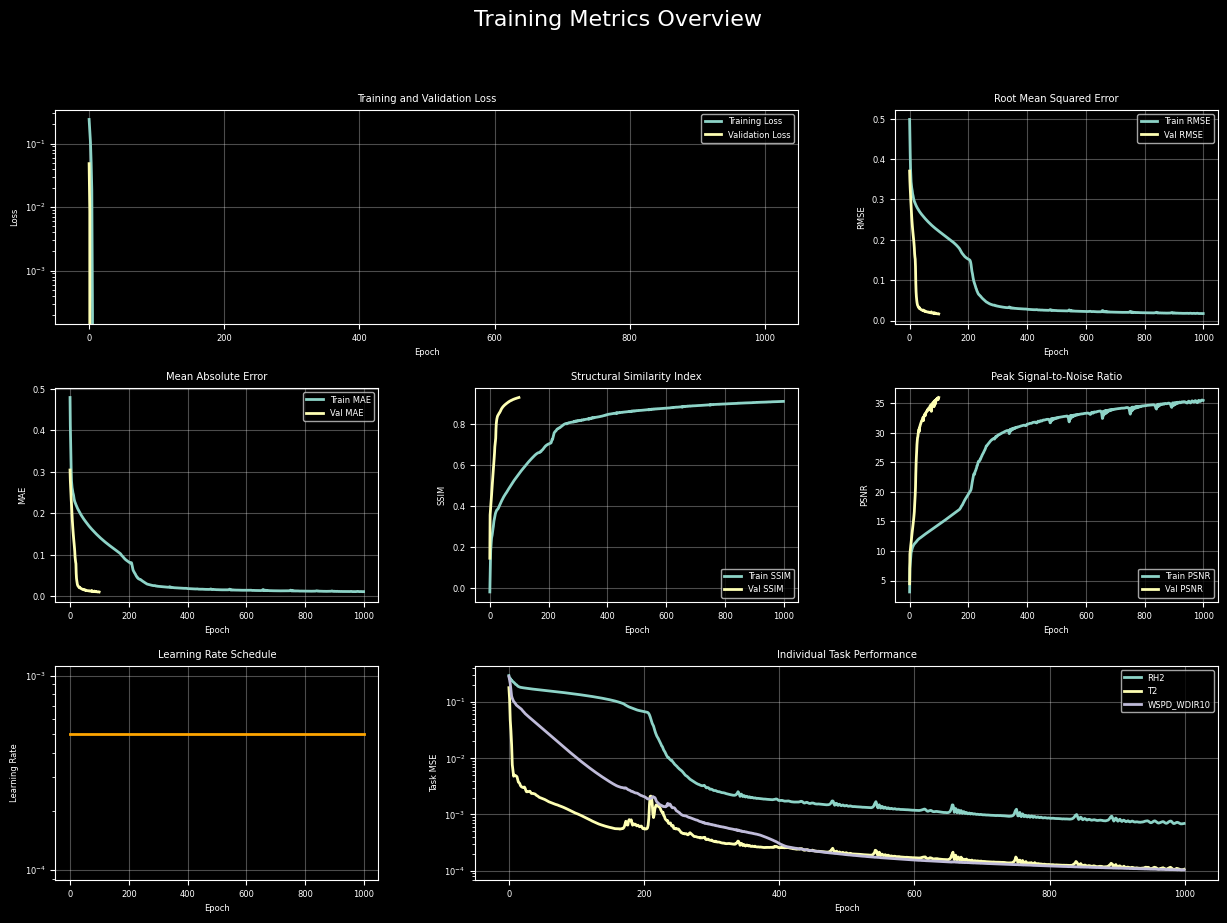

Plotting learned task weights...


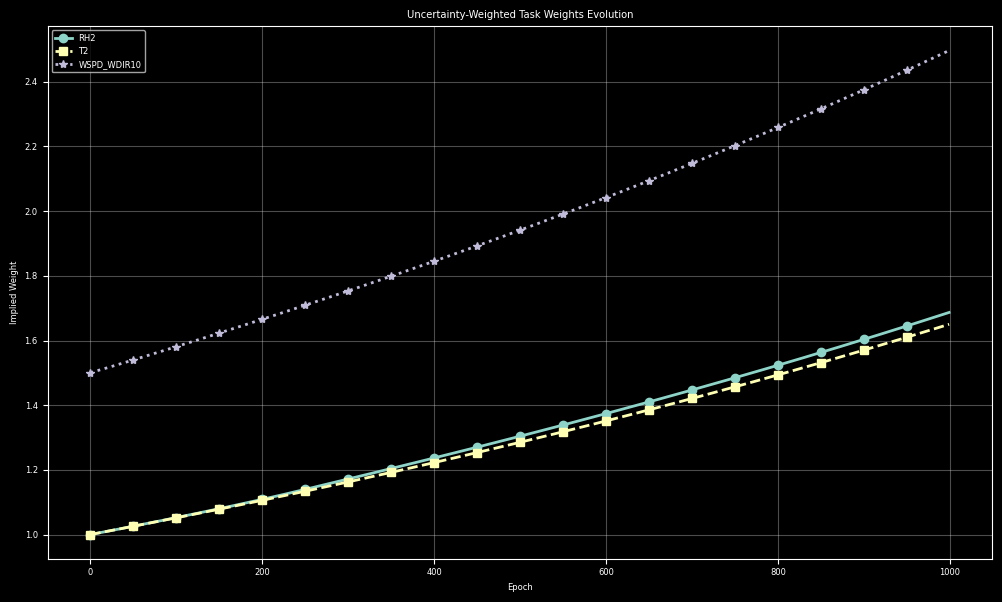

Analyzing task balance...


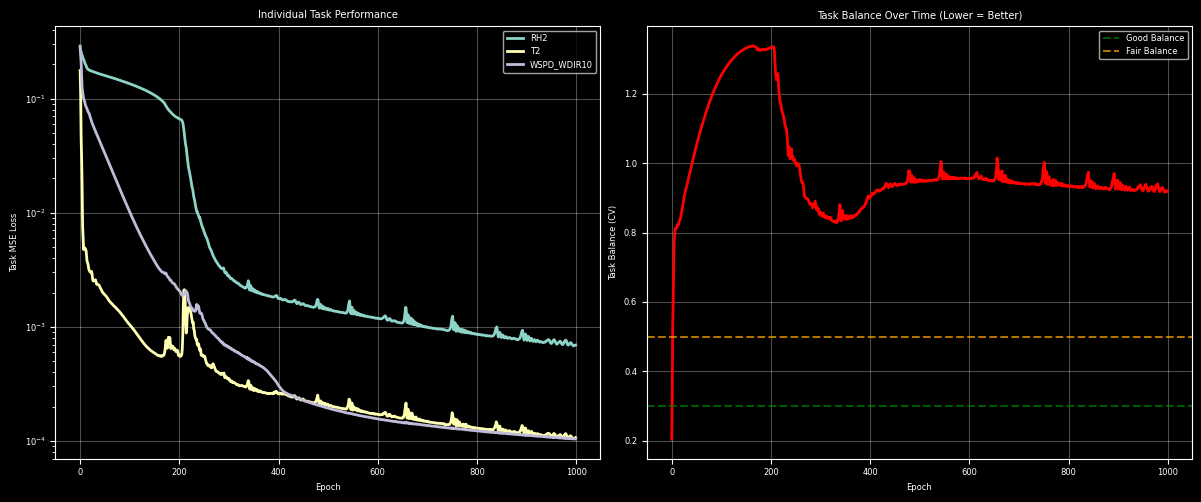

\n=== TASK PERFORMANCE ANALYSIS ===

Task Performance Analysis:
RH2:
  MSE: 0.0006
  MAE: 0.0171
  Correlation: 0.9911
T2:
  MSE: 0.0001
  MAE: 0.0069
  Correlation: 0.9888
WSPD_WDIR10:
  MSE: 0.0001
  MAE: 0.0079
  Correlation: 0.8834
\nGenerating predictions for detailed analysis...
Creating prediction statistics...


/home/vupparal/climateiq-cnn-1/usl_models/usl_models/atmo_ml/visualizer.py:477: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(true_var, pred_var, 1)


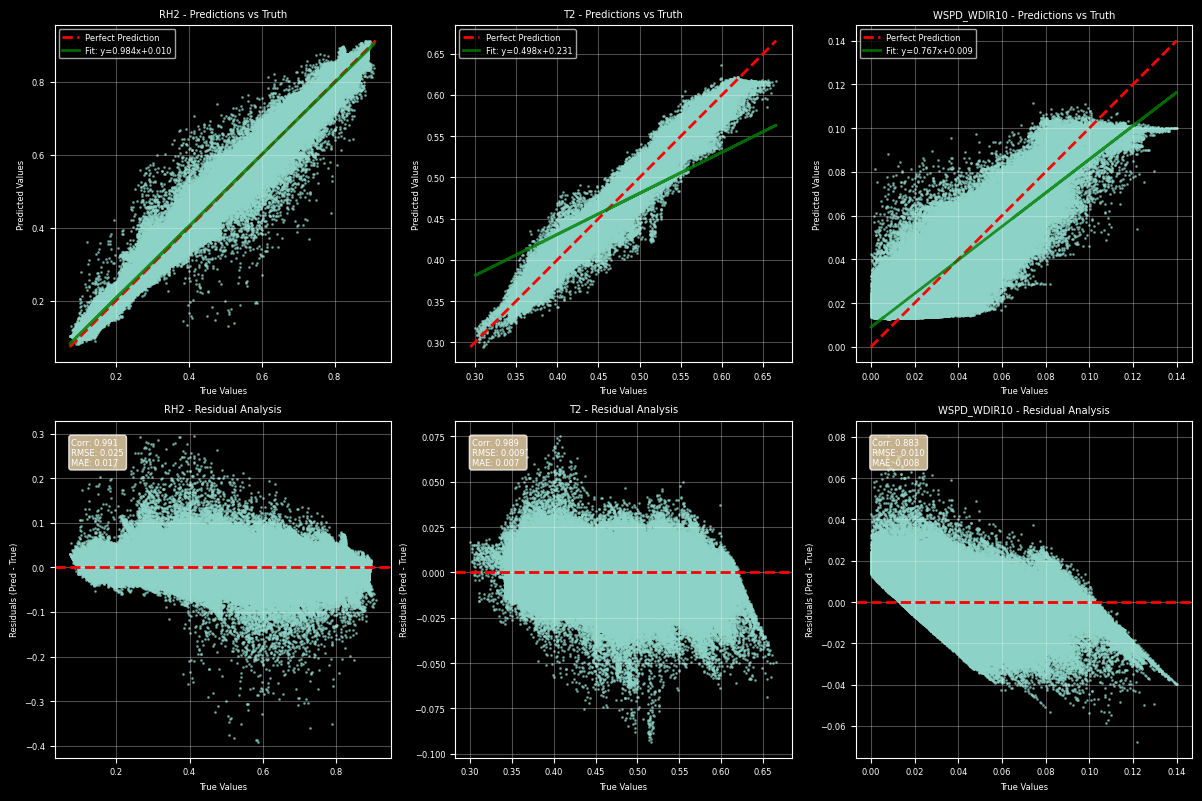

\n=== DETAILED VISUALIZATIONS ===
\n=== Visualizing RH2 ===


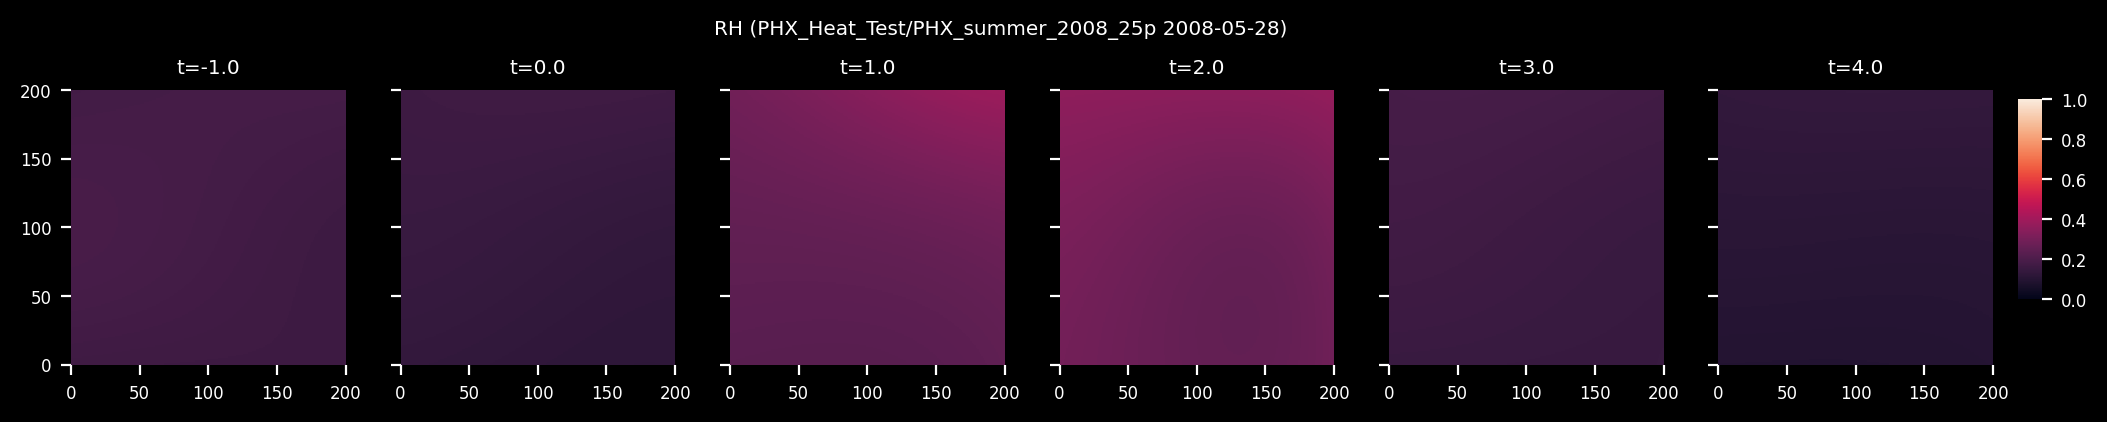

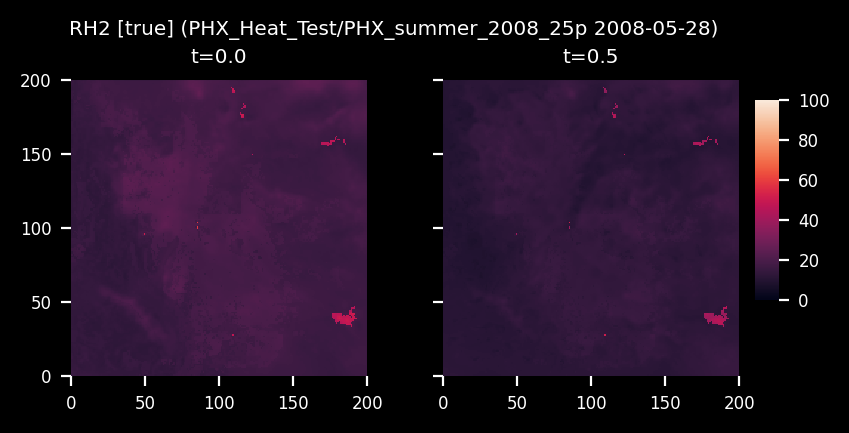

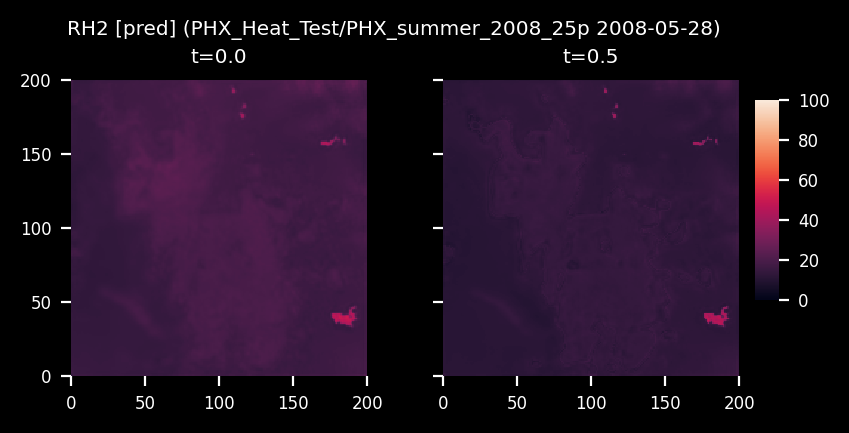

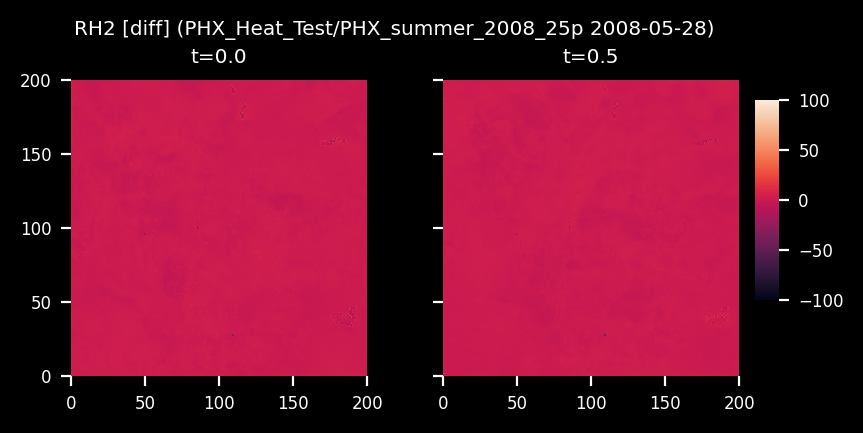

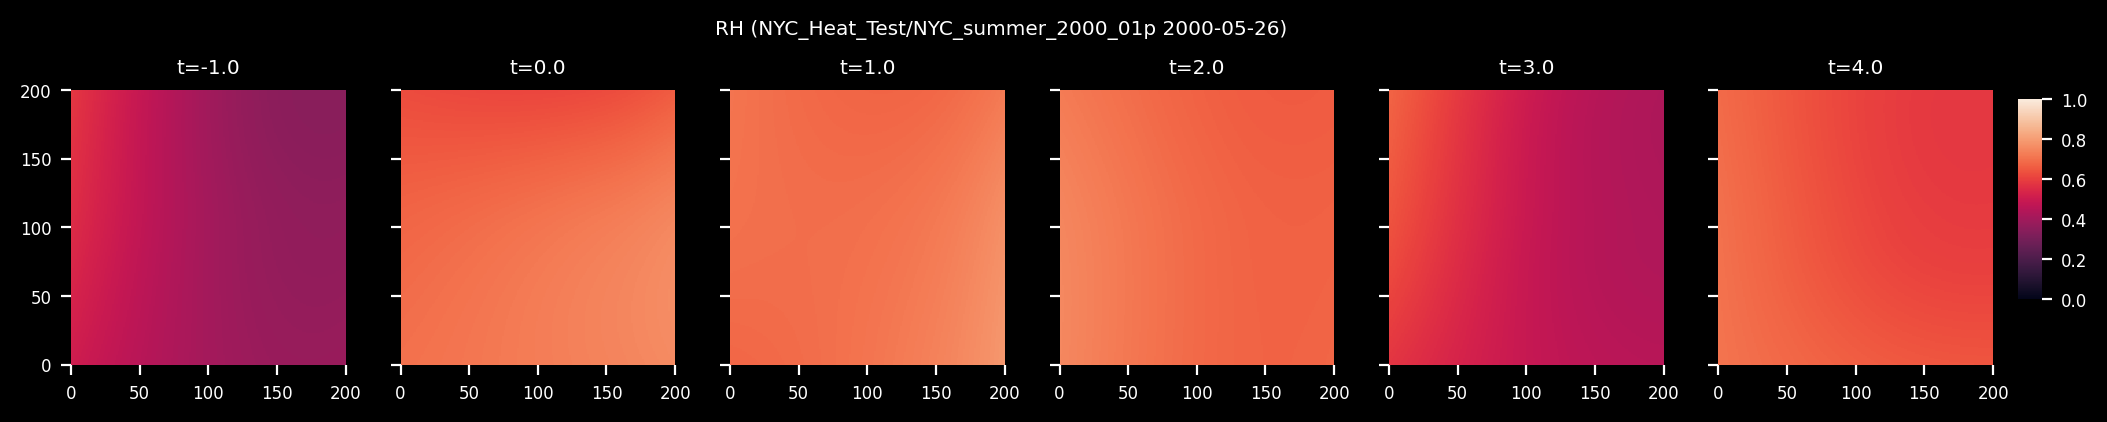

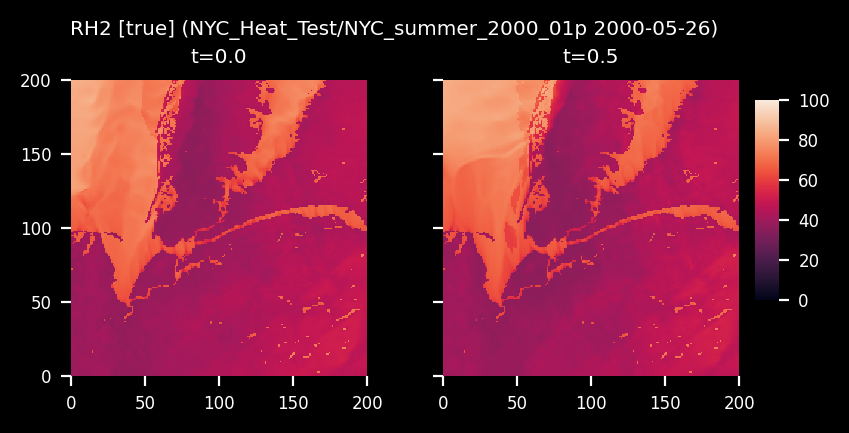

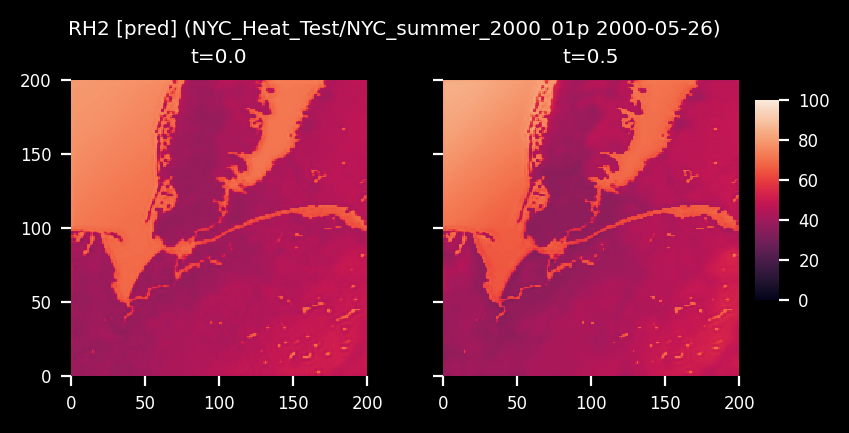

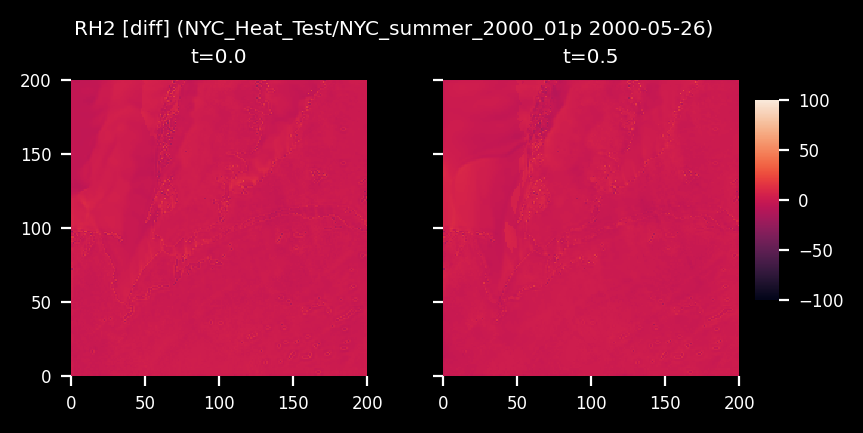

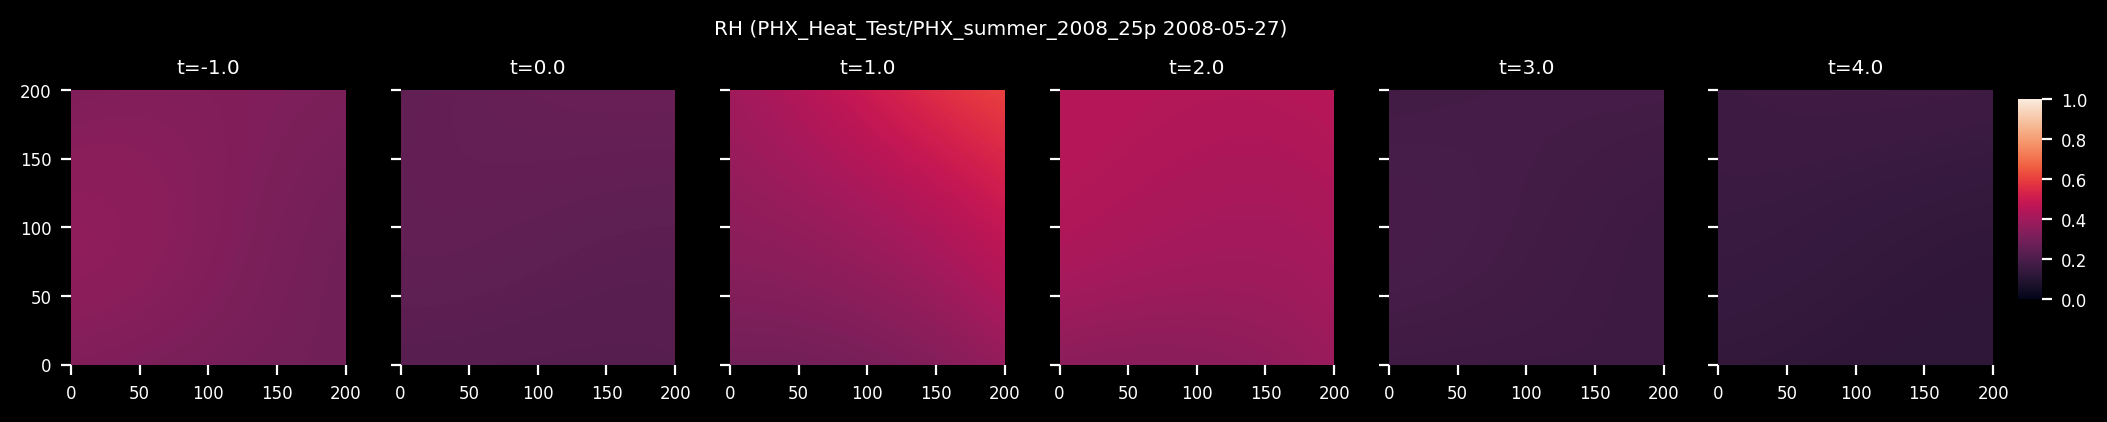

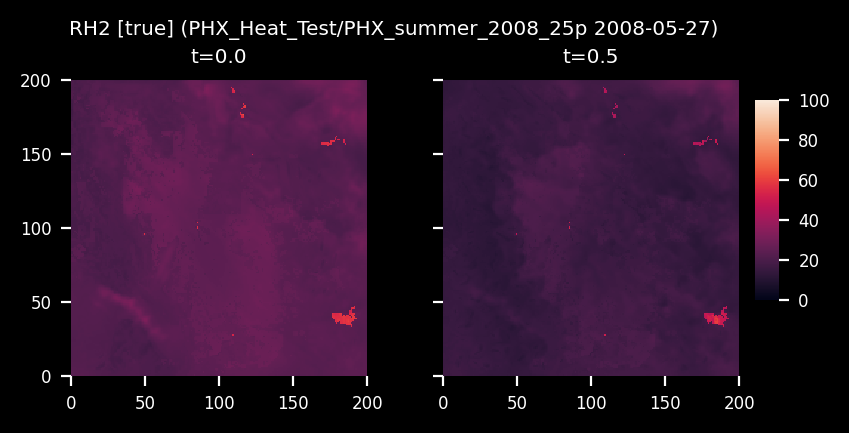

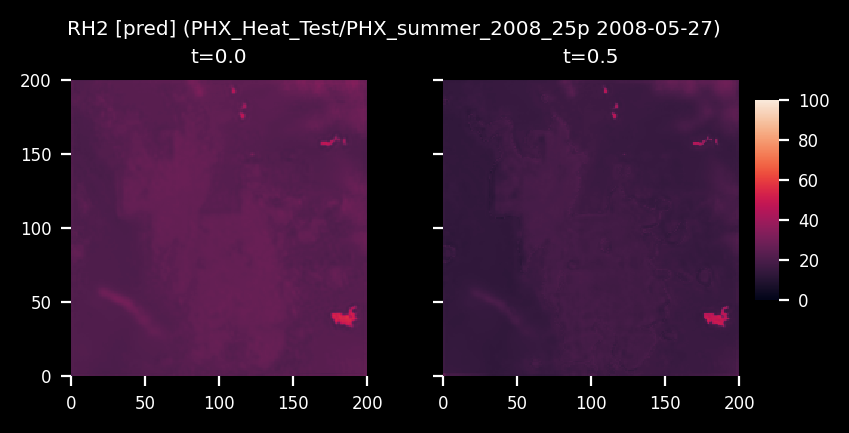

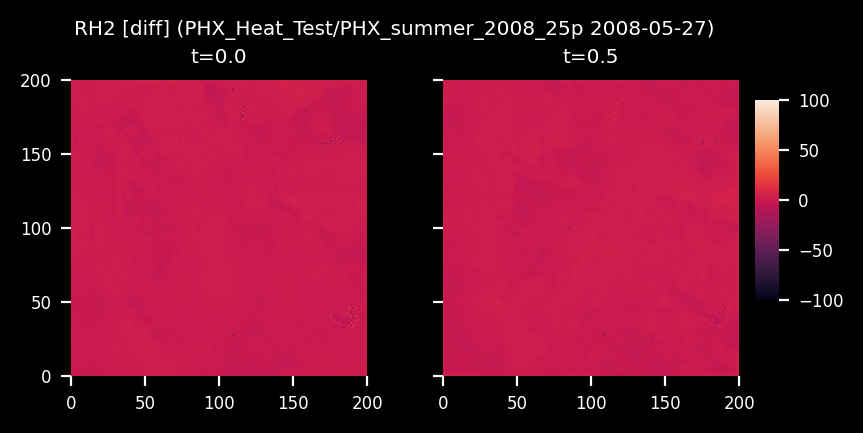

\n=== Visualizing T2 ===


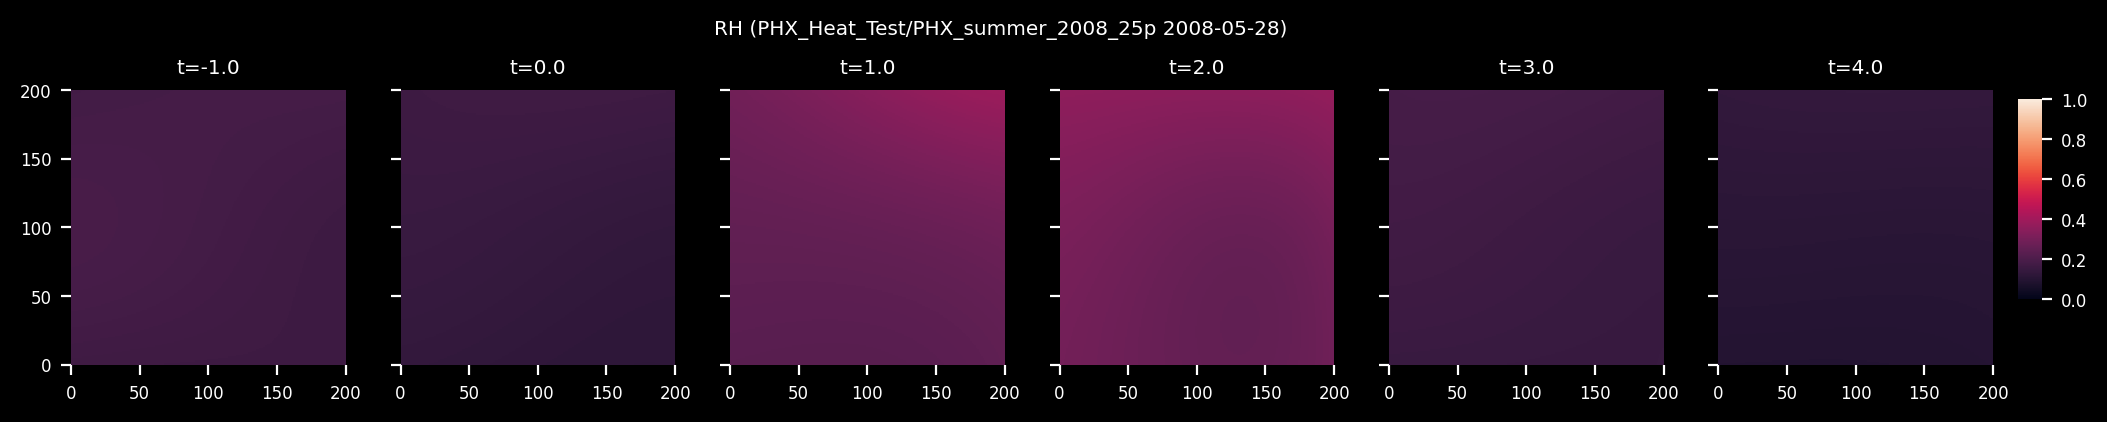

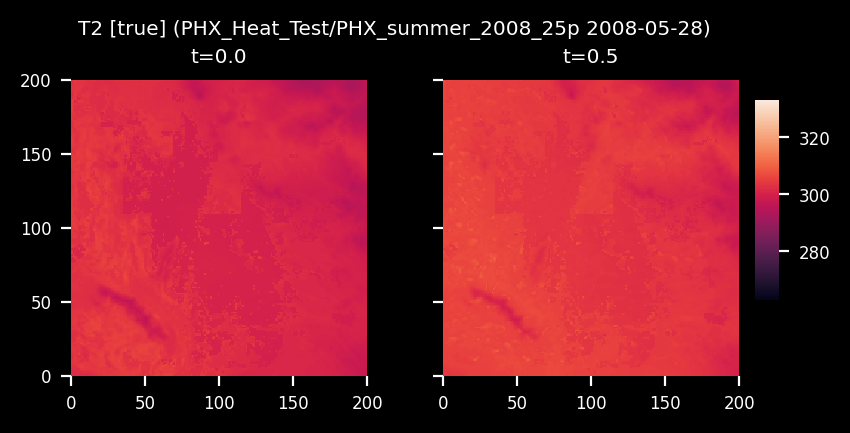

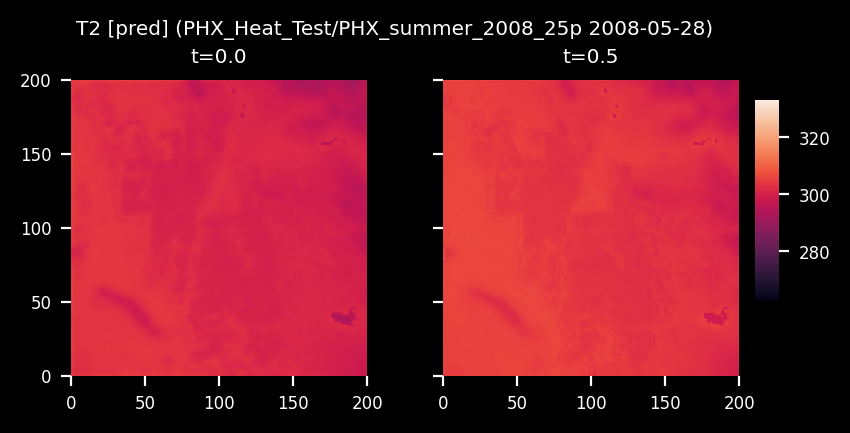

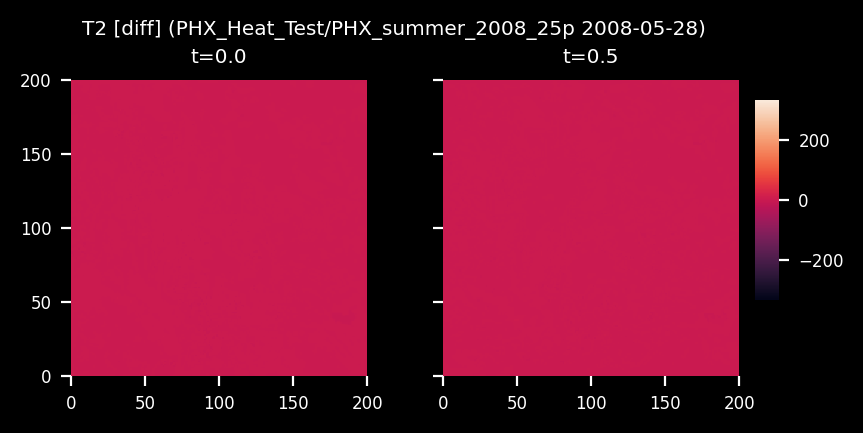

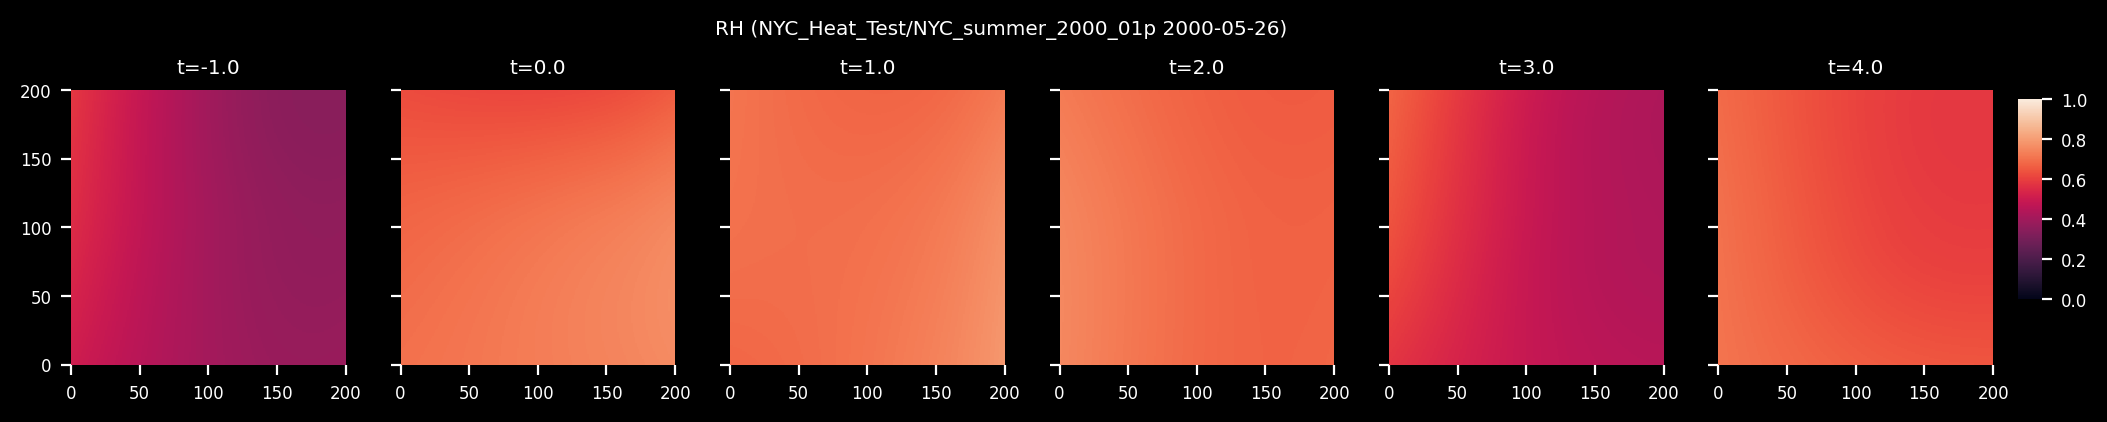

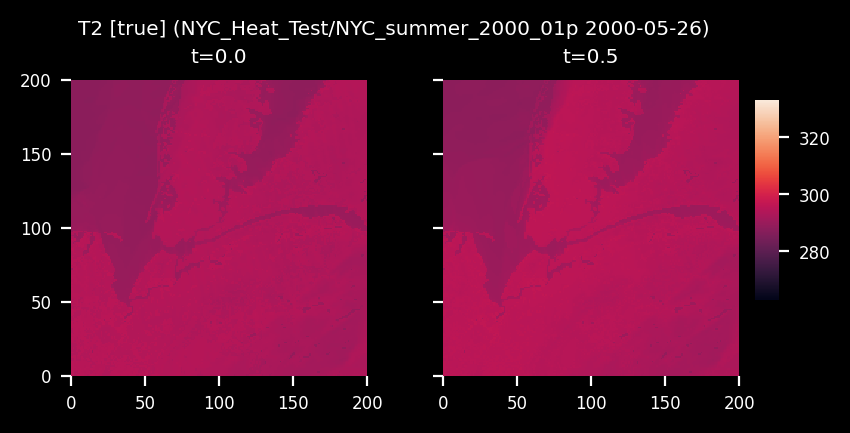

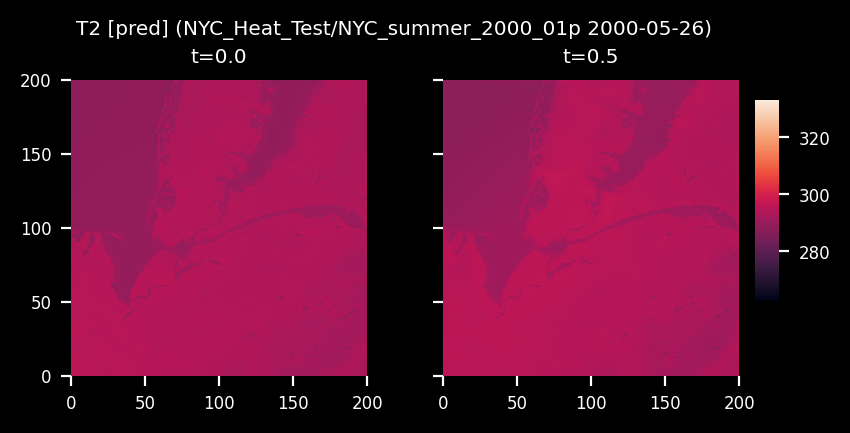

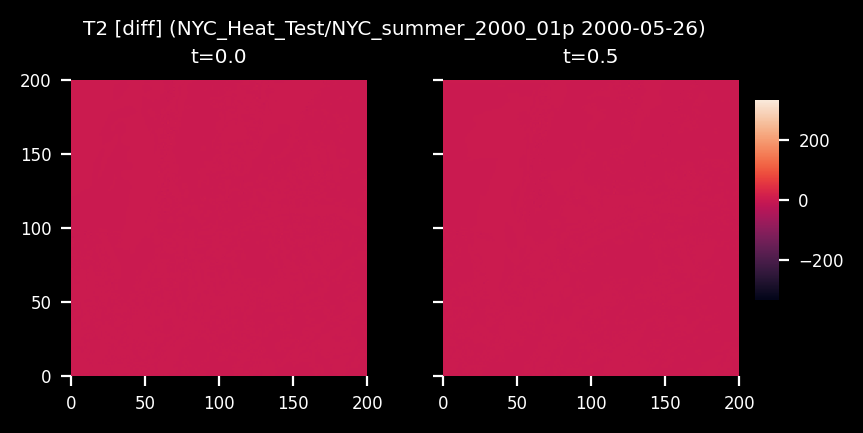

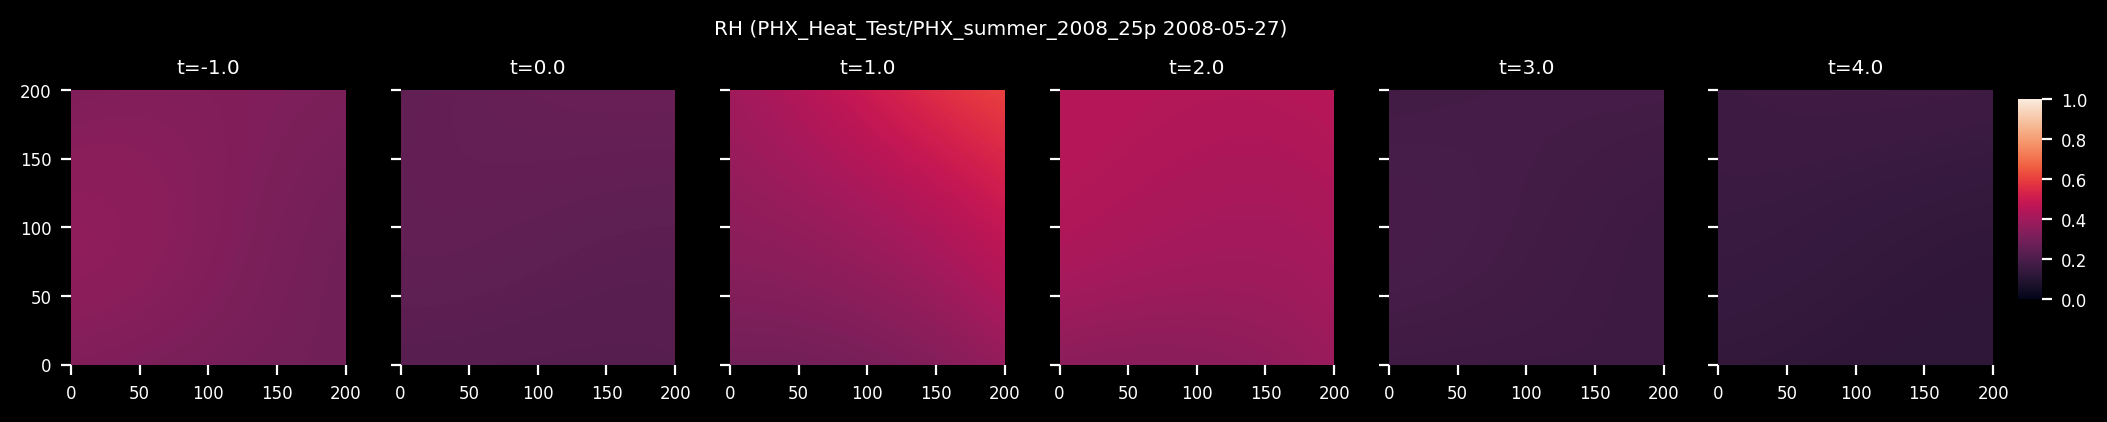

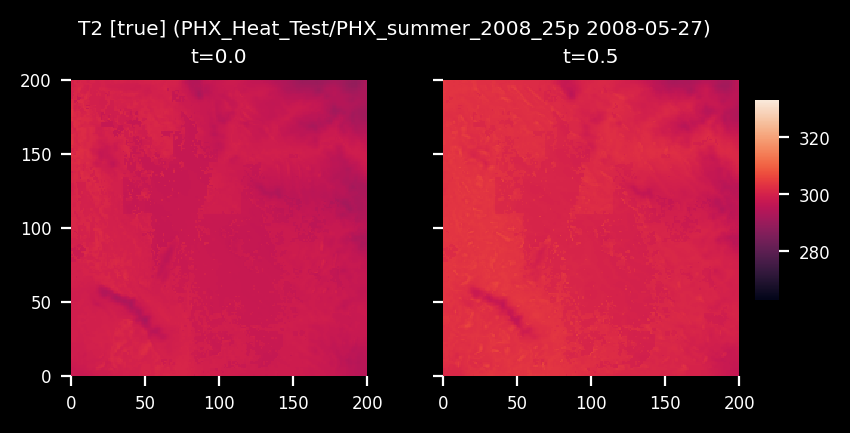

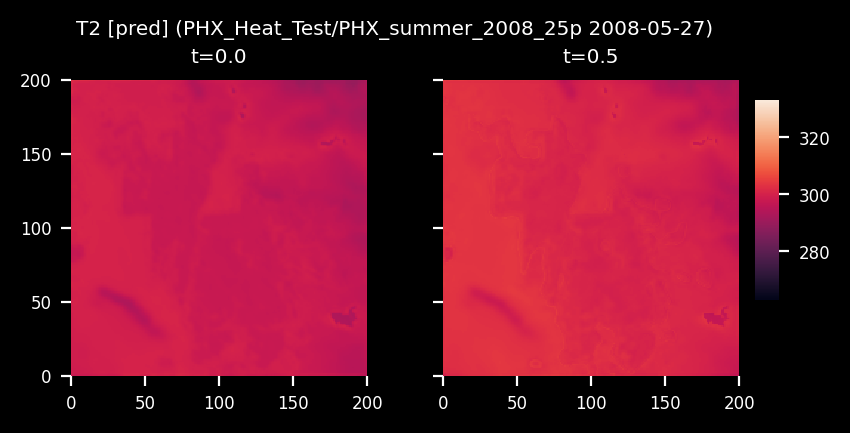

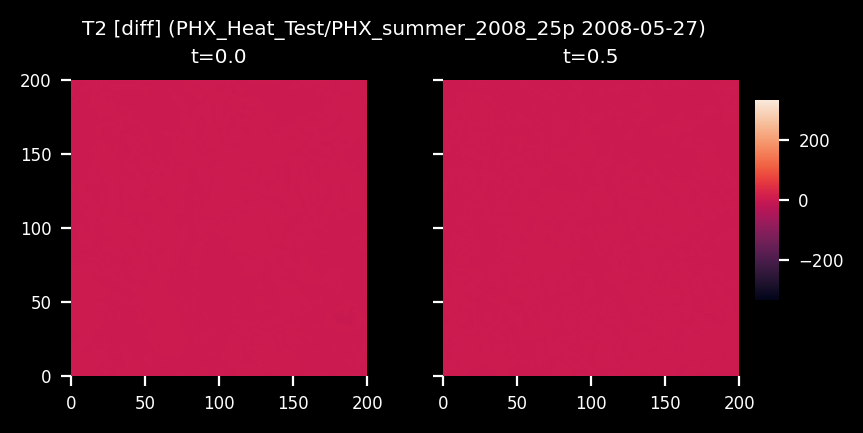

\n=== Visualizing WSPD_WDIR10 ===


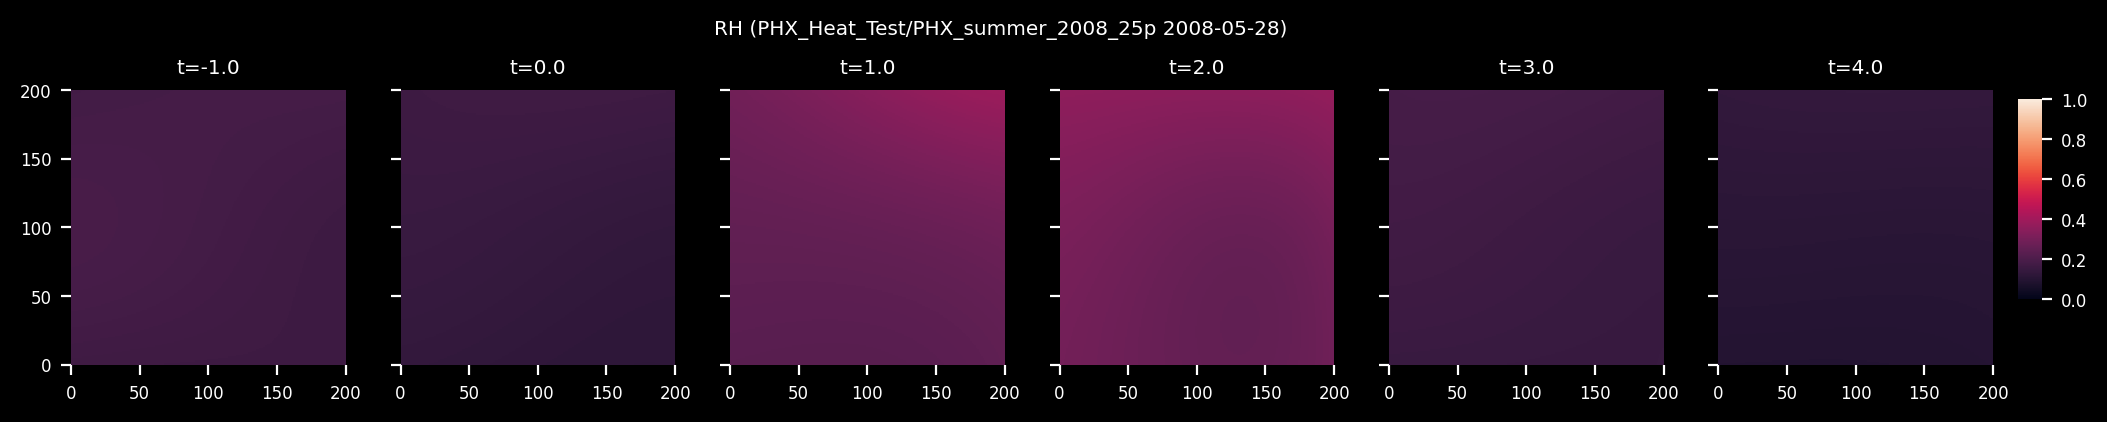

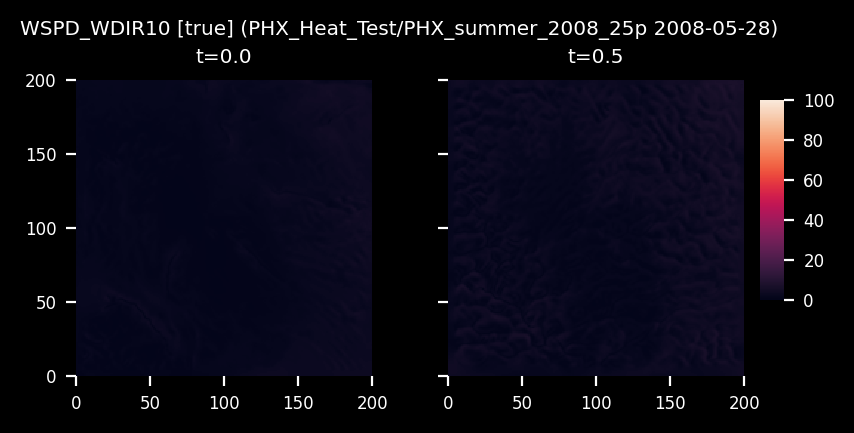

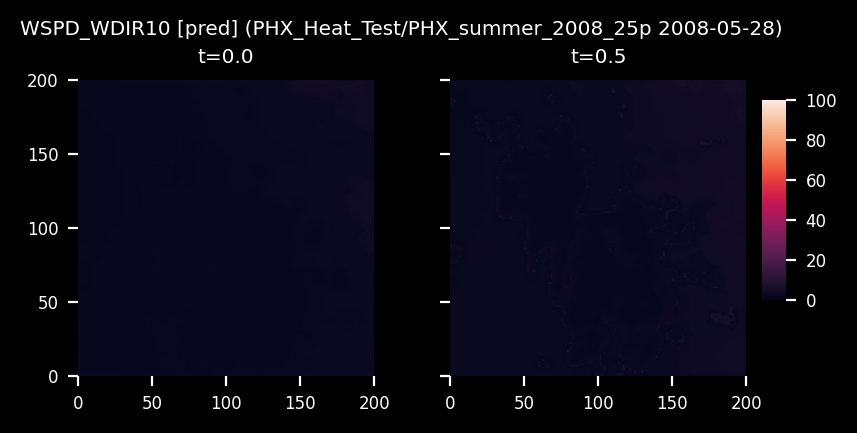

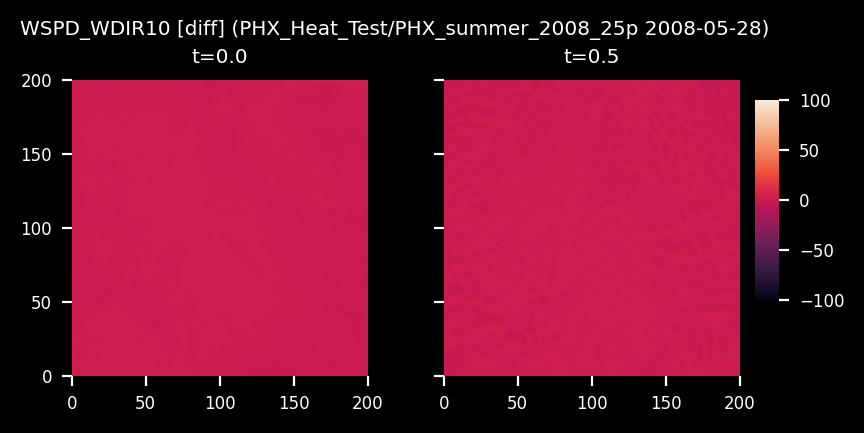

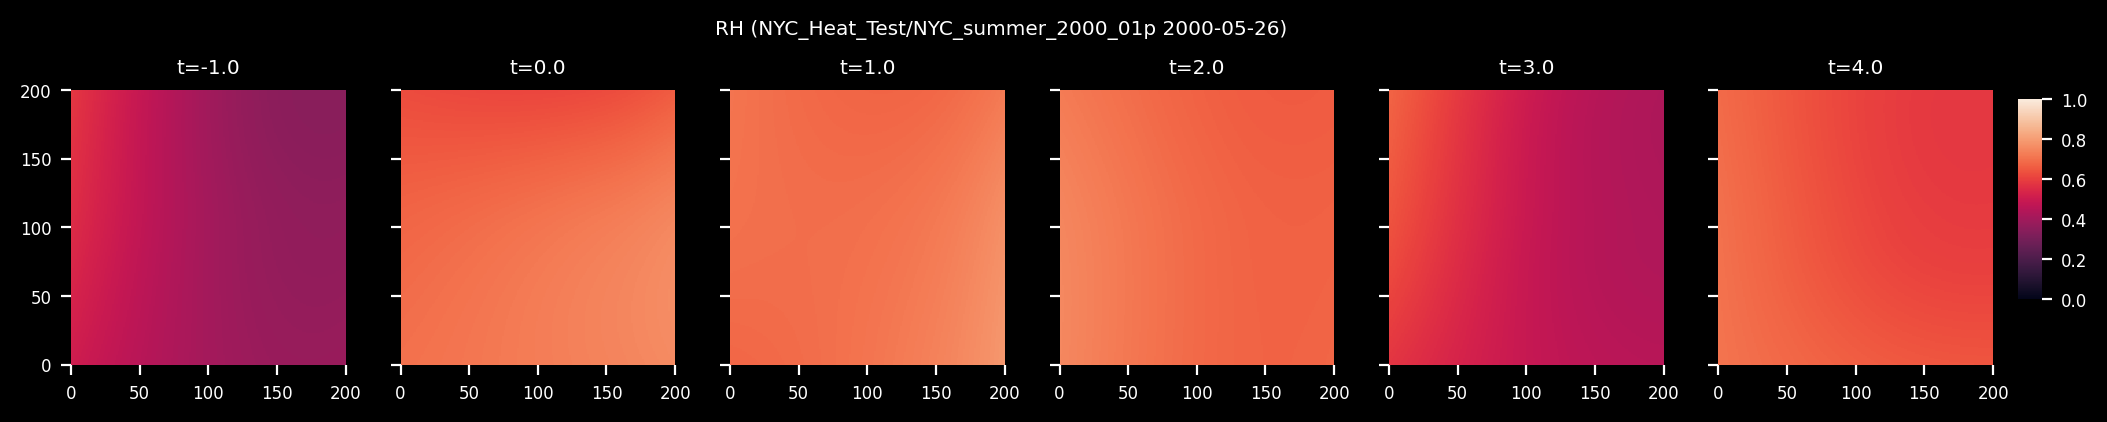

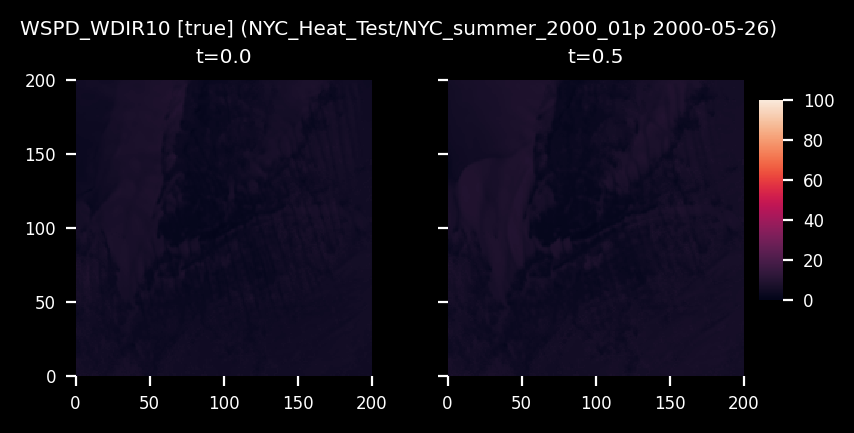

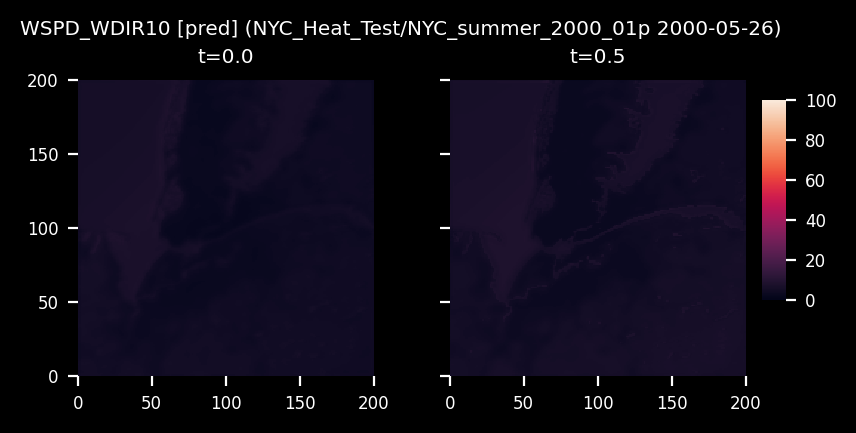

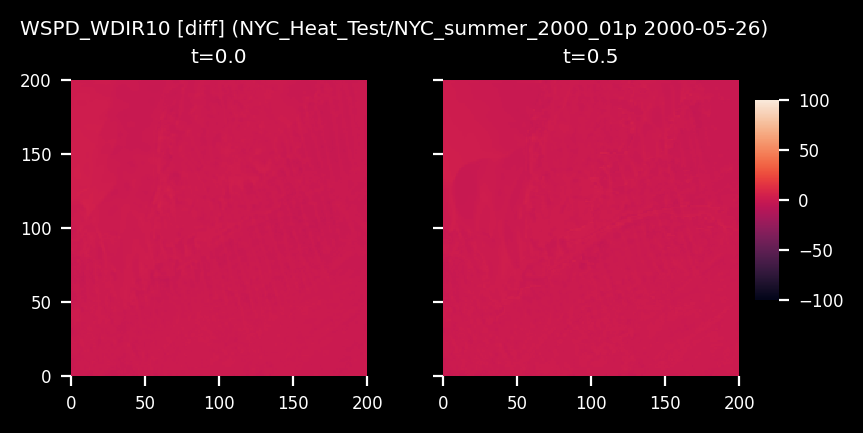

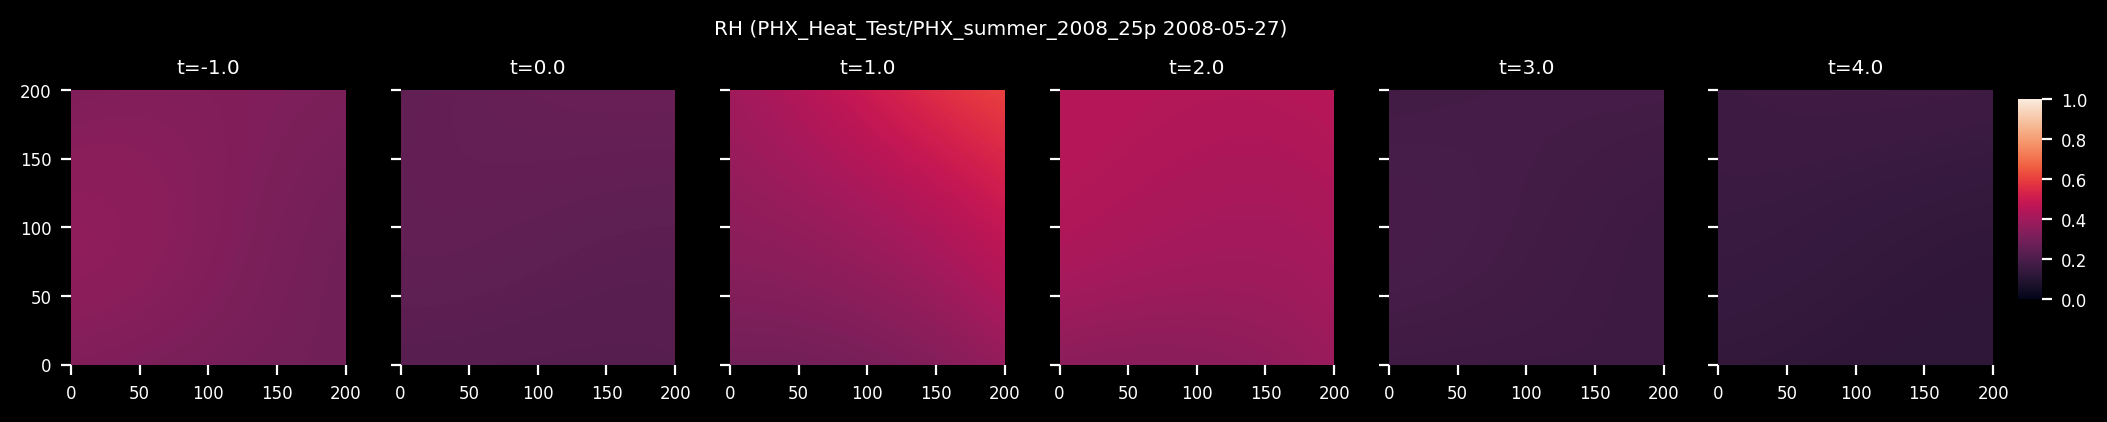

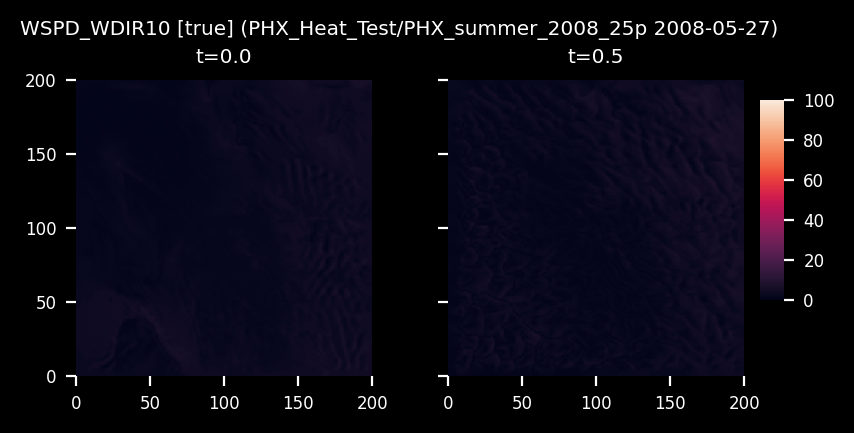

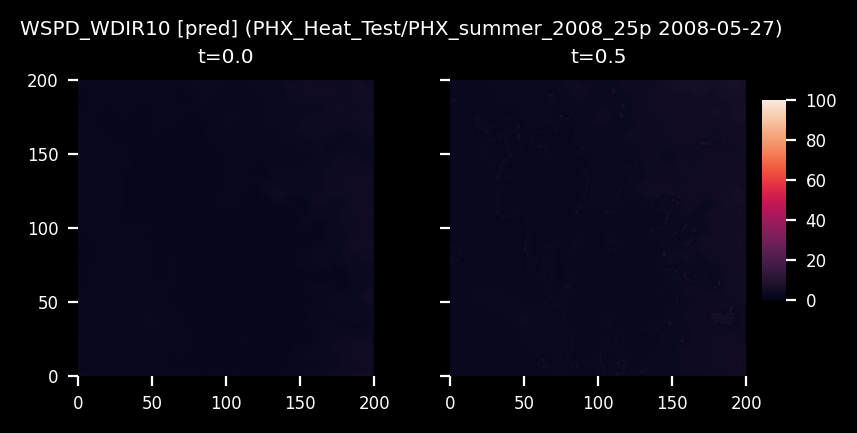

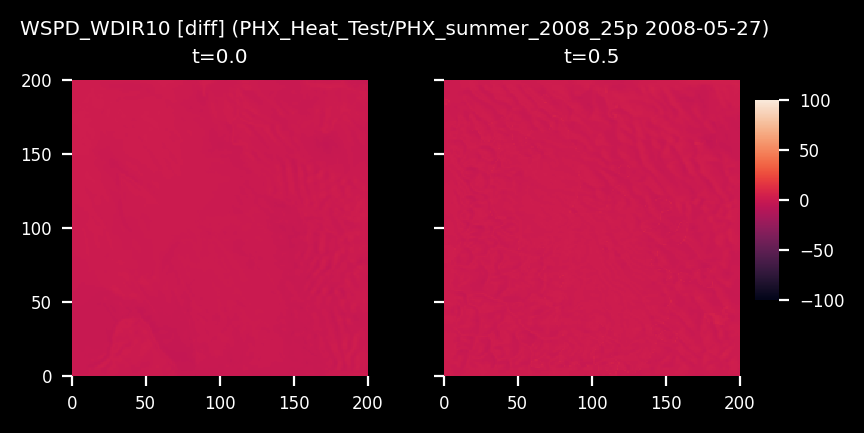

\n=== WIND ANALYSIS DEEP DIVE ===


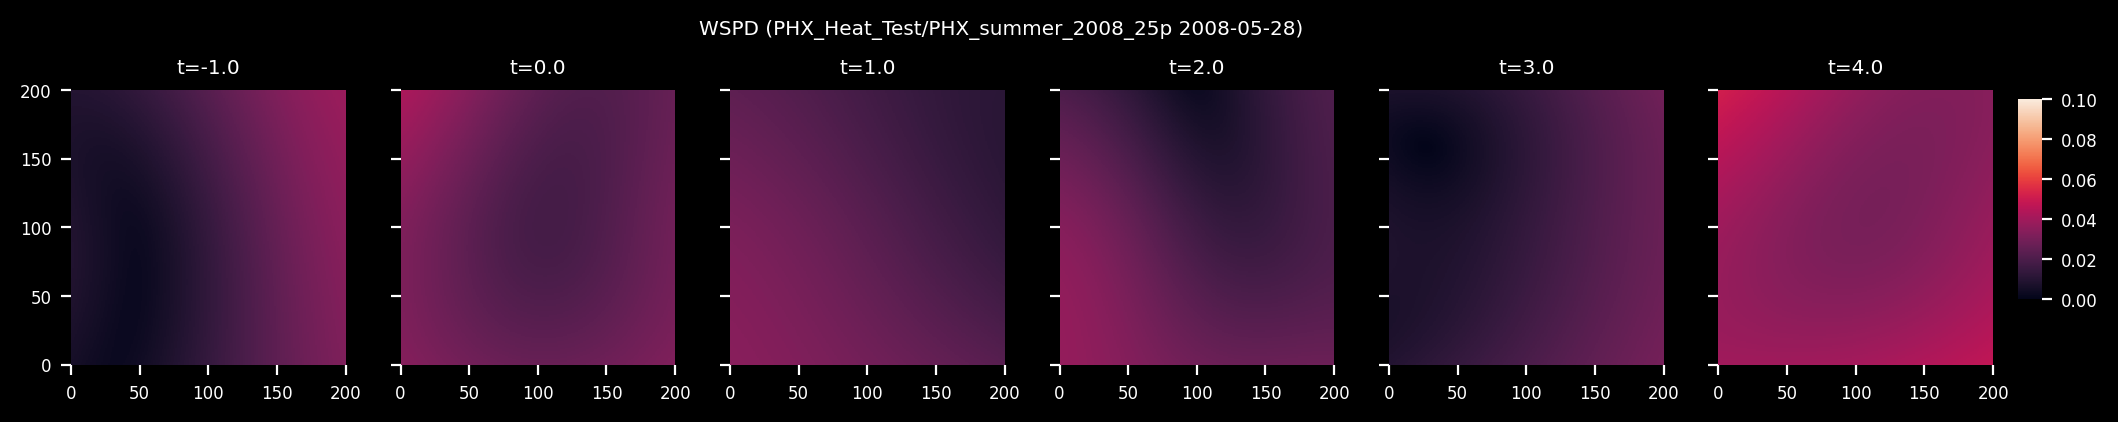

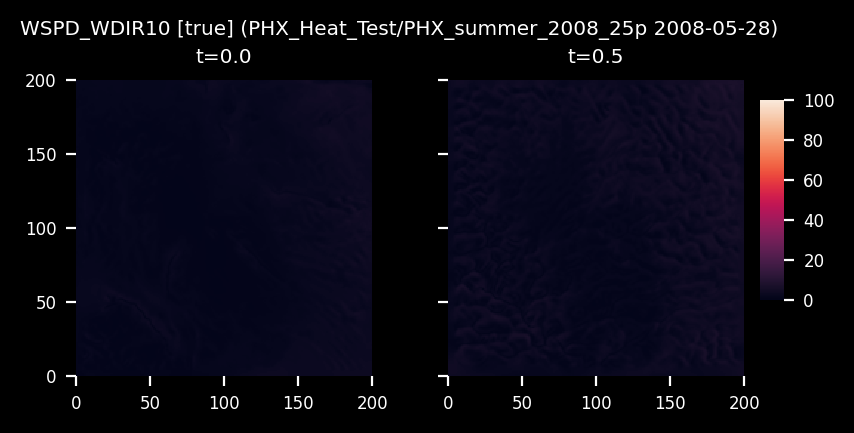

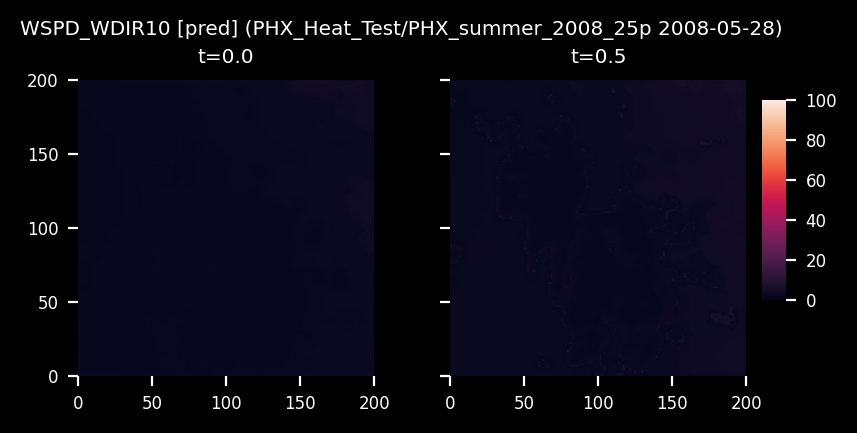

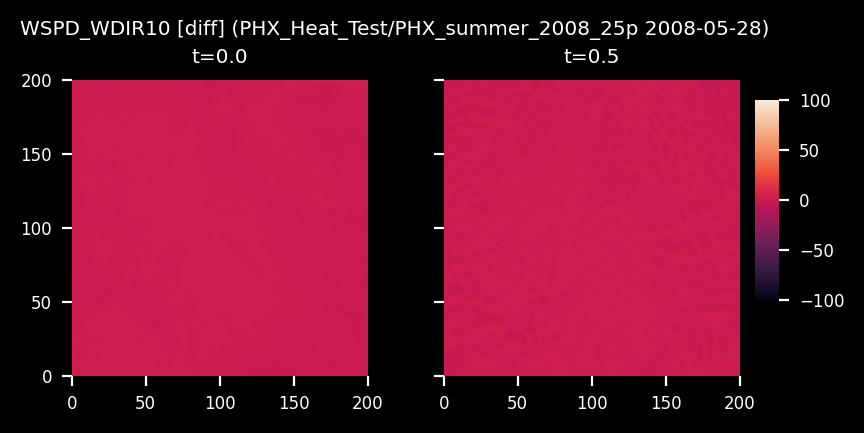

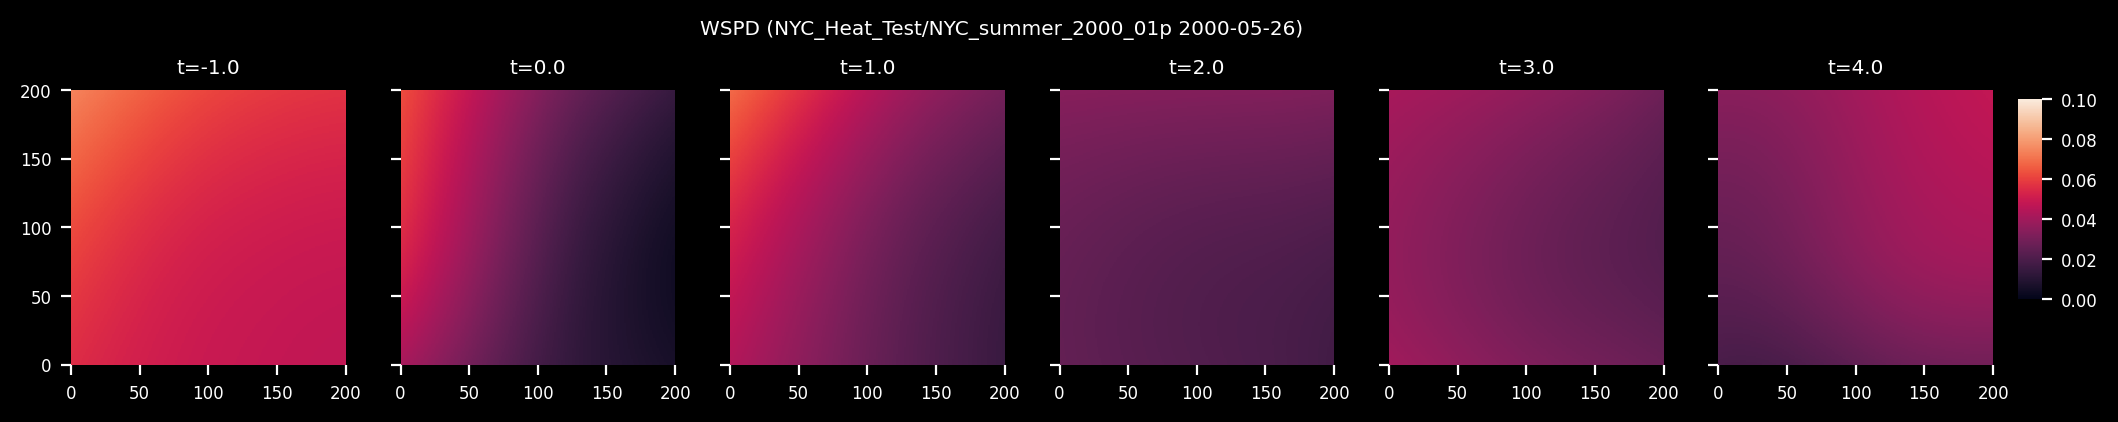

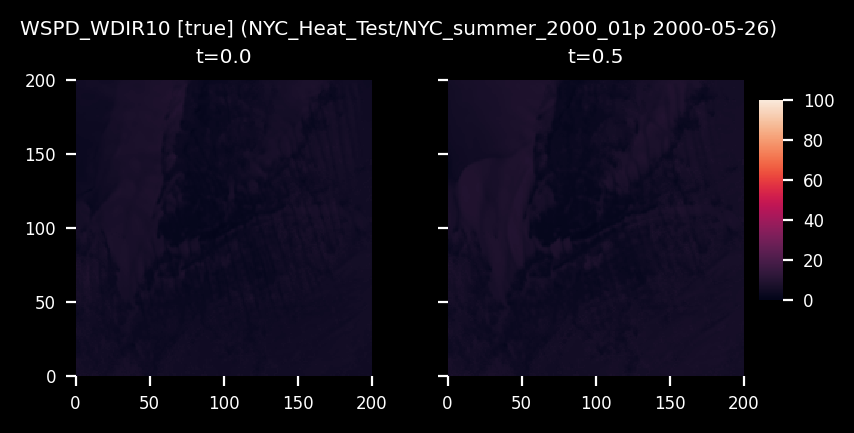

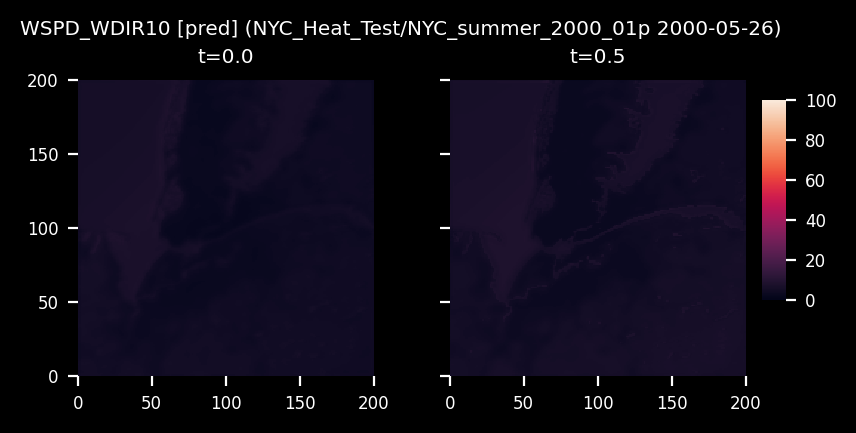

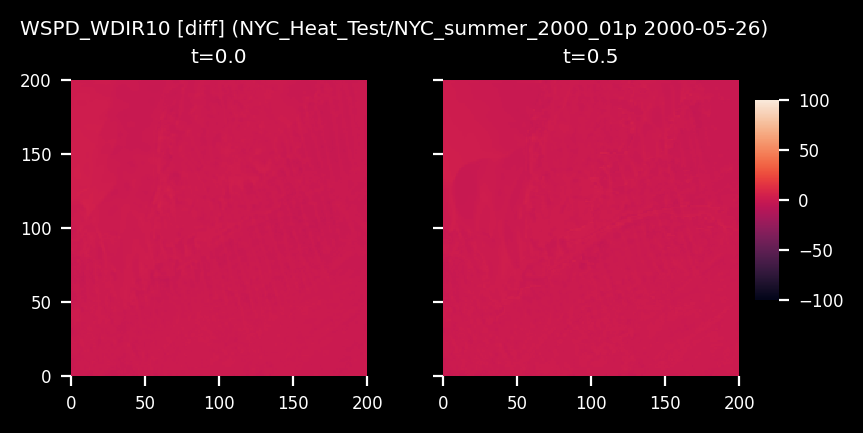

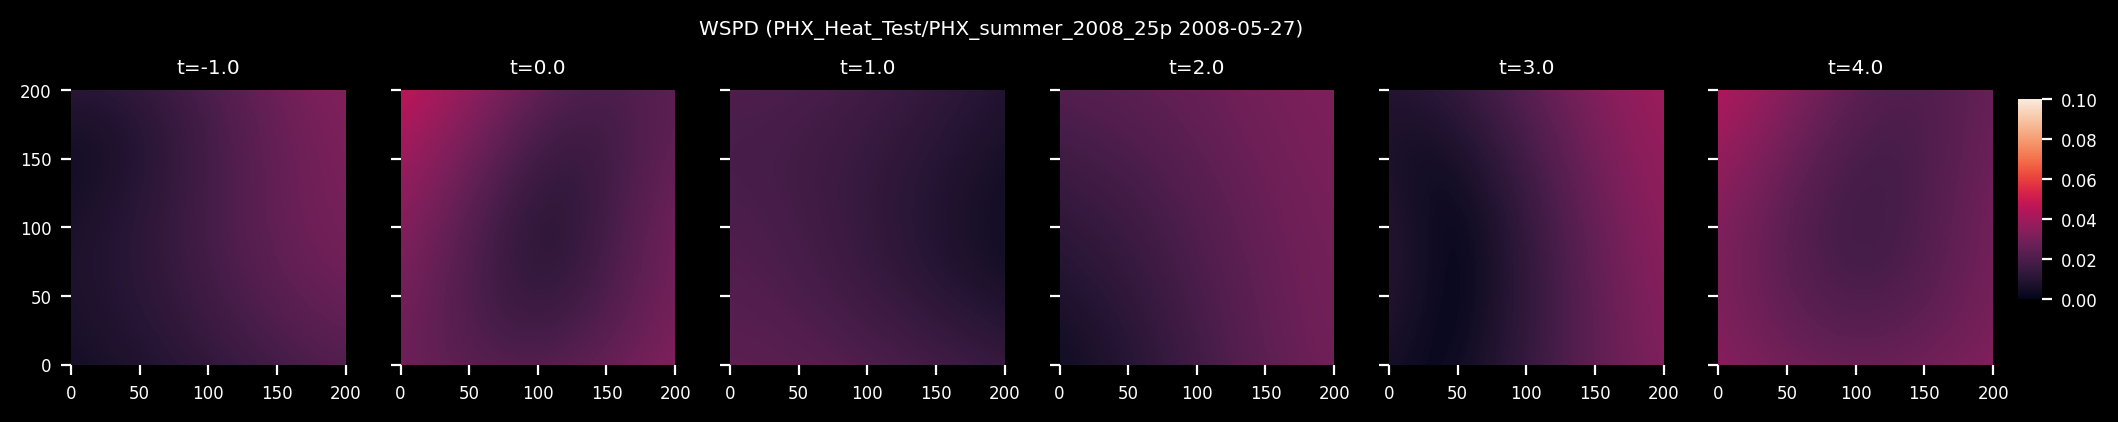

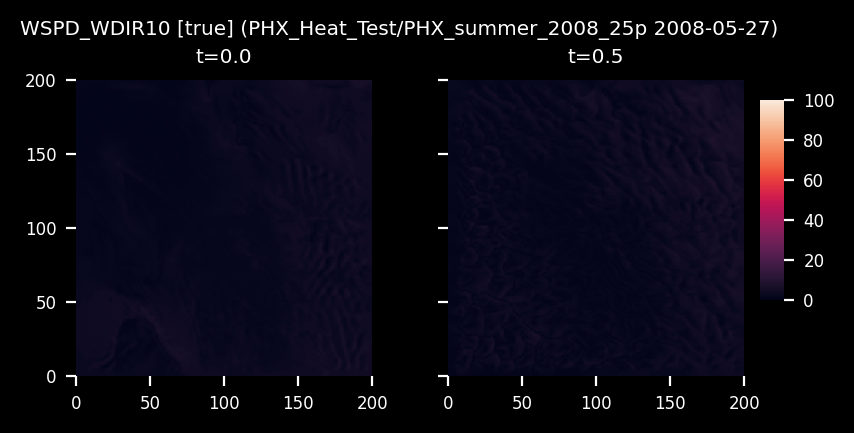

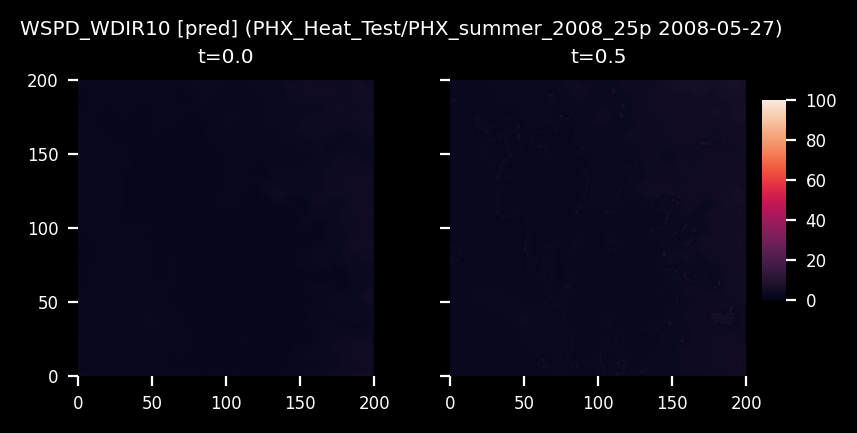

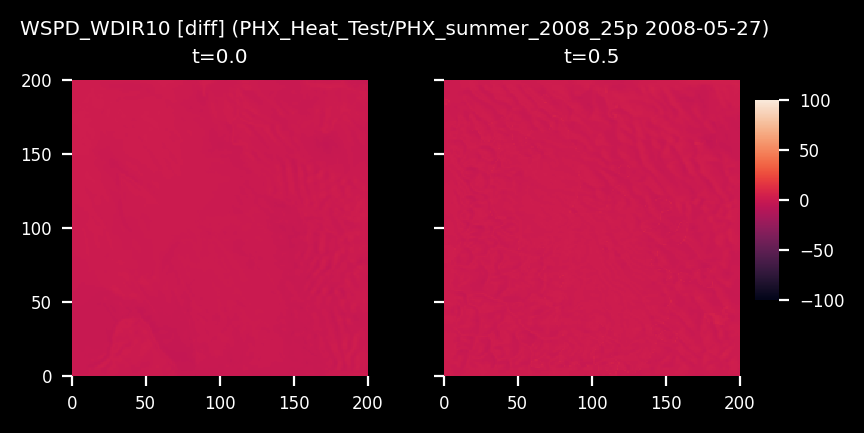

Wind-specific visualizations saved to ./logs/run-20250915-205106/examples/
\n=== GENERATING SUMMARY REPORT ===
\nTraining complete! All results saved to: ./logs/run-20250915-205106
Summary report: ./logs/run-20250915-205106/training_summary.txt
\n============================================================
TRAINING SESSION COMPLETE


In [6]:
# Initialize visualization theme
visualizer.init_plt()

print("=== TRAINING ANALYSIS ===")

# 1. Plot comprehensive training metrics overview
print("Generating comprehensive training metrics...")
fig_metrics = visualizer.plot_training_metrics(
    history, save_path=f"{log_dir}/comprehensive_training_metrics.png"
)
plt.show()

# 2. Plot uncertainty-weighted task weights evolution
print("Plotting learned task weights...")
lw = np.array(Monitor.learned_weights)
if lw.ndim == 1:
    lw = lw.reshape(-1, 1)

names = [sv.name for sv in model._params.sto_vars]
styles = ["-", "--", ":"]
markers = ["o", "s", "*"]

plt.figure(figsize=(10, 6))
for i in range(lw.shape[1]):
    y = lw[:, i].copy()
    # tiny visual offset if this series is nearly identical to any previous one
    for j in range(i):
        if np.allclose(y, lw[:, j], rtol=1e-6, atol=1e-8):
            y += (i + 1) * 1e-3  # small display-only nudge

    plt.plot(
        y,
        styles[i % len(styles)],
        marker=markers[i % len(markers)],
        markevery=max(len(y) // 20, 1),
        linewidth=2,
        label=names[i],
    )

plt.xlabel("Epoch")
plt.ylabel("Implied Weight")
plt.title("Uncertainty-Weighted Task Weights Evolution")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(f"{log_dir}/task_weights_evolution.png", dpi=150, bbox_inches="tight")
plt.show()

# 3. Task balance analysis
print("Analyzing task balance...")
fig_balance = visualizer.plot_task_balance_simple(
    history, ds_config.sto_vars, save_path=f"{log_dir}/task_balance.png"
)
plt.show()

# 4. Print detailed per-task performance metrics
print("\\n=== TASK PERFORMANCE ANALYSIS ===")
visualizer.compare_task_performance(model, val_ds, ds_config)

# 5. Get predictions for detailed analysis
print("\\nGenerating predictions for detailed analysis...")
for batch in val_ds.take(1):
    input_batch, label_batch = batch
    pred_batch = model.call(input_batch)
    break

# 6. Statistical analysis of predictions
print("Creating prediction statistics...")
fig_stats = visualizer.plot_prediction_statistics(
    pred_batch.numpy(),
    label_batch.numpy(),
    ds_config.sto_vars,
    save_path=f"{log_dir}/prediction_statistics.png",
)
plt.show()

# 7. Create detailed visualization examples directory
print("\\n=== DETAILED VISUALIZATIONS ===")
os.makedirs(f"{log_dir}/examples", exist_ok=True)

# 8. Generate comprehensive visualizations for each STO variable
for sto_var in ds_config.sto_vars:
    print(f"\\n=== Visualizing {sto_var.name} ===")

    # Create detailed maps for each variable
    figs = list(
        visualizer.plot_batch(
            ds_config,
            input_batch=input_batch,
            label_batch=label_batch,
            pred_batch=pred_batch,
            st_var=vars.Spatiotemporal.RH,  # Input variable to show
            sto_var=sto_var,  # Output variable to analyze
            max_examples=3,
            dynamic_colorscale=False,  # Clearer scale per series
            unscale=True,  # Show in original units
        )
    )

    # Display and save each figure
    for idx, fig in enumerate(figs):
        plt.show()  # Use plt.show() instead of display() for compatibility
        fig.savefig(
            f"{log_dir}/examples/{sto_var.name}_ex{idx}.png",
            dpi=180,
            bbox_inches="tight",
        )
        plt.close(fig)

# 9. Special focus on Wind patterns (if Wind is being predicted)
if vars.SpatiotemporalOutput.WSPD_WDIR10 in ds_config.sto_vars:
    print("\\n=== WIND ANALYSIS DEEP DIVE ===")

    # Create wind-specific analysis
    wind_figs = list(
        visualizer.plot_batch(
            ds_config,
            input_batch=input_batch,
            label_batch=label_batch,
            pred_batch=pred_batch,
            st_var=vars.Spatiotemporal.WSPD,  # Show wind speed input
            sto_var=vars.SpatiotemporalOutput.WSPD_WDIR10,  # Wind output
            max_examples=3,
            dynamic_colorscale=False,
            unscale=True,
        )
    )

    for idx, fig in enumerate(wind_figs):
        plt.show()
        fig.savefig(
            f"{log_dir}/examples/WIND_DETAILED_ex{idx}.png",
            dpi=180,
            bbox_inches="tight",
        )
        plt.close(fig)

    print(f"Wind-specific visualizations saved to {log_dir}/examples/")

# 10. Create a summary report
print("\\n=== GENERATING SUMMARY REPORT ===")
summary_path = f"{log_dir}/training_summary.txt"
with open(summary_path, "w") as f:
    f.write("ATMOML TRAINING SUMMARY\\n")
    f.write("=" * 50 + "\\n\\n")

    f.write(f"Model Parameters:\\n")
    f.write(f"- Output timesteps: {ds_config.output_timesteps}\\n")
    f.write(f"- STO variables: {[var.name for var in ds_config.sto_vars]}\\n")
    f.write(f"- LSTM units: {model._params.lstm_units}\\n")
    f.write(f"- LSTM kernel size: {model._params.lstm_kernel_size}\\n\\n")

    f.write(f"Training Configuration:\\n")
    f.write(f"- Total epochs trained: {len(history.history['loss'])}\\n")
    f.write(f"- Final training loss: {history.history['loss'][-1]:.6f}\\n")
    if "val_loss" in history.history:
        f.write(f"- Final validation loss: {history.history['val_loss'][-1]:.6f}\\n")
    f.write(f"- Validation frequency: every 10 epochs\\n\\n")

    f.write(f"Task Weights (Final):\\n")
    final_weights = Monitor.learned_weights[-1] if Monitor.learned_weights else "N/A"
    if isinstance(final_weights, (list, np.ndarray)):
        for i, var in enumerate(ds_config.sto_vars):
            if i < len(final_weights):
                f.write(f"- {var.name}: {final_weights[i]:.6f}\\n")
    f.write(f"\\nFiles Generated:\\n")
    f.write(f"- Model weights: {log_dir}/model_weights\\n")
    f.write(f"- Full model: {log_dir}/model\\n")
    f.write(f"- Training metrics: {log_dir}/comprehensive_training_metrics.png\\n")
    f.write(f"- Task balance: {log_dir}/task_balance.png\\n")
    f.write(f"- Task weights: {log_dir}/task_weights_evolution.png\\n")
    f.write(f"- Prediction stats: {log_dir}/prediction_statistics.png\\n")
    f.write(f"- Example visualizations: {log_dir}/examples/\\n")

print(f"\\nTraining complete! All results saved to: {log_dir}")
print(f"Summary report: {summary_path}")
print("\\n" + "=" * 60)
print("TRAINING SESSION COMPLETE")
print("=" * 60)

In [7]:
# Launch TensorBoard for interactive visualization
%load_ext tensorboard
%tensorboard --logdir ./logs --port 6006

Launching TensorBoard...